# Identifying Spamming Labellers


Amazon MTurk provides a service for requesters to let their data be labelled by humans. This can be exploited by spammers who do not make a honest try to label the data correctly. Because of this it would be useful to detect and filter out the spammers from the honest workers to achieve a higher certainty about the label.

This notebook will guide you through some statistics based on existing data where we look at the different parameters and features that a requester can get from the sevice. Based on the statistics we make decisions to create and improve a benchmark for methods trying to detect human labelling spammers on MTurk.

In this notebook we will look at four different types of task. Binary vision and binary nlp and multiclass vision and multiclass nlp.
In the binary classification tasks, the worker has to decide between two options and in the multiclass case a total of 5 options.


## File managment



In [ ]:
import pandas as p
import numpy as np
import plotly.express as px

import seaborn as sns
import matplotlib.pylab as plt
plt.style.use("seaborn")

import os
if not os.path.exists("images"):
    os.mkdir("images")

from numpy import arange
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold

from functools import cmp_to_key

import datetime
from dateutil.relativedelta import relativedelta
from datetime import date
from datetime import datetime

import random
from sklearn import metrics

In [ ]:
#translate class name into matrix index
def classFinder(c):
  switcher = {
      "None": 0,
      "Handbag":1,
      "Cutlery":2,
      "Bottle":3,
      "Clock":4,
      
      "Health & Medical":1,
      "Hair Salons":2,
      "Nail Salons":3,
      "Fitness & Instruction":4
  }
  return switcher.get(c,"Invalid")

file_path = "drive/MyDrive/Colab Notebooks/"

binary_vision_files = ["binary_vision5.csv", "binary_vision10.csv","binary_vision25.csv","binary_vision25_2.csv","binary_vision50.csv","binary_vision75.csv","binary_vision100.csv","binary_vision100_mid-info.csv","binary_vision100_2.csv","binary_vision100_3.csv","binary_vision100_noUS.csv"]
binary_nlp_files = ["binary_nlp5.csv","binary_nlp5_2.csv", "binary_nlp10.csv","binary_nlp25.csv","binary_nlp25_2.csv","binary_nlp50.csv","binary_nlp75.csv","binary_nlp100.csv","binary_nlp100_mid-info.csv"]
vision_files = ["vision5.csv","vision10.csv","vision25.csv","vision25_2.csv","vision50.csv","vision75.csv","vision100.csv","vision100_2.csv"]
nlp_files = ["nlp5.csv","nlp10.csv","nlp25.csv","nlp25_2.csv","nlp50.csv","nlp75.csv","nlp100.csv","nlp100_2.csv","nlp100_3.csv"]

train_features = ["info-approval-time","WorkTimeInSeconds","LifetimeApprovalRate", "Last30DaysApprovalRate", "Last7DaysApprovalRate", "Input.label_","complete-time-", "load-time","start-time","end-time","Answer.label_","mid-time-approval-time-in-seconds"]
#train_features = ["WorkTimeInSeconds", "Input.label_","complete-time-", "start-time","end-time","Answer.label_"]
#test_features = ["WorkTimeInSeconds","LifetimeApprovalRate", "Last30DaysApprovalRate", "Last7DaysApprovalRate", "Input.label_", "start-time","end-time"]

options = [0.1,0.25,0.33,0.4,0.6,0.75,0.9]





In [ ]:
def translateClass(c):
  if c == "Chair" or c == "Person" or c == "Restaurant" or c == "Restaurants":
    #print(c)
    ret = 1
  elif c == "NoChair" or c =="NoPerson" or c == "None":
    ret = 0
  else:
    ret = c
  #print(ret)
  return ret

def matrixPreparation(col,row,X):
  for i in range(0,col):
    for j in range(0,row):
      c = X[j,i]
      if c == "Chair" or c == "Person" or c == "Restaurant" or c == "Restaurants":
      #print(c)
        X[j,i] = 1
      elif c == "NoChair" or c == "noChair" or c == "NoPerson" or c == "None":
        X[j,i] = 0
      elif str(c).__contains__('%'):
        X[j,i] = float(c.split('%')[0])/100
        #print( X[j,i])
      elif str(c).__contains__('2021-'):
        X[j,i] = 0
      elif classFinder(c) != "Invalid":
         X[j,i] = classFinder(c)
  return X

### Binary vision task


Import the needed files for the binary classification vision task and prepare the matrices for analysis and benchmark.

We create 3 types of lists:
binary_vision_true, which stores the ground truth of the labels of every corresponding file

binary_vision_answer, which stores the answers of the workers

binary_vision_train, which stores for each file, the features that will be used for the benchmark. Many features can not be immediatley used (e.g. completion-time). The needed changes and calculations are done here aswell.

In [ ]:
#given the mid-info-approval-time find the label which was finished just before
def findIndex(i, time):
  completion_times = []
  for feature in train_matrix.iloc[i]:
    
    #if feature != time:
      
    format = "%Y-%m-%d"

    temp = feature
    temp = str(temp).split('T')[0]

    try:
      res = bool(datetime.strptime(str(temp), format))
      completion_times.append(feature)
    except ValueError:
      res = False

    #print(completion_times)
  
  min_dif = 100000000
  j = -1
  for times in completion_times:
    if time > times:
      diff = ( p.Timestamp(time) - p.Timestamp(times) )/np.timedelta64(1,'s')
      #print(diff)
      if diff > 0 and diff < min_dif:
        #print(diff)
        #print(completion_times.index(times))
        min_dif = diff
        j = completion_times.index(times)


  #print(j,completion_times[j], time)
  return (min_dif,j)

path = file_path + "binary_vision/"
classes = ["Chair", "NoChair"]

binary_vision_true = []
binary_vision_answer = []
binary_vision_train = []


#copy the complete dataframe/csv file to the other dataframes
for files in binary_vision_files:
  df = p.read_csv(path + files)
  true_matrix = df.copy()
  answer_matrix = df.copy()
  train_matrix = df.copy()

  total_workers = len(df.index)
  cols = df.columns


  #delete columns which are not needed for the corresponding use
  for i in range(len(cols)):
    if not (cols[i].__contains__("Input.label_")):
      del true_matrix[cols[i]]

    if not (cols[i].__contains__("Answer.label_")):
      del answer_matrix[cols[i]]

    if not any(label in cols[i] for label in train_features):
      del train_matrix[cols[i]]


  #this file contains cognitive test where workers need to read a short text, 
  #due to the completion times not being in order, we need to find the label
  #which was finished just before the test
  if "mid-info-approval-time" in train_matrix:
    temp = []
    info_time = train_matrix["mid-info-approval-time"]
    for i in range(0,info_time.size):
      (diff,j) = findIndex(i, info_time[i])
      temp.append(diff)
    temp_df = p.DataFrame(temp, columns=["mid-time-approval-time-in-seconds"])
    train_matrix = train_matrix.join(temp_df)



  
  col_list = []
  for ct in train_matrix.columns:
    if ct.__contains__("complete-time"):
      col_list.append(ct)

  col_names = []
  for j in range(np.size(col_list)):
    col_names.append(col_list[j]+"-seconds")
  
  #take the completion times and calculate the time needed in seconds for each label
  completion_time_file = []
  load_to_start = []
  for worker in range(total_workers):
    sorted_times = []
    completion_time_worker = []
    if train_matrix.columns.__contains__("load-time"):
      timeToStart = (p.Timestamp(train_matrix["start-time"][worker])-p.Timestamp(train_matrix["load-time"][worker]))/np.timedelta64(1,'s')
      load_to_start.append(timeToStart)
    for j in range(0,np.size(col_list)):
      sorted_times.append(p.Timestamp(train_matrix.iloc[worker]["complete-time-{:d}".format(j)]))
      sorted_times = sorted(sorted_times)
      current = train_matrix[col_list[j]][worker]
      if sorted_times.index(p.Timestamp(current)) == 0:
        pre = p.Timestamp(train_matrix["start-time"][worker])
      else:
        pre = sorted_times[sorted_times.index(p.Timestamp(current))-1]
      diff = (p.Timestamp(current) - p.Timestamp(pre))/np.timedelta64(1,'s')
      completion_time_worker.insert(j,diff)
    completion_time_file.append(completion_time_worker)
  completion_df = p.DataFrame(completion_time_file, columns=col_names)
  load_df = p.DataFrame(load_to_start, columns=["load-to-start-seconds"])
      
  train_matrix = train_matrix.join(completion_df)
  train_matrix = train_matrix.join(load_df)
    
  for j in range(np.size(col_list)):
    del train_matrix[col_list[j-1]]
  
  del train_matrix["start-time"]
  del train_matrix["end-time"]
  if train_matrix.columns.__contains__("load-time"):
    del train_matrix["load-time"]

  true_matrix = true_matrix.to_numpy()
  answer_matrix = answer_matrix.to_numpy()

  binary_vision_true.append(true_matrix)
  binary_vision_answer.append(answer_matrix)
  binary_vision_train.append(train_matrix)


In [ ]:
sort = []
for k in range(0,30):
  sort.append(train_matrix.iloc[1]["complete-time-{:d}-seconds".format(k)])
sort = sorted(sort)
print(sort)
  #print(sorted([train_matrix.iloc[1]["complete-time-{:d}-seconds".format(k)]]))
#(train_matrix.iloc[1])

[0.673, 0.926, 0.992, 1.175, 1.823, 1.991, 2.063, 2.491, 3.954, 4.439, 4.736, 5.154, 5.82, 6.451, 6.587, 7.364, 7.641, 8.242, 8.357, 9.271, 10.923, 14.525, 17.199, 17.413, 19.092, 33.931, 36.135, 49.414, 67.789, 86.095]


### Binary NLP task

In [ ]:
#given the mid-info-approval-time find the label which was finished just before
def findIndex(i, time):
  completion_times = []
  for feature in train_matrix.iloc[i]:
    
    #if feature != time:
      
    format = "%Y-%m-%d"

    temp = feature
    temp = str(temp).split('T')[0]

    try:
      res = bool(datetime.strptime(str(temp), format))
      completion_times.append(feature)
    except ValueError:
      res = False

    #print(completion_times)
  
  min_dif = 100000000
  j = -1
  for times in completion_times:
    if time > times:
      diff = ( p.Timestamp(time) - p.Timestamp(times) )/np.timedelta64(1,'s')
      #print(diff)
      if diff > 0 and diff < min_dif:
        #print(diff)
        #print(completion_times.index(times))
        min_dif = diff
        j = completion_times.index(times)


  #print(j,completion_times[j], time)
  return (min_dif,j)

path = file_path + "binary_nlp/"
classes = ["Restaurant", "None"]

binary_nlp_true = []
binary_nlp_answer = []
binary_nlp_train = []
binary_nlp_test = []

for files in binary_nlp_files:
  df = p.read_csv(path + files)
  true_matrix = df.copy()
  answer_matrix = df.copy()
  train_matrix = df.copy()
  test_matrix = df.copy()

  cols = df.columns

  for i in range(len(cols)):
    if not (cols[i].__contains__("Input.label_")):
      del true_matrix[cols[i]]

    if not (cols[i].__contains__("Answer.label_")):
      del answer_matrix[cols[i]]

    if not any(label in cols[i] for label in train_features):
      del train_matrix[cols[i]]

  #this file contains cognitive test where workers need to read a short text, 
  #due to the completion times not being in order, we need to find the label
  #which was finished just before the test
  if "mid-info-approval-time" in train_matrix:
    temp = []
    info_time = train_matrix["mid-info-approval-time"]
    for i in range(0,info_time.size):
      (diff,j) = findIndex(i, info_time[i])
      temp.append(diff)
    temp_df = p.DataFrame(temp, columns=["mid-time-approval-time-in-seconds"])
    train_matrix = train_matrix.join(temp_df)



  col_list = []
  for ct in train_matrix.columns:
    if ct.__contains__("complete-time"):
      col_list.append(ct)

  col_names = []
  for j in range(np.size(col_list)):
    col_names.append(col_list[j]+"-seconds")
  
  #take the completion times and calculate the time needed in seconds for each label
  completion_time_file = []
  load_to_start = []
  for worker in range(total_workers):
    sorted_times = []
    completion_time_worker = []
    if train_matrix.columns.__contains__("load-time"):
      timeToStart = (p.Timestamp(train_matrix["start-time"][worker])-p.Timestamp(train_matrix["load-time"][worker]))/np.timedelta64(1,'s')
      load_to_start.append(timeToStart)
    for j in range(0,np.size(col_list)):
      sorted_times.append(p.Timestamp(train_matrix.iloc[worker]["complete-time-{:d}".format(j)]))
      sorted_times = sorted(sorted_times)
      current = train_matrix[col_list[j]][worker]
      if sorted_times.index(p.Timestamp(current)) == 0:
        pre = p.Timestamp(train_matrix["start-time"][worker])
      else:
        pre = sorted_times[sorted_times.index(p.Timestamp(current))-1]
      diff = (p.Timestamp(current) - p.Timestamp(pre))/np.timedelta64(1,'s')
      completion_time_worker.insert(j,diff)
    completion_time_file.append(completion_time_worker)
  completion_df = p.DataFrame(completion_time_file, columns=col_names)
  load_df = p.DataFrame(load_to_start, columns=["load-to-start-seconds"])
      
  train_matrix = train_matrix.join(completion_df)
  train_matrix = train_matrix.join(load_df)
    
  for j in range(np.size(col_list)):
    del train_matrix[col_list[j-1]]
  
  del train_matrix["start-time"]
  del train_matrix["end-time"]
  if train_matrix.columns.__contains__("load-time"):
    del train_matrix["load-time"]

 
  true_matrix = true_matrix.to_numpy()
  answer_matrix = answer_matrix.to_numpy()

  binary_nlp_true.append(true_matrix)
  binary_nlp_answer.append(answer_matrix)
  binary_nlp_train.append(train_matrix)
  binary_nlp_test.append(test_matrix)


### Multiclass vision task



We import the multiclass vision files and create two dataframes. true_matrix contains the labels of the ground truth provided by the dataset and answer_matrix contains the labels selected by the workers. Following that we create the needed train and test files for the ML method for spammers detection. The corresponding features selected for these are stored in the corresponding train_featuers and test_features array. 

All this files are created for all the different APH sizes and all files are stored in either vision_true, vision_answer, vision_train, vision_test.

In [ ]:
#given the mid-info-approval-time find the label which was finished just before
def findIndex(i, time):
  completion_times = []
  for feature in train_matrix.iloc[i]:
    
    #if feature != time:
      
    format = "%Y-%m-%d"

    temp = feature
    temp = str(temp).split('T')[0]

    try:
      res = bool(datetime.strptime(str(temp), format))
      completion_times.append(feature)
    except ValueError:
      res = False

    #print(completion_times)
  
  min_dif = 100000000
  j = -1
  for times in completion_times:
    if time > times:
      diff = ( p.Timestamp(time) - p.Timestamp(times) )/np.timedelta64(1,'s')
      #print(diff)
      if diff > 0 and diff < min_dif:
        #print(diff)
        #print(completion_times.index(times))
        min_dif = diff
        j = completion_times.index(times)


  #print(j,completion_times[j], time)
  return (min_dif,j)

classes_vision = ["None","Handbag","Cutlery","Bootle","Clock"]
path = file_path + "vision_files/"

vision_true = []
vision_answer = []
vision_train = []
vision_test = []

#iterate over files and prepare needed dataframes
for files in vision_files:
  df = p.read_csv(path + files)
  true_matrix = df.copy()
  answer_matrix = df.copy()
  train_matrix = df.copy()
  test_matrix = df.copy()
  #print(train_matrix)

  #delete every column except ones containing needed features (Input.label_ and Answer.label or train_features and test_features)
  cols = df.columns

  for i in range(len(cols)):
    if not (cols[i].__contains__("Input.label_")):
      del true_matrix[cols[i]]

    if not (cols[i].__contains__("Answer.label_")):
      del answer_matrix[cols[i]]

    if not any(label in cols[i] for label in train_features):
      del train_matrix[cols[i]]
 

  #this file contains cognitive test where workers need to read a short text, 
  #due to the completion times not being in order, we need to find the label
  #which was finished just before the test
  if "mid-info-approval-time" in train_matrix:
    temp = []
    info_time = train_matrix["mid-info-approval-time"]
    for i in range(0,info_time.size):
      (diff,j) = findIndex(i, info_time[i])
      temp.append(diff)
    temp_df = p.DataFrame(temp, columns=["mid-time-approval-time-in-seconds"])
    train_matrix = train_matrix.join(temp_df)


 
  col_list = []
  for ct in train_matrix.columns:
    if ct.__contains__("complete-time"):
      col_list.append(ct)

  col_names = []
  for j in range(np.size(col_list)):
    col_names.append(col_list[j]+"-seconds")
  
  #take the completion times and calculate the time needed in seconds for each label
  completion_time_file = []
  load_to_start = []
  for worker in range(total_workers):
    sorted_times = []
    completion_time_worker = []
    if train_matrix.columns.__contains__("load-time"):
      timeToStart = (p.Timestamp(train_matrix["start-time"][worker])-p.Timestamp(train_matrix["load-time"][worker]))/np.timedelta64(1,'s')
      load_to_start.append(timeToStart)
    for j in range(0,np.size(col_list)):
      sorted_times.append(p.Timestamp(train_matrix.iloc[worker]["complete-time-{:d}".format(j)]))
      sorted_times = sorted(sorted_times)
      current = train_matrix[col_list[j]][worker]
      if sorted_times.index(p.Timestamp(current)) == 0:
        pre = p.Timestamp(train_matrix["start-time"][worker])
      else:
        pre = sorted_times[sorted_times.index(p.Timestamp(current))-1]
      diff = (p.Timestamp(current) - p.Timestamp(pre))/np.timedelta64(1,'s')
      completion_time_worker.insert(j,diff)
    completion_time_file.append(completion_time_worker)
  completion_df = p.DataFrame(completion_time_file, columns=col_names)
  load_df = p.DataFrame(load_to_start, columns=["load-to-start-seconds"])
      
  train_matrix = train_matrix.join(completion_df)
  train_matrix = train_matrix.join(load_df)
    
  for j in range(np.size(col_list)):
    del train_matrix[col_list[j-1]]
  
  del train_matrix["start-time"]
  del train_matrix["end-time"]
  if train_matrix.columns.__contains__("load-time"):
    del train_matrix["load-time"]
 
  true_matrix = true_matrix.to_numpy()
  answer_matrix = answer_matrix.to_numpy()

  vision_true.append(true_matrix)
  vision_answer.append(answer_matrix)
  vision_train.append(train_matrix)
  vision_test.append(test_matrix)

### Multiclass NLP task


In [ ]:
#given the mid-info-approval-time find the label which was finished just before
def findIndex(i, time):
  completion_times = []
  for feature in train_matrix.iloc[i]:
    
    #if feature != time:
      
    format = "%Y-%m-%d"

    temp = feature
    temp = str(temp).split('T')[0]

    try:
      res = bool(datetime.strptime(str(temp), format))
      completion_times.append(feature)
    except ValueError:
      res = False

    #print(completion_times)
  
  min_dif = 100000000
  j = -1
  for times in completion_times:
    if time > times:
      diff = ( p.Timestamp(time) - p.Timestamp(times) )/np.timedelta64(1,'s')
      #print(diff)
      if diff > 0 and diff < min_dif:
        #print(diff)
        #print(completion_times.index(times))
        min_dif = diff
        j = completion_times.index(times)


  #print(j,completion_times[j], time)
  return (min_dif,j)

path = file_path + "nlp_files/"
classes_nlp = ["None", "Health & Medical", "Hair Salons", "Nail Salons", "Fitness & Instruction"]

nlp_true = []
nlp_answer = []
nlp_train = []
nlp_test = []


#iterate over files and prepare needed dataframes
for files in nlp_files:
  df = p.read_csv(path + files)
  true_matrix = df.copy()
  answer_matrix = df.copy()
  train_matrix = df.copy()


  #delete every column except ones containing needed features (Input.label_ and Answer.label or train_features and test_features)
  cols = df.columns

  for i in range(len(cols)):
    if not (cols[i].__contains__("Input.label_")):
      del true_matrix[cols[i]]

    if not (cols[i].__contains__("Answer.label_")):
      del answer_matrix[cols[i]]

    if not any(label in cols[i] for label in train_features):
      del train_matrix[cols[i]]


  #this file contains cognitive test where workers need to read a short text, 
  #due to the completion times not being in order, we need to find the label
  #which was finished just before the test
  if "mid-info-approval-time" in train_matrix:
    temp = []
    info_time = train_matrix["mid-info-approval-time"]
    for i in range(0,info_time.size):
      (diff,j) = findIndex(i, info_time[i])
      temp.append(diff)
    temp_df = p.DataFrame(temp, columns=["mid-time-approval-time-in-seconds"])
    train_matrix = train_matrix.join(temp_df)




  col_list = []
  for ct in train_matrix.columns:
    if ct.__contains__("complete-time"):
      col_list.append(ct)

  col_names = []
  for j in range(np.size(col_list)):
    col_names.append(col_list[j]+"-seconds")
  
  #take the completion times and calculate the time needed in seconds for each label
  completion_time_file = []
  load_to_start = []
  for worker in range(total_workers):
    sorted_times = []
    completion_time_worker = []
    if train_matrix.columns.__contains__("load-time"):
      timeToStart = (p.Timestamp(train_matrix["start-time"][worker])-p.Timestamp(train_matrix["load-time"][worker]))/np.timedelta64(1,'s')
      load_to_start.append(timeToStart)
    for j in range(0,np.size(col_list)):
      sorted_times.append(p.Timestamp(train_matrix.iloc[worker]["complete-time-{:d}".format(j)]))
      sorted_times = sorted(sorted_times)
      current = train_matrix[col_list[j]][worker]
      if sorted_times.index(p.Timestamp(current)) == 0:
        pre = p.Timestamp(train_matrix["start-time"][worker])
      else:
        pre = sorted_times[sorted_times.index(p.Timestamp(current))-1]
      diff = (p.Timestamp(current) - p.Timestamp(pre))/np.timedelta64(1,'s')
      completion_time_worker.insert(j,diff)
    completion_time_file.append(completion_time_worker)
  completion_df = p.DataFrame(completion_time_file, columns=col_names)
  load_df = p.DataFrame(load_to_start, columns=["load-to-start-seconds"])
      
  train_matrix = train_matrix.join(completion_df)
  train_matrix = train_matrix.join(load_df)
    
  for j in range(np.size(col_list)):
    del train_matrix[col_list[j-1]]
  
  del train_matrix["start-time"]
  del train_matrix["end-time"]
  if train_matrix.columns.__contains__("load-time"):
    del train_matrix["load-time"]
 
  true_matrix = true_matrix.to_numpy()
  answer_matrix = answer_matrix.to_numpy()

  nlp_true.append(true_matrix)
  nlp_answer.append(answer_matrix)
  nlp_train.append(train_matrix)
  nlp_test.append(test_matrix)
 
 



In [ ]:

matrix = np.zeros((5,5))

col = np.size(true_matrix, 1) 
row = np.size(true_matrix, 0) 

  #print(col,row)
  #print(answer_matrix)

  #fill confusion matrix
for iter1 in range(0,col):
    for iter in range(0,row):
      #print(iter1,iter)
      #if iter1 < 1 and iter < 31:
        #print(true_matrix[iter,iter1],answer_matrix[iter,iter1])
      i = classFinder(answer_matrix[iter,iter1])
      c = classFinder(true_matrix[iter,iter1])
      #print(true_matrix[iter][iter1])
      #i = classFinder(answer_matrix[iter][iter1])
      #c = classFinder(true_matrix[iter][iter1])
      #print(i,c)
      matrix[i,c] = matrix[i,c] + 1
  #print(matrix)
  #print(matrix.sum())

  #print(matrix.columns())


  

In [ ]:
  #entry is accuracy of workers selecting correct class
  accuracy_matrix = np.zeros(5)

  #1st col: class (0 to 4, 0 == "None")
  #2nd col: how many times the wrong class with most votes got voted
  #3rd col: percentage of that class being chosen
  max_deviation = np.zeros((3,5))

  #sum of deviation over 5 classes
  total_max_deviation = 0
  average_deviation = 0
  #max_deviation[0,1] = 1
  #print(max_deviation)

  
  #calculate accuracy and deviation matrices
  for col in range(0,5):
    max_class = -1
    tmp_max = 0
    for row in range(0,5):
      accuracy_matrix[col] =  accuracy_matrix[col] + matrix[row,col]
      if row != col:
        if matrix[row,col] > tmp_max:
          tmp_max = matrix[row,col]
          max_class = row
    max_deviation[2,col] = tmp_max/accuracy_matrix[col]
    accuracy_matrix[col] = matrix[col,col]/accuracy_matrix[col]
    max_deviation[0,col] = max_class
    max_deviation[1,col] = tmp_max
    total_max_deviation = total_max_deviation + max_deviation[2,col]
    average_deviation = average_deviation + total_max_deviation
  
  average_deviation = average_deviation/5

  #print(max_class)
  #print(max_deviation)
  #print(accuracy_matrix)
  #print(total_max_deviation)
  #print(average_deviation)
  

## Statistics


### Binary Vision Statistics


#### Sample size

[74, 70, 70, 100, 40, 31, 31, 31, 31, 31, 31]


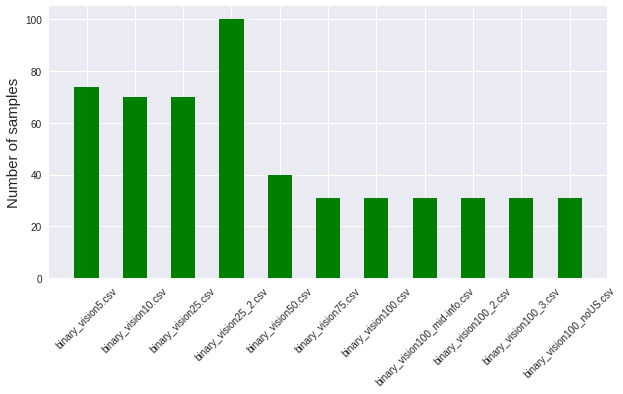

In [ ]:
samples = []
for train in binary_vision_train:
  samples.append(np.size(train,0))

plt.figure(figsize=(10, 5))
plt.rc('font', size=20) 
plt.rc('axes', titlesize=15) #fontsize of the title
plt.rc('axes', labelsize=15)
#plt.rc('xtick', labelsize=15) #fontsize of the x tick labels
#plt.title("Number of samples per batch for Binary Vision tasks")
plt.bar(binary_vision_files, samples, color ='green',
        width = 0.5)
plt.ylabel("Number of samples")
plt.xticks(rotation=45)
#plt.xticks(rotation=90)
print(samples)

#### Accuracy and Thresholds

Calculate the accuracy of the workers for the binary vision tasks. Also calculate the median and average accuracy for use as possible treshold. Try different quantiles (options = [0.1,0.33,0.4,0.6,0.75,0.9] ) as further thresholds.

In [ ]:

binary_vision_accuracy = []
binary_vision_average_accuracy = []
binary_vision_median_accuracy = []
binary_vision_quantile = []


for (true_matrix,answer_matrix) in zip(binary_vision_true,binary_vision_answer):
  
  col = np.size(true_matrix, 1)
  row = np.size(true_matrix, 0)
  accuracy = np.zeros(row)
  j = 0

  for (truth, answer) in zip(true_matrix, answer_matrix):
    for i in range(col):
      if truth[i].lower() == answer[i].lower():
        accuracy[j] += 1
    accuracy[j] /= col
    j += 1

  binary_vision_accuracy.append(accuracy)
  average_accuracy = np.average(accuracy)
  median_accuracy = np.median(accuracy)

  quantile = []
  for q in options:
    quantile.append(np.quantile(accuracy, q))
  
  binary_vision_quantile.append(quantile)
  binary_vision_average_accuracy.append(average_accuracy)
  binary_vision_median_accuracy.append(median_accuracy)



In [ ]:
print(binary_vision_quantile)
print(np.sort(binary_vision_accuracy[8]))

[[0.6, 0.6, 0.8, 0.8, 0.8, 1.0, 1.0], [0.7, 0.8, 0.8, 0.8, 0.8999999999999999, 0.9, 1.0], [0.6400000000000001, 0.76, 0.76, 0.8, 0.8400000000000001, 0.88, 0.92], [0.68, 0.76, 0.8, 0.8, 0.8400000000000001, 0.92, 0.96], [0.618, 0.7349999999999999, 0.7774, 0.8, 0.828, 0.88, 0.92], [0.64, 0.7666666666666666, 0.7866666666666666, 0.8, 0.84, 0.8466666666666667, 0.88], [0.53, 0.615, 0.718, 0.78, 0.82, 0.86, 0.89], [0.59, 0.635, 0.705, 0.76, 0.78, 0.83, 0.86], [0.53, 0.615, 0.718, 0.78, 0.82, 0.86, 0.89], [0.53, 0.6, 0.6480000000000001, 0.7, 0.77, 0.815, 0.87], [0.62, 0.65, 0.689, 0.71, 0.77, 0.8, 0.88]]
[0.49 0.51 0.52 0.53 0.54 0.55 0.61 0.61 0.62 0.7  0.72 0.77 0.78 0.78
 0.78 0.8  0.8  0.82 0.82 0.84 0.85 0.85 0.86 0.86 0.86 0.86 0.89 0.89
 0.9  0.92 0.93]


Determine different quantiles of the accuracy across all the available tasks. We then use this information to make decisions later.

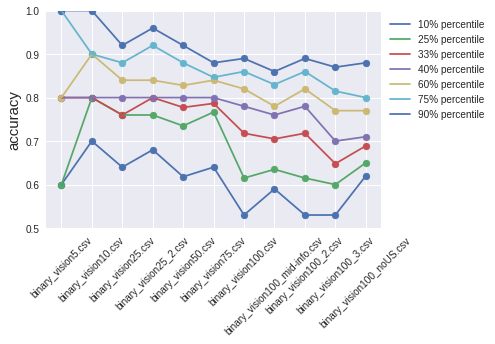

In [ ]:
#0.1,0.25,0.33,0.4,0.6,0.75,0.9
for q in options:
  quantiles = []
  for accuracy in binary_vision_accuracy:
    quantiles.append(np.quantile(accuracy, q))
  #print(quantiles)
  plt.plot(binary_vision_files, quantiles)
  plt.scatter(binary_vision_files, quantiles)
  plt.rc('xtick', labelsize=10) #fontsize of the x tick labels
  #plt.title("Accuracy percentiles per batch for different Binary Vision tasks")
  #plt.xlabel("Batch")
  plt.xticks(rotation=45)
  plt.ylabel("accuracy")
  plt.ylim([0.5,1])
  plt.legend(['10% percentile','25% percentile', '33% percentile', '40% percentile', '60% percentile', '75% percentile', '90% percentile'],bbox_to_anchor=(1,1), loc="upper left")
  plt.show

0.7759262280294537


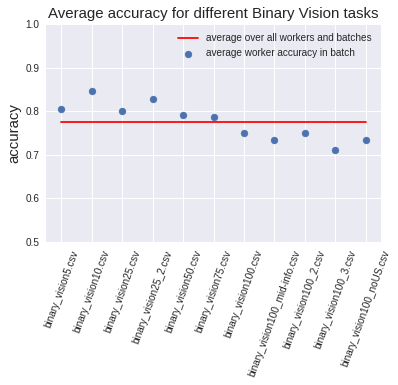

In [ ]:
plt.scatter(binary_vision_files, binary_vision_average_accuracy)
overall_average = np.average(binary_vision_average_accuracy)
plt.rc('xtick', labelsize=10) #fontsize of the x tick labels
plt.plot(binary_vision_files,([overall_average]*11), color="red")
plt.title("Average accuracy for different Binary Vision tasks")
#plt.xlabel("HIT")
plt.rc('xtick', labelsize=10) #fontsize of the x tick labels
plt.xticks(rotation=70)
plt.ylabel("accuracy")
plt.ylim([0.5,1])
plt.legend(["average over all workers and batches","average worker accuracy in batch"])
plt.show

print(overall_average)

0.7862365591397849


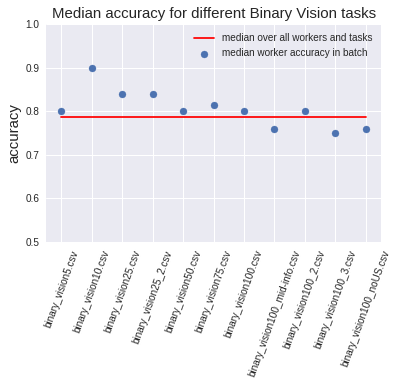

In [ ]:
plt.scatter(binary_vision_files, binary_vision_median_accuracy)
overall_median = np.median(binary_vision_average_accuracy)
plt.plot(binary_vision_files,([overall_median]*np.size(binary_vision_files)), color="red")
plt.title("Median accuracy for different Binary Vision tasks")
#plt.xlabel("HIT")
plt.xticks(rotation=70)
plt.ylabel("accuracy")
plt.ylim([0.5,1])
plt.legend(["median over all workers and tasks","median worker accuracy in batch"])
plt.show
print(overall_median)

#### Approval Rate

One of the features given for each worker is the approval rate, meaning how often the work someone has done previously on MTurk got approved. After a short overview of the raw data, we noticed that for almost every worker this approval rate was 0%, due to them not having done any other task before. We wanted to look more into this and analyzed for those workers who have done at least one other task previously, what their accuracy was.

3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


<function matplotlib.pyplot.show>

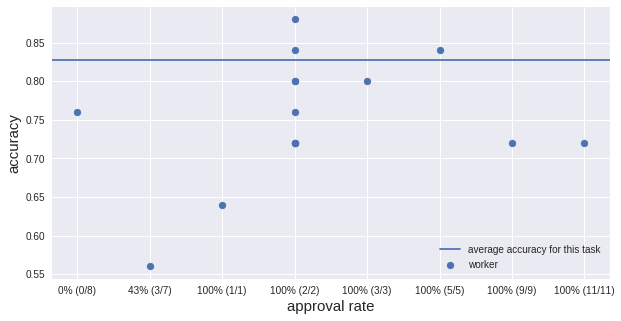

In [ ]:

constant = 0

def rate(item):
  #print(item.split('%')[0])
  return int(item.split('%')[0])

def quotient(item):
  #print(item.split('%')[1].split('(')[1].split('/')[0])
  return int(item.split('%')[1].split('(')[1].split('/')[0])


def approvalRateCompare(item1, item2):
    if rate(item1) < rate(item2):
        return -1
    elif rate(item1) > rate(item2):
        return 1
    elif quotient(item1) < quotient(item2):
        return -1
    elif quotient(item1) > quotient(item2):
        return 1
    else:
        return 0

plt.figure(figsize=(10, 5))

k = -1
for (train_matrix, accuracy, average) in zip(binary_vision_train,binary_vision_accuracy, binary_vision_average_accuracy):

  k+=1
  
  rows = np.size(train_matrix["LifetimeApprovalRate"])
  xAxis = []
  xAxis1 = []
  xAxis2 = []
  yAxis = []
  for i in range(0,rows):
    if train_matrix["LifetimeApprovalRate"][i] != "0% (0/0)" :
      print(k)
      #print(train_matrix['LifetimeApprovalRate'][i], accuracy[i], average)
      xAxis.append(train_matrix["LifetimeApprovalRate"][i])
      xAxis1.append(int(train_matrix["LifetimeApprovalRate"][i].split('%')[0]))
      xAxis2.append(int(train_matrix["LifetimeApprovalRate"][i].split('%')[1].split('(')[1].split('/')[0]))
      yAxis.append(accuracy[i])
      constant = average
  #print(yAxis)
  if np.size(yAxis) != 0:
    data = p.DataFrame(data=list(zip(yAxis,xAxis,xAxis1,xAxis2)) , columns=["y","x","x1","x2"])
    data = data.sort_values(by=["x1","x2"])
    #print(data)

  #xAxis.sort(key=cmp_to_key(approvalRateCompare))
    plt.scatter(data["x"], data["y"])
  #plt.show()

# Calling
#print(xAxis)

#print(xAxis)



plt.axhline(y=constant)
#plt.title("a worker's accuracy vs their non-zero lifetime approval rate")

plt.legend(["average accuracy for this task","worker"], loc='lower right')

plt.ylabel("accuracy")
plt.xlabel("approval rate")
plt.show


Workers who did 2 or more HIT and got an 100% approval rate, have an accuracy of at least 72% and max 88% and the overall average being 82,68%.

Note: worker with 0% approval rate from 8 previous HIT achieves better accuracy as workers with 100% approval rate over 9 HIT and 100% approval rate over 11 HIT

out of 8 files for the binary vision task, only one contained non-zero approval rates

conclusion: due to very few workers having done other tasks and there being no correlation between approval rate and accuracy, this feature will be neglected in further work. 

#### Cognitive Test and Times

Since the task with the cognitive test has the lowest median accuracy of all, we will try to gain info about relation between accuracy and time.

We will also look at other times as completion time for a label, time from loading a task until actually starting it

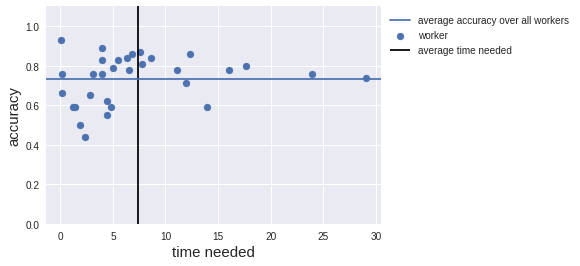

In [ ]:
#print(binary_vision_train[8]["mid-time-approval-time-in-seconds"])

for (train_matrix,accuracy) in zip(binary_vision_train,binary_vision_accuracy):
  if "mid-time-approval-time-in-seconds" in train_matrix:

    #plt.title("a worker's accuracy vs their time needed to do the cognitive test in the middle of the task")
    
    plt.scatter(train_matrix["mid-time-approval-time-in-seconds"], accuracy)
    plt.xlabel("time needed")
    plt.ylabel("accuracy")
    plt.ylim([0,1.1])

    
    plt.axhline(y=average_accuracy)

    average_time = np.average(train_matrix["mid-time-approval-time-in-seconds"])
    plt.vlines(x = average_time , ymin = 0, ymax = 1.1)

    plt.legend(["average accuracy over all workers","worker","average time needed"],bbox_to_anchor=(1,1), loc="upper left")

    #plt.show

In the first quadrant are the workers who take more than average time to complete the cognitive test and achieve and above average accuracy, which would be the expected result. The second quadrant shows workers who despite needing less than average time to complete the test achieve a good accuracy. On the other hand, in third quadrant are those workers who take less time and achieve a lower accuracy, which is also to be expected if there were a correlation. In the fourth quadrant are those workers who take a long time to complete the test achieve a surprisingly low accuracy.

Looking at the graph, a higher time needed is a better metric to classify a worker as honest rather than using a low time to classify them as spammer. Using: if time needed > average then honest worker; achieves an 82% accuracy for honest workers.

On the other hand using: if time needed < average then spammer;
gets an 45% accuracy for spammer prediction, worse than random.


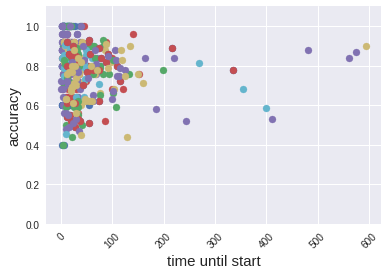

In [ ]:
for i in range(np.size(binary_vision_files)):
  #plt.figure()
  #print(binary_vision_train[i]["load-to-start-seconds"])
  plt.scatter(binary_vision_train[i]["load-to-start-seconds"], binary_vision_accuracy[i])
  #plt.title("a worker's accuracy vs the time needed to start the task")
  plt.xlabel("time until start")
  plt.xticks(rotation=45)
  plt.ylabel("accuracy")
  plt.ylim([0,1.1])
  plt.show

### Binary NLP statistics


#### Sample size

[104, 500, 90, 39, 100, 40, 31, 31, 31]


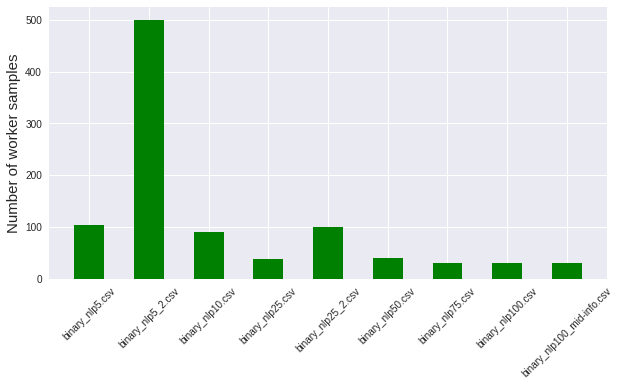

In [ ]:
samples = []
for train in binary_nlp_train:
  samples.append(np.size(train,0))
plt.figure(figsize=(10,5))
#plt.title("Number of worker samples per batch for Binary NLP tasks")
plt.bar(binary_nlp_files, samples, color ='green',
        width = 0.5)
plt.ylabel("Number of worker samples")
plt.xticks(rotation=45)
print(samples)

#### Accuracy and Thresholds

Calculate the accuracy of the workers for the binary nlp tasks. Also calculate the median and average accuracy for use as possible treshold.

In [ ]:
binary_nlp_accuracy = []
binary_nlp_average_accuracy = []
binary_nlp_median_accuracy = []
binary_nlp_quantile = []


for (true_matrix,answer_matrix) in zip(binary_nlp_true,binary_nlp_answer):
  
  col = np.size(true_matrix, 1)
  row = np.size(true_matrix, 0)
  accuracy = np.zeros(row)
  j = 0

  for (truth, answer) in zip(true_matrix, answer_matrix):

    #print(truth)
    #print(answer)
    
    for i in range(col):
      if truth[i] == answer[i]:
        accuracy[j] += 1
      elif (truth[i] == 'Restaurants' and answer[i] == 'Restaurant'):
        accuracy[j] += 1 
    accuracy[j] /= col
    j += 1

  binary_nlp_accuracy.append(accuracy)
  average_accuracy = np.average(accuracy)
  median_accuracy = np.median(accuracy)

  quantile = []
  for q in options:
    quantile.append(np.quantile(accuracy, q))

  binary_nlp_average_accuracy.append(average_accuracy)
  binary_nlp_median_accuracy.append(median_accuracy)
  binary_nlp_quantile.append(quantile)

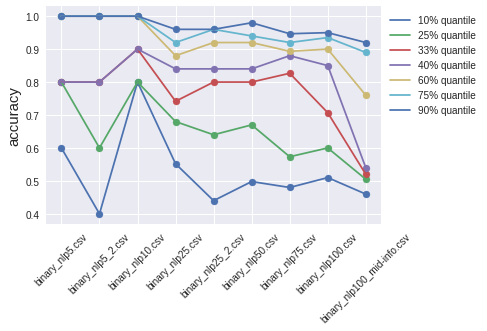

In [ ]:
for q in options:
  quantiles = []
  for accuracy in binary_nlp_accuracy:
    quantiles.append(np.quantile(accuracy, q))
  #print(quantiles)
  plt.plot(binary_nlp_files, quantiles)
  plt.scatter(binary_nlp_files, quantiles)
  #plt.title("Accuracy percentiles for different binary NLP tasks")
  #plt.xlabel("HIT")
  plt.xticks(rotation=45)
  plt.ylabel("accuracy")
  plt.legend(['10% quantile','25% quantile', '33% quantile', '40% quantile', '60% quantile', '75% quantile', '90% quantile'],bbox_to_anchor=(1,1), loc="upper left")
  #plt.ylim([0.5,1.1])
  plt.show

0.6687096774193548
0.824431241876403
0.824431241876403


<function matplotlib.pyplot.show>

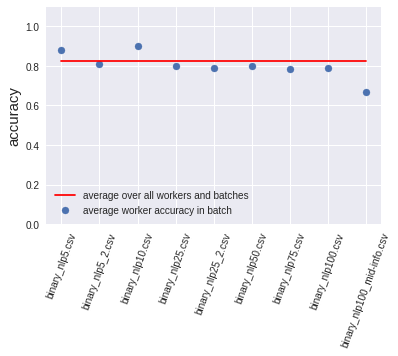

In [ ]:
plt.scatter(binary_nlp_files, binary_nlp_average_accuracy)
overall_average = np.average(binary_nlp_average_accuracy[0:7])
print(binary_nlp_average_accuracy[8])
print(overall_average)
#overall_average = np.average(binary_nlp_average_accuracy)
print(overall_average)
plt.plot(binary_nlp_files,([overall_average]*np.size(binary_nlp_files)), color="red")


#plt.title("average accuracy for different binary nlp tasks")
#plt.xlabel("HIT")
plt.xticks(rotation=70)
plt.ylabel("accuracy")
plt.ylim([0,1.1])
plt.legend(["average over all workers and batches","average worker accuracy in batch"], loc="lower left")
plt.show

0.57
0.8933333333333333
0.89


<function matplotlib.pyplot.show>

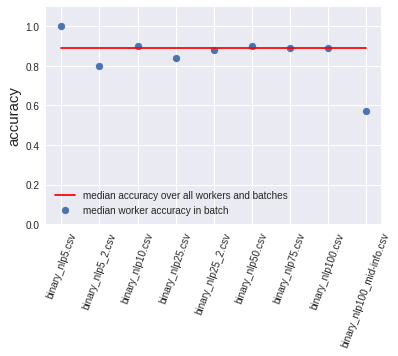

In [ ]:
plt.scatter(binary_nlp_files, binary_nlp_median_accuracy)
overall_median = np.median(binary_nlp_median_accuracy[0:7])
print(binary_nlp_median_accuracy[8])
print(overall_median)
overall_median = np.median(binary_nlp_median_accuracy)
print(overall_median)
plt.plot(binary_nlp_files,([overall_median]*np.size(binary_nlp_files)), color="red")

#plt.title("median accuracy for different binary nlp tasks")
#plt.xlabel("HIT")
plt.xticks(rotation=70)
plt.ylabel("accuracy")
plt.legend(["median accuracy over all workers and batches","median worker accuracy in batch"], loc="lower left")
plt.ylim([0,1.1])
plt.show

#### Approval Rate

<Figure size 720x360 with 0 Axes>

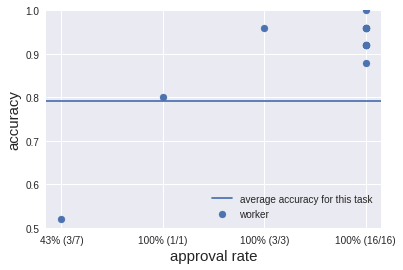

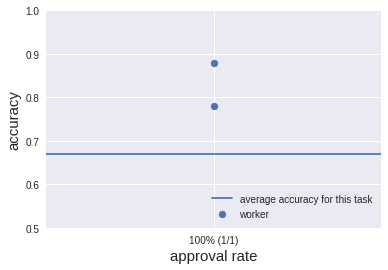

In [ ]:

constant = 0

def rate(item):
  #print(item.split('%')[0])
  return int(item.split('%')[0])

def quotient(item):
  #print(item.split('%')[1].split('(')[1].split('/')[0])
  return int(item.split('%')[1].split('(')[1].split('/')[0])


def approvalRateCompare(item1, item2):
    if rate(item1) < rate(item2):
        return -1
    elif rate(item1) > rate(item2):
        return 1
    elif quotient(item1) < quotient(item2):
        return -1
    elif quotient(item1) > quotient(item2):
        return 1
    else:
        return 0

plt.figure(figsize=(10,5))

for (train_matrix, accuracy, average) in zip(binary_nlp_train,binary_nlp_accuracy, binary_nlp_average_accuracy):
  rows = np.size(train_matrix["LifetimeApprovalRate"])
  xAxis = []
  xAxis1 = []
  xAxis2 = []
  yAxis = []

  for i in range(0,rows):
    if train_matrix["LifetimeApprovalRate"][i] != "0% (0/0)" :
      #print(train_matrix['LifetimeApprovalRate'][i], accuracy[i], average)
      xAxis.append(train_matrix["LifetimeApprovalRate"][i])
      xAxis1.append(int(train_matrix["LifetimeApprovalRate"][i].split('%')[0]))
      xAxis2.append(int(train_matrix["LifetimeApprovalRate"][i].split('%')[1].split('(')[1].split('/')[0]))
      yAxis.append(accuracy[i])
      constant = average

  if np.size(yAxis) != 0:
    data = p.DataFrame(data=list(zip(yAxis,xAxis,xAxis1,xAxis2)) , columns=["y","x","x1","x2"])
    data = data.sort_values(by=["x1","x2"])

  #xAxis.sort(key=cmp_to_key(approvalRateCompare))
    plt.figure()
    plt.scatter(data["x"], data["y"])
    #plt.title("a worker's accuracy vs their non-zero lifetime approval rate")
    
    #x = ["43% (3/7)", "100% (16/16)"]
    #y = [constant, constant]
    #plt.plot(x, y, 'y', linewidth=3)
    plt.ylim([0.5,1])
    plt.axhline(y=constant)
    plt.legend(["average accuracy for this task","worker"], loc='lower right')
    plt.ylabel("accuracy")
    plt.xlabel("approval rate")
    plt.show()


#### Cognitive Test and Times

8


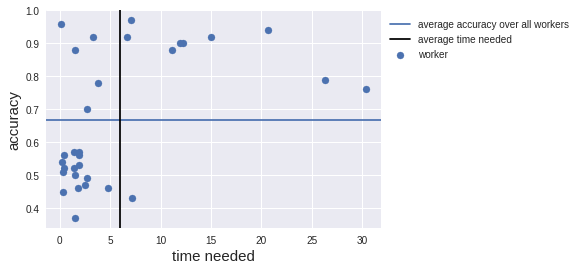

In [ ]:
i = -1
for (train_matrix,accuracy) in zip(binary_nlp_train,binary_nlp_accuracy):

  i += 1

  average_accuracy = 0
  median_accuracy = 0
  if "mid-time-approval-time-in-seconds" in train_matrix:

    print(i)

    #plt.title("a worker's accuracy vs their time needed to do the cognitive test in the middle of the task")
    
    plt.scatter(train_matrix["mid-time-approval-time-in-seconds"], accuracy)
    plt.xlabel("time needed")
    plt.ylabel("accuracy")
    #plt.ylim([0,1.1])

    average_accuracy = np.average(accuracy)
    median_accuracy = np.median(accuracy)
    average_time = np.average(train_matrix["mid-time-approval-time-in-seconds"])
    median_time = np.median(train_matrix["mid-time-approval-time-in-seconds"])

    plt.axhline(y=average_accuracy)
    #plt.axhline(y=median_accuracy)
    #plt.axvline(x=median_time, color="green")
    plt.axvline(x=average_time, color="black")

    plt.legend(["average accuracy over all workers","average time needed","worker"],bbox_to_anchor=(1,1), loc="upper left")

    #plt.show

9/10 workers who spent more than average time on the cognitive test achieve a higher than average accuracy. Attention: this task's average accuracy is much lower than all others

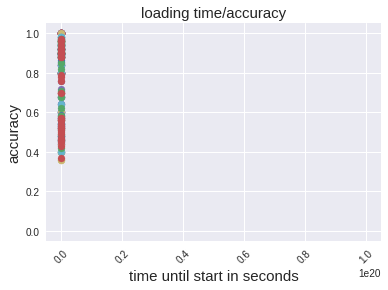

In [ ]:
for i in range(np.size(binary_nlp_files)):
  #print(binary_nlp_train[i]["load-to-start-seconds"])
  #plt.figure()
  plt.scatter(binary_nlp_train[i]["load-to-start-seconds"], binary_nlp_accuracy[i])
  plt.title("loading time/accuracy")
  plt.xlabel("time until start in seconds")
  plt.xticks(rotation=45)
  plt.ylabel("accuracy")
  #plt.ylim([0,1.1])
  plt.show

### Multiclass vision statistics

#### Sample size

[85, 70, 40, 100, 33, 31, 31, 31]


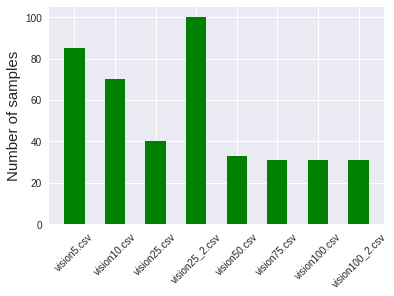

In [ ]:
samples = []
for train in vision_train:
  samples.append(np.size(train,0))
#plt.title("Number of worker samples per batch for Multiclass Vision tasks")
plt.bar(vision_files, samples, color ='green',
        width = 0.5)
plt.ylabel("Number of samples")
plt.xticks(rotation=45)
print(samples)

#### Confusion Matrix

Create a heatmap showcasing the misclass distribution for the mutliclass vision tasks

This confusion matrix shows that a wrong label is usually classified as None instead of the actual class. Excluding that class, it is roughly equally distributed.

Create the confusion matrix for every multiclass nlp task of sizes 5 to 100 APH

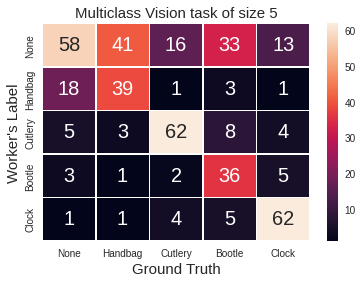

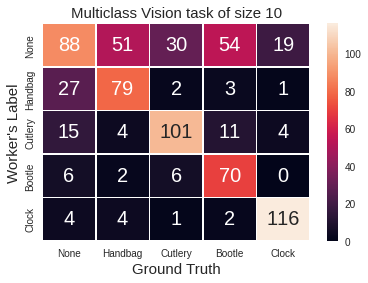

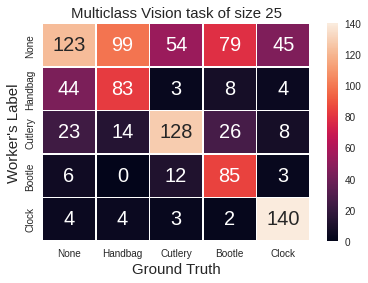

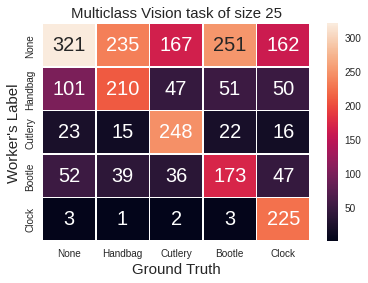

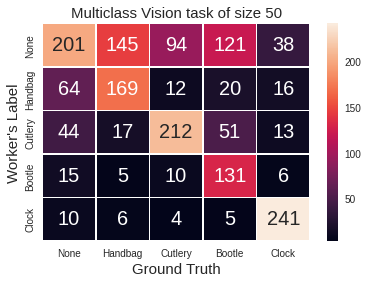

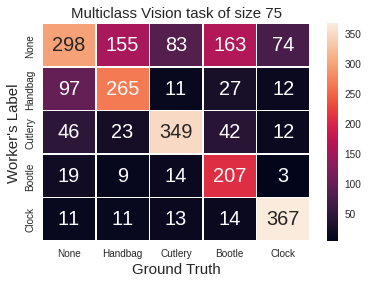

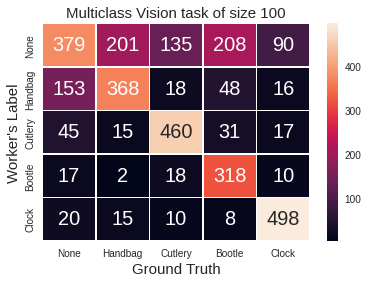

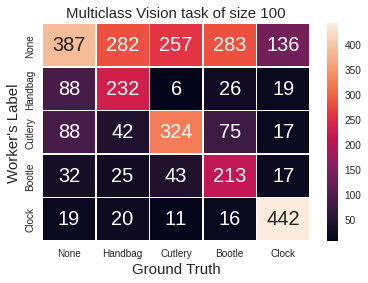

In [ ]:


for (true_matrix, answer_matrix) in zip(vision_true, vision_answer):
  matrix = np.zeros((5,5))

  col = np.size(true_matrix, 1) 
  row = np.size(true_matrix, 0) 
  
  #fill confusion matrix
  for iterCol in range(0,col):
    for iterRow in range(0,row):
      
      i = classFinder(answer_matrix[iterRow,iterCol])
      c = classFinder(true_matrix[iterRow,iterCol])

      matrix[i,c] = matrix[i,c] + 1


  classes = classes_vision
  case = "vision"
  confusion = p.DataFrame(matrix, classes, classes)

  heat_map = sns.heatmap( confusion, linewidth = .5, annot = True, fmt='g')
  plt.title("Multiclass " + str.capitalize(case) + " task of size " + str(col))
  plt.ylabel("Worker's Label", fontsize = 15)
  plt.xlabel('Ground Truth', fontsize = 15)

    
  plt.savefig("images/" + case + str(col) + ".png")
  plt.show()



#### Accuracy, Thresholds and misclass penalties

In [ ]:
vision_accuracy = []
vision_average_accuracy = []
vision_median_accuracy = []
vision_quantile = []

for (true_matrix,answer_matrix) in zip(vision_true,vision_answer):
  
  col = np.size(true_matrix, 1)
  row = np.size(true_matrix, 0)
  accuracy = np.zeros(row)
  j = 0

  for (truth, answer) in zip(true_matrix, answer_matrix):
    for i in range(col):
      if truth[i].lower() == answer[i].lower():
        accuracy[j] += 1
    accuracy[j] /= col
    j += 1

  vision_accuracy.append(accuracy)
  average_accuracy = np.average(accuracy)
  median_accuracy = np.median(accuracy)

  quantile = []
  for q in options:
    quantile.append(np.quantile(accuracy, q))
  
  vision_quantile.append(quantile)
  vision_average_accuracy.append(average_accuracy)
  vision_median_accuracy.append(median_accuracy)


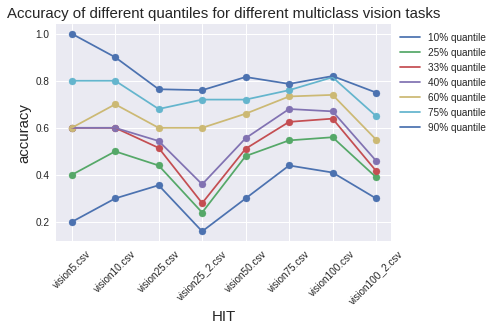

In [ ]:

for q in options:
  quantiles = []
  for accuracy in vision_accuracy:
    quantiles.append(np.quantile(accuracy, q))
  #print(quantiles)
  plt.scatter(vision_files, quantiles)
  plt.plot(vision_files, quantiles)
  plt.title("Accuracy of different quantiles for different multiclass vision tasks")
  plt.xlabel("HIT")
  plt.xticks(rotation=45)
  plt.ylabel("accuracy")
  plt.legend(['10% quantile','25% quantile', '33% quantile', '40% quantile', '60% quantile', '75% quantile', '90% quantile'],bbox_to_anchor=(1,1), loc="upper left")
  #plt.ylim([0.5,1.1])
  plt.show

0.583557928772682


<function matplotlib.pyplot.show>

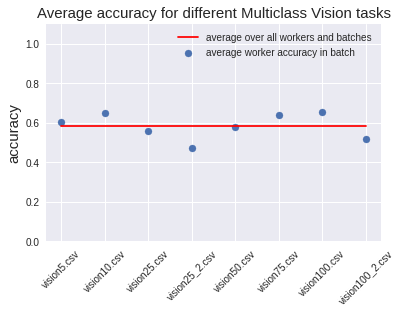

In [ ]:
plt.scatter(vision_files, vision_average_accuracy)

overall_average = np.average(vision_average_accuracy)
plt.plot(vision_files,([overall_average]*np.size(vision_files)), color="red")

print(overall_average)

plt.title("Average accuracy for different Multiclass Vision tasks")
#plt.xlabel("HIT")
plt.xticks(rotation=45)
plt.ylabel("accuracy")
plt.ylim([0,1.1])

plt.legend(["average over all workers and batches","average worker accuracy in batch"])
plt.show

0.5914438502673797


<function matplotlib.pyplot.show>

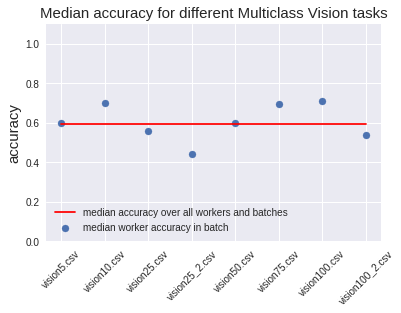

In [ ]:
plt.scatter(vision_files, vision_median_accuracy)
overall_median = np.median(vision_average_accuracy)
plt.plot(vision_files,([overall_median]*np.size(vision_files)), color="red")

print(overall_median)

plt.title("Median accuracy for different Multiclass Vision tasks")
#plt.xlabel("HIT")
plt.xticks(rotation=45)
plt.ylabel("accuracy")
plt.ylim([0,1.1])

plt.legend(["median accuracy over all workers and batches","median worker accuracy in batch"], loc="lower left")
plt.show


Since in the multiclass the difference between two classes is smaller than in the binary class (e.g. "Health & Medical" might be similar to "Fitness & Instruction), we want to introduce a penalty with different weights depending on the misclassification, instead of an overall 0-1 penalty depending on true or false.

Using the confusion matrices from before, we came to the following decision: 


                                  Answer
                        None Handbag Cutlery Bottle Clock
              None       0      1       2      3      3
              Handbag    1      0       3      3      3
Ground Truth  Cutlery    1      3       0      3      3
              Bootle     1      3       2      0      3
              Clock      1      3       3      3      0 



This means e.g. if the truth is the class Bottle and the worker labeled it Cuttlery, that worker will receive a penalty of 2, if instead the label was Handbag, it will be a penalty of 3


In [ ]:
vision_penalties_matrix = [[0,1,2,3,3], [1,0,3,3,3],[1,3,0,3,3],[1,3,2,0,3],[1,3,3,3,0]]
#print(vision_penalties[0][1])

#print(classFinder("None"))

vision_penalty = []
vision_average_penalty = []
vision_median_penalty = []

for (true_matrix,answer_matrix) in zip(vision_true,vision_answer):
  col = np.size(true_matrix,1)
  row = np.size(answer_matrix,0)
  penalty = np.zeros(row)
  j = 0

  for (truth,answer) in zip(true_matrix, answer_matrix):
    #print(answer)
    p = 0
    for i in range(col):
      p += vision_penalties_matrix[classFinder(truth[i])][classFinder(answer[i])]
    penalty[j] += p
    j += 1

  vision_penalty.append(penalty) 
  vision_average_penalty.append(np.average(penalty))
  vision_median_penalty.append(np.median(penalty))
  #print(penalty)
print(vision_average_penalty)




[2.929411764705882, 5.0, 15.8, 20.92, 32.39393939393939, 41.45161290322581, 51.0, 72.61290322580645]


In [ ]:
train_temp = []
for (train_matrix,penalty) in zip(vision_train,vision_penalty):
  train_temp.append(train_matrix.assign(misclass_penalty=penalty))
vision_train = train_temp

Using the above calculated penalties, use the average and median as threshold for spammer detection

In [ ]:
spamming_workers_vision_average_penalty = []
spamming_workers_vision_median_penalty = []

for (task, average_penalty, median_penalty) in zip(vision_penalty, vision_average_penalty, vision_median_penalty):
  spammer_average = []
  spammer_median = []

  for worker in task:
    spammer_average.append(int(worker>average_penalty))
    spammer_median.append(int(worker>median_penalty))
  
  spamming_workers_vision_average_penalty.append(spammer_average)
  spamming_workers_vision_median_penalty.append(spammer_median)

  print(spammer_average)


[0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0]
[0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]
[1, 0, 0, 0

In [ ]:
for spammers in spamming_workers_vision_average_penalty:
  sum = np.sum(spammers)
  total = np.size(spammers)
  print(sum/total)

0.4235294117647059
0.3
0.4
0.32
0.42424242424242425
0.25806451612903225
0.3225806451612903
0.3870967741935484


#### Approval Rate

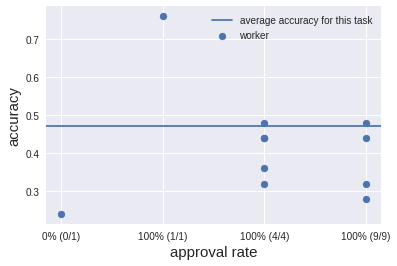

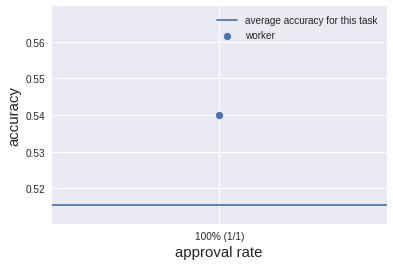

In [ ]:
import pandas as p

constant = 0

def rate(item):
  #print(item.split('%')[0])
  return int(item.split('%')[0])

def quotient(item):
  #print(item.split('%')[1].split('(')[1].split('/')[0])
  return int(item.split('%')[1].split('(')[1].split('/')[0])


def approvalRateCompare(item1, item2):
    if rate(item1) < rate(item2):
        return -1
    elif rate(item1) > rate(item2):
        return 1
    elif quotient(item1) < quotient(item2):
        return -1
    elif quotient(item1) > quotient(item2):
        return 1
    else:
        return 0


for (train_matrix, accuracy, average) in zip(vision_train,vision_accuracy, vision_average_accuracy):
  rows = np.size(train_matrix["LifetimeApprovalRate"])
  xAxis = []
  xAxis1 = []
  xAxis2 = []
  yAxis = []
  

  for i in range(0,rows):
      if train_matrix["LifetimeApprovalRate"][i] != "0% (0/0)" :
        #print(train_matrix['LifetimeApprovalRate'][i], accuracy[i], average)
        xAxis.append(train_matrix["LifetimeApprovalRate"][i])
        xAxis1.append(int(train_matrix["LifetimeApprovalRate"][i].split('%')[0]))
        xAxis2.append(int(train_matrix["LifetimeApprovalRate"][i].split('%')[1].split('(')[1].split('/')[0]))
        yAxis.append(accuracy[i])
        constant = average

  if np.size(yAxis) != 0:
    data = p.DataFrame(data=list(zip(yAxis,xAxis,xAxis1,xAxis2)) , columns=["y","x","x1","x2"])
    data = data.sort_values(by=["x1","x2"])
    plt.figure()
    plt.scatter(data["x"], data["y"])
    plt.ylabel("accuracy")
    plt.xlabel("approval rate")
    #plt.title("a worker's accuracy vs their non-zero lifetime approval rate")

    plt.axhline(y=constant)
    plt.legend(["average accuracy for this task","worker"])
    plt.show()


#### Cognitive Test and Times

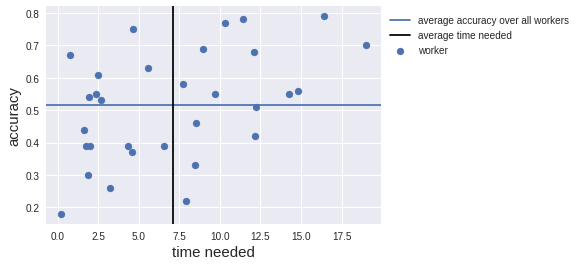

In [ ]:
for (train_matrix,accuracy) in zip(vision_train,vision_accuracy):
  if "mid-time-approval-time-in-seconds" in train_matrix:

    plt.figure
    #plt.title("a worker's accuracy vs their time needed to do the cognitive test in the middle of the task")
    
    plt.scatter(train_matrix["mid-time-approval-time-in-seconds"], accuracy)
    plt.xlabel("time needed")
    plt.ylabel("accuracy")
    #plt.ylim([0,1.1])

    plt.axhline(y=average_accuracy)
  
    average_time = np.average(train_matrix["mid-time-approval-time-in-seconds"])
    plt.axvline(x=average_time, color="black")

    plt.legend(["average accuracy over all workers","average time needed","worker"],bbox_to_anchor=(1,1), loc="upper left")

    plt.show

0     45.639
1     39.713
2      5.756
3      4.093
4      3.164
       ...  
80       NaN
81       NaN
82       NaN
83       NaN
84       NaN
Name: load-to-start-seconds, Length: 85, dtype: float64
0     11.638
1     17.710
2     30.645
3      7.905
4     11.079
       ...  
65       NaN
66       NaN
67       NaN
68       NaN
69       NaN
Name: load-to-start-seconds, Length: 70, dtype: float64
0     95.759
1     12.797
2     90.451
3     30.473
4     46.678
5     28.437
6     16.591
7     37.956
8     12.560
9     11.869
10    58.135
11    26.643
12    33.206
13    47.572
14    48.407
15     3.293
16    27.642
17    36.290
18    15.811
19    56.659
20    45.689
21    16.914
22    28.092
23    29.309
24    18.883
25    28.646
26    19.489
27    25.417
28    29.049
29    19.079
30    24.583
31       NaN
32       NaN
33       NaN
34       NaN
35       NaN
36       NaN
37       NaN
38       NaN
39       NaN
Name: load-to-start-seconds, dtype: float64
0      5.666
1     39.103
2     16.804

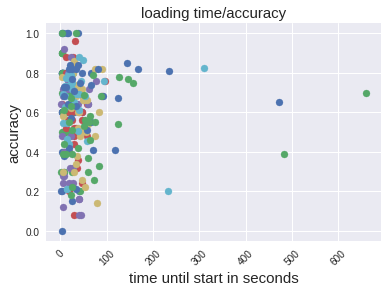

In [ ]:
for i in range(np.size(vision_files)):
  print(vision_train[i]["load-to-start-seconds"])
  #plt.figure()
  plt.scatter(vision_train[i]["load-to-start-seconds"], vision_accuracy[i])
  plt.title("loading time/accuracy")
  plt.xlabel("time until start in seconds")
  plt.xticks(rotation=45)
  plt.ylabel("accuracy")
  #plt.ylim([0,1.1])
  plt.show

### Mutliclass NLP


#### Sample size

[105, 75, 40, 100, 40, 31, 31, 31, 31]


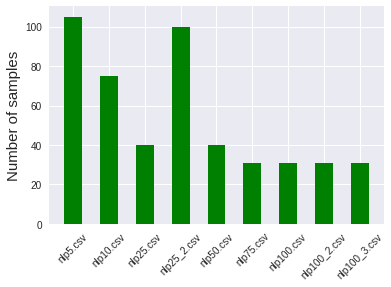

In [ ]:
samples = []
for train in nlp_train:
  samples.append(np.size(train,0))
#plt.title("Number of worker samples per batch for Multiclass NLP tasks")
plt.bar(nlp_files, samples, color ='green',
        width = 0.5)
plt.ylabel("Number of samples")
plt.xticks(rotation=45)
print(samples)

#### Confusion Matrix

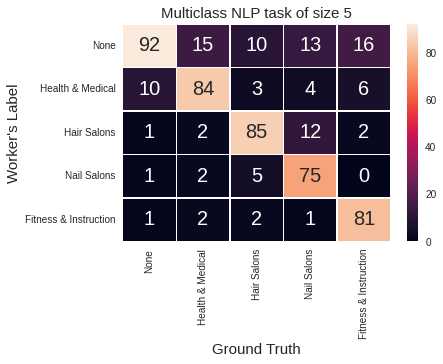

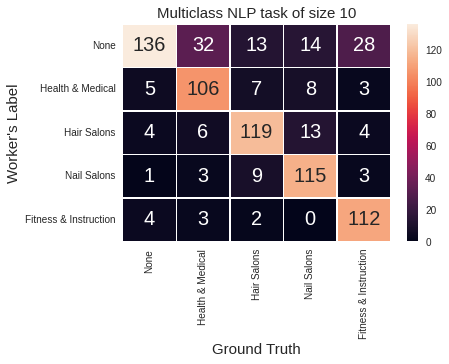

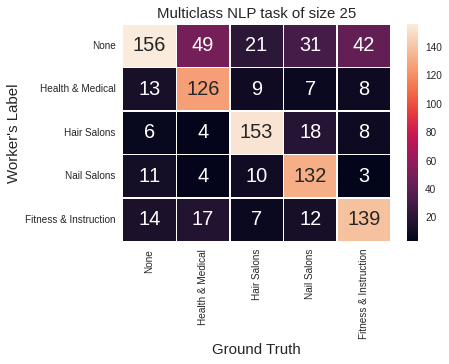

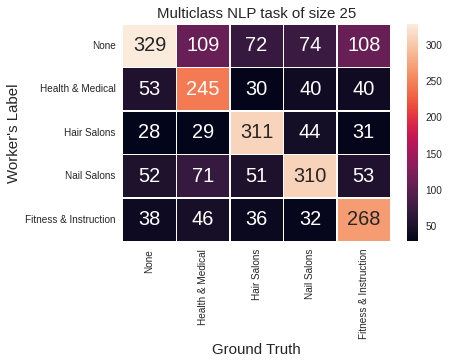

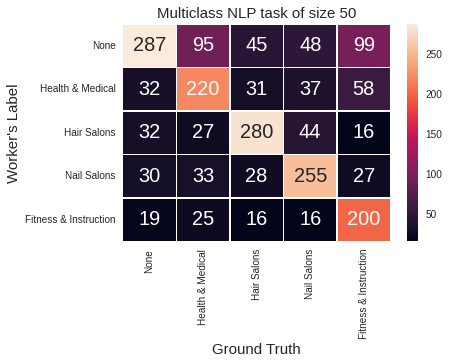

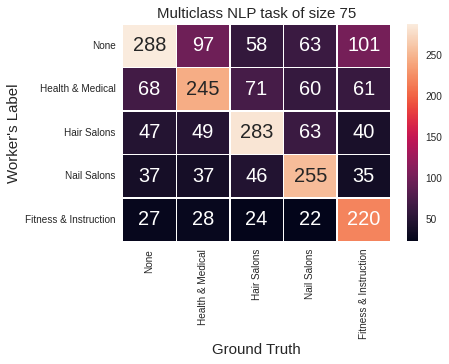

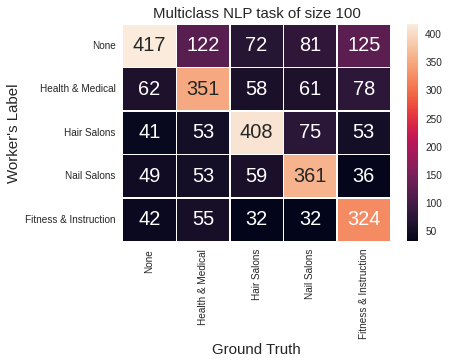

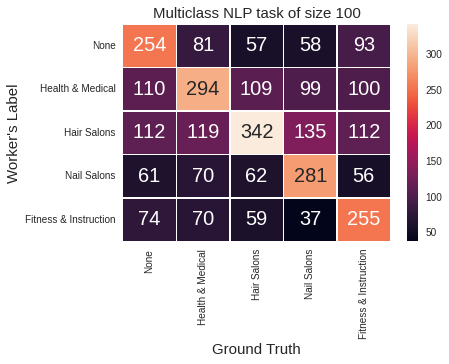

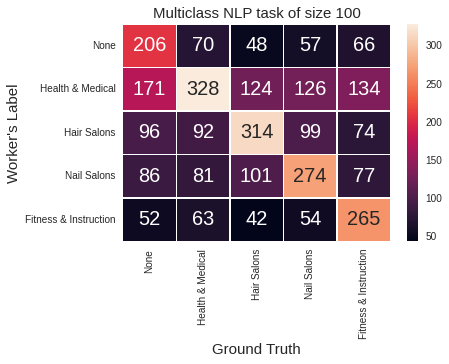

In [ ]:
for (true_matrix, answer_matrix) in zip(nlp_true, nlp_answer):
  matrix = np.zeros((5,5))

  col = np.size(true_matrix, 1) 
  row = np.size(true_matrix, 0) 
  
  #fill confusion matrix
  for iterCol in range(0,col):
    for iterRow in range(0,row):
      
      i = classFinder(answer_matrix[iterRow,iterCol])
      c = classFinder(true_matrix[iterRow,iterCol])

      matrix[i,c] = matrix[i,c] + 1


  classes = classes_nlp
  case = "nlp"
  confusionNLP = p.DataFrame(matrix, classes, classes)

  heat_map = sns.heatmap( confusionNLP, linewidth = .5, annot = True, fmt='g')
  plt.title("Multiclass " + str.upper(case) + " task of size " + str(col))
  plt.ylabel("Worker's Label", fontsize = 15)
  plt.xlabel('Ground Truth', fontsize = 15)

    
  plt.savefig("images/" + case + str(col) + ".png")
  plt.show()


#### Accuracy, Thresholds and misclass penalties

In [ ]:
nlp_accuracy = []
nlp_average_accuracy = []
nlp_median_accuracy = []
nlp_quantile = []

for (true_matrix,answer_matrix) in zip(nlp_true,nlp_answer):
  
  col = np.size(true_matrix, 1)
  row = np.size(true_matrix, 0)
  accuracy = np.zeros(row)
  j = 0

  for (truth, answer) in zip(true_matrix, answer_matrix):
    for i in range(col):
      if truth[i].lower() == answer[i].lower():
        accuracy[j] += 1
    accuracy[j] /= col
    j += 1

  nlp_accuracy.append(accuracy)
  average_accuracy = np.average(accuracy)
  median_accuracy = np.median(accuracy)

  quantile = []
  for q in options:
    quantile.append(np.quantile(accuracy, q))
  
  nlp_quantile.append(quantile)
  nlp_average_accuracy.append(average_accuracy)
  nlp_median_accuracy.append(median_accuracy)


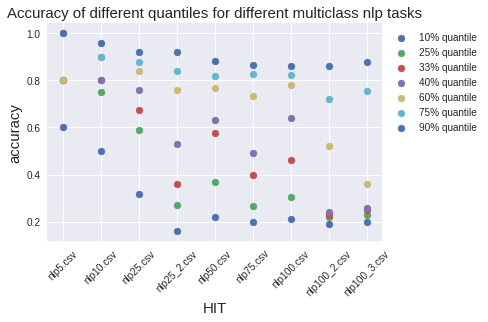

In [ ]:
for q in options:
  quantiles = []
  for accuracy in nlp_accuracy:
    quantiles.append(np.quantile(accuracy, q))
  #print(quantiles)
  plt.scatter(nlp_files, quantiles)
  plt.title("Accuracy of different quantiles for different multiclass nlp tasks")
  plt.xlabel("HIT")
  plt.xticks(rotation=45)
  plt.ylabel("accuracy")
  plt.legend(['10% quantile','25% quantile', '33% quantile', '40% quantile', '60% quantile', '75% quantile', '90% quantile'],bbox_to_anchor=(1,1), loc="upper left")
  #plt.ylim([0.5,1.1])
  plt.show

0.6170551629970985


<function matplotlib.pyplot.show>

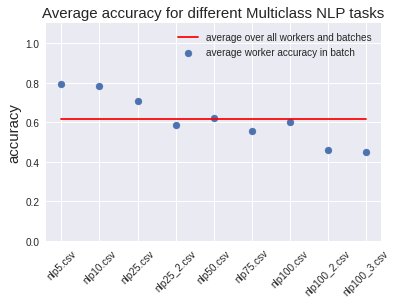

In [ ]:
plt.scatter(nlp_files, nlp_average_accuracy)

overall_average = np.average(nlp_average_accuracy)
plt.plot(nlp_files,([overall_average]*np.size(nlp_files)), color="red")

print(overall_average)

plt.title("Average accuracy for different Multiclass NLP tasks")
#plt.xlabel("HIT")
plt.xticks(rotation=45)
plt.ylabel("accuracy")
plt.ylim([0,1.1])

plt.legend(["average over all workers and batches","average worker accuracy in batch"])
plt.show

0.6003225806451613


<function matplotlib.pyplot.show>

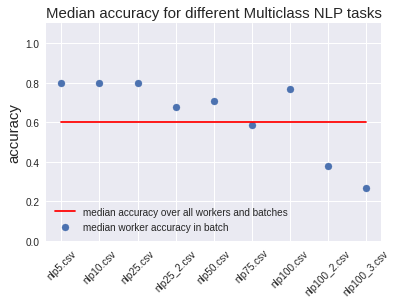

In [ ]:
plt.scatter(nlp_files, nlp_median_accuracy)
overall_median = np.median(nlp_average_accuracy)
plt.plot(nlp_files,([overall_median]*np.size(nlp_files)), color="red")

print(overall_median)

plt.title("Median accuracy for different Multiclass NLP tasks")
#plt.xlabel("HIT")
plt.xticks(rotation=45)
plt.ylabel("accuracy")
plt.ylim([0,1.1])

plt.legend(["median accuracy over all workers and batches","median worker accuracy in batch"], loc="lower left")
plt.show

In [ ]:
nlp_penalties_matrix = [[0,1,2,2,3], [1,0,2,2,2],[1,1,0,2,3],[1,1,1,0,3],[1,2,3,3,0]]
#print(vision_penalties[0][1])

#print(classFinder("None"))

nlp_penalty = []
nlp_average_penalty = []
nlp_median_penalty = []

for (true_matrix,answer_matrix) in zip(nlp_true,nlp_answer):
  col = np.size(true_matrix,1)
  row = np.size(answer_matrix,0)
  penalty = np.zeros(row)
  j = 0

  for (truth,answer) in zip(true_matrix, answer_matrix):
    #print(answer)
    p = 0
    for i in range(col):
      p += nlp_penalties_matrix[classFinder(truth[i])][classFinder(answer[i])]
    penalty[j] += p
    j += 1

  nlp_penalty.append(penalty) 
  nlp_average_penalty.append(np.average(penalty))
  nlp_median_penalty.append(np.median(penalty))
  #print(penalty)
print(nlp_average_penalty)


[1.3238095238095238, 2.8933333333333335, 11.05, 17.34, 29.475, 52.74193548387097, 65.06451612903226, 94.96774193548387, 95.61290322580645]


In [ ]:
train_temp = []
for (train_matrix,penalty) in zip(nlp_train,nlp_penalty):
  train_temp.append(train_matrix.assign(misclass_penalty=penalty))
nlp_train = train_temp

In [ ]:
print(nlp_train)

[     WorkTimeInSeconds  ... misclass_penalty
0                  108  ...              3.0
1                   29  ...              0.0
2                   55  ...              2.0
3                   63  ...              0.0
4                   54  ...              5.0
..                 ...  ...              ...
100                 94  ...              3.0
101                 70  ...              0.0
102                116  ...              5.0
103                 90  ...              2.0
104                 48  ...              1.0

[105 rows x 21 columns],     WorkTimeInSeconds  ... misclass_penalty
0                  52  ...              1.0
1                  56  ...              2.0
2                 104  ...              0.0
3                  42  ...              1.0
4                 167  ...              0.0
..                ...  ...              ...
70                 53  ...              4.0
71                 99  ...              4.0
72                120  ...           

In [ ]:
spamming_workers_nlp_average_penalty = []
spamming_workers_nlp_median_penalty = []

for (task, average_penalty, median_penalty) in zip(nlp_penalty, nlp_average_penalty, nlp_median_penalty):
  spammer_average = []
  spammer_median = []

  for worker in task:
    spammer_average.append(int(worker>average_penalty))
    spammer_median.append(int(worker>median_penalty))
  
  spamming_workers_nlp_average_penalty.append(spammer_average)
  spamming_workers_nlp_median_penalty.append(spammer_median)

  print(spammer_average)

[1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0]
[0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0]
[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,

In [ ]:
for spammers in spamming_workers_nlp_average_penalty:
  sum = np.sum(spammers)
  total = np.size(spammers)
  print(sum/total)

0.3047619047619048
0.3333333333333333
0.25
0.38
0.325
0.41935483870967744
0.3870967741935484
0.5161290322580645
0.6129032258064516


#### Approval Rate

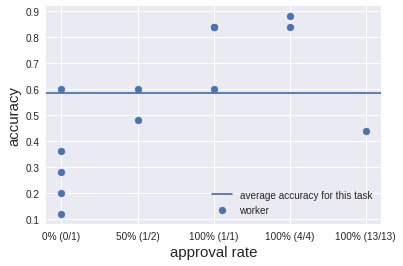

In [ ]:
import pandas as p

constant = 0

def rate(item):
  #print(item.split('%')[0])
  return int(item.split('%')[0])

def quotient(item):
  #print(item.split('%')[1].split('(')[1].split('/')[0])
  return int(item.split('%')[1].split('(')[1].split('/')[0])


def approvalRateCompare(item1, item2):
    if rate(item1) < rate(item2):
        return -1
    elif rate(item1) > rate(item2):
        return 1
    elif quotient(item1) < quotient(item2):
        return -1
    elif quotient(item1) > quotient(item2):
        return 1
    else:
        return 0


for (train_matrix, accuracy, average) in zip(nlp_train,nlp_accuracy, nlp_average_accuracy):
  rows = np.size(train_matrix["LifetimeApprovalRate"])
  xAxis = []
  xAxis1 = []
  xAxis2 = []
  yAxis = []
  

  for i in range(0,rows):
      if train_matrix["LifetimeApprovalRate"][i] != "0% (0/0)" :
        #print(train_matrix['LifetimeApprovalRate'][i], accuracy[i], average)
        xAxis.append(train_matrix["LifetimeApprovalRate"][i])
        xAxis1.append(int(train_matrix["LifetimeApprovalRate"][i].split('%')[0]))
        xAxis2.append(int(train_matrix["LifetimeApprovalRate"][i].split('%')[1].split('(')[1].split('/')[0]))
        yAxis.append(accuracy[i])
        constant = average

  if np.size(yAxis) != 0:
    data = p.DataFrame(data=list(zip(yAxis,xAxis,xAxis1,xAxis2)) , columns=["y","x","x1","x2"])
    data = data.sort_values(by=["x1","x2"])
    plt.figure()
    plt.scatter(data["x"], data["y"])
    #plt.title("a worker's accuracy vs their non-zero lifetime approval rate")

    plt.ylabel("accuracy")
    plt.xlabel("approval rate")
    plt.axhline(y=constant)
    plt.legend(["average accuracy for this task","worker"])
    plt.show()


#### Cognitive Test and Times

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

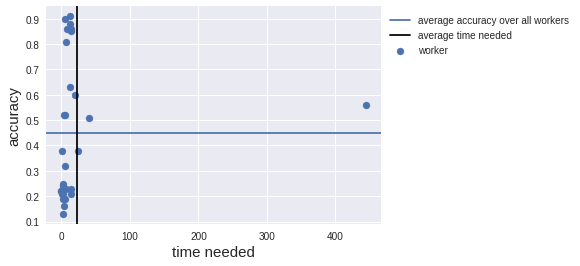

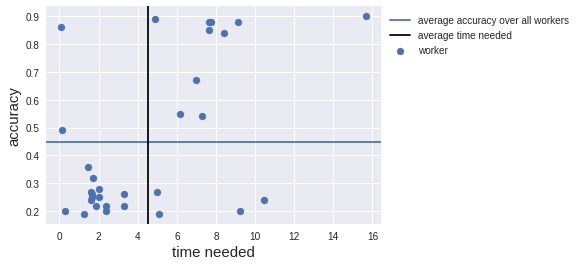

In [ ]:
for (train_matrix,accuracy) in zip(nlp_train,nlp_accuracy):
  plt.figure()
  if "mid-time-approval-time-in-seconds" in train_matrix:

    
    #plt.title("a worker's accuracy vs their time needed to do the cognitive test in the middle of the task")

    plt.scatter(train_matrix["mid-time-approval-time-in-seconds"], accuracy)
    plt.xlabel("time needed")
    plt.ylabel("accuracy")
    #plt.xlim([0,10])

    plt.axhline(y=average_accuracy)
  
    average_time = np.average(train_matrix["mid-time-approval-time-in-seconds"])
    plt.axvline(x=average_time, color="black")

    plt.legend(["average accuracy over all workers","average time needed","worker"],bbox_to_anchor=(1,1), loc="upper left")

  plt.show

0       1.893
1       2.012
2      10.959
3      10.622
4      10.431
        ...  
100       NaN
101       NaN
102       NaN
103       NaN
104       NaN
Name: load-to-start-seconds, Length: 105, dtype: float64
0      2.391
1      2.384
2     10.491
3      3.183
4     27.787
       ...  
70       NaN
71       NaN
72       NaN
73       NaN
74       NaN
Name: load-to-start-seconds, Length: 75, dtype: float64
0     11.677
1     20.640
2     21.368
3     27.242
4     14.145
5     31.398
6      7.462
7     21.841
8     42.311
9     15.759
10     9.235
11    20.765
12     6.323
13    60.542
14    13.033
15    10.932
16    25.472
17    13.905
18     6.371
19    19.264
20    38.568
21    42.938
22     7.721
23     2.108
24    13.312
25    31.413
26    46.786
27     9.056
28    15.424
29    12.453
30    19.784
31       NaN
32       NaN
33       NaN
34       NaN
35       NaN
36       NaN
37       NaN
38       NaN
39       NaN
Name: load-to-start-seconds, dtype: float64
0       6.744
1      34.57

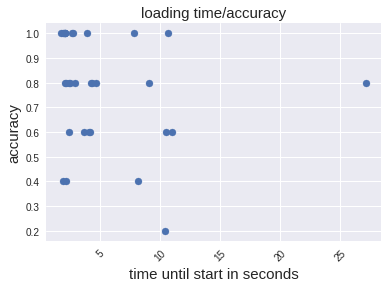

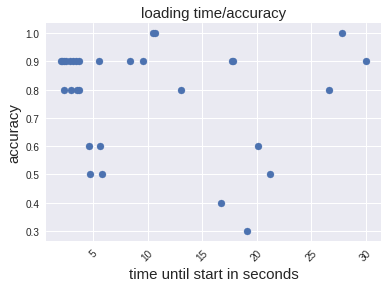

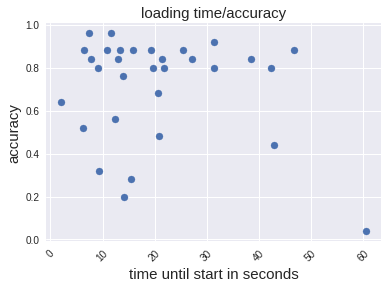

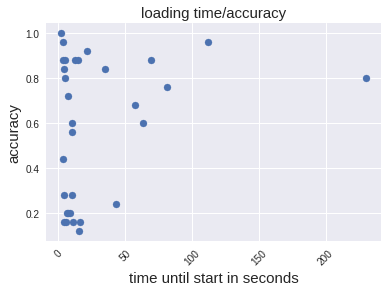

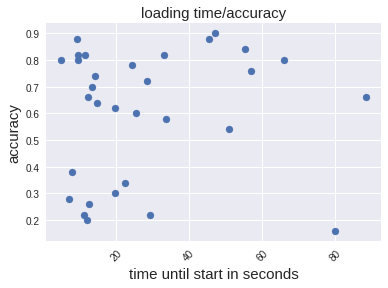

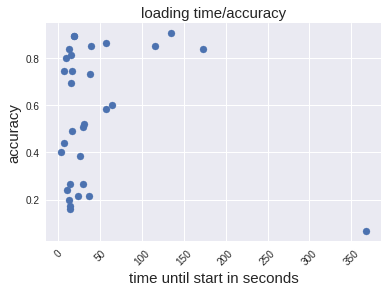

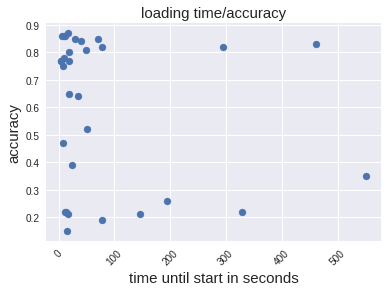

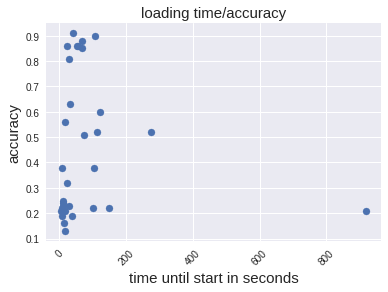

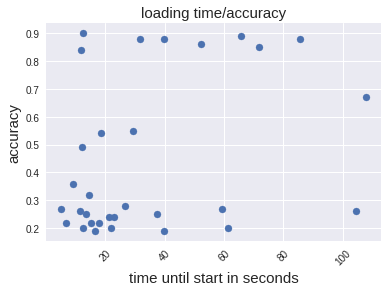

In [ ]:
for i in range(np.size(nlp_files)):
  print(nlp_train[i]["load-to-start-seconds"])
  plt.figure()
  plt.scatter(nlp_train[i]["load-to-start-seconds"], nlp_accuracy[i])
  plt.title("loading time/accuracy")
  plt.xlabel("time until start in seconds")
  plt.xticks(rotation=45)
  plt.ylabel("accuracy")
  #plt.ylim([0,1.1])
  plt.show

## prepare ML task


##### Binary Vision

Using different thresholds label the workers as spammers if their accuracy is below the used threshold.

spamming_workers list collects the label for the different files.
spamming_workers_binary_vision_quantiles is a list containing a list itself for every file and that list contains the decision labels for the different quantiles

spamming_workers_..._random classifies each worker with a 50% chance and spamming_workers_..._random_ratio classifies each worker as honest with 60% and as spammer with 40%. This is derived below, where we look at at the spammer ratio using the different thresholds

In [ ]:

spamming_workers_binary_vision = []
spamming_workers_binary_vision_average = []
spamming_workers_binary_vision_median = []
spamming_workers_binary_vision_fixed = []
spamming_workers_binary_vision_quantiles = []


for (task,median,average,quantiles) in zip(binary_vision_accuracy,binary_vision_median_accuracy,binary_vision_average_accuracy,binary_vision_quantile):
  spammer_fixed = []
  spammer_average = []
  spammer_median = []
  spammer_quantiles = []
  spammer_random = []
  spammer_random_ratio = []

  #print(quantiles)

  threshold_fixed = 0.7
  threshold_median = median
  threshold_average = average


  
  for a in task:
    spammer_fixed.append(int(a<threshold_fixed))
    spammer_average.append(int(a<threshold_average))
    spammer_median.append(int(a<threshold_median))
 
  for q in quantiles:
    decision_quantiles = []
    for a in task:
      #print(q)
      decision_quantiles.append(int(a<q))
    spammer_quantiles.append(decision_quantiles)

  spamming_workers_binary_vision_average.append(spammer_average)
  spamming_workers_binary_vision_median.append(spammer_median)
  spamming_workers_binary_vision_fixed.append(spammer_fixed)
  spamming_workers_binary_vision_quantiles.append(spammer_quantiles)
  #spamming_workers_binary_vision_random.append(spammer_random)
  #spamming_workers_binary_vision_random_ratio.append(spammer_random_ratio)

spamming_workers_binary_vision.append(spamming_workers_binary_vision_average)
spamming_workers_binary_vision.append(spamming_workers_binary_vision_median)
spamming_workers_binary_vision.append(spamming_workers_binary_vision_quantiles)
#spamming_workers_binary_vision.append(spamming_workers_binary_vision_random)
#spamming_workers_binary_vision.append(spamming_workers_binary_vision_random_ratio)



  

<function matplotlib.pyplot.show>

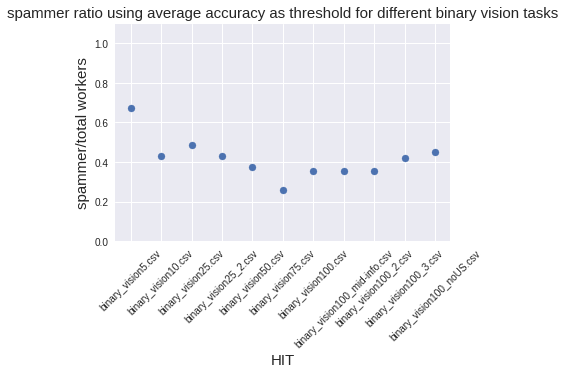

In [ ]:
spammer_ratio_average = []
for i in range(np.size(binary_vision_files,0)):
  total_workers = np.size(spamming_workers_binary_vision_average[i])
  total_spammers = np.sum(spamming_workers_binary_vision_average[i])
  spammer_ratio_average.append(total_spammers/total_workers)

plt.scatter(binary_vision_files, spammer_ratio_average)
plt.title("spammer ratio using average accuracy as threshold for different binary vision tasks")
plt.xlabel("HIT")
plt.xticks(rotation=45)
plt.ylabel("spammer/total workers")
plt.ylim([0,1.1])
plt.show

<function matplotlib.pyplot.show>

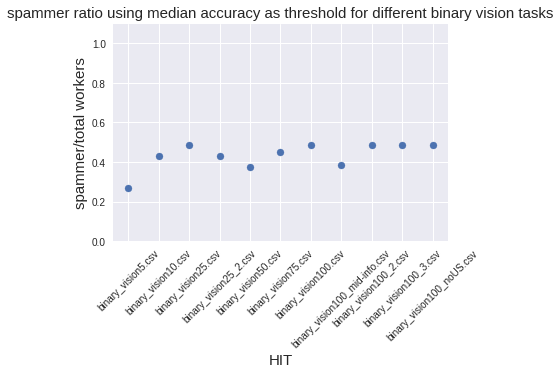

In [ ]:
spammer_ratio_median = []
for i in range(np.size(binary_vision_files,0)):
  #print(spamming_workers_binary_vision[i])
  total_workers = np.size(spamming_workers_binary_vision_median[i])
  total_spammers = np.sum(spamming_workers_binary_vision_median[i])
  spammer_ratio_median.append(total_spammers/total_workers)
  #print(total_spammers/total_workers)

plt.scatter(binary_vision_files, spammer_ratio_median)
plt.title("spammer ratio using median accuracy as threshold for different binary vision tasks")
plt.xlabel("HIT")
plt.xticks(rotation=45)
plt.ylabel("spammer/total workers")
plt.ylim([0,1.1])
plt.show

<function matplotlib.pyplot.show>

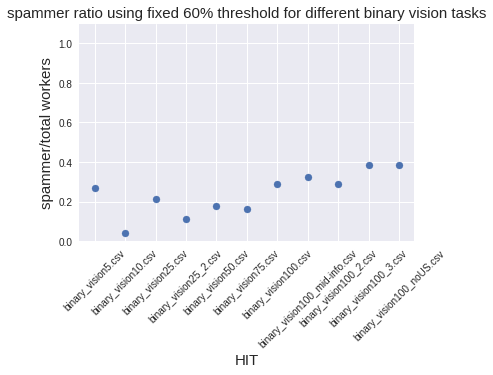

In [ ]:
spammer_ratio_fixed = []
for i in range(np.size(binary_vision_files,0)):
  #print(spamming_workers_binary_vision[i])
  total_workers = np.size(spamming_workers_binary_vision_fixed[i])
  total_spammers = np.sum(spamming_workers_binary_vision_fixed[i])
  spammer_ratio_fixed.append(total_spammers/total_workers)
  #print(total_spammers/total_workers)

plt.scatter(binary_vision_files, spammer_ratio_fixed)
plt.title("spammer ratio using fixed 60% threshold for different binary vision tasks")
plt.xlabel("HIT")
plt.xticks(rotation=45)
plt.ylabel("spammer/total workers")
plt.ylim([0,1.1])
plt.show

<function matplotlib.pyplot.show>

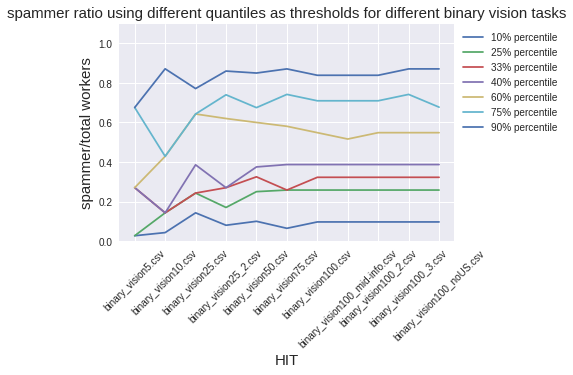

In [ ]:

spammer_ratio_quantiles = []
for task in spamming_workers_binary_vision_quantiles:
  #print(task[0]
  temp = []
  for decision in task:
      #print(decision)
      #print(spamming_workers_binary_vision[i])
      total_workers = np.size(decision)
      total_spammers = np.sum(decision)
      temp.append(total_spammers/total_workers)
  spammer_ratio_quantiles.append(temp)
      #print(total_spammers/total_workers)


plt.plot(binary_vision_files,spammer_ratio_quantiles)
plt.title("spammer ratio using different quantiles as thresholds for different binary vision tasks")
plt.xlabel("HIT")
plt.xticks(rotation=45)
plt.ylabel("spammer/total workers")
plt.ylim([0,1.1])

plt.legend(['10% percentile','25% percentile', '33% percentile', '40% percentile', '60% percentile', '75% percentile', '90% percentile'],bbox_to_anchor=(1,1), loc="upper left")

plt.show

Using a fixed treshold of 60%, workers get labeled as spammers between 2,7% and 19%. 

Using instead the median accuracy of each HIT labels up to 48,57%% as spammers but also as low as 27% of them.

For the average we get up to 67,57% labelled as spammers down to 25,8%. 

Using a high quantile labels naturally leads to high number of labelled spammers.

A good and steady threshold seems to be around 75%

##### Binary NLP

In [ ]:

spamming_workers_binary_nlp = []
spamming_workers_binary_nlp_average = []
spamming_workers_binary_nlp_median = []
spamming_workers_binary_nlp_fixed = []
spamming_workers_binary_nlp_quantiles = []
spamming_workers_binary_nlp_random = []
spamming_workers_binary_nlp_random_ratio = []



for (task,median,average,quantiles) in zip(binary_nlp_accuracy,binary_nlp_median_accuracy,binary_nlp_average_accuracy,binary_nlp_quantile):
  spammer_fixed = []
  spammer_average = []
  spammer_median = []
  spammer_quantiles = []
  spammer_random = []
  spammer_random_ratio = []

  #print(quantiles)

  threshold_fixed = 0.7
  threshold_median = median
  threshold_average = average


  
  for a in task:
    spammer_fixed.append(int(a<threshold_fixed))
    spammer_average.append(int(a<threshold_average))
    spammer_median.append(int(a<threshold_median))
    spammer_random.append(random.randint(0,1))

  spammer_random_ratio = random.choices([0,1], weights=(60,40), k=np.size(task))
 
  for q in quantiles:
    decision_quantiles = []
    for a in task:
      #print(q)
      decision_quantiles.append(int(a<q))
    spammer_quantiles.append(decision_quantiles)

  spamming_workers_binary_nlp_average.append(spammer_average)
  spamming_workers_binary_nlp_median.append(spammer_median)
  spamming_workers_binary_nlp_fixed.append(spammer_fixed)
  spamming_workers_binary_nlp_quantiles.append(spammer_quantiles)
  spamming_workers_binary_nlp_random.append(spammer_random)
  spamming_workers_binary_nlp_random_ratio.append(spammer_random_ratio)

spamming_workers_binary_nlp.append(spamming_workers_binary_nlp_average)
spamming_workers_binary_nlp.append(spamming_workers_binary_nlp_median)
spamming_workers_binary_nlp.append(spamming_workers_binary_nlp_quantiles)
#spamming_workers_binary_nlp.append(spamming_workers_binary_nlp_random)
#spamming_workers_binary_nlp.append(spamming_workers_binary_nlp_random_ratio)



  

<function matplotlib.pyplot.show>

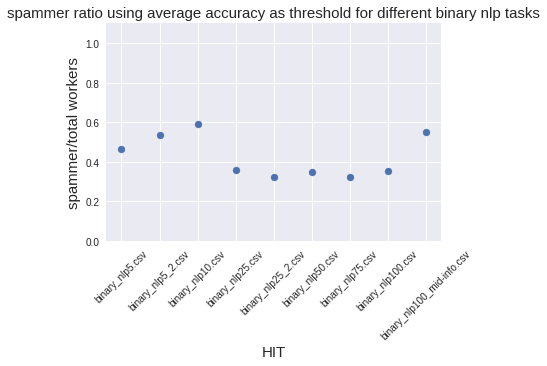

In [ ]:
spammer_ratio_average = []
total_workers = 0
total_spammers = 0
for i in range(np.size(binary_nlp_files,0)):
  #print(spamming_workers_binary_vision[i])
  total_workers = np.size(spamming_workers_binary_nlp_average[i])
  total_spammers = np.sum(spamming_workers_binary_nlp_average[i])
  spammer_ratio_average.append(total_spammers/total_workers)
  #print(total_spammers/total_workers)

plt.scatter(binary_nlp_files, spammer_ratio_average)
plt.title("spammer ratio using average accuracy as threshold for different binary nlp tasks")
plt.xlabel("HIT")
plt.xticks(rotation=45)
plt.ylabel("spammer/total workers")
plt.ylim([0,1.1])
plt.show

<function matplotlib.pyplot.show>

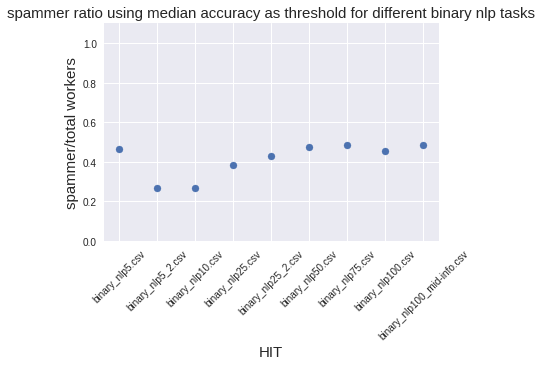

In [ ]:
spammer_ratio_median = []
total_workers = 0
total_spammers = 0
for i in range(np.size(binary_nlp_files,0)):
  #print(spamming_workers_binary_nlp[i])
  total_workers = np.size(spamming_workers_binary_nlp_median[i])
  total_spammers = np.sum(spamming_workers_binary_nlp_median[i])
  spammer_ratio_median.append(total_spammers/total_workers)
  #print(total_spammers/total_workers)

plt.scatter(binary_nlp_files, spammer_ratio_median)
plt.title("spammer ratio using median accuracy as threshold for different binary nlp tasks")
plt.xlabel("HIT")
plt.xticks(rotation=45)
plt.ylabel("spammer/total workers")
plt.ylim([0,1.1])
plt.show

<function matplotlib.pyplot.show>

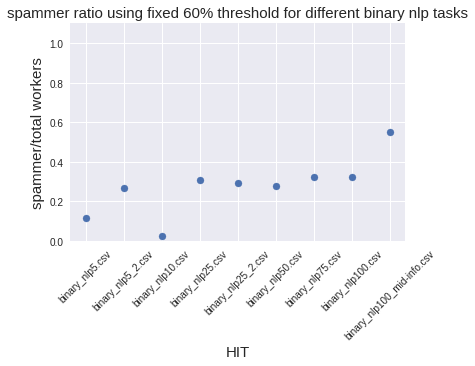

In [ ]:
spammer_ratio_fixed = []
total_workers = 0
total_spammers = 0
for i in range(np.size(binary_nlp_files,0)):
  #print(spamming_workers_binary_nlp[i])
  total_workers = np.size(spamming_workers_binary_nlp_fixed[i])
  total_spammers = np.sum(spamming_workers_binary_nlp_fixed[i])
  spammer_ratio_fixed.append(total_spammers/total_workers)
  #print(total_spammers/total_workers)

plt.scatter(binary_nlp_files, spammer_ratio_fixed)
plt.title("spammer ratio using fixed 60% threshold for different binary nlp tasks")
plt.xlabel("HIT")
plt.xticks(rotation=45)
plt.ylabel("spammer/total workers")
plt.ylim([0,1.1])
plt.show

<function matplotlib.pyplot.show>

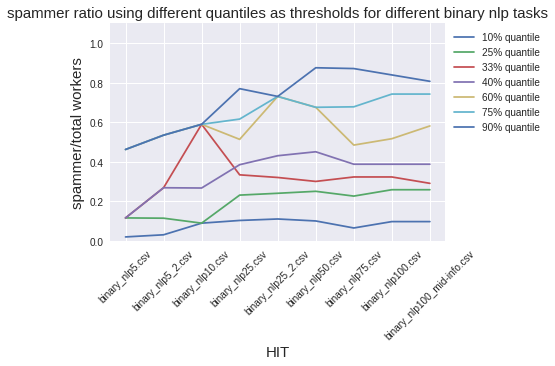

In [ ]:
spammer_ratio_quantiles = []
for task in spamming_workers_binary_nlp_quantiles:
  #print(task[0]
  temp = []
  for decision in task:
      #print(decision)
      #print(spamming_workers_binary_nlp[i])
      total_workers = np.size(decision)
      total_spammers = np.sum(decision)
      temp.append(total_spammers/total_workers)
  spammer_ratio_quantiles.append(temp)
      #print(total_spammers/total_workers)


plt.plot(binary_nlp_files,spammer_ratio_quantiles)
plt.title("spammer ratio using different quantiles as thresholds for different binary nlp tasks")
plt.xlabel("HIT")
plt.xticks(rotation=45)
plt.ylabel("spammer/total workers")
plt.ylim([0,1.1])
plt.legend(['10% quantile','25% quantile', '33% quantile', '40% quantile', '60% quantile', '75% quantile', '90% quantile'],bbox_to_anchor=(1,1), loc="upper left")
plt.show

<function matplotlib.pyplot.show>

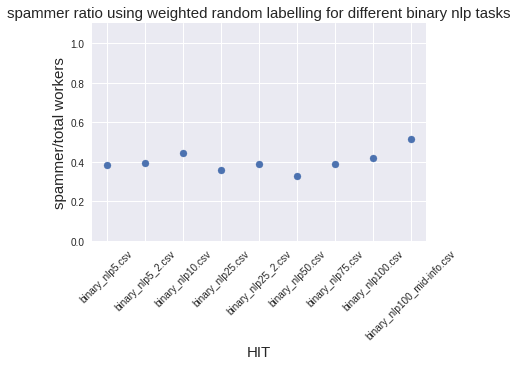

In [ ]:
spammer_ratio_random_ratio = []
total_workers = 0
total_spammers = 0
for i in range(np.size(binary_nlp_files,0)):
  #print(spamming_workers_binary_vision[i])
  total_workers = np.size(spamming_workers_binary_nlp_random_ratio[i])
  total_spammers = np.sum(spamming_workers_binary_nlp_random_ratio[i])
  spammer_ratio_random_ratio.append(total_spammers/total_workers)
  #print(total_spammers/total_workers)

plt.scatter(binary_nlp_files, spammer_ratio_random_ratio)
plt.title("spammer ratio using weighted random labelling for different binary nlp tasks")
plt.xlabel("HIT")
plt.xticks(rotation=45)
plt.ylabel("spammer/total workers")
plt.ylim([0,1.1])
plt.show

##### Multiclass Vision

In [ ]:
#drop misclass_penalty feature
for train in vision_train:
  #print(train)
  train = train.drop(['misclass_penalty'], axis=1)
  print(train)

In [ ]:
spamming_workers_vision = []
spamming_workers_vision_average = []
spamming_workers_vision_median = []
spamming_workers_vision_fixed = []
spamming_workers_vision_quantiles = []
spamming_workers_vision_random = []
spamming_workers_vision_random_ratio = []



for (task,median,average,quantiles) in zip(vision_accuracy,vision_median_accuracy,vision_average_accuracy,vision_quantile):
  spammer_fixed = []
  spammer_average = []
  spammer_median = []
  spammer_quantiles = []
  spammer_random = []
  spammer_random_ratio = []

  #print(quantiles)

  threshold_fixed = 0.5
  threshold_median = median
  threshold_average = average


  
  for a in task:
    spammer_fixed.append(int(a<threshold_fixed))
    spammer_average.append(int(a<threshold_average))
    spammer_median.append(int(a<threshold_median))
    spammer_random.append(random.randint(0,1))

  spammer_random_ratio = random.choices([0,1], weights=(60,40), k=np.size(task))
 
  for q in quantiles:
    decision_quantiles = []
    for a in task:
      #print(q)
      decision_quantiles.append(int(a<q))
    spammer_quantiles.append(decision_quantiles)

  spamming_workers_vision_average.append(spammer_average)
  spamming_workers_vision_median.append(spammer_median)
  spamming_workers_vision_fixed.append(spammer_fixed)
  spamming_workers_vision_quantiles.append(spammer_quantiles)
  spamming_workers_vision_random.append(spammer_random)
  spamming_workers_vision_random_ratio.append(spammer_random_ratio)

spamming_workers_vision.append(spamming_workers_vision_average)
spamming_workers_vision.append(spamming_workers_vision_median)
spamming_workers_vision.append(spamming_workers_vision_quantiles)
spamming_workers_vision.append(spamming_workers_vision_random)
spamming_workers_vision.append(spamming_workers_vision_random_ratio)



  

<function matplotlib.pyplot.show>

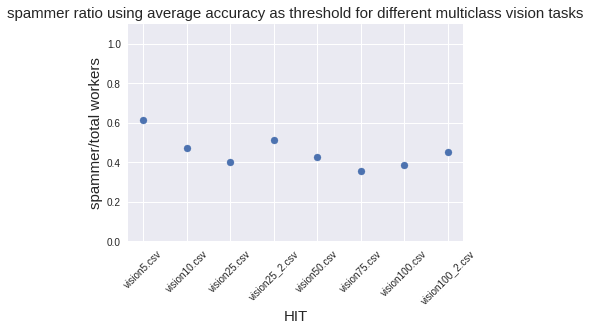

In [ ]:
spammer_ratio_average = []
for i in range(np.size(vision_files,0)):
  #print(spamming_workers_vision[i])
  total_workers = np.size(spamming_workers_vision_average[i])
  total_spammers = np.sum(spamming_workers_vision_average[i])
  spammer_ratio_average.append(total_spammers/total_workers)
  #print(total_spammers/total_workers)

plt.scatter(vision_files, spammer_ratio_average)
plt.title("spammer ratio using average accuracy as threshold for different multiclass vision tasks")
plt.xlabel("HIT")
plt.xticks(rotation=45)
plt.ylabel("spammer/total workers")
plt.ylim([0,1.1])
plt.show

<function matplotlib.pyplot.show>

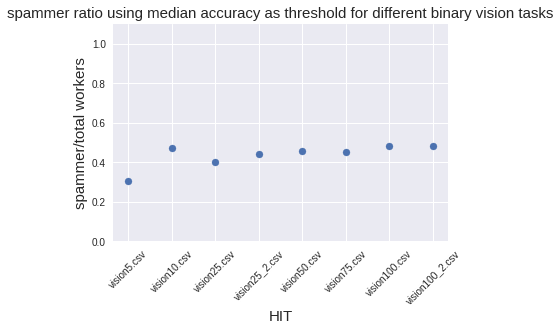

In [ ]:
spammer_ratio_median = []
for i in range(np.size(vision_files,0)):
  #print(spamming_workers_vision[i])
  total_workers = np.size(spamming_workers_vision_median[i])
  total_spammers = np.sum(spamming_workers_vision_median[i])
  spammer_ratio_median.append(total_spammers/total_workers)
  #print(total_spammers/total_workers)

plt.scatter(vision_files, spammer_ratio_median)
plt.title("spammer ratio using median accuracy as threshold for different binary vision tasks")
plt.xlabel("HIT")
plt.xticks(rotation=45)
plt.ylabel("spammer/total workers")
plt.ylim([0,1.1])
plt.show

<function matplotlib.pyplot.show>

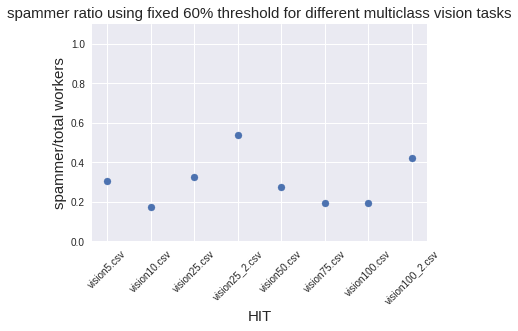

In [ ]:
spammer_ratio_fixed = []
for i in range(np.size(vision_files,0)):
  #print(spamming_workers_vision[i])
  total_workers = np.size(spamming_workers_vision_fixed[i])
  total_spammers = np.sum(spamming_workers_vision_fixed[i])
  spammer_ratio_fixed.append(total_spammers/total_workers)
  #print(total_spammers/total_workers)

plt.scatter(vision_files, spammer_ratio_fixed)
plt.title("spammer ratio using fixed 60% threshold for different multiclass vision tasks")
plt.xlabel("HIT")
plt.xticks(rotation=45)
plt.ylabel("spammer/total workers")
plt.ylim([0,1.1])
plt.show

<function matplotlib.pyplot.show>

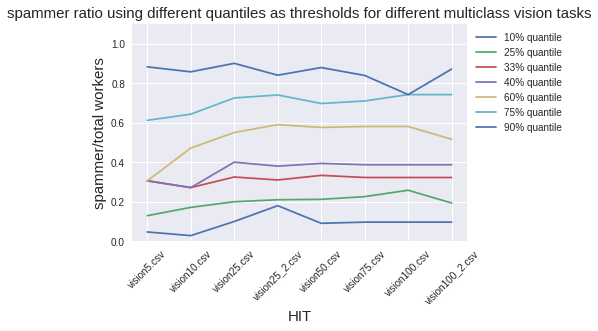

In [ ]:
spammer_ratio_quantiles = []
for task in spamming_workers_vision_quantiles:
  #print(task[0]
  temp = []
  for decision in task:
      #print(decision)
      #print(spamming_workers_vision[i])
      total_workers = np.size(decision)
      total_spammers = np.sum(decision)
      temp.append(total_spammers/total_workers)
  spammer_ratio_quantiles.append(temp)
      #print(total_spammers/total_workers)


plt.plot(vision_files,spammer_ratio_quantiles)
plt.title("spammer ratio using different quantiles as thresholds for different multiclass vision tasks")
plt.xlabel("HIT")
plt.xticks(rotation=45)
plt.ylabel("spammer/total workers")
plt.ylim([0,1.1])
plt.legend(['10% quantile','25% quantile', '33% quantile', '40% quantile', '60% quantile', '75% quantile', '90% quantile'],bbox_to_anchor=(1,1), loc="upper left")
plt.show

<function matplotlib.pyplot.show>

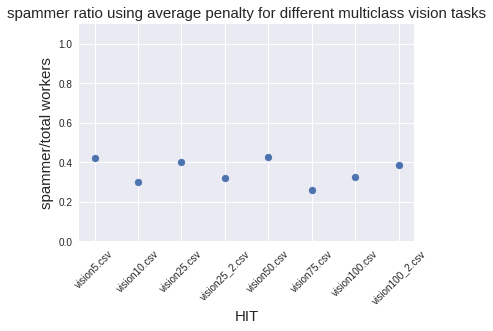

In [ ]:
spammer_ratio_average_penalty = []

for i in range(np.size(vision_files,0)):
  #print(spamming_workers_vision[i])
  total_workers = np.size(spamming_workers_vision_average_penalty[i])
  total_spammers = np.sum(spamming_workers_vision_average_penalty[i])
  spammer_ratio_average_penalty.append(total_spammers/total_workers)
  #print(total_spammers/total_workers)

plt.scatter(vision_files, spammer_ratio_average_penalty)
plt.title("spammer ratio using average penalty for different multiclass vision tasks")
plt.xlabel("HIT")
plt.xticks(rotation=45)
plt.ylabel("spammer/total workers")
plt.ylim([0,1.1])
plt.show

<function matplotlib.pyplot.show>

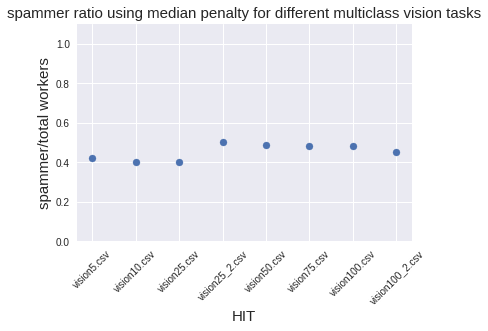

In [ ]:
spammer_ratio_median_penalty = []

for i in range(np.size(vision_files,0)):
  #print(spamming_workers_vision[i])
  total_workers = np.size(spamming_workers_vision_median_penalty[i])
  total_spammers = np.sum(spamming_workers_vision_median_penalty[i])
  spammer_ratio_median_penalty.append(total_spammers/total_workers)
  #print(total_spammers/total_workers)

plt.scatter(vision_files, spammer_ratio_median_penalty)
plt.title("spammer ratio using median penalty for different multiclass vision tasks")
plt.xlabel("HIT")
plt.xticks(rotation=45)
plt.ylabel("spammer/total workers")
plt.ylim([0,1.1])
plt.show

##### Multiclass NLP

In [ ]:
#drop misclass_penalty feature
for train in nlp_train:
  #print(train)
  train = train.drop(['misclass_penalty'], axis=1)
  print(train)

In [ ]:
spamming_workers_nlp = []
spamming_workers_nlp_average = []
spamming_workers_nlp_median = []
spamming_workers_nlp_fixed = []
spamming_workers_nlp_quantiles = []
spamming_workers_nlp_random = []
spamming_workers_nlp_random_ratio = []



for (task,median,average,quantiles) in zip(nlp_accuracy,nlp_median_accuracy,nlp_average_accuracy,nlp_quantile):
  spammer_fixed = []
  spammer_average = []
  spammer_median = []
  spammer_quantiles = []
  spammer_random = []
  spammer_random_ratio = []

  #print(quantiles)

  threshold_fixed = 0.5
  threshold_median = median
  threshold_average = average


  
  for a in task:
    spammer_fixed.append(int(a<threshold_fixed))
    spammer_average.append(int(a<threshold_average))
    spammer_median.append(int(a<threshold_median))
    spammer_random.append(random.randint(0,1))

  spammer_random_ratio = random.choices([0,1], weights=(60,40), k=np.size(task))
 
  for q in quantiles:
    decision_quantiles = []
    for a in task:
      #print(q)
      decision_quantiles.append(int(a<q))
    spammer_quantiles.append(decision_quantiles)

  spamming_workers_nlp_average.append(spammer_average)
  spamming_workers_nlp_median.append(spammer_median)
  spamming_workers_nlp_fixed.append(spammer_fixed)
  spamming_workers_nlp_quantiles.append(spammer_quantiles)
  spamming_workers_nlp_random.append(spammer_random)
  spamming_workers_nlp_random_ratio.append(spammer_random_ratio)

spamming_workers_nlp.append(spamming_workers_nlp_average)
spamming_workers_nlp.append(spamming_workers_nlp_median)
spamming_workers_nlp.append(spamming_workers_nlp_quantiles)
spamming_workers_nlp.append(spamming_workers_nlp_random)
spamming_workers_nlp.append(spamming_workers_nlp_random_ratio)

spamming_workers_nlp_average_penalty = []
spamming_workers_nlp_median_penalty = []

for (task, average_penalty, median_penalty) in zip(nlp_penalty, nlp_average_penalty, nlp_median_penalty):
  spammer_average = []
  spammer_median = []

  for worker in task:
    spammer_average.append(int(worker>average_penalty))
    spammer_median.append(int(worker>median_penalty))
  
  spamming_workers_nlp_average_penalty.append(spammer_average)
  spamming_workers_nlp_median_penalty.append(spammer_median)  

<function matplotlib.pyplot.show>

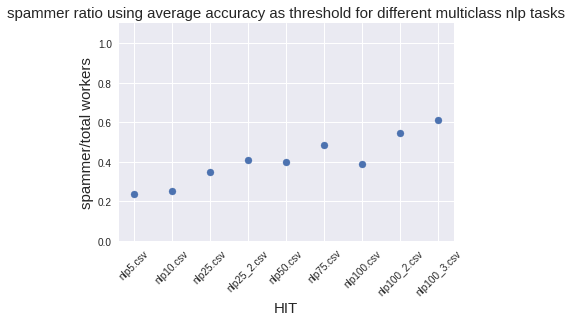

In [ ]:
spammer_ratio_average = []
for i in range(np.size(nlp_files,0)):
  #print(spamming_workers_vision[i])
  total_workers = np.size(spamming_workers_nlp_average[i])
  total_spammers = np.sum(spamming_workers_nlp_average[i])
  spammer_ratio_average.append(total_spammers/total_workers)
  #print(total_spammers/total_workers)

plt.scatter(nlp_files, spammer_ratio_average)
plt.title("spammer ratio using average accuracy as threshold for different multiclass nlp tasks")
plt.xlabel("HIT")
plt.xticks(rotation=45)
plt.ylabel("spammer/total workers")
plt.ylim([0,1.1])
plt.show

<function matplotlib.pyplot.show>

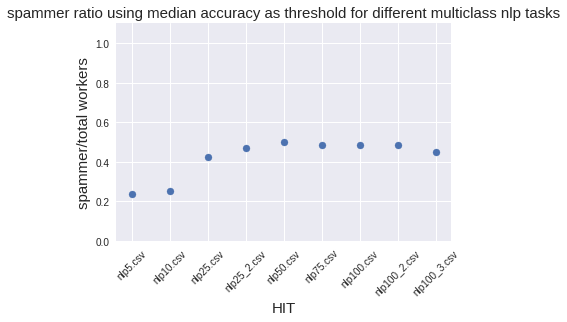

In [ ]:
spammer_ratio_median = []
for i in range(np.size(nlp_files,0)):
  #print(spamming_workers_nlp[i])
  total_workers = np.size(spamming_workers_nlp_median[i])
  total_spammers = np.sum(spamming_workers_nlp_median[i])
  spammer_ratio_median.append(total_spammers/total_workers)
  #print(total_spammers/total_workers)

plt.scatter(nlp_files, spammer_ratio_median)
plt.title("spammer ratio using median accuracy as threshold for different multiclass nlp tasks")
plt.xlabel("HIT")
plt.xticks(rotation=45)
plt.ylabel("spammer/total workers")
plt.ylim([0,1.1])
plt.show

<function matplotlib.pyplot.show>

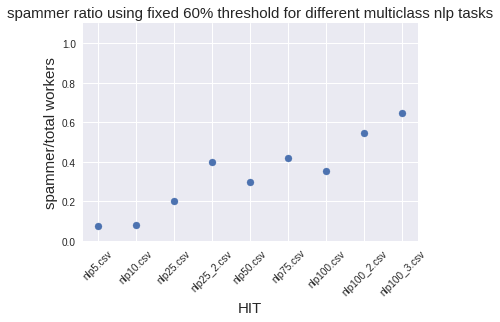

In [ ]:
spammer_ratio_fixed = []
for i in range(np.size(nlp_files,0)):
  #print(spamming_workers_nlp[i])
  total_workers = np.size(spamming_workers_nlp_fixed[i])
  total_spammers = np.sum(spamming_workers_nlp_fixed[i])
  spammer_ratio_fixed.append(total_spammers/total_workers)
  #print(total_spammers/total_workers)

plt.scatter(nlp_files, spammer_ratio_fixed)
plt.title("spammer ratio using fixed 60% threshold for different multiclass nlp tasks")
plt.xlabel("HIT")
plt.xticks(rotation=45)
plt.ylabel("spammer/total workers")
plt.ylim([0,1.1])
plt.show

<function matplotlib.pyplot.show>

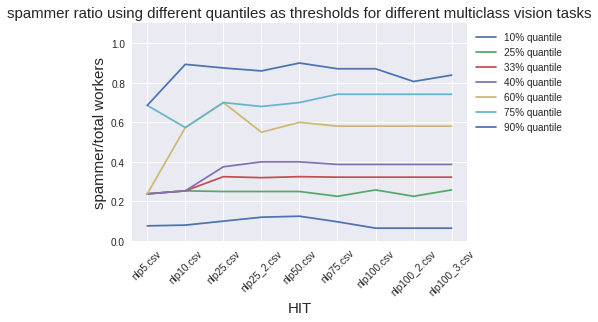

In [ ]:
spammer_ratio_quantiles = []
for task in spamming_workers_nlp_quantiles:
  #print(task[0]
  temp = []
  for decision in task:
      #print(decision)
      #print(spamming_workers_nlp[i])
      total_workers = np.size(decision)
      total_spammers = np.sum(decision)
      temp.append(total_spammers/total_workers)
  spammer_ratio_quantiles.append(temp)
      #print(total_spammers/total_workers)


plt.plot(nlp_files,spammer_ratio_quantiles)
plt.title("spammer ratio using different quantiles as thresholds for different multiclass vision tasks")
plt.xlabel("HIT")
plt.xticks(rotation=45)
plt.ylabel("spammer/total workers")
plt.ylim([0,1.1])
plt.legend(['10% quantile','25% quantile', '33% quantile', '40% quantile', '60% quantile', '75% quantile', '90% quantile'],bbox_to_anchor=(1,1), loc="upper left")
plt.show

<function matplotlib.pyplot.show>

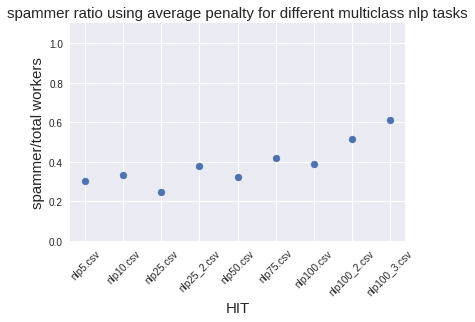

In [ ]:
spammer_ratio_average_penalty = []

for i in range(np.size(nlp_files,0)):
  #print(spamming_workers_nlp[i])
  total_workers = np.size(spamming_workers_nlp_average_penalty[i])
  total_spammers = np.sum(spamming_workers_nlp_average_penalty[i])
  spammer_ratio_average_penalty.append(total_spammers/total_workers)
  #print(total_spammers/total_workers)

plt.scatter(nlp_files, spammer_ratio_average_penalty)
plt.title("spammer ratio using average penalty for different multiclass nlp tasks")
plt.xlabel("HIT")
plt.xticks(rotation=45)
plt.ylabel("spammer/total workers")
plt.ylim([0,1.1])
plt.show

<function matplotlib.pyplot.show>

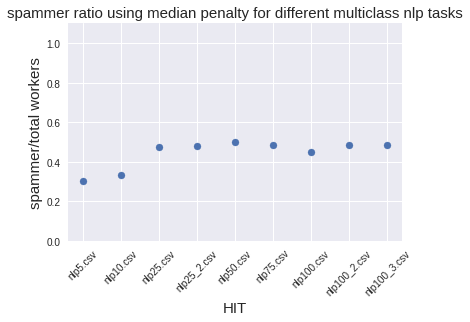

In [ ]:
spammer_ratio_median_penalty = []

for i in range(np.size(nlp_files,0)):
  #print(spamming_workers_nlp[i])
  total_workers = np.size(spamming_workers_nlp_median_penalty[i])
  total_spammers = np.sum(spamming_workers_nlp_median_penalty[i])
  spammer_ratio_median_penalty.append(total_spammers/total_workers)
  #print(total_spammers/total_workers)

plt.scatter(nlp_files, spammer_ratio_median_penalty)
plt.title("spammer ratio using median penalty for different multiclass nlp tasks")
plt.xlabel("HIT")
plt.xticks(rotation=45)
plt.ylabel("spammer/total workers")
plt.ylim([0,1.1])
plt.show


## Baseline



### Binary Vision

#### Average Accuracy Threshold

X_binary_vision_average is a 2D matrix of size #iterations x 2*#files, where its even entries are X_train and odd entries are X_test containing all the train sets x_train and test sets x_test for the different tasks.

Create multiple train and test sets. Iterate over those sets and create the different baselines for each set. Finally, aggregate the results.

Create ITERATION number of instances of train and test sets. Use average accuracy as deterministic spammer threshold.

In [ ]:
from sklearn.model_selection import train_test_split
ITERATION = 100

X_binary_vision_average = []
Y_binary_vision_average = []
X_train = []
Y_train = []

X_test = []
Y_test = []

for (train_file, labels) in zip(binary_vision_train,spamming_workers_binary_vision_average):
  X_train = []
  Y_train = []
  X_test = []
  Y_test = []

 
  for i in range(ITERATION):

    x_train, x_test, y_train, y_test = train_test_split(train_file, labels, test_size = 0.3)

    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

  X_binary_vision_average.append(X_train)
  X_binary_vision_average.append(X_test)
  Y_binary_vision_average.append(Y_train)
  Y_binary_vision_average.append(Y_test)

##### Random Classifier


Classify workers randomly either using 50/50 chance or weighted with 60% chance for non-spammer


In [ ]:
binary_vision_random_classification_average = []
binary_vision_random_ratio_classification_average = []
import random

for i in range(np.size(binary_vision_files)):
  Y_test = Y_binary_vision_average[2*i+1]

  for y_test in Y_test:
    binary_vision_random_classification_average.append(random.choices([0,1], weights=(50,50), k=np.size(y_test)))
    binary_vision_random_ratio_classification_average.append(random.choices([0,1], weights=(60,40), k=np.size(y_test)))

##### Logistics Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

models_binary_vision_logistics_average = []
prediction_binary_vision_logistics_average = []
test_binary_vision_logistics_average = []
runs = 0

for i in range(np.size(binary_vision_files)):
  X_train = X_binary_vision_average[2*i]
  X_test = X_binary_vision_average[2*i+1]
  Y_train = Y_binary_vision_average [2*i]
  Y_test = Y_binary_vision_average [2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

    #print(runs)
    runs+=1

    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()

    col = np.size(x_train,1)
    row = np.size(x_train,0)

    x_train = matrixPreparation(col,row,x_train)

    col2 = np.size(x_test,1)
    row2 = np.size(x_test,0)
    x_test = matrixPreparation(col2,row2,x_test)

    models_binary_vision_logistics_average.append(LogisticRegression(max_iter=3000))
    models_binary_vision_logistics_average[i].fit(x_train, y_train)

    #print(p.DataFrame(models[i].coef_, x.columns, columns = ['Coeff']))

    prediction_binary_vision_logistics_average.append(models_binary_vision_logistics_average[i].predict(x_test))




##### Decision Trees

In [ ]:
from sklearn import tree

model_binary_vision_tree_average = []
prediction_binary_vision_tree_average = []
test_binary_vision_tree_average = []

for i in range(np.size(binary_vision_files)):
  X_train = X_binary_vision_average[2*i]
  X_test = X_binary_vision_average[2*i+1]
  Y_train = Y_binary_vision_average[2*i]
  Y_test = Y_binary_vision_average[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

      x_train = x_train.to_numpy()
      x_test = x_test.to_numpy()

      col = np.size(x_train,1)
      row = np.size(x_train,0)

      x_train = matrixPreparation(col,row,x_train)

      col2 = np.size(x_test,1)
      row2 = np.size(x_test,0)
      x_test = matrixPreparation(col2,row2,x_test)

      clf = tree.DecisionTreeClassifier()
      model_binary_vision_tree_average.append(clf.fit(x_train,y_train))

      prediction_binary_vision_tree_average.append(clf.predict(x_test))


##### Random Forest

In [ ]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_binary_vision_forest_average = []
prediction_binary_vision_forest_average = []
test_binary_vision_forest_average = []

for i in range(np.size(binary_vision_files)):
  X_train = X_binary_vision_average[2*i]
  X_test = X_binary_vision_average[2*i+1]
  Y_train = Y_binary_vision_average[2*i]
  Y_test = Y_binary_vision_average[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

      x_train = x_train.to_numpy()
      x_test = x_test.to_numpy()

      col = np.size(x_train,1)
      row = np.size(x_train,0)

      x_train = matrixPreparation(col,row,x_train)

      col2 = np.size(x_test,1)
      row2 = np.size(x_test,0)
      x_test = matrixPreparation(col2,row2,x_test)

      '''
      rfc = RandomForestClassifier()
      parameters = {
        "n_estimators":[5,10,50,100,250],
        "max_depth":[2,4,8,16,32,None]
    
      }
      from sklearn.model_selection import GridSearchCV
      cv = GridSearchCV(rfc,parameters,cv=5)
      cv.fit(x_train,y_train)
      display(cv)
      '''
      
      model_binary_vision_forest_average.append(RandomForestClassifier(max_depth = 2, n_estimators = 100, random_state = 2))
      model_binary_vision_forest_average[i].fit(x_train,y_train)

      prediction_binary_vision_forest_average.append(model_binary_vision_forest_average[i].predict(x_test))


#### Median Accuracy Threshold

Instead of using the average accuracy as threshold we now use the median accuracy per HIT as threshold for labelling spammers in the train and test sets.

In [ ]:
from sklearn.model_selection import train_test_split
ITERATION = 100

X_binary_vision_median = []
Y_binary_vision_median = []
X_train = []
Y_train = []

X_test = []
Y_test = []

for (train_file, labels) in zip(binary_vision_train,spamming_workers_binary_vision_median):
  X_train = []
  Y_train = []
  X_test = []
  Y_test = []
  for i in range(ITERATION):

    x_train, x_test, y_train, y_test = train_test_split(train_file, labels, test_size = 0.3)

    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

  X_binary_vision_median.append(X_train)
  X_binary_vision_median.append(X_test)
  Y_binary_vision_median.append(Y_train)
  Y_binary_vision_median.append(Y_test)

##### Random Classifier

In [ ]:
binary_vision_random_classification_median = []
binary_vision_random_ratio_classification_median = []
import random

for i in range(np.size(binary_vision_files)):
  Y_test = Y_binary_vision_median[2*i+1]

  for y_test in Y_test:
    binary_vision_random_classification_median.append(random.choices([0,1], weights=(50,50), k=np.size(y_test)))
    binary_vision_random_ratio_classification_median.append(random.choices([0,1], weights=(60,40), k=np.size(y_test)))

##### Logistics Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

models_binary_vision_logistics_median = []
prediction_binary_vision_logistics_median = []
test_binary_vision_logistics_median = []
runs = 0

for i in range(np.size(binary_vision_files)):
  X_train = X_binary_vision_median[2*i]
  X_test = X_binary_vision_median[2*i+1]
  Y_train = Y_binary_vision_median[2*i]
  Y_test = Y_binary_vision_median[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

    #print(runs)
    runs+=1

    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()

    col = np.size(x_train,1)
    row = np.size(x_train,0)

    x_train = matrixPreparation(col,row,x_train)

    col2 = np.size(x_test,1)
    row2 = np.size(x_test,0)
    x_test = matrixPreparation(col2,row2,x_test)

    models_binary_vision_logistics_median.append(LogisticRegression(max_iter=3000))
    models_binary_vision_logistics_median[i].fit(x_train, y_train)

    #print(p.DataFrame(models[i].coef_, x.columns, columns = ['Coeff']))

    prediction_binary_vision_logistics_median.append(models_binary_vision_logistics_median[i].predict(x_test))

##### Decision Trees

In [ ]:
from sklearn import tree

model_binary_vision_tree_median = []
prediction_binary_vision_tree_median = []
test_binary_vision_tree_median = []

for i in range(np.size(binary_vision_files)):
  X_train = X_binary_vision_median[2*i]
  X_test = X_binary_vision_median[2*i+1]
  Y_train = Y_binary_vision_median[2*i]
  Y_test = Y_binary_vision_median[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

      x_train = x_train.to_numpy()
      x_test = x_test.to_numpy()

      col = np.size(x_train,1)
      row = np.size(x_train,0)

      x_train = matrixPreparation(col,row,x_train)

      col2 = np.size(x_test,1)
      row2 = np.size(x_test,0)
      x_test = matrixPreparation(col2,row2,x_test)

      clf = tree.DecisionTreeClassifier()
      model_binary_vision_tree_median.append(clf.fit(x_train,y_train))

      prediction_binary_vision_tree_median.append(clf.predict(x_test))


##### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_binary_vision_forest_median = []
prediction_binary_vision_forest_median = []
test_binary_vision_forest_median = []

for i in range(np.size(binary_vision_files)):
  X_train = X_binary_vision_median[2*i]
  X_test = X_binary_vision_median[2*i+1]
  Y_train = Y_binary_vision_median[2*i]
  Y_test = Y_binary_vision_median[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

      x_train = x_train.to_numpy()
      x_test = x_test.to_numpy()

      col = np.size(x_train,1)
      row = np.size(x_train,0)

      x_train = matrixPreparation(col,row,x_train)

      col2 = np.size(x_test,1)
      row2 = np.size(x_test,0)
      x_test = matrixPreparation(col2,row2,x_test)

      '''
      rfc = RandomForestClassifier()
      parameters = {
        "n_estimators":[5,10,50,100,250],
        "max_depth":[2,4,8,16,32,None]
    
      }
      from sklearn.model_selection import GridSearchCV
      cv = GridSearchCV(rfc,parameters,cv=5)
      cv.fit(x_train,y_train)
      display(cv)
      '''
      
      model_binary_vision_forest_median.append(RandomForestClassifier(max_depth = 2, n_estimators = 100, random_state = 42))
      model_binary_vision_forest_median[i].fit(x_train,y_train)

      prediction_binary_vision_forest_median.append(model_binary_vision_forest_median[i].predict(x_test))



#### Fixed Threshold

In [ ]:
from sklearn.model_selection import train_test_split
ITERATION = 100

X_binary_vision_fixed = []
Y_binary_vision_fixed = []
X_train = []
Y_train = []

X_test = []
Y_test = []

for (train_file, labels) in zip(binary_vision_train,spamming_workers_binary_vision_fixed):
  X_train = []
  Y_train = []
  X_test = []
  Y_test = []
  for i in range(ITERATION):

    x_train, x_test, y_train, y_test = train_test_split(train_file, labels, test_size = 0.3)

    if(np.sum(y_train) == 0):
      y_train[0] = 1
    if(np.sum(y_train) == np.size(y_train)):
      y_train[0] = 0

    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

  X_binary_vision_fixed.append(X_train)
  X_binary_vision_fixed.append(X_test)
  Y_binary_vision_fixed.append(Y_train)
  Y_binary_vision_fixed.append(Y_test)

##### Random Classifier

In [ ]:
binary_vision_random_classification_fixed = []
binary_vision_random_ratio_classification_fixed = []
import random

for i in range(np.size(binary_vision_files)):
  Y_test = Y_binary_vision_fixed[2*i+1]

  for y_test in Y_test:
    binary_vision_random_classification_fixed.append(random.choices([0,1], weights=(50,50), k=np.size(y_test)))
    binary_vision_random_ratio_classification_fixed.append(random.choices([0,1], weights=(60,40), k=np.size(y_test)))

##### Logistics Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

models_binary_vision_logistics_fixed = []
prediction_binary_vision_logistics_fixed = []
test_binary_vision_logistics_fixed = []
runs = 0

for i in range(np.size(binary_vision_files)):
  X_train = X_binary_vision_fixed[2*i]
  X_test = X_binary_vision_fixed[2*i+1]
  Y_train = Y_binary_vision_fixed[2*i]
  Y_test = Y_binary_vision_fixed[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):
    #print(np.sum(y_train))

    #print(runs)
    runs+=1

    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()

    col = np.size(x_train,1)
    row = np.size(x_train,0)

    x_train = matrixPreparation(col,row,x_train)

    col2 = np.size(x_test,1)
    row2 = np.size(x_test,0)
    x_test = matrixPreparation(col2,row2,x_test)

    #if(np.sum(y_train) != 0):
    models_binary_vision_logistics_fixed.append(LogisticRegression(max_iter=3000))
    
    models_binary_vision_logistics_fixed[i].fit(x_train, y_train)

    #print(p.DataFrame(models[i].coef_, x.columns, columns = ['Coeff']))

    prediction_binary_vision_logistics_fixed.append(models_binary_vision_logistics_fixed[i].predict(x_test))

##### Decision Trees

In [ ]:
from sklearn import tree

model_binary_vision_tree_fixed = []
prediction_binary_vision_tree_fixed = []
test_binary_vision_tree_fixed = []

for i in range(np.size(binary_vision_files)):
  X_train = X_binary_vision_fixed[2*i]
  X_test = X_binary_vision_fixed[2*i+1]
  Y_train = Y_binary_vision_fixed[2*i]
  Y_test = Y_binary_vision_fixed[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

      x_train = x_train.to_numpy()
      x_test = x_test.to_numpy()

      col = np.size(x_train,1)
      row = np.size(x_train,0)

      x_train = matrixPreparation(col,row,x_train)

      col2 = np.size(x_test,1)
      row2 = np.size(x_test,0)
      x_test = matrixPreparation(col2,row2,x_test)

      clf = tree.DecisionTreeClassifier()
      model_binary_vision_tree_fixed.append(clf.fit(x_train,y_train))

      prediction_binary_vision_tree_fixed.append(clf.predict(x_test))

##### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_binary_vision_forest_fixed = []
prediction_binary_vision_forest_fixed = []
test_binary_vision_forest_fixed = []

for i in range(np.size(binary_vision_files)):
  X_train = X_binary_vision_fixed[2*i]
  X_test = X_binary_vision_fixed[2*i+1]
  Y_train = Y_binary_vision_fixed[2*i]
  Y_test = Y_binary_vision_fixed[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

      x_train = x_train.to_numpy()
      x_test = x_test.to_numpy()

      col = np.size(x_train,1)
      row = np.size(x_train,0)

      x_train = matrixPreparation(col,row,x_train)

      col2 = np.size(x_test,1)
      row2 = np.size(x_test,0)
      x_test = matrixPreparation(col2,row2,x_test)

      '''
      rfc = RandomForestClassifier()
      parameters = {
        "n_estimators":[5,10,50,100,250],
        "max_depth":[2,4,8,16,32,None]
    
      } 
      from sklearn.model_selection import GridSearchCV
      cv = GridSearchCV(rfc,parameters,cv=5)
      cv.fit(x_train,y_train)
      display(cv)
      '''
      model_binary_vision_forest_fixed.append(RandomForestClassifier())
      model_binary_vision_forest_fixed[i].fit(x_train,y_train)

      prediction_binary_vision_forest_fixed.append(model_binary_vision_forest_fixed[i].predict(x_test))
      

### Binary NLP

#### Average Accuracy Threshold

X_binary_nlp_average is a 2D matrix of size #iterations x 2*#files, where its even entries are X_train and odd entries are X_test containing all the train sets x_train and test sets x_test for the different tasks.

Create multiple train and test sets. Iterate over those sets and create the different baselines for each set. Finally, aggregate the results.

Create ITERATION number of instances of train and test sets. Use average accuracy as deterministic spammer threshold.

In [ ]:
from sklearn.model_selection import train_test_split
ITERATION = 100

X_binary_nlp_average = []
Y_binary_nlp_average = []
X_train = []
Y_train = []

X_test = []
Y_test = []



for (train_file, labels) in zip(binary_nlp_train,spamming_workers_binary_nlp_average):
  X_train = []
  Y_train = []
  X_test = []
  Y_test = []

  train_file = train_file.dropna(axis='columns')
  
  
  for i in range(ITERATION):

    x_train, x_test, y_train, y_test = train_test_split(train_file, labels, test_size = 0.3)

    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

  X_binary_nlp_average.append(X_train)
  X_binary_nlp_average.append(X_test)
  Y_binary_nlp_average.append(Y_train)
  Y_binary_nlp_average.append(Y_test)

KeyError: ignored

##### Random Classifier


Classify workers randomly either using 50/50 chance or weighted with 60% chance for non-spammer


In [ ]:
binary_nlp_random_classification_average = []
binary_nlp_random_ratio_classification_average = []
import random

for i in range(np.size(binary_nlp_files)):
  Y_test = Y_binary_nlp_average[2*i+1]

  for y_test in Y_test:
    binary_nlp_random_classification_average.append(random.choices([0,1], weights=(50,50), k=np.size(y_test)))
    binary_nlp_random_ratio_classification_average.append(random.choices([0,1], weights=(60,40), k=np.size(y_test)))

##### Logistics Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

models_binary_nlp_logistics_average = []
prediction_binary_nlp_logistics_average = []
test_binary_nlp_logistics_average = []
runs = 0

for i in range(np.size(binary_nlp_files)):
  X_train = X_binary_nlp_average[2*i]
  X_test = X_binary_nlp_average[2*i+1]
  Y_train = Y_binary_nlp_average [2*i]
  Y_test = Y_binary_nlp_average [2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

    #print(runs)
    runs+=1

    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()

    col = np.size(x_train,1)
    row = np.size(x_train,0)

    x_train = matrixPreparation(col,row,x_train)

    col2 = np.size(x_test,1)
    row2 = np.size(x_test,0)
    x_test = matrixPreparation(col2,row2,x_test)

    models_binary_nlp_logistics_average.append(LogisticRegression(max_iter=3000))
    models_binary_nlp_logistics_average[i].fit(x_train, y_train)

    #print(p.DataFrame(models[i].coef_, x.columns, columns = ['Coeff']))

    prediction_binary_nlp_logistics_average.append(models_binary_nlp_logistics_average[i].predict(x_test))




##### Decision Trees

In [ ]:
from sklearn import tree

model_binary_nlp_tree_average = []
prediction_binary_nlp_tree_average = []
test_binary_nlp_tree_average = []

for i in range(np.size(binary_nlp_files)):
  X_train = X_binary_nlp_average[2*i]
  X_test = X_binary_nlp_average[2*i+1]
  Y_train = Y_binary_nlp_average[2*i]
  Y_test = Y_binary_nlp_average[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

      x_train = x_train.to_numpy()
      x_test = x_test.to_numpy()

      col = np.size(x_train,1)
      row = np.size(x_train,0)

      x_train = matrixPreparation(col,row,x_train)

      col2 = np.size(x_test,1)
      row2 = np.size(x_test,0)
      x_test = matrixPreparation(col2,row2,x_test)

      clf = tree.DecisionTreeClassifier()
      model_binary_nlp_tree_average.append(clf.fit(x_train,y_train))

      prediction_binary_nlp_tree_average.append(clf.predict(x_test))


##### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_binary_nlp_forest_average = []
prediction_binary_nlp_forest_average = []
test_binary_nlp_forest_average = []

for i in range(np.size(binary_nlp_files)):
  X_train = X_binary_nlp_average[2*i]
  X_test = X_binary_nlp_average[2*i+1]
  Y_train = Y_binary_nlp_average[2*i]
  Y_test = Y_binary_nlp_average[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

      x_train = x_train.to_numpy()
      x_test = x_test.to_numpy()

      col = np.size(x_train,1)
      row = np.size(x_train,0)

      x_train = matrixPreparation(col,row,x_train)

      col2 = np.size(x_test,1)
      row2 = np.size(x_test,0)
      x_test = matrixPreparation(col2,row2,x_test)

      model_binary_nlp_forest_average.append(RandomForestClassifier(max_depth = 2, n_estimators = 100, random_state = 2))
      model_binary_nlp_forest_average[i].fit(x_train,y_train)

      prediction_binary_nlp_forest_average.append(model_binary_nlp_forest_average[i].predict(x_test))


#### Median Accuracy

In [ ]:
from sklearn.model_selection import train_test_split
ITERATION = 100

X_binary_nlp_median = []
Y_binary_nlp_median = []
X_train = []
Y_train = []

X_test = []
Y_test = []

for (train_file, labels) in zip(binary_nlp_train,spamming_workers_binary_nlp_median):
  X_train = []
  Y_train = []
  X_test = []
  Y_test = []

  train_file = train_file.dropna(axis='columns')
  for i in range(ITERATION):

    x_train, x_test, y_train, y_test = train_test_split(train_file, labels, test_size = 0.3)

    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

  X_binary_nlp_median.append(X_train)
  X_binary_nlp_median.append(X_test)
  Y_binary_nlp_median.append(Y_train)
  Y_binary_nlp_median.append(Y_test)

##### Random Classifier

In [ ]:
binary_nlp_random_classification_median = []
binary_nlp_random_ratio_classification_median = []
import random

for i in range(np.size(binary_nlp_files)):
  Y_test = Y_binary_nlp_median[2*i+1]

  for y_test in Y_test:
    binary_nlp_random_classification_median.append(random.choices([0,1], weights=(50,50), k=np.size(y_test)))
    binary_nlp_random_ratio_classification_median.append(random.choices([0,1], weights=(60,40), k=np.size(y_test)))

##### Logistics Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

models_binary_nlp_logistics_median = []
prediction_binary_nlp_logistics_median = []
test_binary_nlp_logistics_median = []
runs = 0

for i in range(np.size(binary_nlp_files)):
  X_train = X_binary_nlp_median[2*i]
  X_test = X_binary_nlp_median[2*i+1]
  Y_train = Y_binary_nlp_median[2*i]
  Y_test = Y_binary_nlp_median[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

    #print(runs)
    runs+=1

    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()

    col = np.size(x_train,1)
    row = np.size(x_train,0)

    x_train = matrixPreparation(col,row,x_train)

    col2 = np.size(x_test,1)
    row2 = np.size(x_test,0)
    x_test = matrixPreparation(col2,row2,x_test)

    models_binary_nlp_logistics_median.append(LogisticRegression(max_iter=3000))
    models_binary_nlp_logistics_median[i].fit(x_train, y_train)

    #print(p.DataFrame(models[i].coef_, x.columns, columns = ['Coeff']))

    prediction_binary_nlp_logistics_median.append(models_binary_nlp_logistics_median[i].predict(x_test))

##### Decision Trees

In [ ]:
from sklearn import tree

model_binary_nlp_tree_median = []
prediction_binary_nlp_tree_median = []
test_binary_nlp_tree_median = []

for i in range(np.size(binary_nlp_files)):
  X_train = X_binary_nlp_median[2*i]
  X_test = X_binary_nlp_median[2*i+1]
  Y_train = Y_binary_nlp_median[2*i]
  Y_test = Y_binary_nlp_median[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

      x_train = x_train.to_numpy()
      x_test = x_test.to_numpy()

      col = np.size(x_train,1)
      row = np.size(x_train,0)

      x_train = matrixPreparation(col,row,x_train)

      col2 = np.size(x_test,1)
      row2 = np.size(x_test,0)
      x_test = matrixPreparation(col2,row2,x_test)

      clf = tree.DecisionTreeClassifier()
      model_binary_nlp_tree_median.append(clf.fit(x_train,y_train))

      prediction_binary_nlp_tree_median.append(clf.predict(x_test))


##### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_binary_nlp_forest_median = []
prediction_binary_nlp_forest_median = []
test_binary_nlp_forest_median = []

for i in range(np.size(binary_nlp_files)):
  X_train = X_binary_nlp_median[2*i]
  X_test = X_binary_nlp_median[2*i+1]
  Y_train = Y_binary_nlp_median[2*i]
  Y_test = Y_binary_nlp_median[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

      x_train = x_train.dropna(axis='columns')
      x_test = x_test.dropna(axis='columns')

      x_train = x_train.to_numpy()
      x_test = x_test.to_numpy()

      col = np.size(x_train,1)
      row = np.size(x_train,0)

      x_train = matrixPreparation(col,row,x_train)

      col2 = np.size(x_test,1)
      row2 = np.size(x_test,0)
      x_test = matrixPreparation(col2,row2,x_test)


      model_binary_nlp_forest_median.append(RandomForestClassifier(max_depth = 2, n_estimators = 100, random_state = 2))
      model_binary_nlp_forest_median[i].fit(x_train,y_train)

      prediction_binary_nlp_forest_median.append(model_binary_nlp_forest_median[i].predict(x_test))


#### Fixed Threshold

In [ ]:
from sklearn.model_selection import train_test_split
ITERATION = 100

X_binary_nlp_fixed = []
Y_binary_nlp_fixed = []
X_train = []
Y_train = []

X_test = []
Y_test = []


for (train_file, labels) in zip(binary_nlp_train,spamming_workers_binary_nlp_fixed):
  X_train = []
  Y_train = []
  X_test = []
  Y_test = []

  train_file = train_file.dropna(axis='columns')

  for i in range(ITERATION):

    x_train, x_test, y_train, y_test = train_test_split(train_file, labels, test_size = 0.3)
    #print(labels)
    '''
    if(np.sum(y_train) == 0):
      y_train[0] = 1
    if(np.sum(y_train) == np.size(y_train)):
      y_train[0] = 0
    '''

    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

  X_binary_nlp_fixed.append(X_train)
  X_binary_nlp_fixed.append(X_test)
  Y_binary_nlp_fixed.append(Y_train)
  Y_binary_nlp_fixed.append(Y_test)

##### Random Classifier

In [ ]:
binary_nlp_random_classification_fixed = []
binary_nlp_random_ratio_classification_fixed = []
import random

for i in range(np.size(binary_nlp_files)):
  Y_test = Y_binary_nlp_fixed[2*i+1]

  for y_test in Y_test:
    binary_nlp_random_classification_fixed.append(random.choices([0,1], weights=(50,50), k=np.size(y_test)))
    binary_nlp_random_ratio_classification_fixed.append(random.choices([0,1], weights=(60,40), k=np.size(y_test)))

##### Logistics Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

models_binary_nlp_logistics_fixed = []
prediction_binary_nlp_logistics_fixed = []
test_binary_nlp_logistics_fixed = []
runs = 0

for i in range(np.size(binary_nlp_files)):
  X_train = X_binary_nlp_fixed[2*i]
  X_test = X_binary_nlp_fixed[2*i+1]
  Y_train = Y_binary_nlp_fixed[2*i]
  Y_test = Y_binary_nlp_fixed[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

    #print(runs)
    runs+=1

    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()

    col = np.size(x_train,1)
    row = np.size(x_train,0)

    x_train = matrixPreparation(col,row,x_train)

    col2 = np.size(x_test,1)
    row2 = np.size(x_test,0)
    x_test = matrixPreparation(col2,row2,x_test)

    
    models_binary_nlp_logistics_fixed.append(LogisticRegression(max_iter=3000))
    if(np.sum(y_train) == 0):
      prediction_binary_nlp_logistics_fixed.append([0]*np.size(x_test,0))
    elif(np.sum(y_train) == np.size(y_train)):
      prediction_binary_nlp_logistics_fixed.append([1]*np.size(x_test,0))
    else:
      models_binary_nlp_logistics_fixed[i].fit(x_train, y_train)
      prediction_binary_nlp_logistics_fixed.append(models_binary_nlp_logistics_fixed[i].predict(x_test))

##### Decision Trees

In [ ]:
from sklearn import tree

model_binary_nlp_tree_fixed = []
prediction_binary_nlp_tree_fixed = []
test_binary_nlp_tree_fixed = []

for i in range(np.size(binary_nlp_files)):
  X_train = X_binary_nlp_fixed[2*i]
  X_test = X_binary_nlp_fixed[2*i+1]
  Y_train = Y_binary_nlp_fixed[2*i]
  Y_test = Y_binary_nlp_fixed[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

      x_train = x_train.to_numpy()
      x_test = x_test.to_numpy()

      col = np.size(x_train,1)
      row = np.size(x_train,0)

      x_train = matrixPreparation(col,row,x_train)

      col2 = np.size(x_test,1)
      row2 = np.size(x_test,0)
      x_test = matrixPreparation(col2,row2,x_test)

      clf = tree.DecisionTreeClassifier()
      model_binary_nlp_tree_fixed.append(clf.fit(x_train,y_train))

      prediction_binary_nlp_tree_fixed.append(clf.predict(x_test))

##### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_binary_nlp_forest_fixed = []
prediction_binary_nlp_forest_fixed = []
test_binary_nlp_forest_fixed = []

for i in range(np.size(binary_nlp_files)):
  X_train = X_binary_nlp_fixed[2*i]
  X_test = X_binary_nlp_fixed[2*i+1]
  Y_train = Y_binary_nlp_fixed[2*i]
  Y_test = Y_binary_nlp_fixed[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

      x_train = x_train.to_numpy()
      x_test = x_test.to_numpy()

      col = np.size(x_train,1)
      row = np.size(x_train,0)

      x_train = matrixPreparation(col,row,x_train)

      col2 = np.size(x_test,1)
      row2 = np.size(x_test,0)
      x_test = matrixPreparation(col2,row2,x_test)

      model_binary_nlp_forest_fixed.append(RandomForestClassifier(max_depth = 2, n_estimators = 100, random_state = 2))
      model_binary_nlp_forest_fixed[i].fit(x_train,y_train)

      prediction_binary_nlp_forest_fixed.append(model_binary_nlp_forest_fixed[i].predict(x_test))


### Multiclass Vision

In [ ]:
#set to true if misclass_penalty should be excluded
dropPenalty = False

#### Average Accuracy Threshold

X_vision_average is a 2D matrix of size #iterations x 2*#files, where its even entries are X_train and odd entries are X_test containing all the train sets x_train and test sets x_test for the different tasks.

Create multiple train and test sets. Iterate over those sets and create the different baselines for each set. Finally, aggregate the results.

Create ITERATION number of instances of train and test sets. Use average accuracy as deterministic spammer threshold.

In [ ]:
print(vision_train[0].columns)

Index(['WorkTimeInSeconds', 'LifetimeApprovalRate', 'Last30DaysApprovalRate',
       'Last7DaysApprovalRate', 'Input.label_0', 'Input.label_1',
       'Input.label_2', 'Input.label_3', 'Input.label_4', 'Answer.label_0',
       'Answer.label_1', 'Answer.label_2', 'Answer.label_3', 'Answer.label_4',
       'complete-time-0-seconds', 'complete-time-1-seconds',
       'complete-time-2-seconds', 'complete-time-3-seconds',
       'complete-time-4-seconds', 'load-to-start-seconds', 'misclass_penalty'],
      dtype='object')


In [ ]:
from sklearn.model_selection import train_test_split
ITERATION = 100

X_vision_average = []
Y_vision_average = []
X_train = []
Y_train = []

X_test = []
Y_test = []

for (train_file, labels) in zip(vision_train,spamming_workers_vision_average):
  X_train = []
  Y_train = []
  X_test = []
  Y_test = []

  train_file = train_file.dropna(axis='columns')
  if dropPenalty:
    train_file = train_file.drop(['misclass_penalty'], axis=1)

  for i in range(ITERATION):

    x_train, x_test, y_train, y_test = train_test_split(train_file, labels, test_size = 0.3)

    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

  X_vision_average.append(X_train)
  X_vision_average.append(X_test)
  Y_vision_average.append(Y_train)
  Y_vision_average.append(Y_test)

##### Random Classifier


Classify workers randomly either using 50/50 chance or weighted with 60% chance for non-spammer


In [ ]:
vision_random_classification_average = []
vision_random_ratio_classification_average = []
import random

for i in range(np.size(vision_files)):
  Y_test = Y_vision_average[2*i+1]

  for y_test in Y_test:
    vision_random_classification_average.append(random.choices([0,1], weights=(50,50), k=np.size(y_test)))
    vision_random_ratio_classification_average.append(random.choices([0,1], weights=(60,40), k=np.size(y_test)))

##### Logistics Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

models_vision_logistics_average = []
prediction_vision_logistics_average = []
test_vision_logistics_average = []
runs = 0

for i in range(np.size(vision_files)):
  X_train = X_vision_average[2*i]
  X_test = X_vision_average[2*i+1]
  Y_train = Y_vision_average [2*i]
  Y_test = Y_vision_average [2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

    #print(runs)
    runs+=1

    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()

    col = np.size(x_train,1)
    row = np.size(x_train,0)

    x_train = matrixPreparation(col,row,x_train)

    col2 = np.size(x_test,1)
    row2 = np.size(x_test,0)
    x_test = matrixPreparation(col2,row2,x_test)

    models_vision_logistics_average.append(LogisticRegression(max_iter=3000))
    models_vision_logistics_average[i].fit(x_train, y_train)

    #print(p.DataFrame(models[i].coef_, x.columns, columns = ['Coeff']))

    prediction_vision_logistics_average.append(models_vision_logistics_average[i].predict(x_test))




##### Decision Trees

In [ ]:
from sklearn import tree

model_vision_tree_average = []
prediction_vision_tree_average = []
test_vision_tree_average = []

for i in range(np.size(vision_files)):
  X_train = X_vision_average[2*i]
  X_test = X_vision_average[2*i+1]
  Y_train = Y_vision_average[2*i]
  Y_test = Y_vision_average[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

      x_train = x_train.to_numpy()
      x_test = x_test.to_numpy()

      col = np.size(x_train,1)
      row = np.size(x_train,0)

      x_train = matrixPreparation(col,row,x_train)

      col2 = np.size(x_test,1)
      row2 = np.size(x_test,0)
      x_test = matrixPreparation(col2,row2,x_test)

      clf = tree.DecisionTreeClassifier()
      model_vision_tree_average.append(clf.fit(x_train,y_train))

      prediction_vision_tree_average.append(clf.predict(x_test))


##### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_vision_forest_average = []
prediction_vision_forest_average = []
test_vision_forest_average = []

for i in range(np.size(vision_files)):
  X_train = X_vision_average[2*i]
  X_test = X_vision_average[2*i+1]
  Y_train = Y_vision_average[2*i]
  Y_test = Y_vision_average[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

      #print(x_train.columns)

      x_train = x_train.to_numpy()
      x_test = x_test.to_numpy()

      col = np.size(x_train,1)
      row = np.size(x_train,0)

      x_train = matrixPreparation(col,row,x_train)

      col2 = np.size(x_test,1)
      row2 = np.size(x_test,0)
      x_test = matrixPreparation(col2,row2,x_test)

      model_vision_forest_average.append(RandomForestClassifier(max_depth = 2, n_estimators = 100, random_state = 2))
      model_vision_forest_average[i].fit(x_train,y_train)

      prediction_vision_forest_average.append(model_vision_forest_average[i].predict(x_test))


In [ ]:
print(X_train[0].columns)

Index(['WorkTimeInSeconds', 'LifetimeApprovalRate', 'Last30DaysApprovalRate',
       'Last7DaysApprovalRate', 'Input.label_0', 'Input.label_1',
       'Input.label_2', 'Input.label_3', 'Input.label_4', 'Input.label_5',
       ...
       'complete-time-91-seconds', 'complete-time-92-seconds',
       'complete-time-93-seconds', 'complete-time-94-seconds',
       'complete-time-95-seconds', 'complete-time-96-seconds',
       'complete-time-97-seconds', 'complete-time-98-seconds',
       'complete-time-99-seconds', 'load-to-start-seconds'],
      dtype='object', length=308)


#### Median Threshold

In [ ]:
from sklearn.model_selection import train_test_split
ITERATION = 100

X_vision_median = []
Y_vision_median = []
X_train = []
Y_train = []

X_test = []
Y_test = []

for (train_file, labels) in zip(vision_train,spamming_workers_vision_median):
  X_train = []
  Y_train = []
  X_test = []
  Y_test = []


  train_file = train_file.dropna(axis='columns')
  if dropPenalty:
    train_file = train_file.drop(['misclass_penalty'], axis=1)
  for i in range(ITERATION):

    x_train, x_test, y_train, y_test = train_test_split(train_file, labels, test_size = 0.3)

    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

  X_vision_median.append(X_train)
  X_vision_median.append(X_test)
  Y_vision_median.append(Y_train)
  Y_vision_median.append(Y_test)

##### Random Classifier

In [ ]:
vision_random_classification_median = []
vision_random_ratio_classification_median = []
import random

for i in range(np.size(vision_files)):
  Y_test = Y_vision_median[2*i+1]

  for y_test in Y_test:
    vision_random_classification_median.append(random.choices([0,1], weights=(50,50), k=np.size(y_test)))
    vision_random_ratio_classification_median.append(random.choices([0,1], weights=(60,40), k=np.size(y_test)))

##### Logistics Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

models_vision_logistics_median = []
prediction_vision_logistics_median = []
test_vision_logistics_median = []
runs = 0

for i in range(np.size(vision_files)):
  X_train = X_vision_median[2*i]
  X_test = X_vision_median[2*i+1]
  Y_train = Y_vision_median[2*i]
  Y_test = Y_vision_median[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

    #print(runs)
    runs+=1
    #print(x_test)

    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()

    col = np.size(x_train,1)
    row = np.size(x_train,0)

    x_train = matrixPreparation(col,row,x_train)

    col2 = np.size(x_test,1)
    row2 = np.size(x_test,0)
    x_test = matrixPreparation(col2,row2,x_test)

    

    models_vision_logistics_median.append(LogisticRegression(max_iter=3000))
    models_vision_logistics_median[i].fit(x_train, y_train)

    #print(p.DataFrame(models[i].coef_, x.columns, columns = ['Coeff']))

    prediction_vision_logistics_median.append(models_vision_logistics_median[i].predict(x_test))

##### Decision Trees

In [ ]:
from sklearn import tree

model_vision_tree_median = []
prediction_vision_tree_median = []
test_vision_tree_median = []

for i in range(np.size(vision_files)):
  X_train = X_vision_median[2*i]
  X_test = X_vision_median[2*i+1]
  Y_train = Y_vision_median[2*i]
  Y_test = Y_vision_median[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

      x_train = x_train.to_numpy()
      x_test = x_test.to_numpy()

      col = np.size(x_train,1)
      row = np.size(x_train,0)

      x_train = matrixPreparation(col,row,x_train)

      col2 = np.size(x_test,1)
      row2 = np.size(x_test,0)
      x_test = matrixPreparation(col2,row2,x_test)

      clf = tree.DecisionTreeClassifier()
      model_vision_tree_median.append(clf.fit(x_train,y_train))

      prediction_vision_tree_median.append(clf.predict(x_test))


##### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_vision_forest_median = []
prediction_vision_forest_median = []
test_vision_forest_median = []

for i in range(np.size(vision_files)):
  X_train = X_vision_median[2*i]
  X_test = X_vision_median[2*i+1]
  Y_train = Y_vision_median[2*i]
  Y_test = Y_vision_median[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

      x_train = x_train.to_numpy()
      x_test = x_test.to_numpy()

      col = np.size(x_train,1)
      row = np.size(x_train,0)

      x_train = matrixPreparation(col,row,x_train)

      col2 = np.size(x_test,1)
      row2 = np.size(x_test,0)
      x_test = matrixPreparation(col2,row2,x_test)

      model_vision_forest_median.append(RandomForestClassifier(max_depth = 2, n_estimators = 100, random_state = 2))
      model_vision_forest_median[i].fit(x_train,y_train)

      prediction_vision_forest_median.append(model_vision_forest_median[i].predict(x_test))


#### Fixed Threshold

In [ ]:
from sklearn.model_selection import train_test_split
ITERATION = 100

X_vision_fixed = []
Y_vision_fixed = []
X_train = []
Y_train = []

X_test = []
Y_test = []

for (train_file, labels) in zip(vision_train,spamming_workers_vision_fixed):
  X_train = []
  Y_train = []
  X_test = []
  Y_test = []

  train_file = train_file.dropna(axis='columns')
  if dropPenalty:
    train_file = train_file.drop(['misclass_penalty'], axis=1)

  for i in range(ITERATION):

    x_train, x_test, y_train, y_test = train_test_split(train_file, labels, test_size = 0.3)

    if(np.sum(y_train) == 0):
      y_train[0] = 1
    if(np.sum(y_train) == np.size(y_train)):
      y_train[0] = 0

    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

  X_vision_fixed.append(X_train)
  X_vision_fixed.append(X_test)
  Y_vision_fixed.append(Y_train)
  Y_vision_fixed.append(Y_test)

In [ ]:
print(train_file)

    WorkTimeInSeconds  ... load-to-start-seconds
0                1103  ...                22.744
1                 576  ...                71.837
2                 932  ...               481.850
3                 934  ...                19.193
4                 661  ...                60.021
5                 774  ...                53.272
6                1032  ...                63.243
7                 693  ...                11.986
8                 989  ...                25.331
9                 937  ...                88.159
10                824  ...                50.203
11               1038  ...                38.751
12                970  ...                59.628
13                746  ...                 8.658
14               1172  ...                23.958
15                932  ...               146.130
16               1194  ...                70.394
17                910  ...                74.820
18                690  ...                23.426
19                36

##### Random Classifier

In [ ]:
vision_random_classification_fixed = []
vision_random_ratio_classification_fixed = []
import random

for i in range(np.size(vision_files)):
  Y_test = Y_vision_fixed[2*i+1]

  for y_test in Y_test:
    vision_random_classification_fixed.append(random.choices([0,1], weights=(50,50), k=np.size(y_test)))
    vision_random_ratio_classification_fixed.append(random.choices([0,1], weights=(60,40), k=np.size(y_test)))

##### Logistics Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

models_vision_logistics_fixed = []
prediction_vision_logistics_fixed = []
test_vision_logistics_fixed = []
runs = 0

for i in range(np.size(vision_files)):
  X_train = X_vision_fixed[2*i]
  X_test = X_vision_fixed[2*i+1]
  Y_train = Y_vision_fixed[2*i]
  Y_test = Y_vision_fixed[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

    #print(runs)
    runs+=1

    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()

    col = np.size(x_train,1)
    row = np.size(x_train,0)

    x_train = matrixPreparation(col,row,x_train)

    col2 = np.size(x_test,1)
    row2 = np.size(x_test,0)
    x_test = matrixPreparation(col2,row2,x_test)

    models_vision_logistics_fixed.append(LogisticRegression(max_iter=3000))
    models_vision_logistics_fixed[i].fit(x_train, y_train)

    #print(p.DataFrame(models[i].coef_, x.columns, columns = ['Coeff']))

    prediction_vision_logistics_fixed.append(models_vision_logistics_fixed[i].predict(x_test))

##### Decision Trees

In [ ]:
from sklearn import tree

model_vision_tree_fixed = []
prediction_vision_tree_fixed = []
test_vision_tree_fixed = []

for i in range(np.size(vision_files)):
  X_train = X_vision_fixed[2*i]
  X_test = X_vision_fixed[2*i+1]
  Y_train = Y_vision_fixed[2*i]
  Y_test = Y_vision_fixed[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

      x_train = x_train.to_numpy()
      x_test = x_test.to_numpy()

      col = np.size(x_train,1)
      row = np.size(x_train,0)

      x_train = matrixPreparation(col,row,x_train)

      col2 = np.size(x_test,1)
      row2 = np.size(x_test,0)
      x_test = matrixPreparation(col2,row2,x_test)

      clf = tree.DecisionTreeClassifier()
      model_vision_tree_fixed.append(clf.fit(x_train,y_train))

      prediction_vision_tree_fixed.append(clf.predict(x_test))

##### Random Forest

In [ ]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_vision_forest_fixed = []
prediction_vision_forest_fixed = []
test_vision_forest_fixed = []

for i in range(np.size(vision_files)):
  X_train = X_vision_fixed[2*i]
  X_test = X_vision_fixed[2*i+1]
  Y_train = Y_vision_fixed[2*i]
  Y_test = Y_vision_fixed[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

      x_train = x_train.to_numpy()
      x_test = x_test.to_numpy()

      col = np.size(x_train,1)
      row = np.size(x_train,0)

      x_train = matrixPreparation(col,row,x_train)

      col2 = np.size(x_test,1)
      row2 = np.size(x_test,0)
      x_test = matrixPreparation(col2,row2,x_test)

      '''
      rfc = RandomForestClassifier()
      parameters = {
        "n_estimators":[5,10,50,100,250],
        "max_depth":[2,4,8,16,32,None]
    
      }
      from sklearn.model_selection import GridSearchCV
      cv = GridSearchCV(rfc,parameters,cv=5)
      cv.fit(x_train,y_train)
      display(cv)
      '''

      model_vision_forest_fixed.append(RandomForestClassifier())
      model_vision_forest_fixed[i].fit(x_train,y_train)

      prediction_vision_forest_fixed.append(model_vision_forest_fixed[i].predict(x_test))


In [ ]:
print(X_train[0].columns)

Index(['WorkTimeInSeconds', 'LifetimeApprovalRate', 'Last30DaysApprovalRate',
       'Last7DaysApprovalRate', 'Input.label_0', 'Input.label_1',
       'Input.label_2', 'Input.label_3', 'Input.label_4', 'Input.label_5',
       ...
       'complete-time-91-seconds', 'complete-time-92-seconds',
       'complete-time-93-seconds', 'complete-time-94-seconds',
       'complete-time-95-seconds', 'complete-time-96-seconds',
       'complete-time-97-seconds', 'complete-time-98-seconds',
       'complete-time-99-seconds', 'load-to-start-seconds'],
      dtype='object', length=308)


#### Misclass Penalty

In [ ]:
from sklearn.model_selection import train_test_split
ITERATION = 100

X_vision_median_penalty = []
Y_vision_median_penalty = []
X_train = []
Y_train = []

X_test = []
Y_test = []

for (train_file, labels) in zip(vision_train,spamming_workers_vision_median_penalty):
  X_train = []
  Y_train = []
  X_test = []
  Y_test = []

  train_file = train_file.dropna(axis='columns')

  for i in range(ITERATION):

    x_train, x_test, y_train, y_test = train_test_split(train_file, labels, test_size = 0.3)

    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

  X_vision_median_penalty.append(X_train)
  X_vision_median_penalty.append(X_test)
  Y_vision_median_penalty.append(Y_train)
  Y_vision_median_penalty.append(Y_test)

##### Random Classifier

In [ ]:
vision_random_classification_median_penalty = []
vision_random_ratio_classification_median_penalty = []
import random

for i in range(np.size(vision_files)):
  Y_test = Y_vision_median_penalty[2*i+1]

  for y_test in Y_test:
    vision_random_classification_median_penalty.append(random.choices([0,1], weights=(50,50), k=np.size(y_test)))
    vision_random_ratio_classification_median_penalty.append(random.choices([0,1], weights=(60,40), k=np.size(y_test)))

##### Logistics Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

models_vision_logistics_median_penalty = []
prediction_vision_logistics_median_penalty = []
test_vision_logistics_median_penalty = []
runs = 0

for i in range(np.size(vision_files)):
  X_train = X_vision_median_penalty[2*i]
  X_test = X_vision_median_penalty[2*i+1]
  Y_train = Y_vision_median_penalty[2*i]
  Y_test = Y_vision_median_penalty[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

    #print(runs)
    runs+=1
    #print(x_test)

    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()

    col = np.size(x_train,1)
    row = np.size(x_train,0)

    x_train = matrixPreparation(col,row,x_train)

    col2 = np.size(x_test,1)
    row2 = np.size(x_test,0)
    x_test = matrixPreparation(col2,row2,x_test)

    

    models_vision_logistics_median_penalty.append(LogisticRegression(max_iter=3000))
    models_vision_logistics_median_penalty[i].fit(x_train, y_train)

    #print(p.DataFrame(models[i].coef_, x.columns, columns = ['Coeff']))

    prediction_vision_logistics_median_penalty.append(models_vision_logistics_median_penalty[i].predict(x_test))

##### Decision Trees

In [ ]:
from sklearn import tree

model_vision_tree_median_penalty = []
prediction_vision_tree_median_penalty = []
test_vision_tree_median_penalty = []

for i in range(np.size(vision_files)):
  X_train = X_vision_median_penalty[2*i]
  X_test = X_vision_median_penalty[2*i+1]
  Y_train = Y_vision_median_penalty[2*i]
  Y_test = Y_vision_median_penalty[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

      x_train = x_train.to_numpy()
      x_test = x_test.to_numpy()

      col = np.size(x_train,1)
      row = np.size(x_train,0)

      x_train = matrixPreparation(col,row,x_train)

      col2 = np.size(x_test,1)
      row2 = np.size(x_test,0)
      x_test = matrixPreparation(col2,row2,x_test)

      clf = tree.DecisionTreeClassifier()
      model_vision_tree_median_penalty.append(clf.fit(x_train,y_train))

      prediction_vision_tree_median_penalty.append(clf.predict(x_test))


##### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_vision_forest_median_penalty = []
prediction_vision_forest_median_penalty = []
test_vision_forest_median_penalty = []

for i in range(np.size(vision_files)):
  X_train = X_vision_median_penalty[2*i]
  X_test = X_vision_median_penalty[2*i+1]
  Y_train = Y_vision_median_penalty[2*i]
  Y_test = Y_vision_median_penalty[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

      x_train = x_train.to_numpy()
      x_test = x_test.to_numpy()

      col = np.size(x_train,1)
      row = np.size(x_train,0)

      x_train = matrixPreparation(col,row,x_train)

      col2 = np.size(x_test,1)
      row2 = np.size(x_test,0)
      x_test = matrixPreparation(col2,row2,x_test)

      model_vision_forest_median_penalty.append(RandomForestClassifier(max_depth = 2, n_estimators = 100, random_state = 2))
      model_vision_forest_median_penalty[i].fit(x_train,y_train)

      prediction_vision_forest_median_penalty.append(model_vision_forest_median_penalty[i].predict(x_test))


### Multiclass NLP

In [ ]:
dropPenalty = False

#### Average Accuracy Threshold

X_nlp_average is a 2D matrix of size #iterations x 2*#files, where its even entries are X_train and odd entries are X_test containing all the train sets x_train and test sets x_test for the different tasks.

Create multiple train and test sets. Iterate over those sets and create the different baselines for each set. Finally, aggregate the results.

Create ITERATION number of instances of train and test sets. Use average accuracy as deterministic spammer threshold.

In [ ]:
from sklearn.model_selection import train_test_split
ITERATION = 100

X_nlp_average = []
Y_nlp_average = []
X_train = []
Y_train = []

X_test = []
Y_test = []

for (train_file, labels) in zip(nlp_train,spamming_workers_nlp_average):
  X_train = []
  Y_train = []
  X_test = []
  Y_test = []

  train_file = train_file.dropna(axis='columns')
  if dropPenalty:
    train_file = train_file.drop(['misclass_penalty'], axis=1)

  for i in range(ITERATION):

    x_train, x_test, y_train, y_test = train_test_split(train_file, labels, test_size = 0.3)

    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

  X_nlp_average.append(X_train)
  X_nlp_average.append(X_test)
  Y_nlp_average.append(Y_train)
  Y_nlp_average.append(Y_test)

##### Random Classifier


Classify workers randomly either using 50/50 chance or weighted with 60% chance for non-spammer


In [ ]:
nlp_random_classification_average = []
nlp_random_ratio_classification_average = []
import random

for i in range(np.size(nlp_files)):
  Y_test = Y_nlp_average[2*i+1]

  for y_test in Y_test:
    nlp_random_classification_average.append(random.choices([0,1], weights=(50,50), k=np.size(y_test)))
    nlp_random_ratio_classification_average.append(random.choices([0,1], weights=(60,40), k=np.size(y_test)))

##### Logistics Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

models_nlp_logistics_average = []
prediction_nlp_logistics_average = []
test_nlp_logistics_average = []
runs = 0

for i in range(np.size(nlp_files)):
  X_train = X_nlp_average[2*i]
  X_test = X_nlp_average[2*i+1]
  Y_train = Y_nlp_average [2*i]
  Y_test = Y_nlp_average [2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

    #print(runs)
    runs+=1

    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()

    col = np.size(x_train,1)
    row = np.size(x_train,0)

    x_train = matrixPreparation(col,row,x_train)

    col2 = np.size(x_test,1)
    row2 = np.size(x_test,0)
    x_test = matrixPreparation(col2,row2,x_test)

    models_nlp_logistics_average.append(LogisticRegression(max_iter=3000))
    models_nlp_logistics_average[i].fit(x_train, y_train)

    #print(p.DataFrame(models[i].coef_, x.columns, columns = ['Coeff']))

    prediction_nlp_logistics_average.append(models_nlp_logistics_average[i].predict(x_test))




##### Decision Trees

In [ ]:
from sklearn import tree

model_nlp_tree_average = []
prediction_nlp_tree_average = []
test_nlp_tree_average = []

for i in range(np.size(nlp_files)):
  X_train = X_nlp_average[2*i]
  X_test = X_nlp_average[2*i+1]
  Y_train = Y_nlp_average[2*i]
  Y_test = Y_nlp_average[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

      x_train = x_train.to_numpy()
      x_test = x_test.to_numpy()

      col = np.size(x_train,1)
      row = np.size(x_train,0)

      x_train = matrixPreparation(col,row,x_train)

      col2 = np.size(x_test,1)
      row2 = np.size(x_test,0)
      x_test = matrixPreparation(col2,row2,x_test)

      clf = tree.DecisionTreeClassifier()
      model_nlp_tree_average.append(clf.fit(x_train,y_train))

      prediction_nlp_tree_average.append(clf.predict(x_test))


##### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_nlp_forest_average = []
prediction_nlp_forest_average = []
test_nlp_forest_average = []

for i in range(np.size(nlp_files)):
  X_train = X_nlp_average[2*i]
  X_test = X_nlp_average[2*i+1]
  Y_train = Y_nlp_average[2*i]
  Y_test = Y_nlp_average[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

      x_train = x_train.to_numpy()
      x_test = x_test.to_numpy()

      col = np.size(x_train,1)
      row = np.size(x_train,0)

      x_train = matrixPreparation(col,row,x_train)

      col2 = np.size(x_test,1)
      row2 = np.size(x_test,0)
      x_test = matrixPreparation(col2,row2,x_test)

      model_nlp_forest_average.append(RandomForestClassifier(max_depth = 2, n_estimators = 100, random_state = 2))
      model_nlp_forest_average[i].fit(x_train,y_train)

      prediction_nlp_forest_average.append(model_nlp_forest_average[i].predict(x_test))


#### Median Threshold

In [ ]:
from sklearn.model_selection import train_test_split
ITERATION = 100

X_nlp_median = []
Y_nlp_median = []
X_train = []
Y_train = []

X_test = []
Y_test = []

for (train_file, labels) in zip(nlp_train,spamming_workers_nlp_median):
  X_train = []
  Y_train = []
  X_test = []
  Y_test = []

  train_file = train_file.dropna(axis='columns')
  if dropPenalty:
    train_file = train_file.drop(['misclass_penalty'], axis=1)
  for i in range(ITERATION):

    x_train, x_test, y_train, y_test = train_test_split(train_file, labels, test_size = 0.3)

    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

  X_nlp_median.append(X_train)
  X_nlp_median.append(X_test)
  Y_nlp_median.append(Y_train)
  Y_nlp_median.append(Y_test)

##### Random Classifier

In [ ]:
nlp_random_classification_median = []
nlp_random_ratio_classification_median = []
import random

for i in range(np.size(nlp_files)):
  Y_test = Y_nlp_median[2*i+1]

  for y_test in Y_test:
    nlp_random_classification_median.append(random.choices([0,1], weights=(50,50), k=np.size(y_test)))
    nlp_random_ratio_classification_median.append(random.choices([0,1], weights=(60,40), k=np.size(y_test)))

##### Logistics Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

models_nlp_logistics_median = []
prediction_nlp_logistics_median = []
test_nlp_logistics_median = []
runs = 0

for i in range(np.size(nlp_files)):
  X_train = X_nlp_median[2*i]
  X_test = X_nlp_median[2*i+1]
  Y_train = Y_nlp_median[2*i]
  Y_test = Y_nlp_median[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

    #print(runs)
    runs+=1
    #print(x_test)

    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()

    col = np.size(x_train,1)
    row = np.size(x_train,0)

    x_train = matrixPreparation(col,row,x_train)

    col2 = np.size(x_test,1)
    row2 = np.size(x_test,0)
    x_test = matrixPreparation(col2,row2,x_test)

    

    models_nlp_logistics_median.append(LogisticRegression(max_iter=3000))
    models_nlp_logistics_median[i].fit(x_train, y_train)

    #print(p.DataFrame(models[i].coef_, x.columns, columns = ['Coeff']))

    prediction_nlp_logistics_median.append(models_nlp_logistics_median[i].predict(x_test))

##### Decision Trees

In [ ]:
from sklearn import tree

model_nlp_tree_median = []
prediction_nlp_tree_median = []
test_nlp_tree_median = []

for i in range(np.size(nlp_files)):
  X_train = X_nlp_median[2*i]
  X_test = X_nlp_median[2*i+1]
  Y_train = Y_nlp_median[2*i]
  Y_test = Y_nlp_median[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

      x_train = x_train.to_numpy()
      x_test = x_test.to_numpy()

      col = np.size(x_train,1)
      row = np.size(x_train,0)

      x_train = matrixPreparation(col,row,x_train)

      col2 = np.size(x_test,1)
      row2 = np.size(x_test,0)
      x_test = matrixPreparation(col2,row2,x_test)

      clf = tree.DecisionTreeClassifier()
      model_nlp_tree_median.append(clf.fit(x_train,y_train))

      prediction_nlp_tree_median.append(clf.predict(x_test))


##### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_nlp_forest_median = []
prediction_nlp_forest_median = []
test_nlp_forest_median = []

for i in range(np.size(nlp_files)):
  X_train = X_nlp_median[2*i]
  X_test = X_nlp_median[2*i+1]
  Y_train = Y_nlp_median[2*i]
  Y_test = Y_nlp_median[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

      x_train = x_train.to_numpy()
      x_test = x_test.to_numpy()

      col = np.size(x_train,1)
      row = np.size(x_train,0)

      x_train = matrixPreparation(col,row,x_train)

      col2 = np.size(x_test,1)
      row2 = np.size(x_test,0)
      x_test = matrixPreparation(col2,row2,x_test)

      model_nlp_forest_median.append(RandomForestClassifier(max_depth = 2, n_estimators = 100, random_state = 2))
      model_nlp_forest_median[i].fit(x_train,y_train)

      prediction_nlp_forest_median.append(model_nlp_forest_median[i].predict(x_test))


#### Fixed Threshold

In [ ]:
from sklearn.model_selection import train_test_split
ITERATION = 100

X_nlp_fixed = []
Y_nlp_fixed = []
X_train = []
Y_train = []

X_test = []
Y_test = []

for (train_file, labels) in zip(nlp_train,spamming_workers_nlp_fixed):
  X_train = []
  Y_train = []
  X_test = []
  Y_test = []

  train_file = train_file.dropna(axis='columns')
  if dropPenalty:
    train_file = train_file.drop(['misclass_penalty'], axis=1)

  for i in range(ITERATION):

    x_train, x_test, y_train, y_test = train_test_split(train_file, labels, test_size = 0.3)

    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

  X_nlp_fixed.append(X_train)
  X_nlp_fixed.append(X_test)
  Y_nlp_fixed.append(Y_train)
  Y_nlp_fixed.append(Y_test)

##### Random Classifier

In [ ]:
nlp_random_classification_fixed = []
nlp_random_ratio_classification_fixed = []
import random

for i in range(np.size(nlp_files)):
  Y_test = Y_nlp_fixed[2*i+1]

  for y_test in Y_test:
    nlp_random_classification_fixed.append(random.choices([0,1], weights=(50,50), k=np.size(y_test)))
    nlp_random_ratio_classification_fixed.append(random.choices([0,1], weights=(60,40), k=np.size(y_test)))

##### Logistics Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

models_nlp_logistics_fixed = []
prediction_nlp_logistics_fixed = []
test_nlp_logistics_fixed = []
runs = 0

for i in range(np.size(nlp_files)):
  X_train = X_nlp_fixed[2*i]
  X_test = X_nlp_fixed[2*i+1]
  Y_train = Y_nlp_fixed[2*i]
  Y_test = Y_nlp_fixed[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

    #print(runs)
    runs+=1

    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()

    col = np.size(x_train,1)
    row = np.size(x_train,0)

    x_train = matrixPreparation(col,row,x_train)

    col2 = np.size(x_test,1)
    row2 = np.size(x_test,0)
    x_test = matrixPreparation(col2,row2,x_test)

    models_nlp_logistics_fixed.append(LogisticRegression(max_iter=3000))
    models_nlp_logistics_fixed[i].fit(x_train, y_train)

    #print(p.DataFrame(models[i].coef_, x.columns, columns = ['Coeff']))

    prediction_nlp_logistics_fixed.append(models_nlp_logistics_fixed[i].predict(x_test))

##### Decision Trees

In [ ]:
from sklearn import tree

model_nlp_tree_fixed = []
prediction_nlp_tree_fixed = []
test_nlp_tree_fixed = []

for i in range(np.size(nlp_files)):
  X_train = X_nlp_fixed[2*i]
  X_test = X_nlp_fixed[2*i+1]
  Y_train = Y_nlp_fixed[2*i]
  Y_test = Y_nlp_fixed[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

      x_train = x_train.to_numpy()
      x_test = x_test.to_numpy()

      col = np.size(x_train,1)
      row = np.size(x_train,0)

      x_train = matrixPreparation(col,row,x_train)

      col2 = np.size(x_test,1)
      row2 = np.size(x_test,0)
      x_test = matrixPreparation(col2,row2,x_test)

      clf = tree.DecisionTreeClassifier()
      model_nlp_tree_fixed.append(clf.fit(x_train,y_train))

      prediction_nlp_tree_fixed.append(clf.predict(x_test))

##### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_nlp_forest_fixed = []
prediction_nlp_forest_fixed = []
test_nlp_forest_fixed = []

for i in range(np.size(nlp_files)):
  X_train = X_nlp_fixed[2*i]
  X_test = X_nlp_fixed[2*i+1]
  Y_train = Y_nlp_fixed[2*i]
  Y_test = Y_nlp_fixed[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

      x_train = x_train.to_numpy()
      x_test = x_test.to_numpy()

      col = np.size(x_train,1)
      row = np.size(x_train,0)

      x_train = matrixPreparation(col,row,x_train)

      col2 = np.size(x_test,1)
      row2 = np.size(x_test,0)
      x_test = matrixPreparation(col2,row2,x_test)

      model_nlp_forest_fixed.append(RandomForestClassifier(max_depth = 2, n_estimators = 100, random_state = 2))
      model_nlp_forest_fixed[i].fit(x_train,y_train)

      prediction_nlp_forest_fixed.append(model_nlp_forest_fixed[i].predict(x_test))


#### Misclass Penalty

In [ ]:
from sklearn.model_selection import train_test_split
ITERATION = 100

X_nlp_median_penalty = []
Y_nlp_median_penalty = []
X_train = []
Y_train = []

X_test = []
Y_test = []

for (train_file, labels) in zip(nlp_train,spamming_workers_nlp_median_penalty):
  X_train = []
  Y_train = []
  X_test = []
  Y_test = []

  train_file = train_file.dropna(axis='columns')

  for i in range(ITERATION):

    x_train, x_test, y_train, y_test = train_test_split(train_file, labels, test_size = 0.3)

    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

  X_nlp_median_penalty.append(X_train)
  X_nlp_median_penalty.append(X_test)
  Y_nlp_median_penalty.append(Y_train)
  Y_nlp_median_penalty.append(Y_test)

##### Random Classifier

In [ ]:
nlp_random_classification_median_penalty = []
nlp_random_ratio_classification_median_penalty = []
import random

for i in range(np.size(nlp_files)):
  Y_test = Y_nlp_median_penalty[2*i+1]

  for y_test in Y_test:
    nlp_random_classification_median_penalty.append(random.choices([0,1], weights=(50,50), k=np.size(y_test)))
    nlp_random_ratio_classification_median_penalty.append(random.choices([0,1], weights=(60,40), k=np.size(y_test)))

##### Logistics Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

models_nlp_logistics_median_penalty = []
prediction_nlp_logistics_median_penalty = []
test_nlp_logistics_median_penalty = []
runs = 0

for i in range(np.size(nlp_files)):
  X_train = X_nlp_median_penalty[2*i]
  X_test = X_nlp_median_penalty[2*i+1]
  Y_train = Y_nlp_median_penalty[2*i]
  Y_test = Y_nlp_median_penalty[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

    #print(runs)
    runs+=1
    #print(x_test)

    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()

    col = np.size(x_train,1)
    row = np.size(x_train,0)

    x_train = matrixPreparation(col,row,x_train)

    col2 = np.size(x_test,1)
    row2 = np.size(x_test,0)
    x_test = matrixPreparation(col2,row2,x_test)

    

    models_nlp_logistics_median_penalty.append(LogisticRegression(max_iter=3000))
    models_nlp_logistics_median_penalty[i].fit(x_train, y_train)

    #print(p.DataFrame(models[i].coef_, x.columns, columns = ['Coeff']))

    prediction_nlp_logistics_median_penalty.append(models_nlp_logistics_median_penalty[i].predict(x_test))

##### Decision Trees

In [ ]:
from sklearn import tree

model_nlp_tree_median_penalty = []
prediction_nlp_tree_median_penalty = []
test_nlp_tree_median_penalty = []

for i in range(np.size(nlp_files)):
  X_train = X_nlp_median_penalty[2*i]
  X_test = X_nlp_median_penalty[2*i+1]
  Y_train = Y_nlp_median_penalty[2*i]
  Y_test = Y_nlp_median_penalty[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

      x_train = x_train.to_numpy()
      x_test = x_test.to_numpy()

      col = np.size(x_train,1)
      row = np.size(x_train,0)

      x_train = matrixPreparation(col,row,x_train)

      col2 = np.size(x_test,1)
      row2 = np.size(x_test,0)
      x_test = matrixPreparation(col2,row2,x_test)

      clf = tree.DecisionTreeClassifier()
      model_nlp_tree_median_penalty.append(clf.fit(x_train,y_train))

      prediction_nlp_tree_median_penalty.append(clf.predict(x_test))


##### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_nlp_forest_median_penalty = []
prediction_nlp_forest_median_penalty = []
test_nlp_forest_median_penalty = []

for i in range(np.size(nlp_files)):
  X_train = X_nlp_median_penalty[2*i]
  X_test = X_nlp_median_penalty[2*i+1]
  Y_train = Y_nlp_median_penalty[2*i]
  Y_test = Y_nlp_median_penalty[2*i+1]

  for (x_train, x_test, y_train, y_test) in zip(X_train, X_test, Y_train, Y_test):

      x_train = x_train.to_numpy()
      x_test = x_test.to_numpy()

      col = np.size(x_train,1)
      row = np.size(x_train,0)

      x_train = matrixPreparation(col,row,x_train)

      col2 = np.size(x_test,1)
      row2 = np.size(x_test,0)
      x_test = matrixPreparation(col2,row2,x_test)

      model_nlp_forest_median_penalty.append(RandomForestClassifier(max_depth = 2, n_estimators = 100, random_state = 2))
      model_nlp_forest_median_penalty[i].fit(x_train,y_train)

      prediction_nlp_forest_median_penalty.append(model_nlp_forest_median_penalty[i].predict(x_test))


## Benchmark



### Method comparison

Using the median accuracy threshold to label spammers, we will compare the previously used methods

### Accuracy

#### Binary Vision

In [ ]:
file_size = np.size(binary_vision_files)

##### Average Threshold

###### Random Classifier

In [ ]:
prediction_accuracy_binary_vision_random_average = []
prediction_accuracy_binary_vision_random_ratio_average = []
for i in range(np.size(binary_vision_files)):
  pred_acc = []
  pred_acc_ratio = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_binary_vision_average[2*i+1][j], binary_vision_random_classification_average[ITERATION*i+j]))
    
    pred_acc_ratio.append(metrics.accuracy_score(Y_binary_vision_average[2*i+1][j], binary_vision_random_ratio_classification_average[ITERATION*i+j]))
    

  prediction_accuracy_binary_vision_random_average.append(pred_acc)
  prediction_accuracy_binary_vision_random_ratio_average.append(pred_acc_ratio)

a,b = [],[]
for j in range(np.size(binary_vision_files)):
  a.append(np.average(prediction_accuracy_binary_vision_random_average[j]))
  b.append(np.average(prediction_accuracy_binary_vision_random_ratio_average[j]))

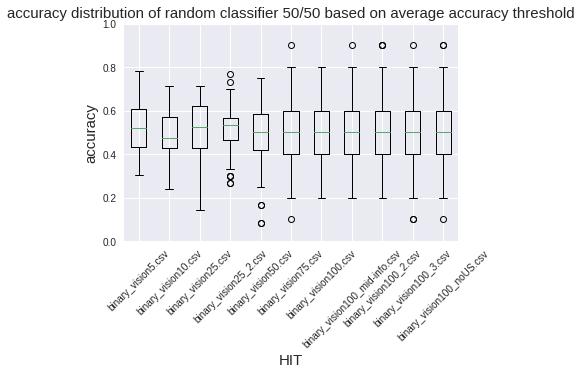

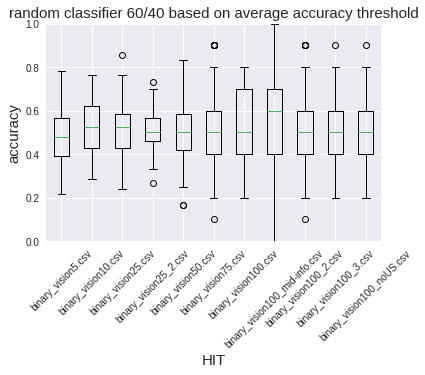

In [ ]:
plt.figure()
plt.title("accuracy distribution of random classifier 50/50 based on average accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_binary_vision_random_average)
plt.xticks(list(range(1,file_size+1)), binary_vision_files, rotation=45)
plt.show()
plt.figure()
plt.title("random classifier 60/40 based on average accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_binary_vision_random_ratio_average)
plt.xticks(list(range(1,file_size+1)), binary_vision_files, rotation=45)

plt.show()

###### Logistics Regression

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_binary_vision_logistics_average = []
for i in range(np.size(binary_vision_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_binary_vision_average[2*i+1][j], prediction_binary_vision_logistics_average[ITERATION*i+j]))

  prediction_accuracy_binary_vision_logistics_average.append(pred_acc)

c = []
for j in range(np.size(binary_vision_files)):
  c.append(np.average(prediction_accuracy_binary_vision_logistics_average[j]))

<Figure size 432x288 with 0 Axes>

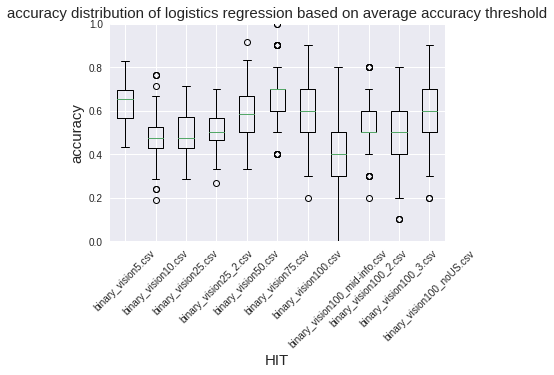

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.boxplot(prediction_accuracy_binary_vision_logistics_average)
plt.ylim([0,1])
plt.xticks(list(range(1,file_size+1)), binary_vision_files, rotation=45)
plt.title("accuracy distribution of logistics regression based on average accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.figure()

###### Decision Trees

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_binary_vision_tree_average = []
for i in range(np.size(binary_vision_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_binary_vision_average[2*i+1][j], prediction_binary_vision_tree_average[ITERATION*i+j]))

  prediction_accuracy_binary_vision_tree_average.append(pred_acc)

d = []
for j in range(np.size(binary_vision_files)):
  d.append(np.average(prediction_accuracy_binary_vision_tree_average[j]))

(0.0, 1.0)

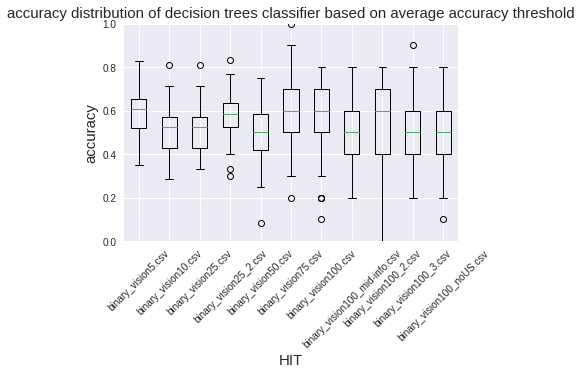

In [ ]:
plt.figure()
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_binary_vision_tree_average)
plt.xticks(list(range(1,file_size+1)), binary_vision_files, rotation=45)
plt.title("accuracy distribution of decision trees classifier based on average accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.ylim([0,1])

###### Random Forest

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_binary_vision_forest_average = []
for i in range(np.size(binary_vision_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_binary_vision_average[2*i+1][j], prediction_binary_vision_forest_average[ITERATION*i+j]))

  prediction_accuracy_binary_vision_forest_average.append(pred_acc)

e = []
for j in range(np.size(binary_vision_files)):
  e.append(np.average(prediction_accuracy_binary_vision_forest_average[j]))

<Figure size 432x288 with 0 Axes>

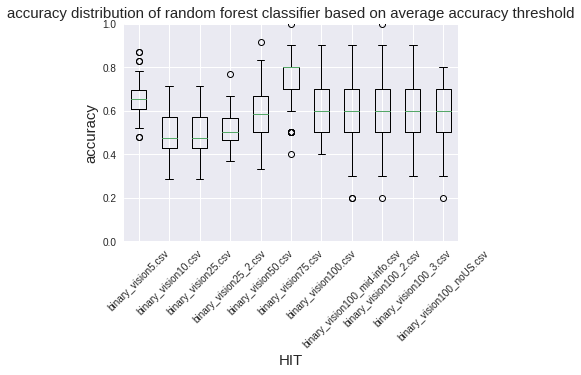

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.boxplot(prediction_accuracy_binary_vision_forest_average)
plt.ylim([0,1])
plt.xticks(list(range(1,file_size+1)), binary_vision_files, rotation=45)
plt.title("accuracy distribution of random forest classifier based on average accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.figure()

###### General

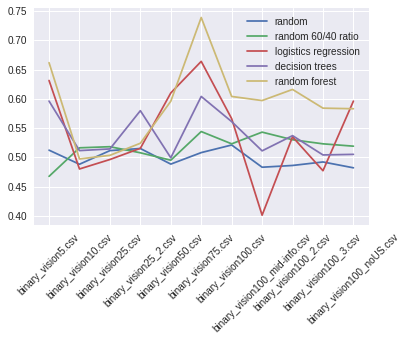

In [ ]:
plt.plot(binary_vision_files,a)
plt.plot(binary_vision_files,b)
plt.plot(binary_vision_files,c)
plt.plot(binary_vision_files,d)
plt.plot(binary_vision_files,e)

leg = ["random","random 60/40 ratio","logistics regression","decision trees", "random forest"]
plt.legend(leg)
plt.xticks(binary_vision_files, rotation=45)
plt.show()



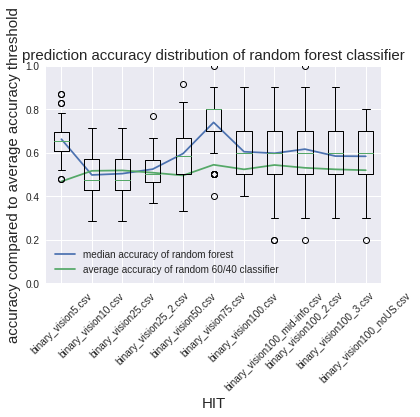

In [ ]:
plt.figure()
plt.title("prediction accuracy distribution of random forest classifier")
plt.xlabel("HIT")
plt.ylabel("accuracy compared to average accuracy threshold")
plt.ylim([0,1])

plt.plot(list(range(1,file_size+1)),e)
plt.plot(list(range(1,file_size+1)),b)
plt.legend(["median accuracy of random forest","average accuracy of random 60/40 classifier"])
plt.boxplot(prediction_accuracy_binary_vision_forest_average)

plt.xticks(list(range(1,file_size+1)), binary_vision_files, rotation=45)
plt.show()

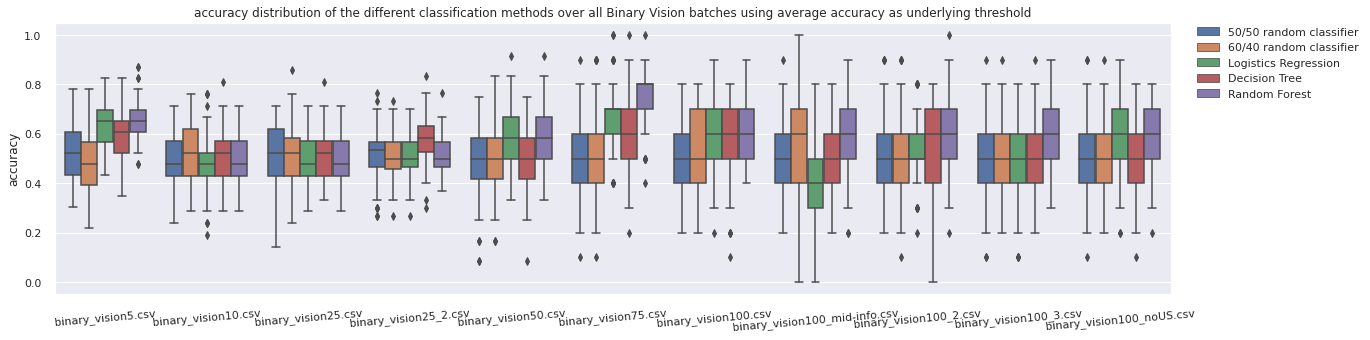

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(44)
# DATAFRAMES WITH TRIAL COLUMN ASSIGNED

box = []

for i in range(np.size(binary_vision_files)):
  data = [prediction_accuracy_binary_vision_random_average[i],prediction_accuracy_binary_vision_random_ratio_average[i],prediction_accuracy_binary_vision_logistics_average[i],prediction_accuracy_binary_vision_tree_average[i],prediction_accuracy_binary_vision_forest_average[i]]
  data = np.array(data) .T.tolist()
  box.append(pd.DataFrame(data, columns=["50/50 random classifier","60/40 random classifier","Logistics Regression","Decision Tree","Random Forest"]).assign(Trial=i))
  #box2.append(pd.DataFrame(prediction_accuracy_binary_vision_tree_average[i], columns=[binary_vision_files[i]]).assign(Trial=i))


cdf = pd.concat(box)                           # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Trial'], var_name=['Method'])      # MELT

sns.set(rc={"figure.figsize":(20, 5)}) 
ax = sns.boxplot(x="Trial", y="value", hue="Method", data=mdf)

plt.title("accuracy distribution of the different classification methods over all Binary Vision batches using average accuracy as underlying threshold")
plt.ylabel("accuracy")
plt.xlabel("")
plt.xticks(list(range(0,11)), binary_vision_files, rotation=5)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.show()

'''
for i in range(np.size(binary_vision_files)):
  ax = sns.boxplot(data=box[i])  # RUN PLOT   
  plt.show()
'''
plt.clf()
plt.close()

##### Median Threshold

###### Random Classifier

In [ ]:
prediction_accuracy_binary_vision_random_median = []
prediction_accuracy_binary_vision_random_ratio_median = []
for i in range(np.size(binary_vision_files)):
  pred_acc = []
  pred_acc_ratio = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_binary_vision_median[2*i+1][j], binary_vision_random_classification_median[ITERATION*i+j]))
    
    pred_acc_ratio.append(metrics.accuracy_score(Y_binary_vision_median[2*i+1][j], binary_vision_random_ratio_classification_median[ITERATION*i+j]))
    

  prediction_accuracy_binary_vision_random_median.append(pred_acc)
  prediction_accuracy_binary_vision_random_ratio_median.append(pred_acc_ratio)

a,b = [],[]
for j in range(np.size(binary_vision_files)):
  a.append(np.average(prediction_accuracy_binary_vision_random_average[j]))
  b.append(np.average(prediction_accuracy_binary_vision_random_ratio_average[j]))

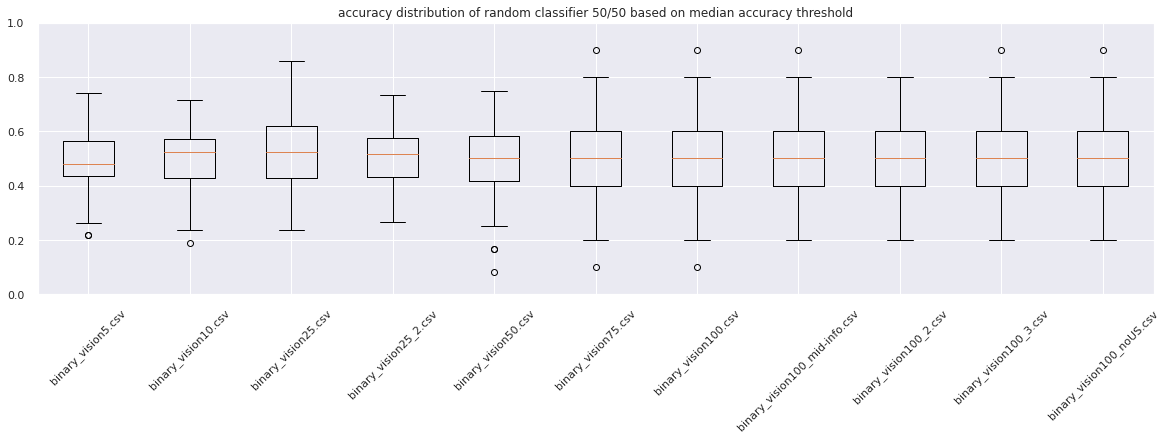

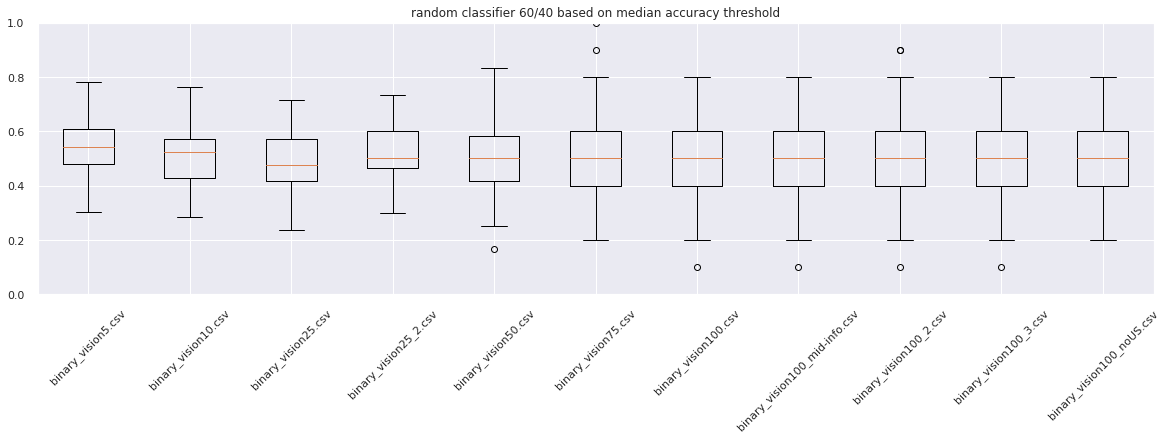

In [ ]:
plt.figure()
plt.title("accuracy distribution of random classifier 50/50 based on median accuracy threshold")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_binary_vision_random_median)
plt.xticks(list(range(1,file_size+1)), binary_vision_files, rotation=45)
plt.show()
plt.figure()
plt.title("random classifier 60/40 based on median accuracy threshold")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_binary_vision_random_ratio_median)
plt.xticks(list(range(1,file_size+1)), binary_vision_files, rotation=45)

plt.show()

###### Logistics Regression

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_binary_vision_logistics_median = []
for i in range(np.size(binary_vision_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_binary_vision_median[2*i+1][j], prediction_binary_vision_logistics_median[ITERATION*i+j]))

  prediction_accuracy_binary_vision_logistics_median.append(pred_acc)

c = []
for j in range(np.size(binary_vision_files)):
  c.append(np.average(prediction_accuracy_binary_vision_logistics_median[j]))

<Figure size 1440x360 with 0 Axes>

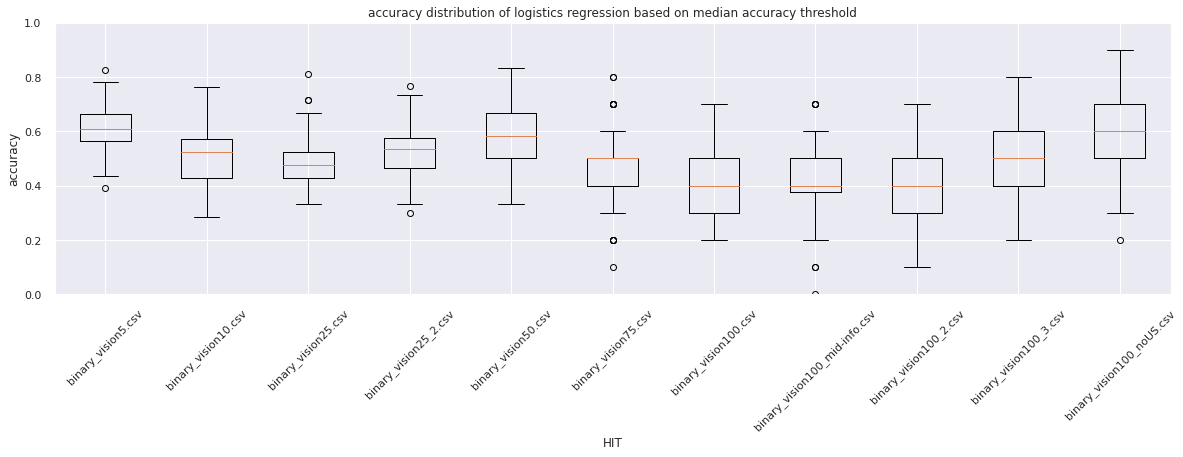

<Figure size 1440x360 with 0 Axes>

In [ ]:
plt.boxplot(prediction_accuracy_binary_vision_logistics_median)
plt.ylim([0,1])
plt.xticks(list(range(1,file_size+1)), binary_vision_files, rotation=45)
plt.title("accuracy distribution of logistics regression based on median accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.figure()

###### Decision Trees

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_binary_vision_tree_median = []
for i in range(np.size(binary_vision_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_binary_vision_median[2*i+1][j], prediction_binary_vision_tree_median[ITERATION*i+j]))

  prediction_accuracy_binary_vision_tree_median.append(pred_acc)

d = []
for j in range(np.size(binary_vision_files)):
  d.append(np.median(prediction_accuracy_binary_vision_tree_median[j]))

(0.0, 1.0)

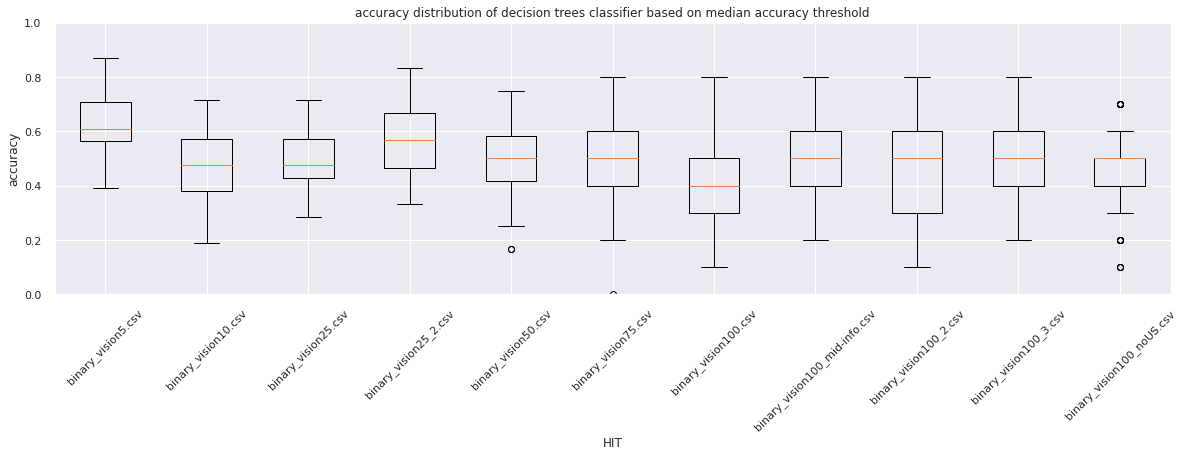

In [ ]:
plt.figure()
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_binary_vision_tree_median)
plt.xticks(list(range(1,file_size+1)), binary_vision_files, rotation=45)
plt.title("accuracy distribution of decision trees classifier based on median accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.ylim([0,1])

###### Random Forest

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_binary_vision_forest_median = []
for i in range(np.size(binary_vision_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_binary_vision_median[2*i+1][j], prediction_binary_vision_forest_median[ITERATION*i+j]))

  prediction_accuracy_binary_vision_forest_median.append(pred_acc)

e = []
for j in range(np.size(binary_vision_files)):
  e.append(np.median(prediction_accuracy_binary_vision_forest_median[j]))

<Figure size 1440x360 with 0 Axes>

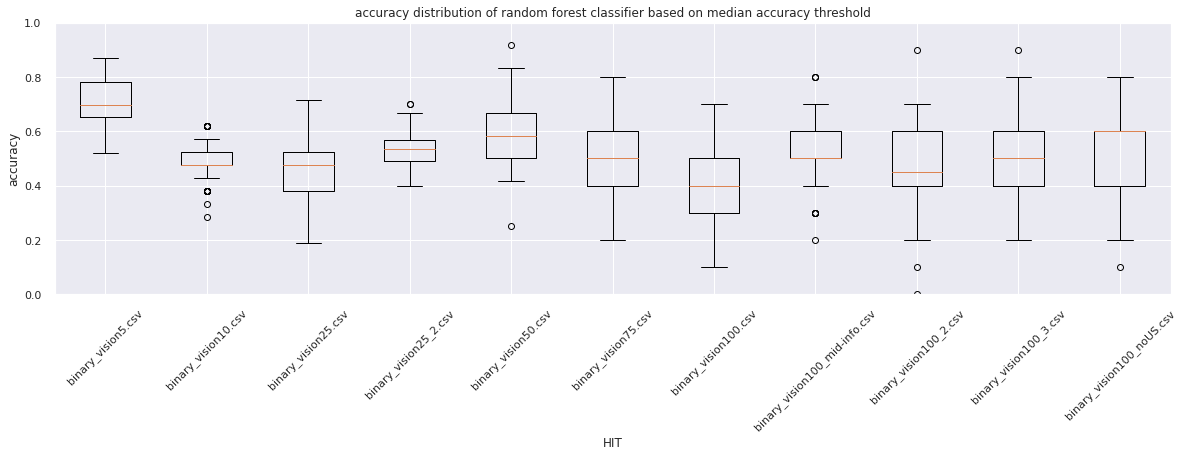

<Figure size 1440x360 with 0 Axes>

In [ ]:
plt.boxplot(prediction_accuracy_binary_vision_forest_median)
plt.ylim([0,1])
plt.xticks(list(range(1,file_size+1)), binary_vision_files, rotation=45)
plt.title("accuracy distribution of random forest classifier based on median accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.figure()

###### General

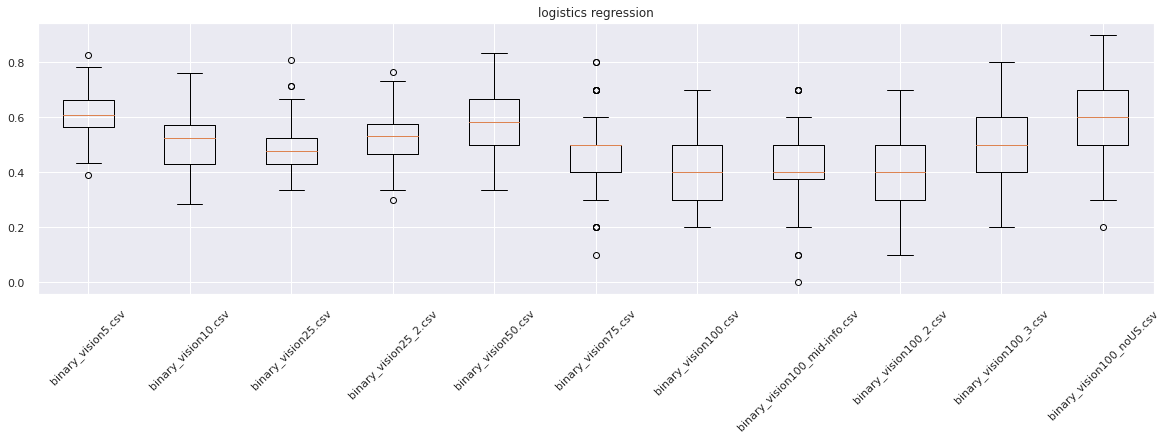

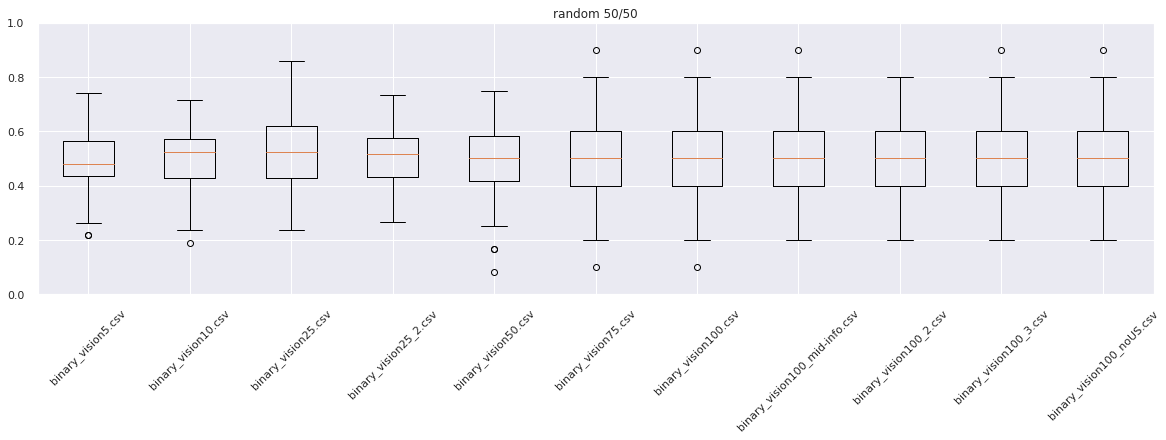

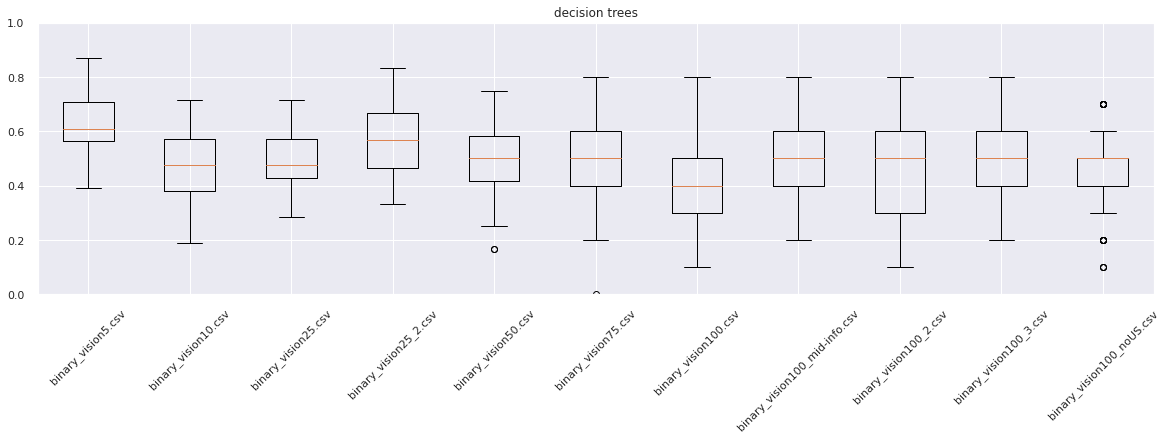

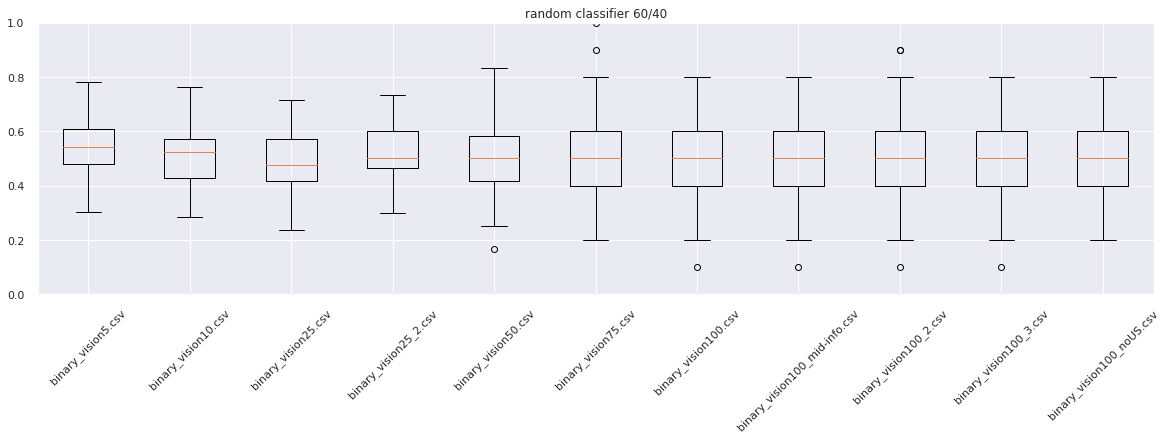

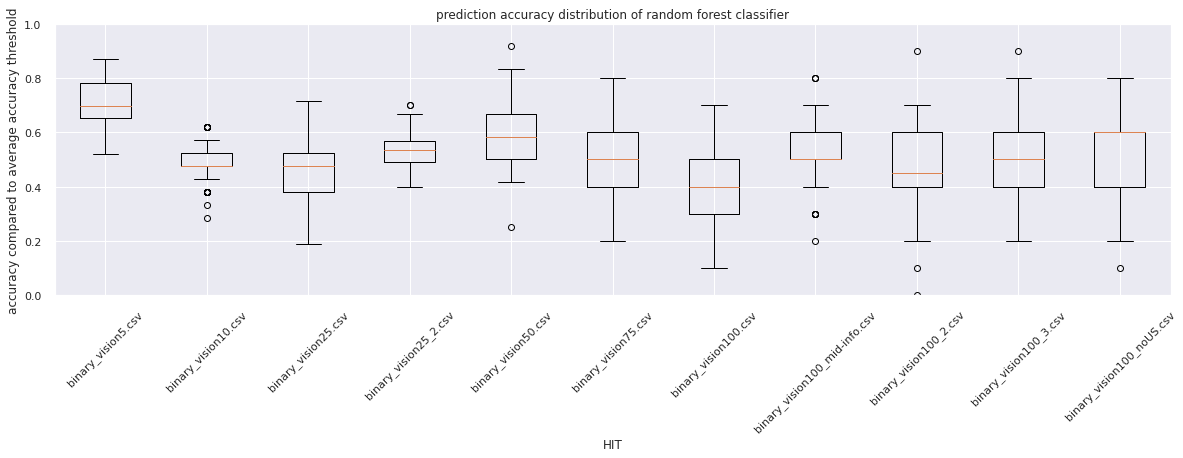

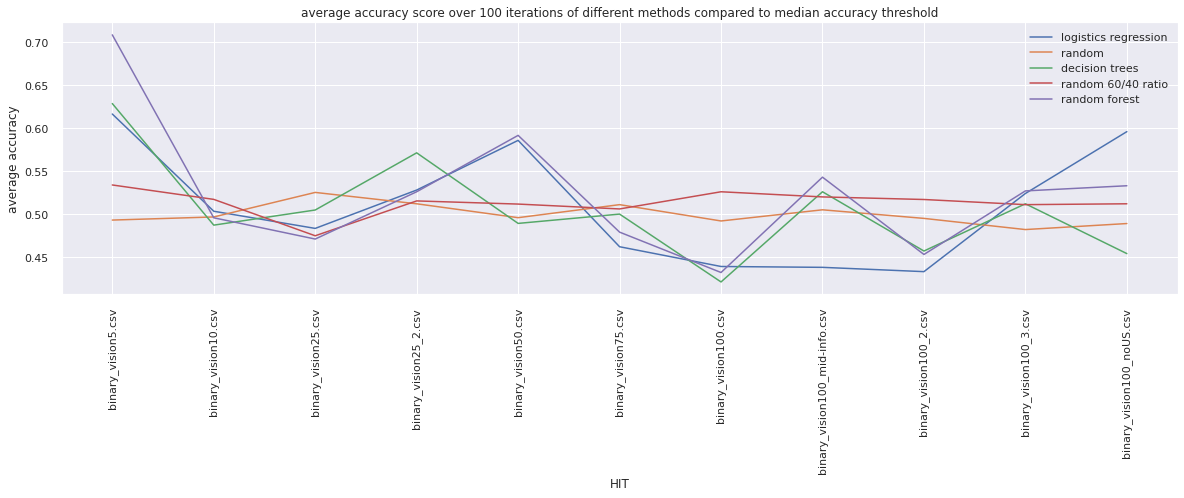

In [ ]:
plt.figure()
plt.title("logistics regression")
plt.boxplot(prediction_accuracy_binary_vision_logistics_median)
plt.xticks(list(range(1,file_size+1)), binary_vision_files, rotation=45)

plt.figure()
plt.ylim([0,1])
plt.title("random 50/50")
plt.boxplot(prediction_accuracy_binary_vision_random_median)
plt.xticks(list(range(1,file_size+1)), binary_vision_files, rotation=45)

plt.figure()
plt.ylim([0,1])
plt.title("decision trees")
plt.boxplot(prediction_accuracy_binary_vision_tree_median)
plt.xticks(list(range(1,file_size+1)), binary_vision_files, rotation=45)
plt.ylim([0,1])

plt.figure()
plt.title("random classifier 60/40")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_binary_vision_random_ratio_median)
plt.xticks(list(range(1,file_size+1)), binary_vision_files, rotation=45)
plt.show()

plt.figure()
plt.title("prediction accuracy distribution of random forest classifier")
plt.xlabel("HIT")
plt.ylabel("accuracy compared to average accuracy threshold")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_binary_vision_forest_median)
plt.xticks(list(range(1,file_size+1)), binary_vision_files, rotation=45)

plt.show()


plt.figure()
plt.title("average accuracy score over " + str(ITERATION) + " iterations of different methods compared to median accuracy threshold")
plt.xlabel('HIT')
plt.xticks(rotation=90)
plt.ylabel('average accuracy')
#plt.ylim([0.4,0.8])
a,b,c,d,e = [],[],[],[],[]

for i in range(11):
  a.append(np.average(prediction_accuracy_binary_vision_logistics_median[i]))
  b.append(np.average(prediction_accuracy_binary_vision_random_median[i]))
  c.append(np.average(prediction_accuracy_binary_vision_tree_median[i]))
  d.append(np.average(prediction_accuracy_binary_vision_random_ratio_median[i]))
  e.append(np.average(prediction_accuracy_binary_vision_forest_median[i]))


plt.plot(binary_vision_files,a)
plt.plot(binary_vision_files,b)
plt.plot(binary_vision_files,c)
plt.plot(binary_vision_files,d)
plt.plot(binary_vision_files,e)

leg = ["logistics regression","random","decision trees","random 60/40 ratio", "random forest"]
plt.legend(leg)
plt.show()



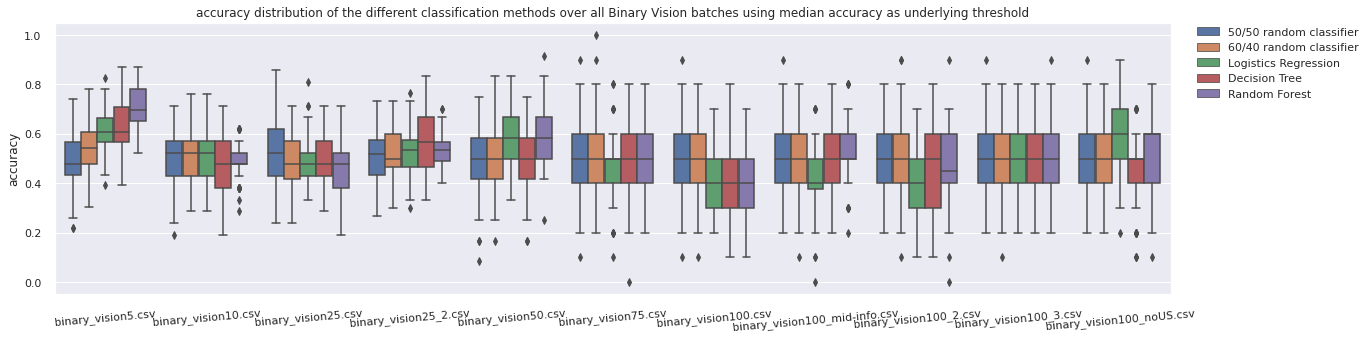

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(44)
# DATAFRAMES WITH TRIAL COLUMN ASSIGNED

box = []

for i in range(np.size(binary_vision_files)):
  data = [prediction_accuracy_binary_vision_random_median[i],prediction_accuracy_binary_vision_random_ratio_median[i],prediction_accuracy_binary_vision_logistics_median[i],prediction_accuracy_binary_vision_tree_median[i],prediction_accuracy_binary_vision_forest_median[i]]
  data = np.array(data) .T.tolist()
  box.append(pd.DataFrame(data, columns=["50/50 random classifier","60/40 random classifier","Logistics Regression","Decision Tree","Random Forest"]).assign(Trial=i))
  #box2.append(pd.DataFrame(prediction_accuracy_binary_vision_tree_average[i], columns=[binary_vision_files[i]]).assign(Trial=i))


cdf = pd.concat(box)                           # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Trial'], var_name=['Method'])      # MELT

sns.set(rc={"figure.figsize":(20, 5)}) 
ax = sns.boxplot(x="Trial", y="value", hue="Method", data=mdf)

plt.title("accuracy distribution of the different classification methods over all Binary Vision batches using median accuracy as underlying threshold")
plt.ylabel("accuracy")
plt.xlabel("")
plt.xticks(list(range(0,11)), binary_vision_files, rotation=5)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.show()

'''
for i in range(np.size(binary_vision_files)):
  ax = sns.boxplot(data=box[i])  # RUN PLOT   
  plt.show()
'''
plt.clf()
plt.close()

##### Fixed Threshold

###### Random Classifier

In [ ]:
prediction_accuracy_binary_vision_random_fixed = []
prediction_accuracy_binary_vision_random_ratio_fixed = []
for i in range(np.size(binary_vision_files)):
  pred_acc = []
  pred_acc_ratio = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_binary_vision_fixed[2*i+1][j], binary_vision_random_classification_fixed[ITERATION*i+j]))
    
    pred_acc_ratio.append(metrics.accuracy_score(Y_binary_vision_fixed[2*i+1][j], binary_vision_random_ratio_classification_fixed[ITERATION*i+j]))
    

  prediction_accuracy_binary_vision_random_fixed.append(pred_acc)
  prediction_accuracy_binary_vision_random_ratio_fixed.append(pred_acc_ratio)

a,b = [],[]
for j in range(np.size(binary_vision_files)):
  a.append(np.average(prediction_accuracy_binary_vision_random_fixed[j]))
  b.append(np.average(prediction_accuracy_binary_vision_random_ratio_fixed[j]))

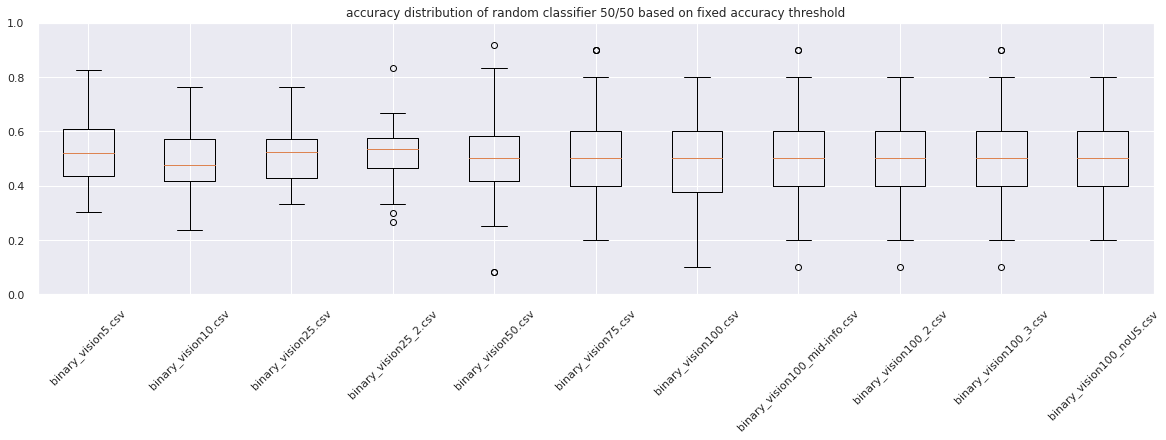

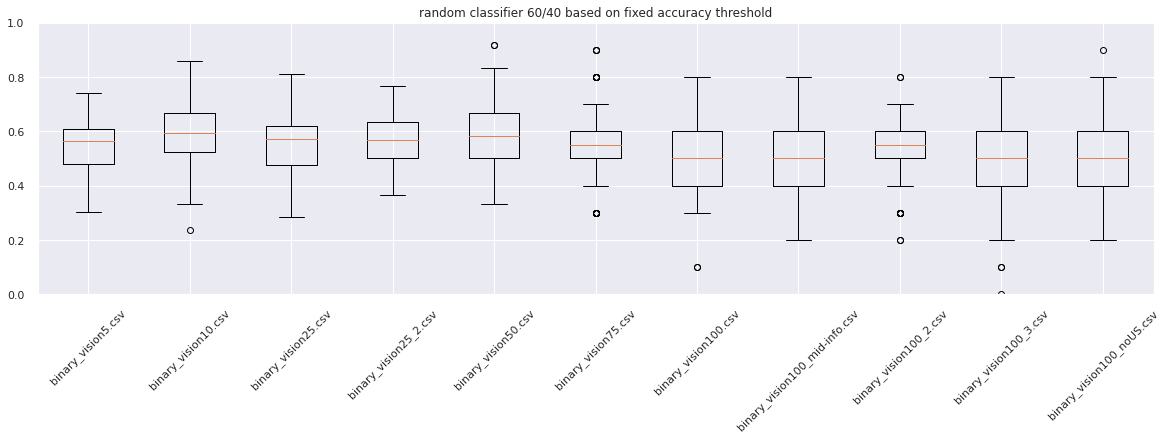

In [ ]:
plt.figure()
plt.title("accuracy distribution of random classifier 50/50 based on fixed accuracy threshold")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_binary_vision_random_fixed)
plt.xticks(list(range(1,file_size+1)), binary_vision_files, rotation=45)
plt.show()
plt.figure()
plt.title("random classifier 60/40 based on fixed accuracy threshold")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_binary_vision_random_ratio_fixed)
plt.xticks(list(range(1,file_size+1)), binary_vision_files, rotation=45)

plt.show()

###### Logistics Regression

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_binary_vision_logistics_fixed = []
for i in range(np.size(binary_vision_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_binary_vision_fixed[2*i+1][j], prediction_binary_vision_logistics_fixed[ITERATION*i+j]))

  prediction_accuracy_binary_vision_logistics_fixed.append(pred_acc)

c = []
for j in range(np.size(binary_vision_files)):
  c.append(np.average(prediction_accuracy_binary_vision_logistics_fixed[j]))

<Figure size 1440x360 with 0 Axes>

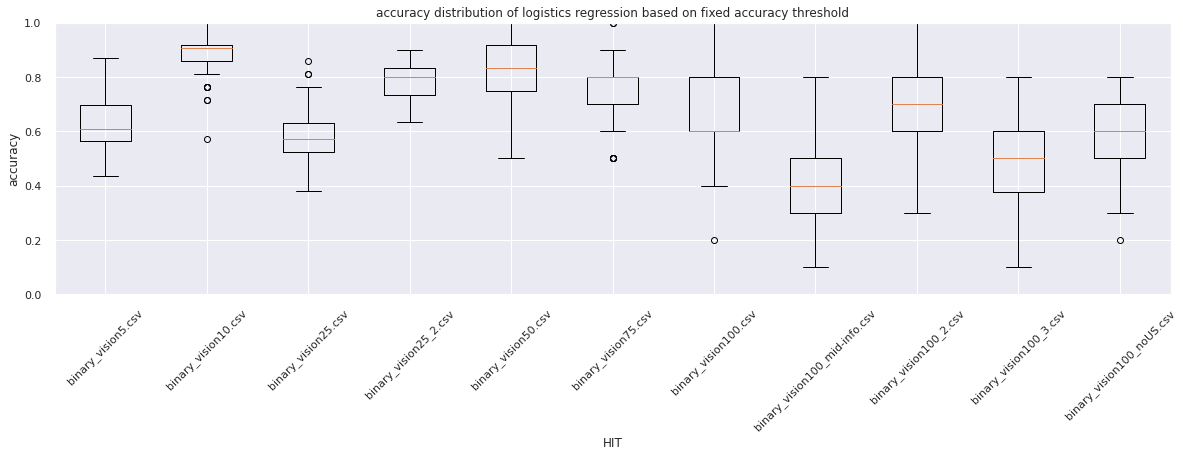

<Figure size 1440x360 with 0 Axes>

In [ ]:
plt.boxplot(prediction_accuracy_binary_vision_logistics_fixed)
plt.ylim([0,1])
plt.xticks(list(range(1,file_size+1)), binary_vision_files, rotation=45)
plt.title("accuracy distribution of logistics regression based on fixed accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.figure()

###### Decision Trees

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_binary_vision_tree_fixed = []
for i in range(np.size(binary_vision_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_binary_vision_fixed[2*i+1][j], prediction_binary_vision_tree_fixed[ITERATION*i+j]))

  prediction_accuracy_binary_vision_tree_fixed.append(pred_acc)

d = []
for j in range(np.size(binary_vision_files)):
  d.append(np.average(prediction_accuracy_binary_vision_tree_fixed[j]))

(0.0, 1.0)

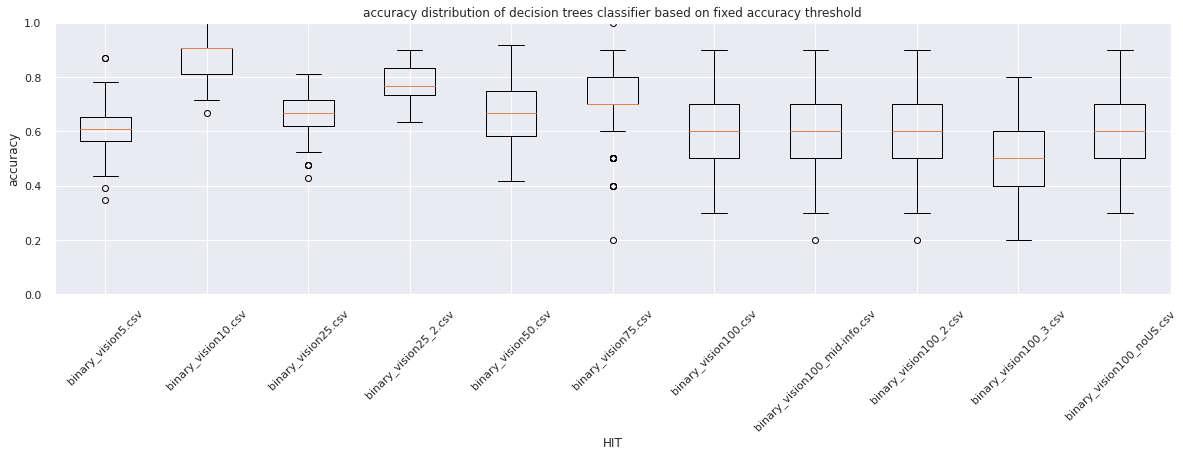

In [ ]:
plt.figure()
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_binary_vision_tree_fixed)
plt.xticks(list(range(1,file_size+1)), binary_vision_files, rotation=45)
plt.title("accuracy distribution of decision trees classifier based on fixed accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.ylim([0,1])

###### Random Forest

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_binary_vision_forest_fixed = []
for i in range(np.size(binary_vision_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_binary_vision_fixed[2*i+1][j], prediction_binary_vision_forest_fixed[ITERATION*i+j]))

  prediction_accuracy_binary_vision_forest_fixed.append(pred_acc)

e = []
for j in range(np.size(binary_vision_files)):
  e.append(np.average(prediction_accuracy_binary_vision_forest_fixed[j]))

<Figure size 1440x360 with 0 Axes>

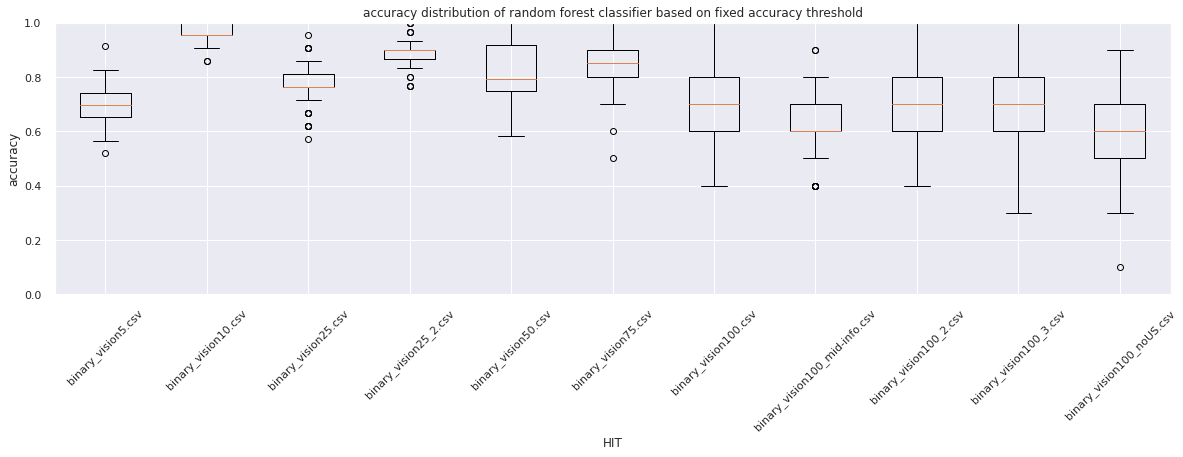

<Figure size 1440x360 with 0 Axes>

In [ ]:
plt.boxplot(prediction_accuracy_binary_vision_forest_fixed)
plt.ylim([0,1])
plt.xticks(list(range(1,file_size+1)), binary_vision_files, rotation=45)
plt.title("accuracy distribution of random forest classifier based on fixed accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.figure()

###### General

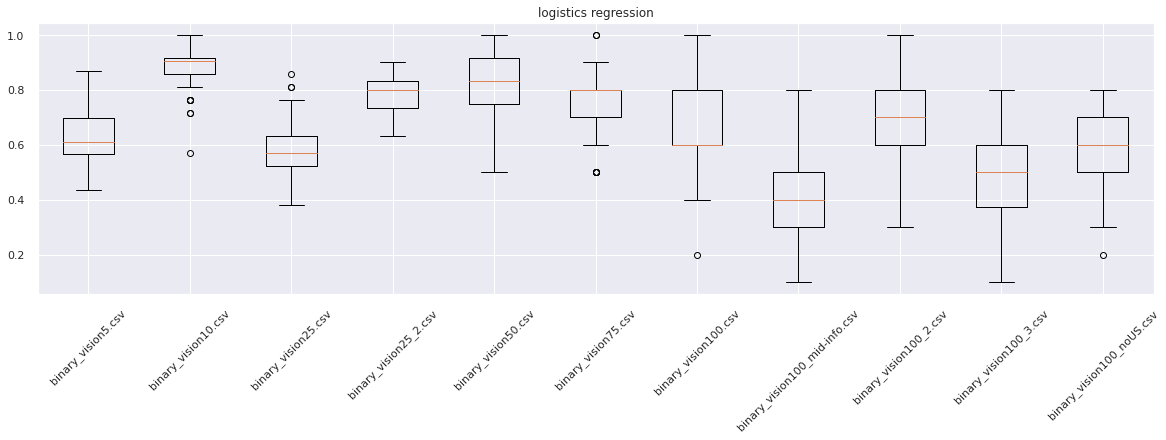

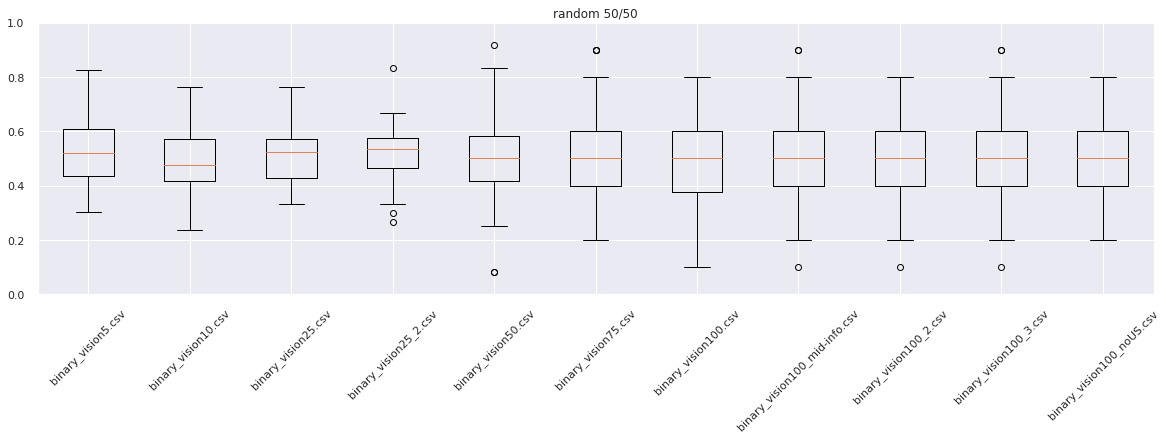

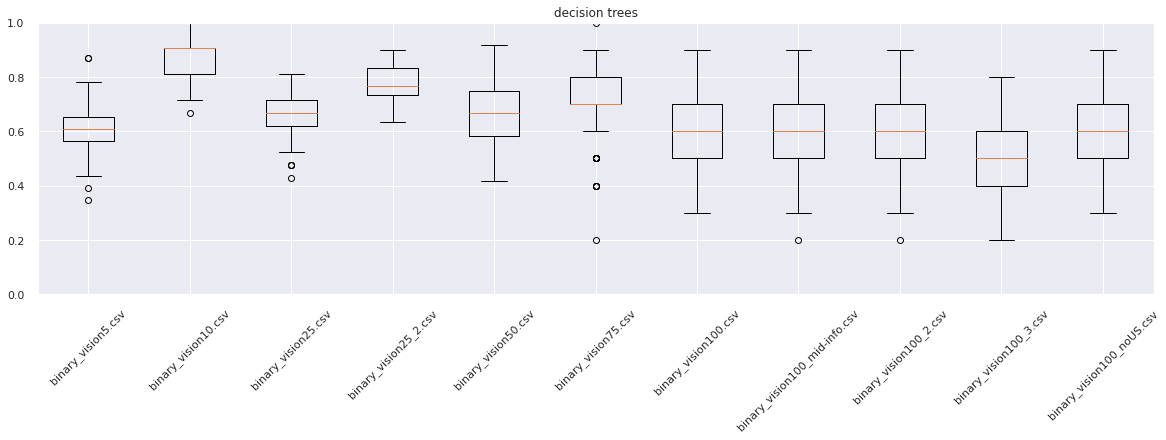

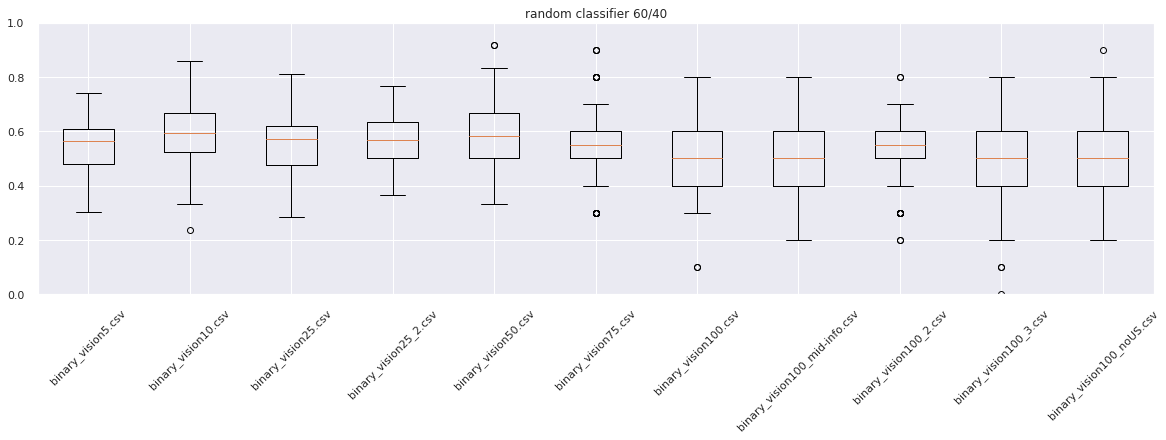

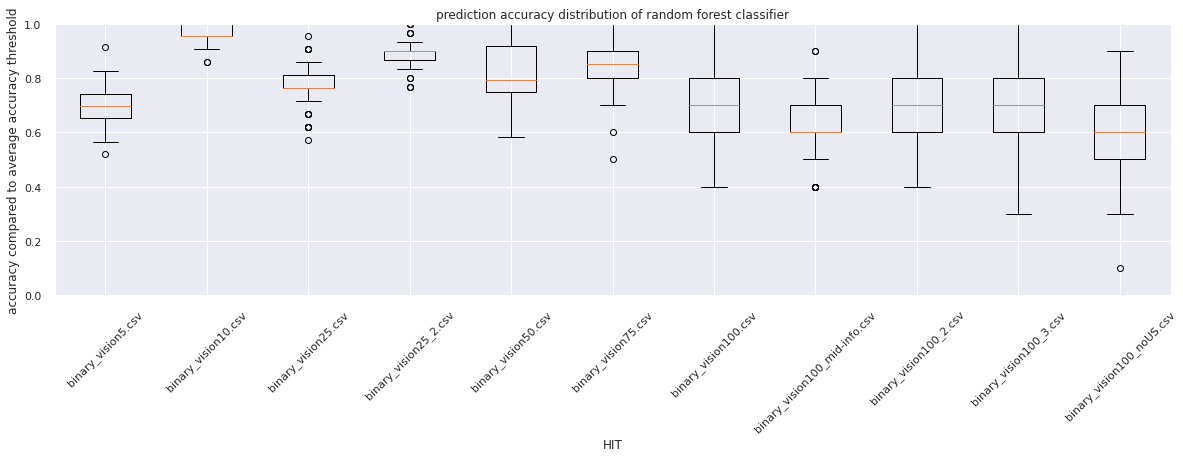

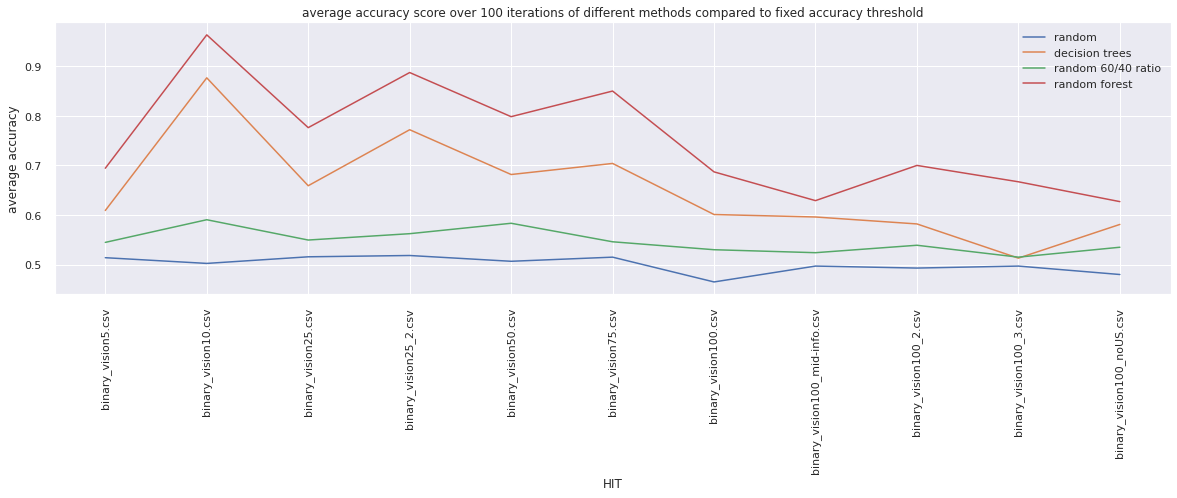

In [ ]:
plt.figure()
plt.title("logistics regression")
plt.boxplot(prediction_accuracy_binary_vision_logistics_fixed)
plt.xticks(list(range(1,file_size+1)), binary_vision_files, rotation=45)

plt.figure()
plt.ylim([0,1])
plt.title("random 50/50")
plt.boxplot(prediction_accuracy_binary_vision_random_fixed)
plt.xticks(list(range(1,file_size+1)), binary_vision_files, rotation=45)

plt.figure()
plt.ylim([0,1])
plt.title("decision trees")
plt.boxplot(prediction_accuracy_binary_vision_tree_fixed)
plt.xticks(list(range(1,file_size+1)), binary_vision_files, rotation=45)
plt.ylim([0,1])

plt.figure()
plt.title("random classifier 60/40")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_binary_vision_random_ratio_fixed)
plt.xticks(list(range(1,file_size+1)), binary_vision_files, rotation=45)
plt.show()

plt.figure()
plt.title("prediction accuracy distribution of random forest classifier")
plt.xlabel("HIT")
plt.ylabel("accuracy compared to average accuracy threshold")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_binary_vision_forest_fixed)
plt.xticks(list(range(1,file_size+1)), binary_vision_files, rotation=45)

plt.show()


plt.figure()
plt.title("average accuracy score over " + str(ITERATION) + " iterations of different methods compared to fixed accuracy threshold")
plt.xlabel('HIT')
plt.xticks(rotation=90)
plt.ylabel('average accuracy')
#plt.ylim([0.4,0.8])
a,b,c,d,e = [],[],[],[],[]

for i in range(np.size(binary_vision_files)):
  #a.append(np.average(prediction_accuracy_binary_vision_logistics_fixed[i]))
  b.append(np.average(prediction_accuracy_binary_vision_random_fixed[i]))
  c.append(np.average(prediction_accuracy_binary_vision_tree_fixed[i]))
  d.append(np.average(prediction_accuracy_binary_vision_random_ratio_fixed[i]))
  e.append(np.average(prediction_accuracy_binary_vision_forest_fixed[i]))


#plt.plot(binary_vision_files,a)
plt.plot(binary_vision_files,b)
plt.plot(binary_vision_files,c)
plt.plot(binary_vision_files,d)
plt.plot(binary_vision_files,e)

leg = ["logistics regression","random","decision trees","random 60/40 ratio", "random forest"]
plt.legend(leg[1:6])
plt.show()



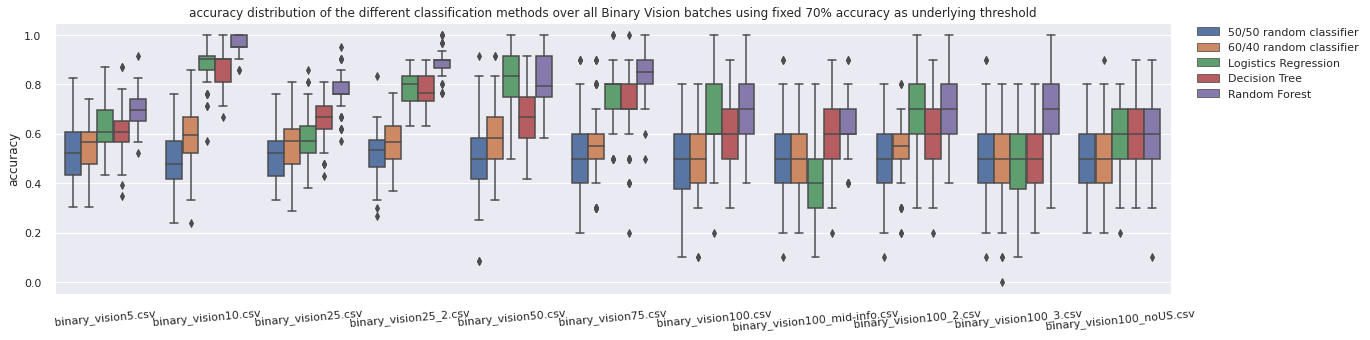

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(44)
# DATAFRAMES WITH TRIAL COLUMN ASSIGNED

box = []

for i in range(np.size(binary_vision_files)):
  data = [prediction_accuracy_binary_vision_random_fixed[i],prediction_accuracy_binary_vision_random_ratio_fixed[i],prediction_accuracy_binary_vision_logistics_fixed[i],prediction_accuracy_binary_vision_tree_fixed[i],prediction_accuracy_binary_vision_forest_fixed[i]]
  #data = [prediction_accuracy_binary_vision_random_fixed[i],prediction_accuracy_binary_vision_random_ratio_fixed[i],prediction_accuracy_binary_vision_tree_fixed[i],prediction_accuracy_binary_vision_forest_fixed[i]]
  data = np.array(data) .T.tolist()
  box.append(pd.DataFrame(data, columns=["50/50 random classifier","60/40 random classifier","Logistics Regression","Decision Tree","Random Forest"]).assign(Trial=i))
  #box.append(pd.DataFrame(data, columns=["50/50 random classifier","60/40 random classifier","Decision Tree","Random Forest"]).assign(Trial=i))
  #box2.append(pd.DataFrame(prediction_accuracy_binary_vision_tree_average[i], columns=[binary_vision_files[i]]).assign(Trial=i))


cdf = pd.concat(box)                           # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Trial'], var_name=['Method'])      # MELT

sns.set(rc={"figure.figsize":(20, 5)}) 
ax = sns.boxplot(x="Trial", y="value", hue="Method", data=mdf)

plt.title("accuracy distribution of the different classification methods over all Binary Vision batches using fixed 70% accuracy as underlying threshold")
plt.ylabel("accuracy")
plt.xlabel("")
plt.xticks(list(range(0,11)), binary_vision_files, rotation=5)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.show()

'''
for i in range(np.size(binary_vision_files)):
  ax = sns.boxplot(data=box[i])  # RUN PLOT   
  plt.show()
'''
plt.clf()
plt.close()

#### Binary NLP

In [ ]:
file_size = np.size(binary_nlp_files)

##### Average Threshold

###### Random Classifier

In [ ]:
prediction_accuracy_binary_nlp_random_average = []
prediction_accuracy_binary_nlp_random_ratio_average = []
for i in range(np.size(binary_nlp_files)):
  pred_acc = []
  pred_acc_ratio = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_binary_nlp_average[2*i+1][j], binary_nlp_random_classification_average[ITERATION*i+j]))
    
    pred_acc_ratio.append(metrics.accuracy_score(Y_binary_nlp_average[2*i+1][j], binary_nlp_random_ratio_classification_average[ITERATION*i+j]))
    

  prediction_accuracy_binary_nlp_random_average.append(pred_acc)
  prediction_accuracy_binary_nlp_random_ratio_average.append(pred_acc_ratio)

a,b = [],[]
for j in range(np.size(binary_nlp_files)):
  a.append(np.average(prediction_accuracy_binary_nlp_random_average[j]))
  b.append(np.average(prediction_accuracy_binary_nlp_random_ratio_average[j]))

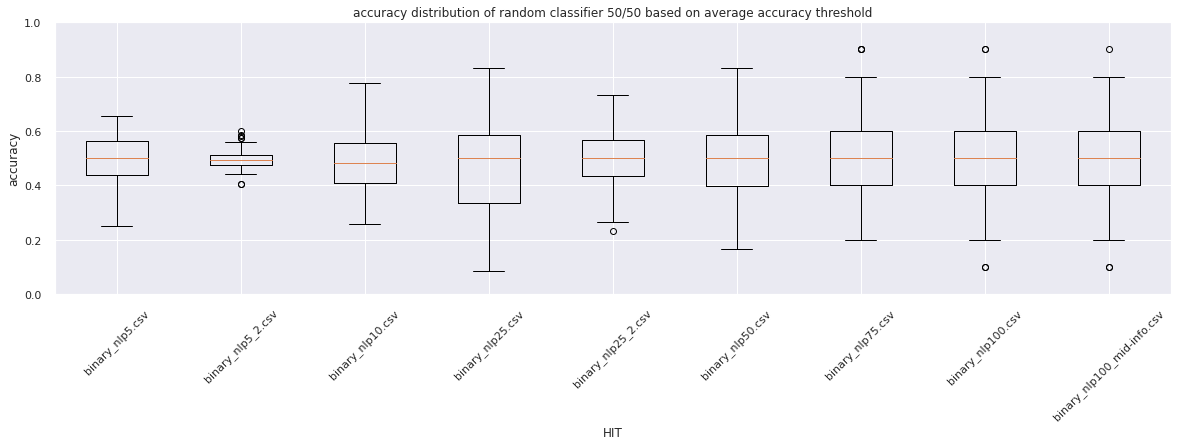

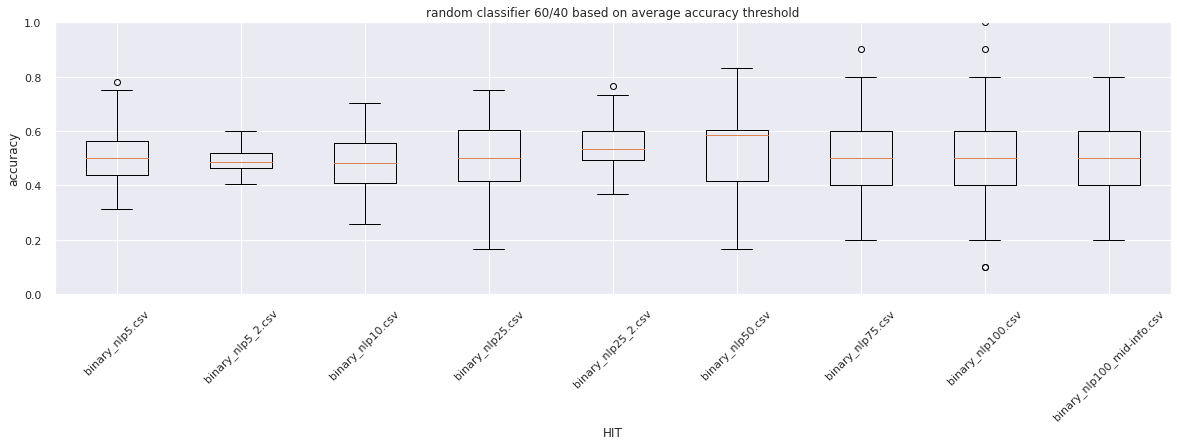

In [ ]:
plt.figure()
plt.title("accuracy distribution of random classifier 50/50 based on average accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_binary_nlp_random_average)
plt.xticks(list(range(1,file_size+1)), binary_nlp_files, rotation=45)
plt.show()
plt.figure()
plt.title("random classifier 60/40 based on average accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_binary_nlp_random_ratio_average)
plt.xticks(list(range(1,file_size+1)), binary_nlp_files, rotation=45)

plt.show()

###### Logistics Regression

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_binary_nlp_logistics_average = []
for i in range(np.size(binary_nlp_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_binary_nlp_average[2*i+1][j], prediction_binary_nlp_logistics_average[ITERATION*i+j]))

  prediction_accuracy_binary_nlp_logistics_average.append(pred_acc)

c = []
for j in range(np.size(binary_nlp_files)):
  c.append(np.average(prediction_accuracy_binary_nlp_logistics_average[j]))

<Figure size 1440x360 with 0 Axes>

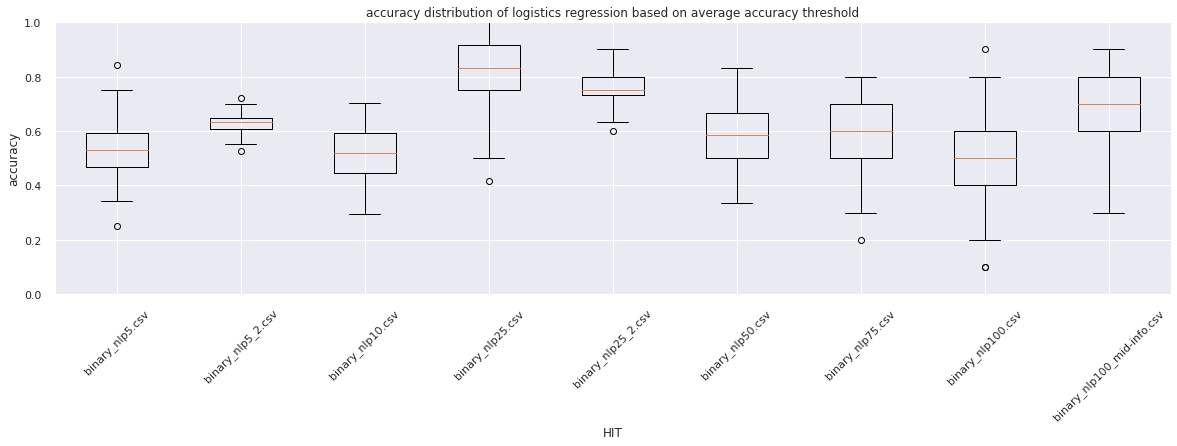

<Figure size 1440x360 with 0 Axes>

In [ ]:
plt.boxplot(prediction_accuracy_binary_nlp_logistics_average)
plt.ylim([0,1])
plt.xticks(list(range(1,file_size+1)), binary_nlp_files, rotation=45)
plt.title("accuracy distribution of logistics regression based on average accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.figure()

###### Decision Trees

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_binary_nlp_tree_average = []
for i in range(np.size(binary_nlp_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_binary_nlp_average[2*i+1][j], prediction_binary_nlp_tree_average[ITERATION*i+j]))

  prediction_accuracy_binary_nlp_tree_average.append(pred_acc)

d = []
for j in range(np.size(binary_nlp_files)):
  d.append(np.average(prediction_accuracy_binary_nlp_tree_average[j]))

(0.0, 1.0)

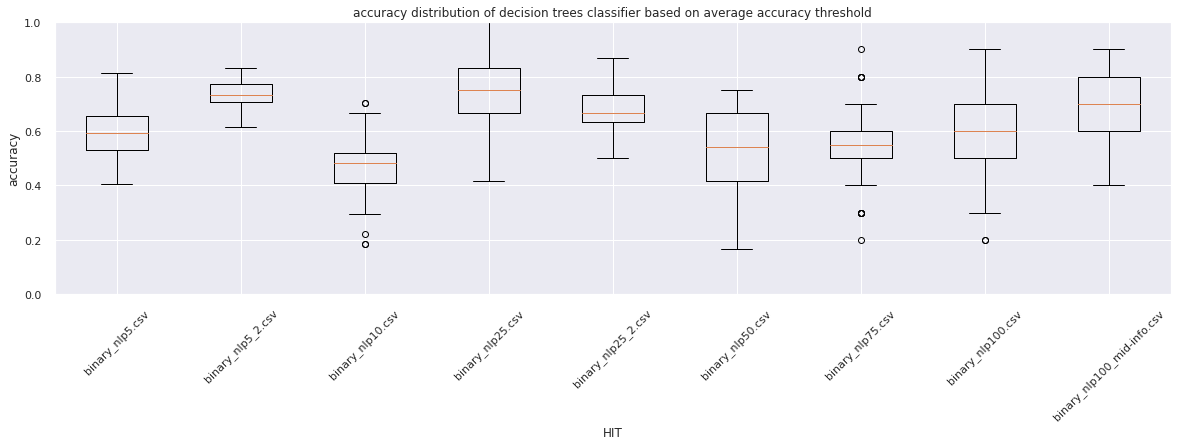

In [ ]:
plt.figure()
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_binary_nlp_tree_average)
plt.xticks(list(range(1,file_size+1)), binary_nlp_files, rotation=45)
plt.title("accuracy distribution of decision trees classifier based on average accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.ylim([0,1])

###### Random Forest

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_binary_nlp_forest_average = []
for i in range(np.size(binary_nlp_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_binary_nlp_average[2*i+1][j], prediction_binary_nlp_forest_average[ITERATION*i+j]))

  prediction_accuracy_binary_nlp_forest_average.append(pred_acc)

e = []
for j in range(np.size(binary_nlp_files)):
  e.append(np.average(prediction_accuracy_binary_nlp_forest_average[j]))

<Figure size 1440x360 with 0 Axes>

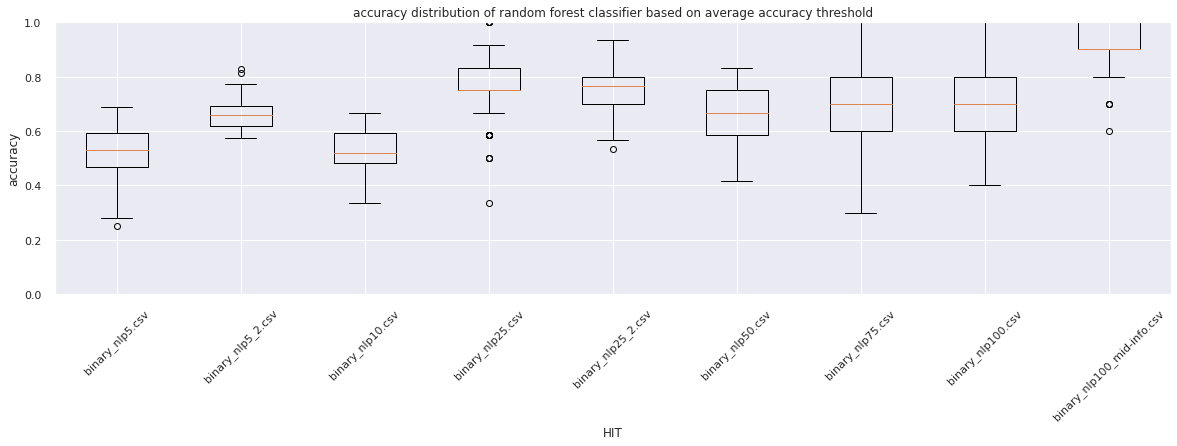

<Figure size 1440x360 with 0 Axes>

In [ ]:
plt.boxplot(prediction_accuracy_binary_nlp_forest_average)
plt.ylim([0,1])
plt.xticks(list(range(1,file_size+1)), binary_nlp_files, rotation=45)
plt.title("accuracy distribution of random forest classifier based on average accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.figure()

###### General

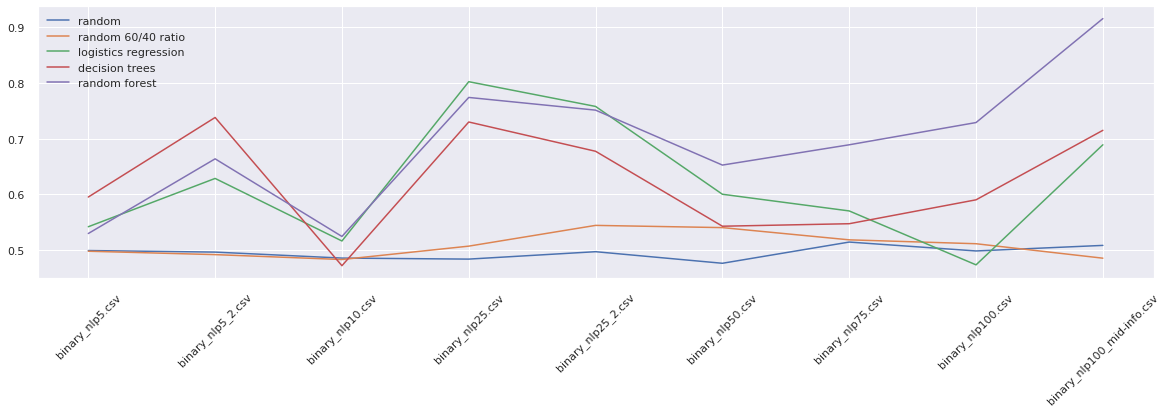

In [ ]:
plt.plot(binary_nlp_files,a)
plt.plot(binary_nlp_files,b)
plt.plot(binary_nlp_files,c)
plt.plot(binary_nlp_files,d)
plt.plot(binary_nlp_files,e)

leg = ["random","random 60/40 ratio","logistics regression","decision trees", "random forest"]
plt.legend(leg)
plt.xticks(binary_nlp_files, rotation=45)
plt.show()



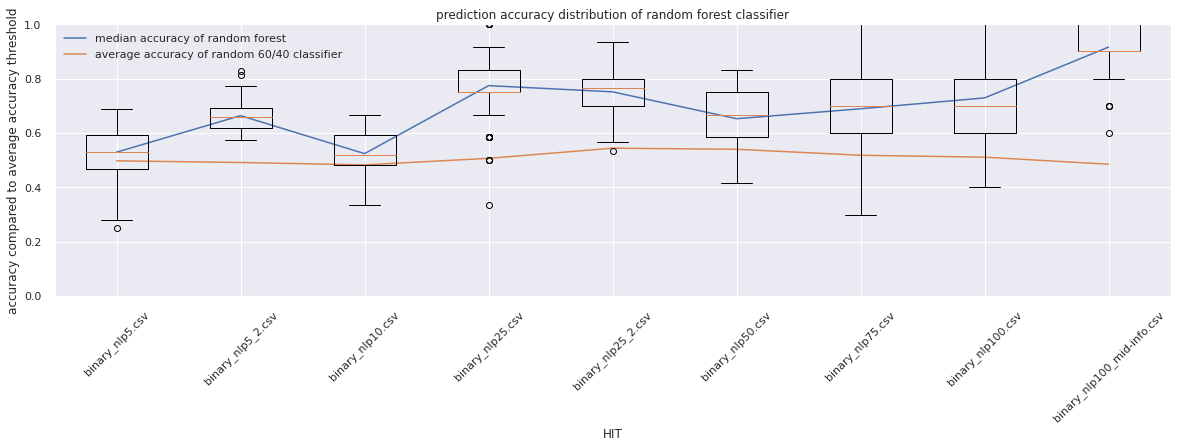

In [ ]:
file_size = np.size(binary_nlp_files)+1

plt.figure()
plt.title("prediction accuracy distribution of random forest classifier")
plt.xlabel("HIT")
plt.ylabel("accuracy compared to average accuracy threshold")
plt.ylim([0,1])

plt.plot(list(range(1,file_size)),e)
plt.plot(list(range(1,file_size)),b)
plt.legend(["median accuracy of random forest","average accuracy of random 60/40 classifier"])
plt.boxplot(prediction_accuracy_binary_nlp_forest_average)

plt.xticks(list(range(1,file_size)), binary_nlp_files, rotation=45)
plt.show()

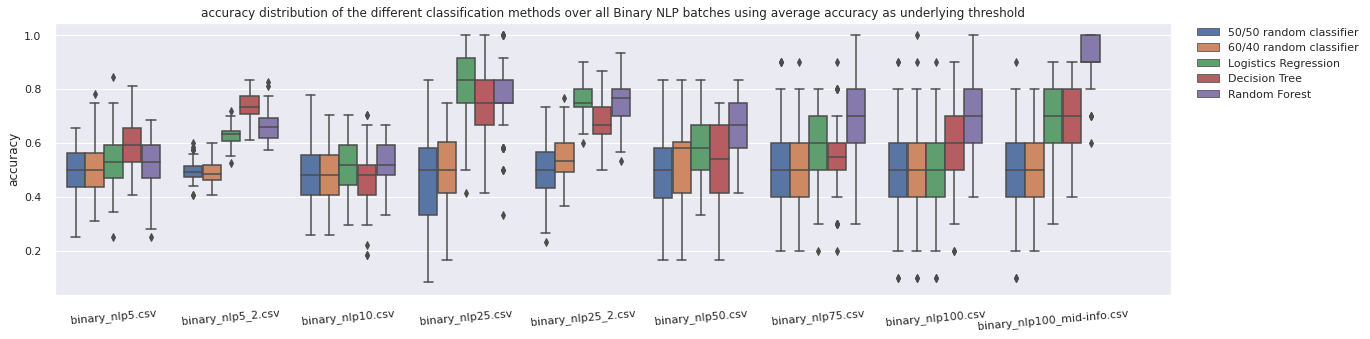

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(44)
# DATAFRAMES WITH TRIAL COLUMN ASSIGNED

box = []

for i in range(np.size(binary_nlp_files)):
  data = [prediction_accuracy_binary_nlp_random_average[i],prediction_accuracy_binary_nlp_random_ratio_average[i],prediction_accuracy_binary_nlp_logistics_average[i],prediction_accuracy_binary_nlp_tree_average[i],prediction_accuracy_binary_nlp_forest_average[i]]
  data = np.array(data) .T.tolist()
  box.append(pd.DataFrame(data, columns=["50/50 random classifier","60/40 random classifier","Logistics Regression","Decision Tree","Random Forest"]).assign(Trial=i))
  #box2.append(pd.DataFrame(prediction_accuracy_binary_nlp_tree_average[i], columns=[binary_nlp_files[i]]).assign(Trial=i))


cdf = pd.concat(box)                           # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Trial'], var_name=['Method'])      # MELT

sns.set(rc={"figure.figsize":(20, 5)}) 
ax = sns.boxplot(x="Trial", y="value", hue="Method", data=mdf)

plt.title("accuracy distribution of the different classification methods over all Binary NLP batches using average accuracy as underlying threshold")
plt.ylabel("accuracy")
plt.xlabel("")
plt.xticks(list(range(0,file_size)), binary_nlp_files, rotation=5)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.show()

'''
for i in range(np.size(binary_nlp_files)):
  ax = sns.boxplot(data=box[i])  # RUN PLOT   
  plt.show()
'''
plt.clf()
plt.close()

##### Median Threshold

###### Random Classifier

In [ ]:
prediction_accuracy_binary_nlp_random_median = []
prediction_accuracy_binary_nlp_random_ratio_median = []
for i in range(np.size(binary_nlp_files)):
  pred_acc = []
  pred_acc_ratio = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_binary_nlp_median[2*i+1][j], binary_nlp_random_classification_median[ITERATION*i+j]))
    
    pred_acc_ratio.append(metrics.accuracy_score(Y_binary_nlp_median[2*i+1][j], binary_nlp_random_ratio_classification_median[ITERATION*i+j]))
    

  prediction_accuracy_binary_nlp_random_median.append(pred_acc)
  prediction_accuracy_binary_nlp_random_ratio_median.append(pred_acc_ratio)

a,b = [],[]
for j in range(np.size(binary_nlp_files)):
  a.append(np.average(prediction_accuracy_binary_nlp_random_average[j]))
  b.append(np.average(prediction_accuracy_binary_nlp_random_ratio_average[j]))

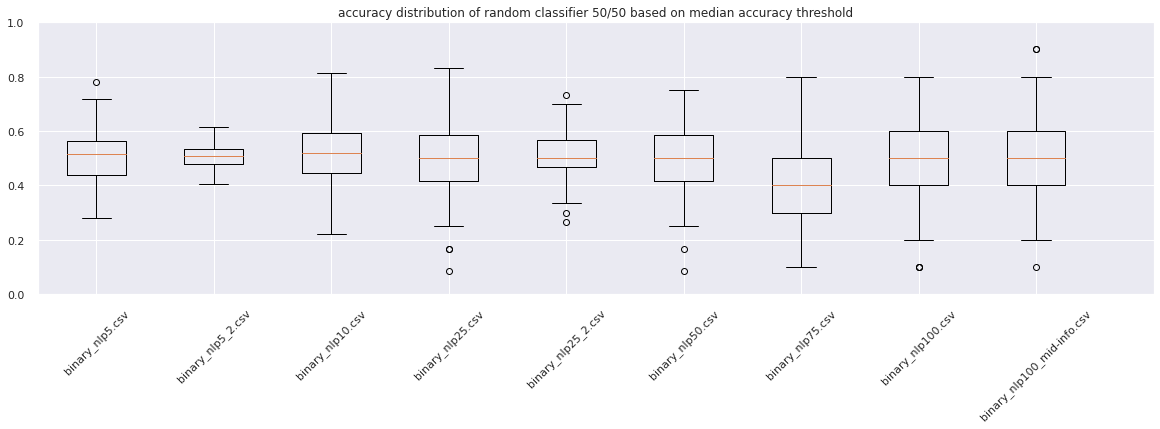

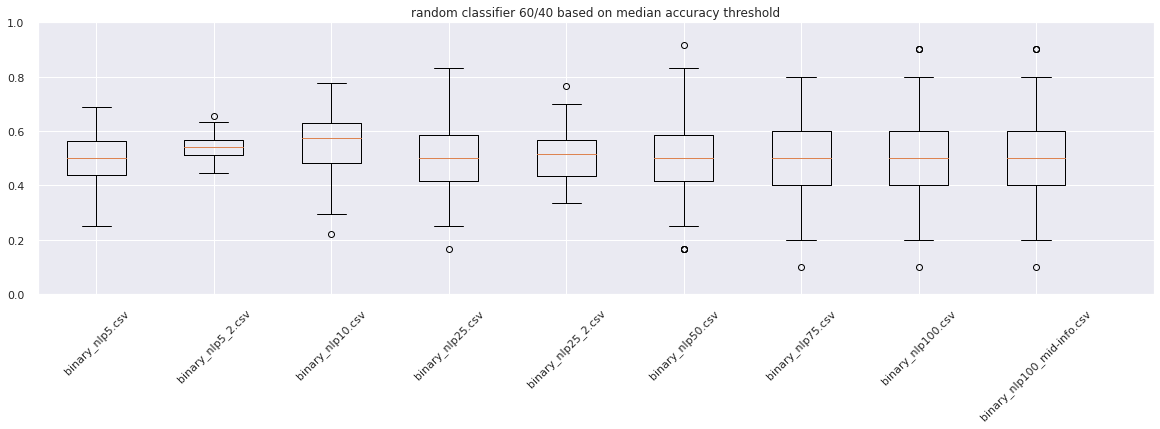

In [ ]:
plt.figure()
plt.title("accuracy distribution of random classifier 50/50 based on median accuracy threshold")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_binary_nlp_random_median)
plt.xticks(list(range(1,file_size+1)), binary_nlp_files, rotation=45)
plt.show()
plt.figure()
plt.title("random classifier 60/40 based on median accuracy threshold")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_binary_nlp_random_ratio_median)
plt.xticks(list(range(1,file_size+1)), binary_nlp_files, rotation=45)

plt.show()

###### Logistics Regression

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_binary_nlp_logistics_median = []
for i in range(np.size(binary_nlp_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_binary_nlp_median[2*i+1][j], prediction_binary_nlp_logistics_median[ITERATION*i+j]))

  prediction_accuracy_binary_nlp_logistics_median.append(pred_acc)

c = []
for j in range(np.size(binary_nlp_files)):
  c.append(np.average(prediction_accuracy_binary_nlp_logistics_median[j]))

<Figure size 1440x360 with 0 Axes>

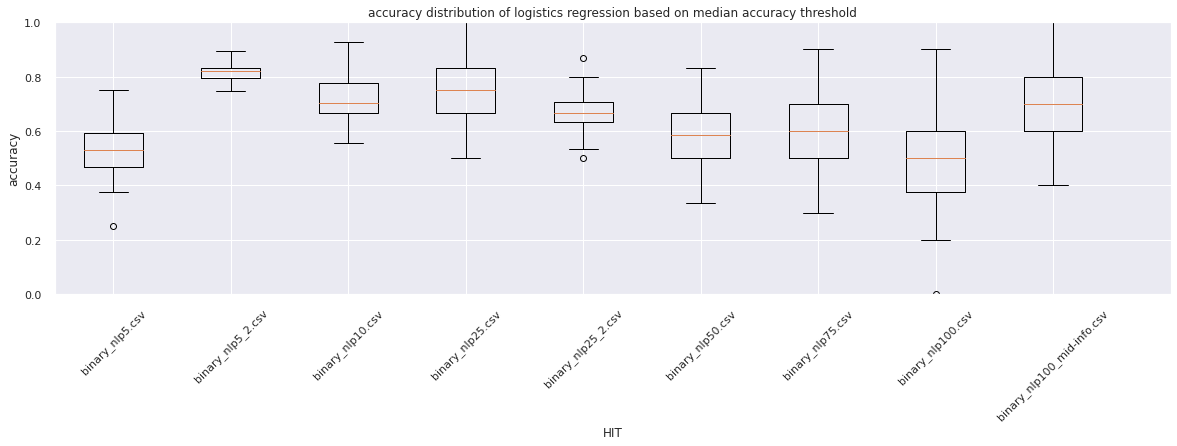

<Figure size 1440x360 with 0 Axes>

In [ ]:
plt.boxplot(prediction_accuracy_binary_nlp_logistics_median)
plt.ylim([0,1])
plt.xticks(list(range(1,file_size+1)), binary_nlp_files, rotation=45)
plt.title("accuracy distribution of logistics regression based on median accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.figure()

###### Decision Trees

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_binary_nlp_tree_median = []
for i in range(np.size(binary_nlp_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_binary_nlp_median[2*i+1][j], prediction_binary_nlp_tree_median[ITERATION*i+j]))

  prediction_accuracy_binary_nlp_tree_median.append(pred_acc)

d = []
for j in range(np.size(binary_nlp_files)):
  d.append(np.median(prediction_accuracy_binary_nlp_tree_median[j]))

(0.0, 1.0)

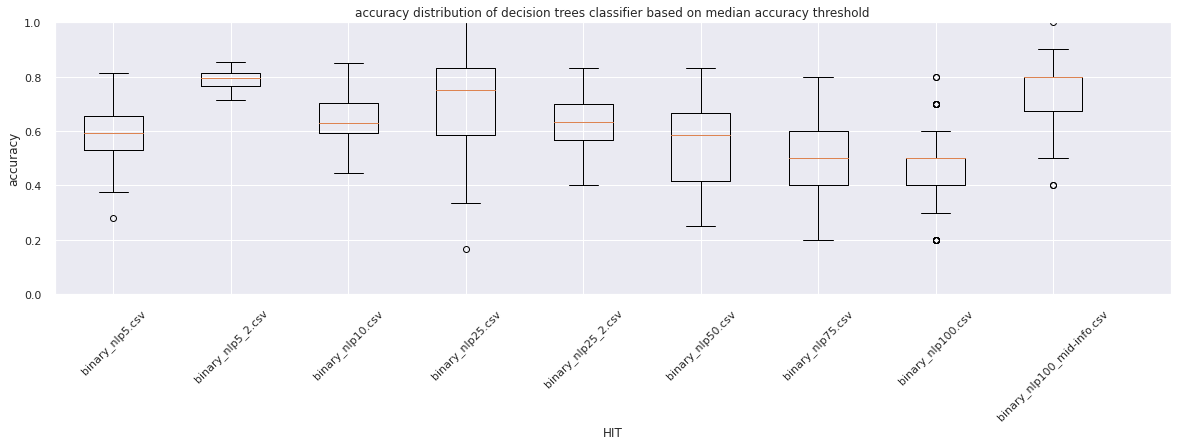

In [ ]:
plt.figure()
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_binary_nlp_tree_median)
plt.xticks(list(range(1,file_size+1)), binary_nlp_files, rotation=45)
plt.title("accuracy distribution of decision trees classifier based on median accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.ylim([0,1])

###### Random Forest

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_binary_nlp_forest_median = []
for i in range(np.size(binary_nlp_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_binary_nlp_median[2*i+1][j], prediction_binary_nlp_forest_median[ITERATION*i+j]))

  prediction_accuracy_binary_nlp_forest_median.append(pred_acc)

e = []
for j in range(np.size(binary_nlp_files)):
  e.append(np.median(prediction_accuracy_binary_nlp_forest_median[j]))

<Figure size 1440x360 with 0 Axes>

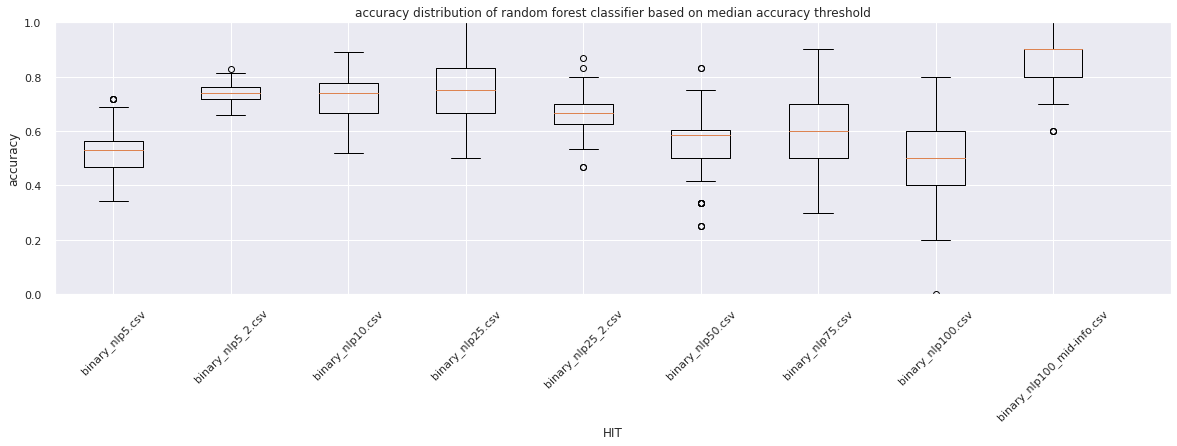

<Figure size 1440x360 with 0 Axes>

In [ ]:
plt.boxplot(prediction_accuracy_binary_nlp_forest_median)
plt.ylim([0,1])
plt.xticks(list(range(1,file_size+1)), binary_nlp_files, rotation=45)
plt.title("accuracy distribution of random forest classifier based on median accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.figure()

###### General

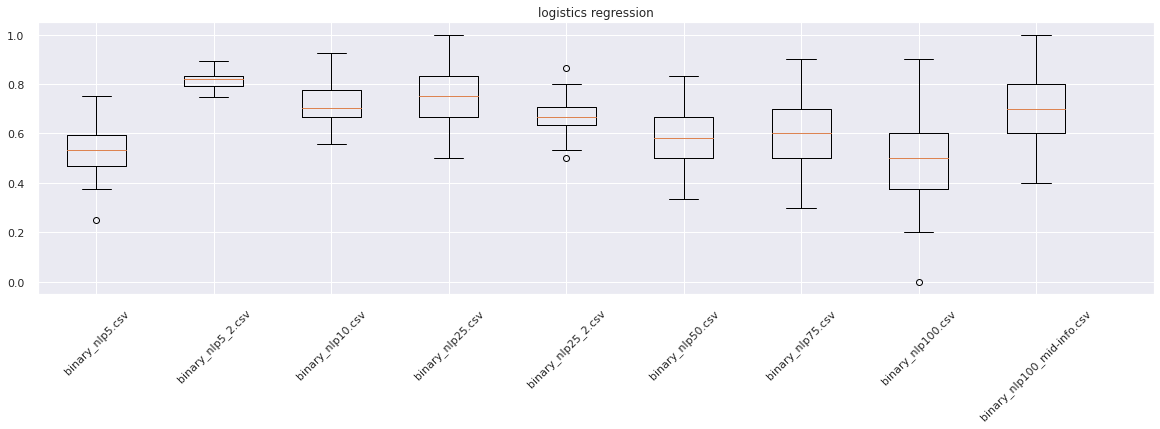

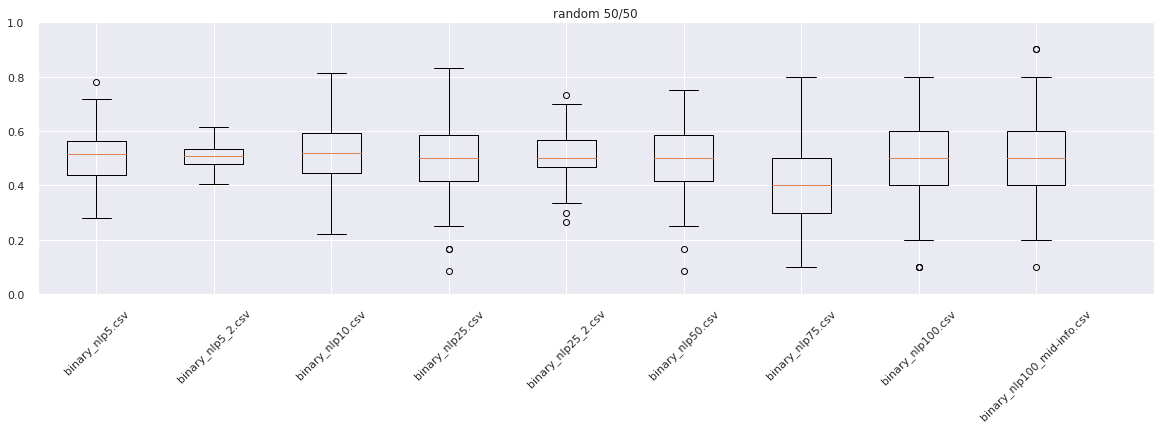

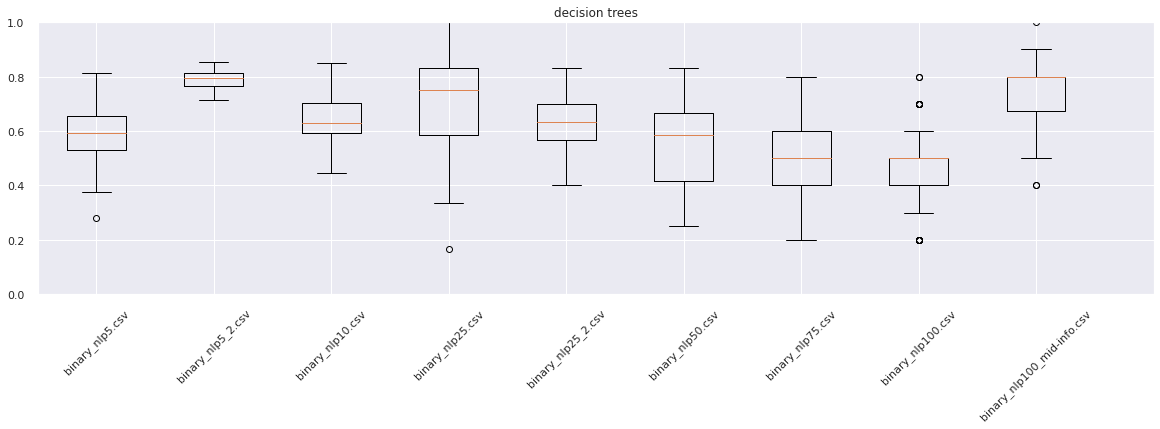

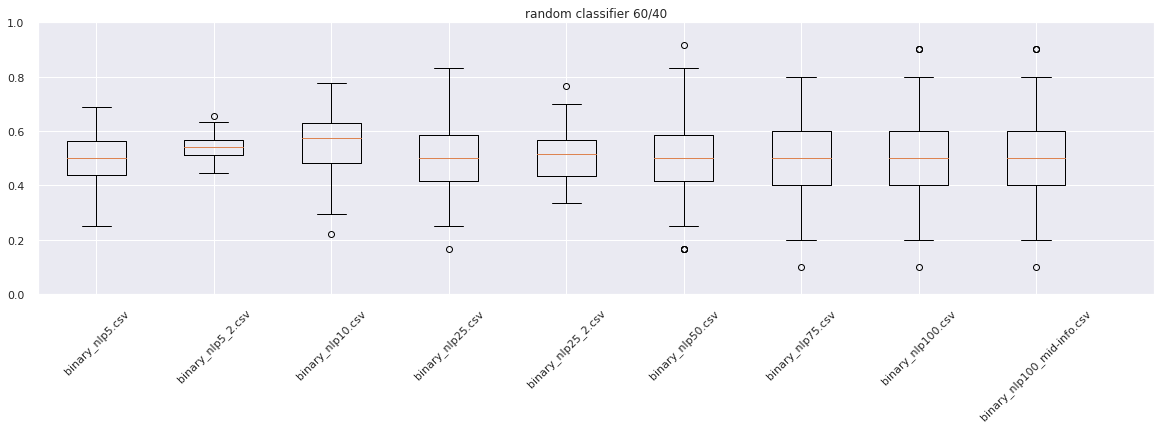

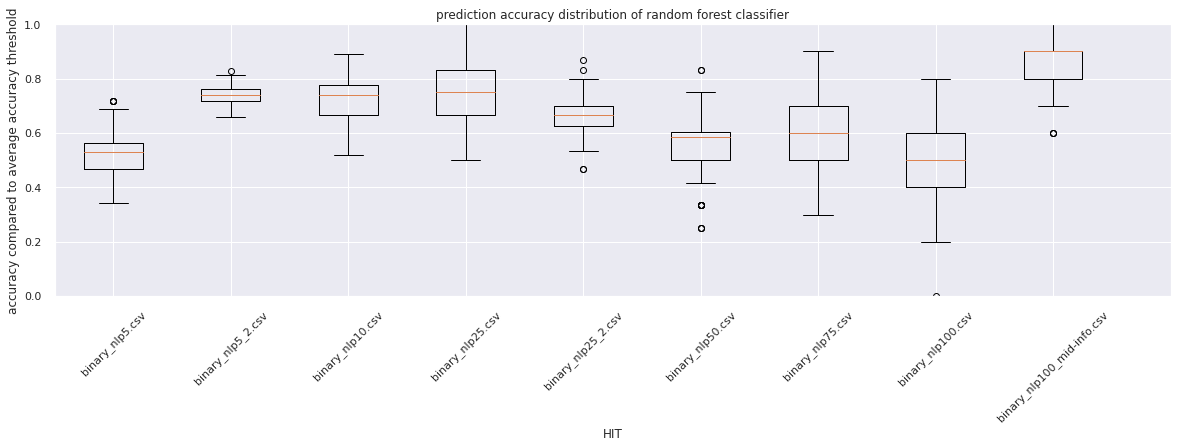

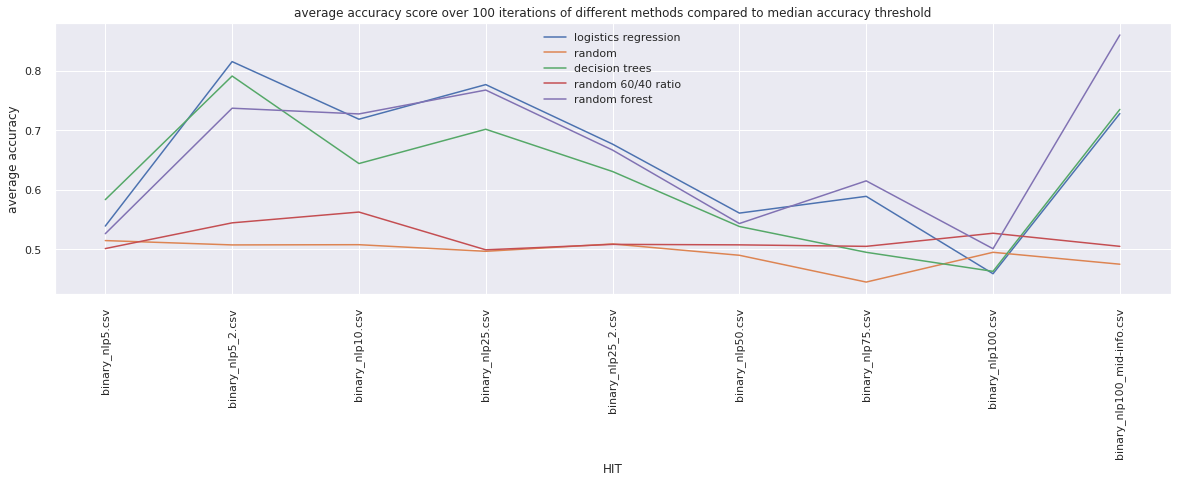

In [ ]:
plt.figure()
plt.title("logistics regression")
plt.boxplot(prediction_accuracy_binary_nlp_logistics_median)
plt.xticks(list(range(1,file_size+1)), binary_nlp_files, rotation=45)

plt.figure()
plt.ylim([0,1])
plt.title("random 50/50")
plt.boxplot(prediction_accuracy_binary_nlp_random_median)
plt.xticks(list(range(1,file_size+1)), binary_nlp_files, rotation=45)

plt.figure()
plt.ylim([0,1])
plt.title("decision trees")
plt.boxplot(prediction_accuracy_binary_nlp_tree_median)
plt.xticks(list(range(1,file_size+1)), binary_nlp_files, rotation=45)
plt.ylim([0,1])

plt.figure()
plt.title("random classifier 60/40")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_binary_nlp_random_ratio_median)
plt.xticks(list(range(1,file_size+1)), binary_nlp_files, rotation=45)
plt.show()

plt.figure()
plt.title("prediction accuracy distribution of random forest classifier")
plt.xlabel("HIT")
plt.ylabel("accuracy compared to average accuracy threshold")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_binary_nlp_forest_median)
plt.xticks(list(range(1,file_size+1)), binary_nlp_files, rotation=45)

plt.show()


plt.figure()
plt.title("average accuracy score over " + str(ITERATION) + " iterations of different methods compared to median accuracy threshold")
plt.xlabel('HIT')
plt.xticks(rotation=90)
plt.ylabel('average accuracy')
#plt.ylim([0.4,0.8])
a,b,c,d,e = [],[],[],[],[]

for i in range(np.size(binary_nlp_files)):
  a.append(np.average(prediction_accuracy_binary_nlp_logistics_median[i]))
  b.append(np.average(prediction_accuracy_binary_nlp_random_median[i]))
  c.append(np.average(prediction_accuracy_binary_nlp_tree_median[i]))
  d.append(np.average(prediction_accuracy_binary_nlp_random_ratio_median[i]))
  e.append(np.average(prediction_accuracy_binary_nlp_forest_median[i]))


plt.plot(binary_nlp_files,a)
plt.plot(binary_nlp_files,b)
plt.plot(binary_nlp_files,c)
plt.plot(binary_nlp_files,d)
plt.plot(binary_nlp_files,e)

leg = ["logistics regression","random","decision trees","random 60/40 ratio", "random forest"]
plt.legend(leg)
plt.show()



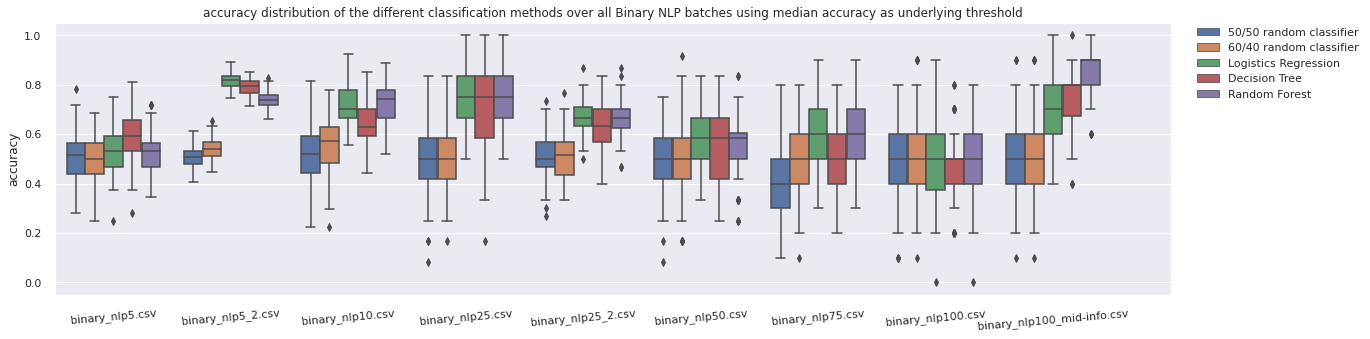

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(44)
# DATAFRAMES WITH TRIAL COLUMN ASSIGNED

box = []

for i in range(np.size(binary_nlp_files)):
  data = [prediction_accuracy_binary_nlp_random_median[i],prediction_accuracy_binary_nlp_random_ratio_median[i],prediction_accuracy_binary_nlp_logistics_median[i],prediction_accuracy_binary_nlp_tree_median[i],prediction_accuracy_binary_nlp_forest_median[i]]
  data = np.array(data) .T.tolist()
  box.append(pd.DataFrame(data, columns=["50/50 random classifier","60/40 random classifier","Logistics Regression","Decision Tree","Random Forest"]).assign(Trial=i))
  #box2.append(pd.DataFrame(prediction_accuracy_binary_nlp_tree_average[i], columns=[binary_nlp_files[i]]).assign(Trial=i))


cdf = pd.concat(box)                           # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Trial'], var_name=['Method'])      # MELT

sns.set(rc={"figure.figsize":(20, 5)}) 
ax = sns.boxplot(x="Trial", y="value", hue="Method", data=mdf)

plt.title("accuracy distribution of the different classification methods over all Binary NLP batches using median accuracy as underlying threshold")
plt.ylabel("accuracy")
plt.xlabel("")
plt.xticks(list(range(file_size)), binary_nlp_files, rotation=5)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.show()

'''
for i in range(np.size(binary_nlp_files)):
  ax = sns.boxplot(data=box[i])  # RUN PLOT   
  plt.show()
'''
plt.clf()
plt.close()

##### Fixed Threshold

###### Random Classifier

In [ ]:
prediction_accuracy_binary_nlp_random_fixed = []
prediction_accuracy_binary_nlp_random_ratio_fixed = []
for i in range(np.size(binary_nlp_files)):
  pred_acc = []
  pred_acc_ratio = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_binary_nlp_fixed[2*i+1][j], binary_nlp_random_classification_fixed[ITERATION*i+j]))
    
    pred_acc_ratio.append(metrics.accuracy_score(Y_binary_nlp_fixed[2*i+1][j], binary_nlp_random_ratio_classification_fixed[ITERATION*i+j]))
    

  prediction_accuracy_binary_nlp_random_fixed.append(pred_acc)
  prediction_accuracy_binary_nlp_random_ratio_fixed.append(pred_acc_ratio)

a,b = [],[]
for j in range(np.size(binary_nlp_files)):
  a.append(np.average(prediction_accuracy_binary_nlp_random_average[j]))
  b.append(np.average(prediction_accuracy_binary_nlp_random_ratio_average[j]))

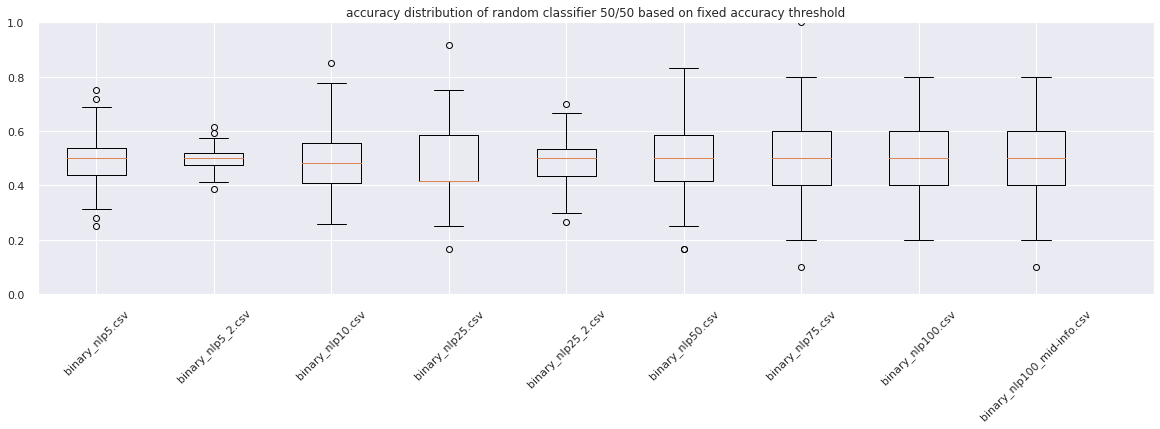

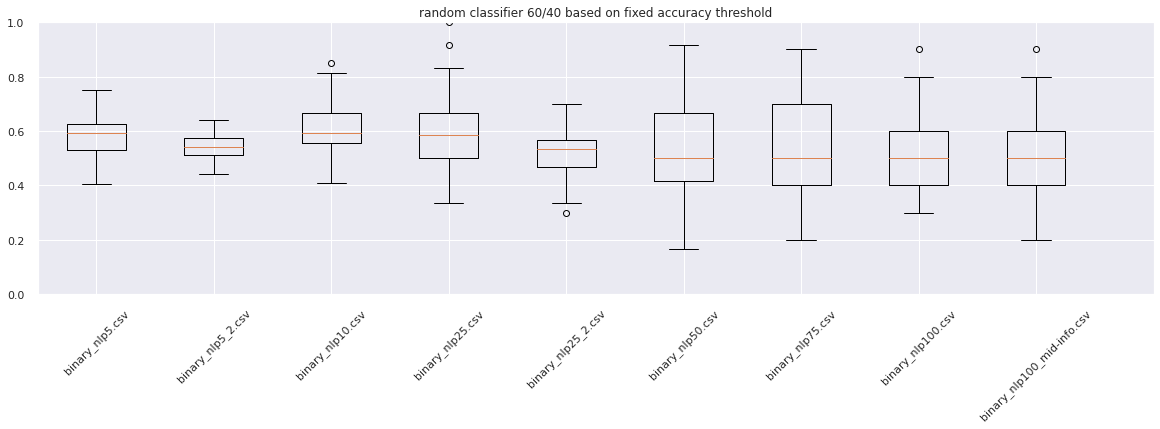

In [ ]:
plt.figure()
plt.title("accuracy distribution of random classifier 50/50 based on fixed accuracy threshold")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_binary_nlp_random_fixed)
plt.xticks(list(range(1,file_size+1)), binary_nlp_files, rotation=45)
plt.show()
plt.figure()
plt.title("random classifier 60/40 based on fixed accuracy threshold")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_binary_nlp_random_ratio_fixed)
plt.xticks(list(range(1,file_size+1)), binary_nlp_files, rotation=45)

plt.show()

###### Logistics Regression

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_binary_nlp_logistics_fixed = []
for i in range(np.size(binary_nlp_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_binary_nlp_fixed[2*i+1][j], prediction_binary_nlp_logistics_fixed[ITERATION*i+j]))

  prediction_accuracy_binary_nlp_logistics_fixed.append(pred_acc)

c = []
for j in range(np.size(binary_nlp_files)):
  c.append(np.average(prediction_accuracy_binary_nlp_logistics_fixed[j]))

<Figure size 1440x360 with 0 Axes>

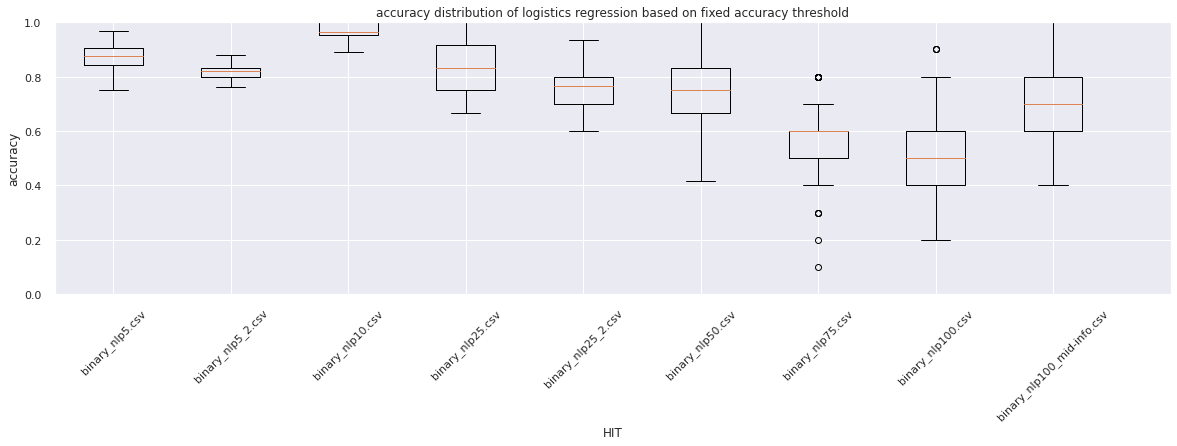

<Figure size 1440x360 with 0 Axes>

In [ ]:
plt.boxplot(prediction_accuracy_binary_nlp_logistics_fixed)
plt.ylim([0,1])
plt.xticks(list(range(1,file_size+1)), binary_nlp_files, rotation=45)
plt.title("accuracy distribution of logistics regression based on fixed accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.figure()

###### Decision Trees

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_binary_nlp_tree_fixed = []
for i in range(np.size(binary_nlp_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_binary_nlp_fixed[2*i+1][j], prediction_binary_nlp_tree_fixed[ITERATION*i+j]))

  prediction_accuracy_binary_nlp_tree_fixed.append(pred_acc)

d = []
for j in range(np.size(binary_nlp_files)):
  d.append(np.average(prediction_accuracy_binary_nlp_tree_fixed[j]))

(0.0, 1.0)

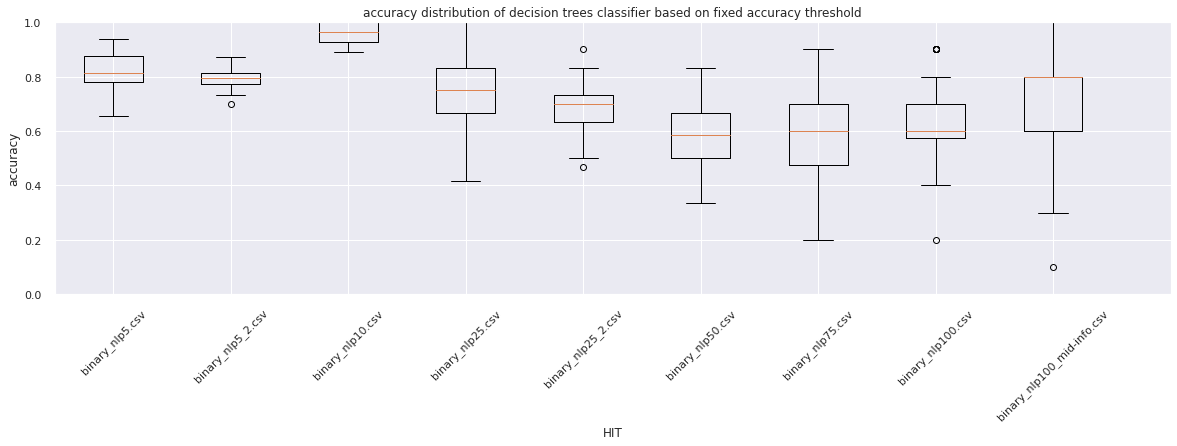

In [ ]:
plt.figure()
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_binary_nlp_tree_fixed)
plt.xticks(list(range(1,file_size+1)), binary_nlp_files, rotation=45)
plt.title("accuracy distribution of decision trees classifier based on fixed accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.ylim([0,1])

###### Random Forest

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_binary_nlp_forest_fixed = []
for i in range(np.size(binary_nlp_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_binary_nlp_fixed[2*i+1][j], prediction_binary_nlp_forest_fixed[ITERATION*i+j]))

  prediction_accuracy_binary_nlp_forest_fixed.append(pred_acc)

e = []
for j in range(np.size(binary_nlp_files)):
  e.append(np.average(prediction_accuracy_binary_nlp_forest_fixed[j]))

<Figure size 1440x360 with 0 Axes>

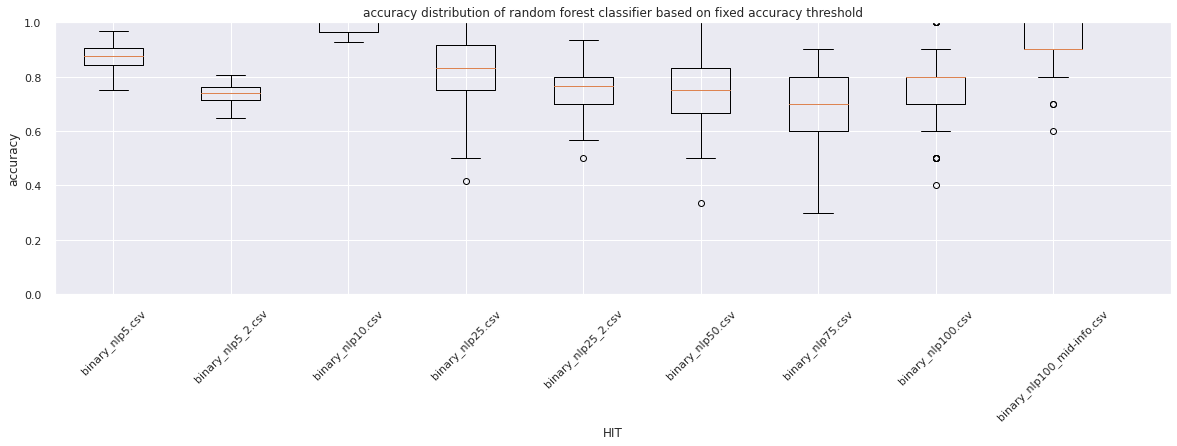

<Figure size 1440x360 with 0 Axes>

In [ ]:
plt.boxplot(prediction_accuracy_binary_nlp_forest_fixed)
plt.ylim([0,1])
plt.xticks(list(range(1,file_size+1)), binary_nlp_files, rotation=45)
plt.title("accuracy distribution of random forest classifier based on fixed accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.figure()

###### General

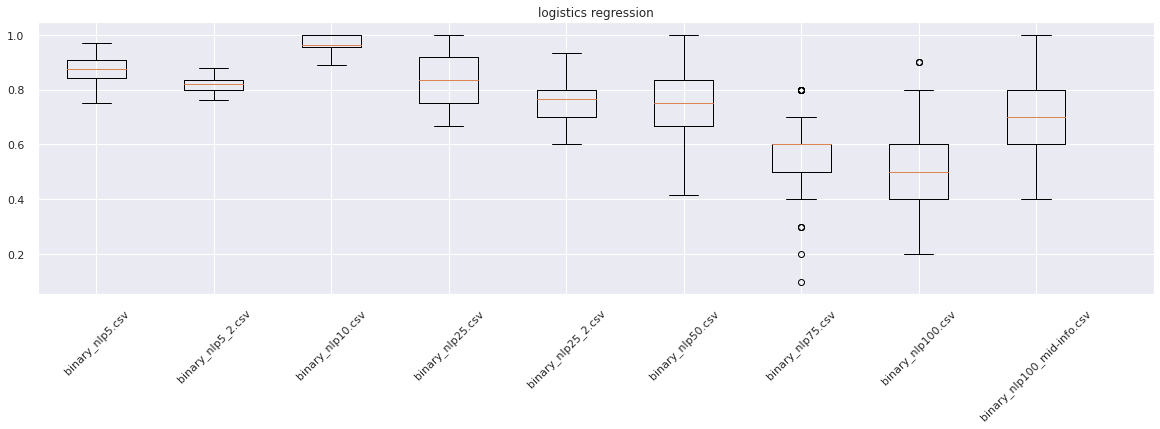

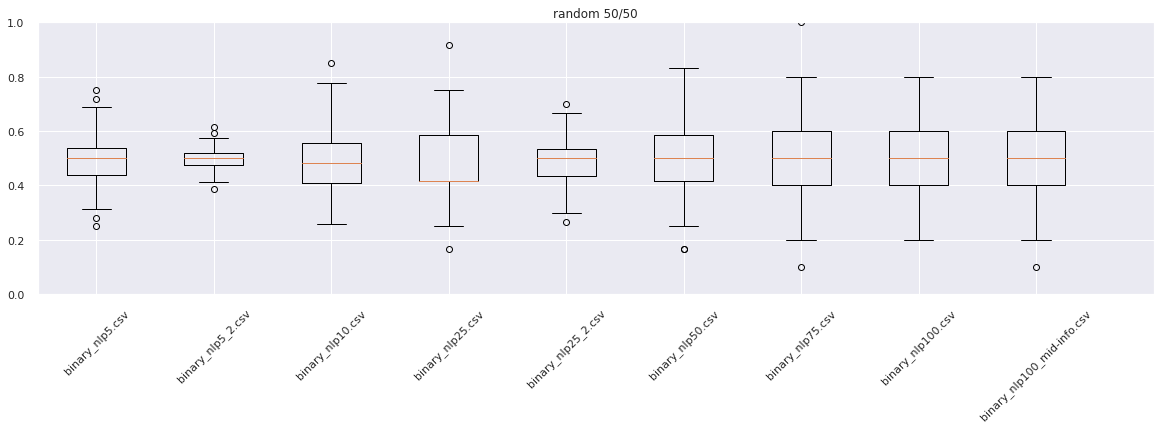

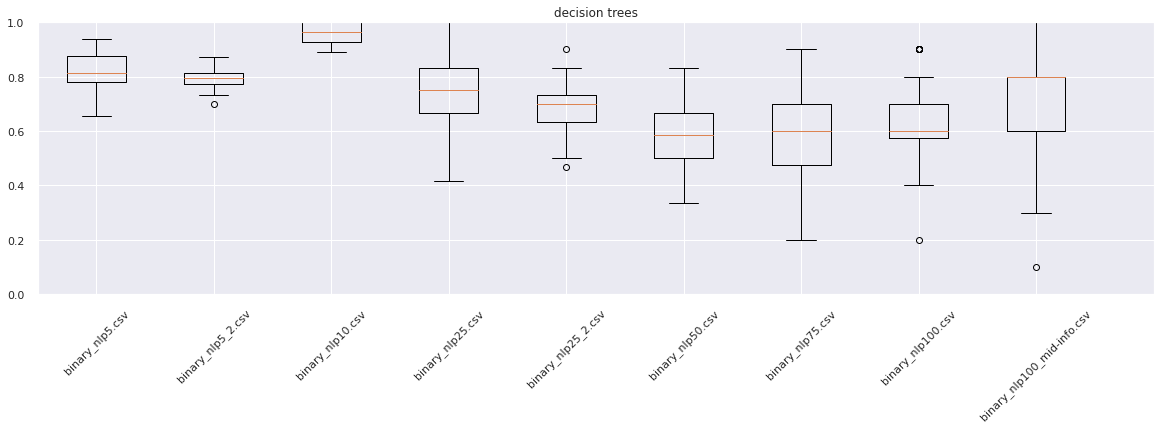

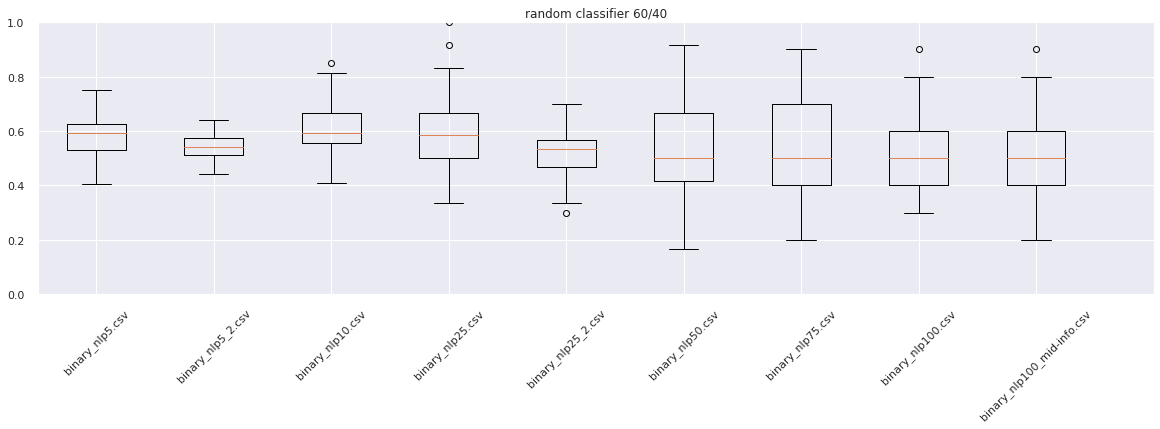

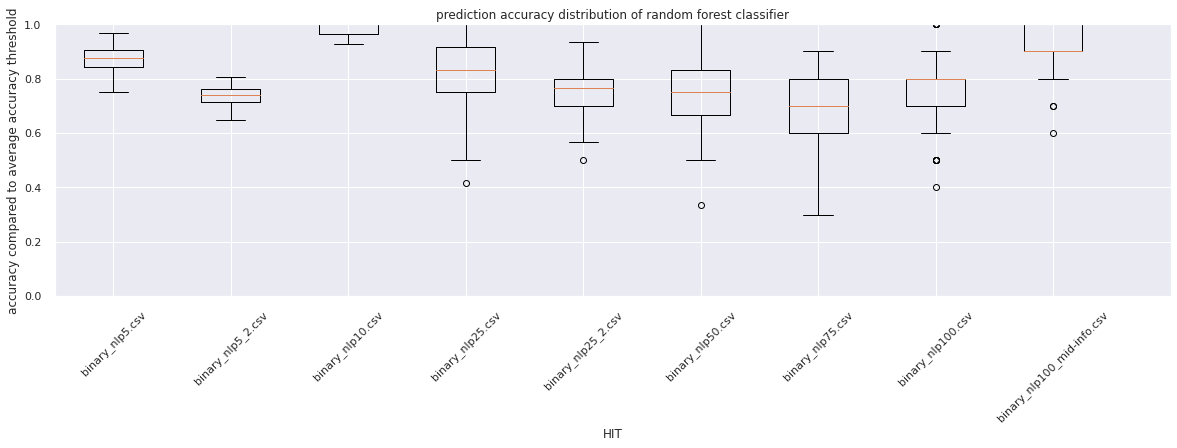

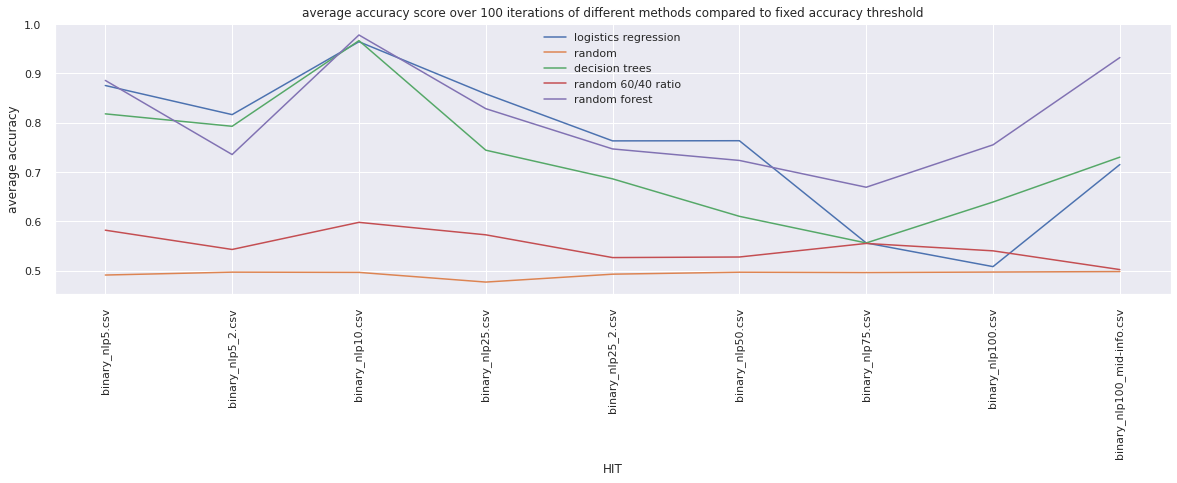

In [ ]:
plt.figure()
plt.title("logistics regression")
plt.boxplot(prediction_accuracy_binary_nlp_logistics_fixed)
plt.xticks(list(range(1,file_size+1)), binary_nlp_files, rotation=45)

plt.figure()
plt.ylim([0,1])
plt.title("random 50/50")
plt.boxplot(prediction_accuracy_binary_nlp_random_fixed)
plt.xticks(list(range(1,file_size+1)), binary_nlp_files, rotation=45)

plt.figure()
plt.ylim([0,1])
plt.title("decision trees")
plt.boxplot(prediction_accuracy_binary_nlp_tree_fixed)
plt.xticks(list(range(1,file_size+1)), binary_nlp_files, rotation=45)
plt.ylim([0,1])

plt.figure()
plt.title("random classifier 60/40")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_binary_nlp_random_ratio_fixed)
plt.xticks(list(range(1,file_size+1)), binary_nlp_files, rotation=45)
plt.show()

plt.figure()
plt.title("prediction accuracy distribution of random forest classifier")
plt.xlabel("HIT")
plt.ylabel("accuracy compared to average accuracy threshold")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_binary_nlp_forest_fixed)
plt.xticks(list(range(1,file_size+1)), binary_nlp_files, rotation=45)

plt.show()


plt.figure()
plt.title("average accuracy score over " + str(ITERATION) + " iterations of different methods compared to fixed accuracy threshold")
plt.xlabel('HIT')
plt.xticks(rotation=90)
plt.ylabel('average accuracy')
#plt.ylim([0.4,0.8])
a,b,c,d,e = [],[],[],[],[]

for i in range(np.size(binary_nlp_files)):
  a.append(np.average(prediction_accuracy_binary_nlp_logistics_fixed[i]))
  b.append(np.average(prediction_accuracy_binary_nlp_random_fixed[i]))
  c.append(np.average(prediction_accuracy_binary_nlp_tree_fixed[i]))
  d.append(np.average(prediction_accuracy_binary_nlp_random_ratio_fixed[i]))
  e.append(np.average(prediction_accuracy_binary_nlp_forest_fixed[i]))


plt.plot(binary_nlp_files,a)
plt.plot(binary_nlp_files,b)
plt.plot(binary_nlp_files,c)
plt.plot(binary_nlp_files,d)
plt.plot(binary_nlp_files,e)

leg = ["logistics regression","random","decision trees","random 60/40 ratio", "random forest"]
plt.legend(leg)
plt.show()



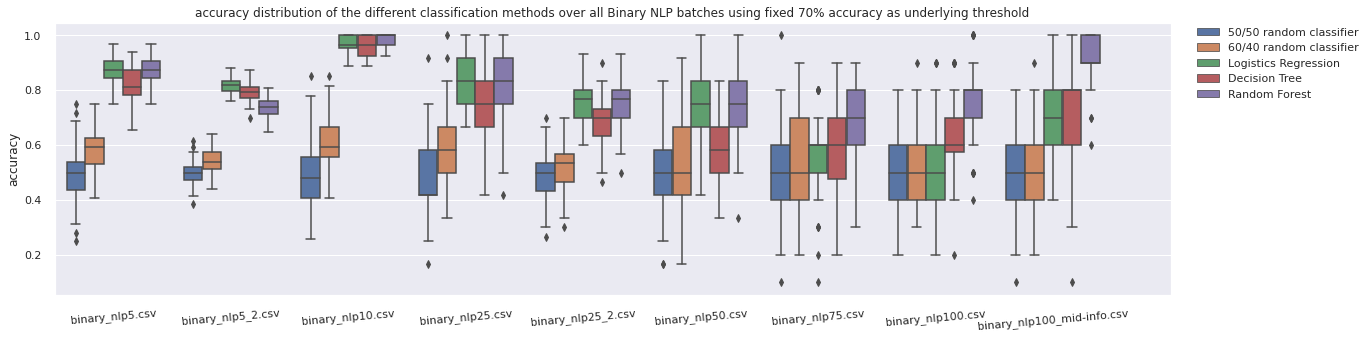

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(44)
# DATAFRAMES WITH TRIAL COLUMN ASSIGNED

box = []

for i in range(np.size(binary_nlp_files)):
  data = [prediction_accuracy_binary_nlp_random_fixed[i],prediction_accuracy_binary_nlp_random_ratio_fixed[i],prediction_accuracy_binary_nlp_logistics_fixed[i],prediction_accuracy_binary_nlp_tree_fixed[i],prediction_accuracy_binary_nlp_forest_fixed[i]]
  data = np.array(data) .T.tolist()
  box.append(pd.DataFrame(data, columns=["50/50 random classifier","60/40 random classifier","Logistics Regression","Decision Tree","Random Forest"]).assign(Trial=i))
  #box2.append(pd.DataFrame(prediction_accuracy_binary_nlp_tree_average[i], columns=[binary_nlp_files[i]]).assign(Trial=i))


cdf = pd.concat(box)                           # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Trial'], var_name=['Method'])      # MELT

sns.set(rc={"figure.figsize":(20, 5)}) 
ax = sns.boxplot(x="Trial", y="value", hue="Method", data=mdf)

plt.title("accuracy distribution of the different classification methods over all Binary NLP batches using fixed 70% accuracy as underlying threshold")
plt.ylabel("accuracy")
plt.xlabel("")
plt.xticks(list(range(0,file_size)), binary_nlp_files, rotation=5)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.show()

'''
for i in range(np.size(binary_nlp_files)):
  ax = sns.boxplot(data=box[i])  # RUN PLOT   
  plt.show()
'''
plt.clf()
plt.close()

#### Multiclass Vision

In [ ]:
file_size = np.size(vision_files)

##### Average Threshold

###### Random Classifier

In [ ]:
prediction_accuracy_vision_random_average = []
prediction_accuracy_vision_random_ratio_average = []
for i in range(np.size(vision_files)):
  pred_acc = []
  pred_acc_ratio = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_vision_average[2*i+1][j], vision_random_classification_average[ITERATION*i+j]))
    
    pred_acc_ratio.append(metrics.accuracy_score(Y_vision_average[2*i+1][j], vision_random_ratio_classification_average[ITERATION*i+j]))
    

  prediction_accuracy_vision_random_average.append(pred_acc)
  prediction_accuracy_vision_random_ratio_average.append(pred_acc_ratio)

a,b = [],[]
for j in range(np.size(vision_files)):
  a.append(np.average(prediction_accuracy_vision_random_average[j]))
  b.append(np.average(prediction_accuracy_vision_random_ratio_average[j]))

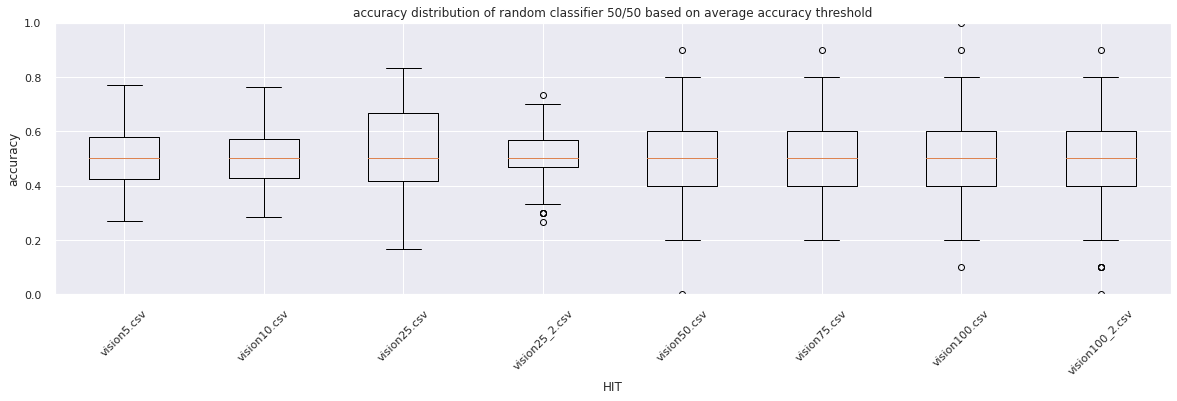

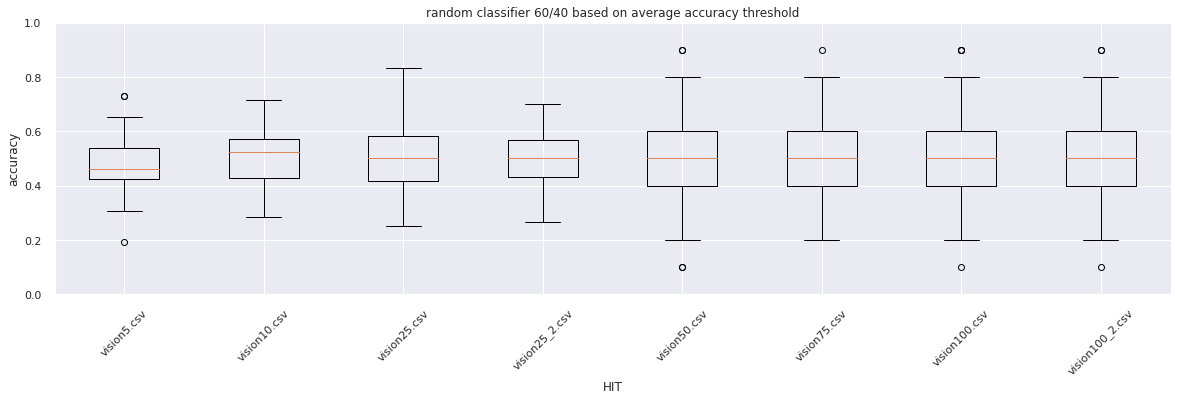

In [ ]:
plt.figure()
plt.title("accuracy distribution of random classifier 50/50 based on average accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_vision_random_average)
plt.xticks(list(range(1,file_size+1)), vision_files, rotation=45)
plt.show()
plt.figure()
plt.title("random classifier 60/40 based on average accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_vision_random_ratio_average)
plt.xticks(list(range(1,file_size+1)), vision_files, rotation=45)

plt.show()

###### Logistics Regression

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_vision_logistics_average = []
for i in range(np.size(vision_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_vision_average[2*i+1][j], prediction_vision_logistics_average[ITERATION*i+j]))

  prediction_accuracy_vision_logistics_average.append(pred_acc)

c = []
for j in range(np.size(vision_files)):
  c.append(np.average(prediction_accuracy_vision_logistics_average[j]))

<Figure size 1440x360 with 0 Axes>

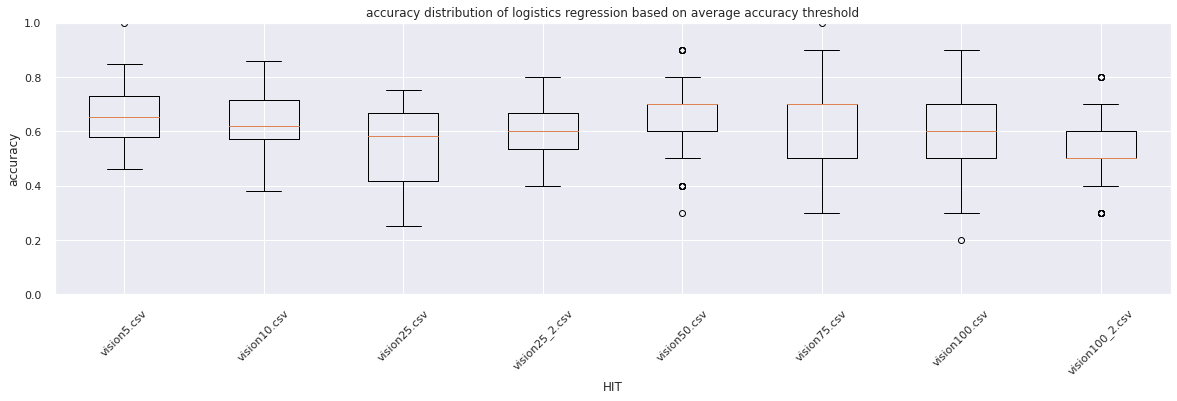

<Figure size 1440x360 with 0 Axes>

In [ ]:
plt.boxplot(prediction_accuracy_vision_logistics_average)
plt.ylim([0,1])
plt.xticks(list(range(1,file_size+1)), vision_files, rotation=45)
plt.title("accuracy distribution of logistics regression based on average accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.figure()

###### Decision Trees

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_vision_tree_average = []
for i in range(np.size(vision_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_vision_average[2*i+1][j], prediction_vision_tree_average[ITERATION*i+j]))

  prediction_accuracy_vision_tree_average.append(pred_acc)

d = []
for j in range(np.size(vision_files)):
  d.append(np.average(prediction_accuracy_vision_tree_average[j]))

(0.0, 1.0)

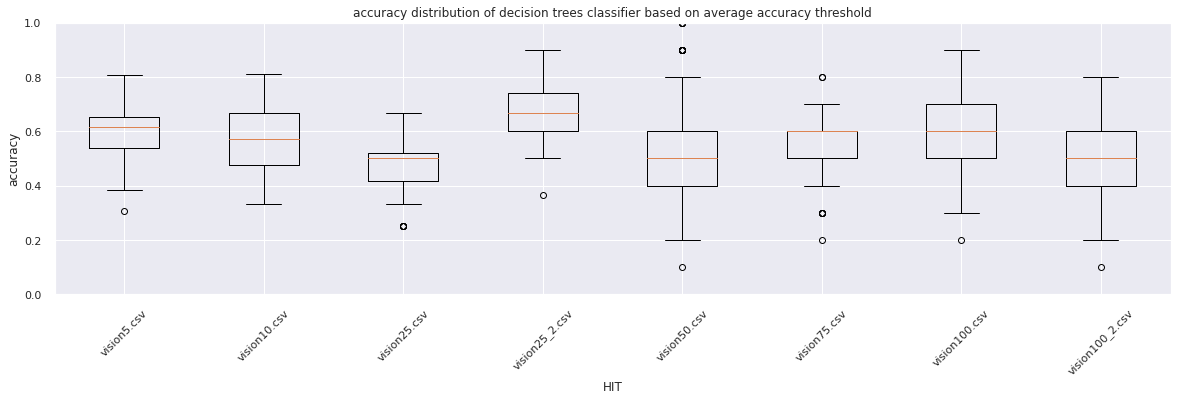

In [ ]:
plt.figure()
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_vision_tree_average)
plt.xticks(list(range(1,file_size+1)), vision_files, rotation=45)
plt.title("accuracy distribution of decision trees classifier based on average accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.ylim([0,1])

###### Random Forest

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_vision_forest_average = []
for i in range(np.size(vision_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_vision_average[2*i+1][j], prediction_vision_forest_average[ITERATION*i+j]))

  prediction_accuracy_vision_forest_average.append(pred_acc)

e = []
for j in range(np.size(vision_files)):
  e.append(np.average(prediction_accuracy_vision_forest_average[j]))

<Figure size 1440x360 with 0 Axes>

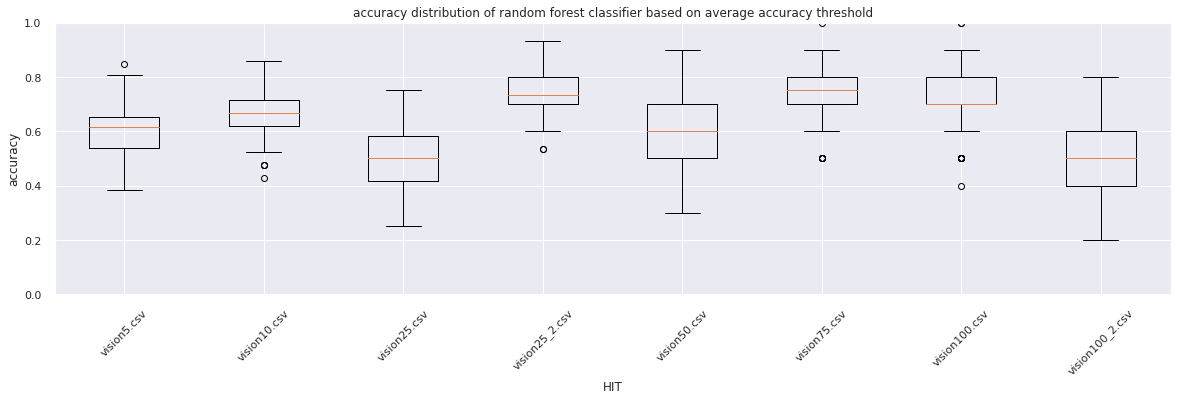

<Figure size 1440x360 with 0 Axes>

In [ ]:
plt.boxplot(prediction_accuracy_vision_forest_average)
plt.ylim([0,1])
plt.xticks(list(range(1,file_size+1)), vision_files, rotation=45)
plt.title("accuracy distribution of random forest classifier based on average accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.figure()

###### General

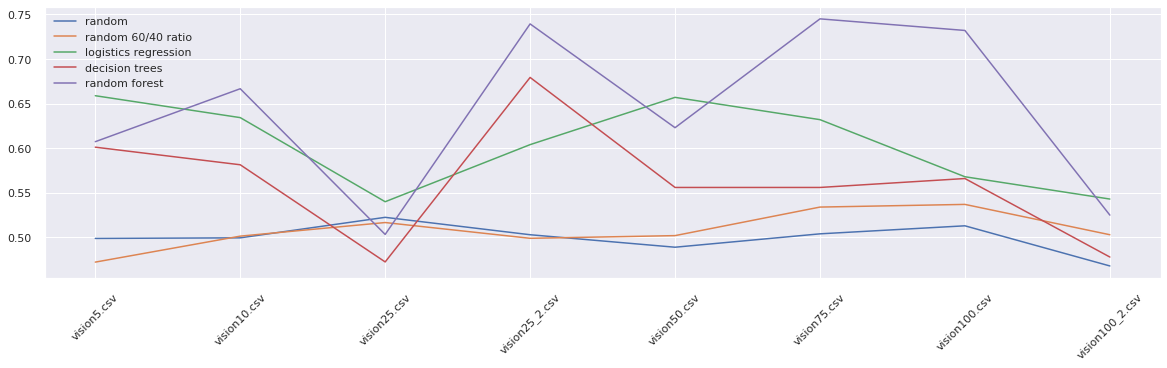

In [ ]:
plt.plot(vision_files,a)
plt.plot(vision_files,b)
plt.plot(vision_files,c)
plt.plot(vision_files,d)
plt.plot(vision_files,e)

leg = ["random","random 60/40 ratio","logistics regression","decision trees", "random forest"]
plt.legend(leg)
plt.xticks(vision_files, rotation=45)
plt.show()



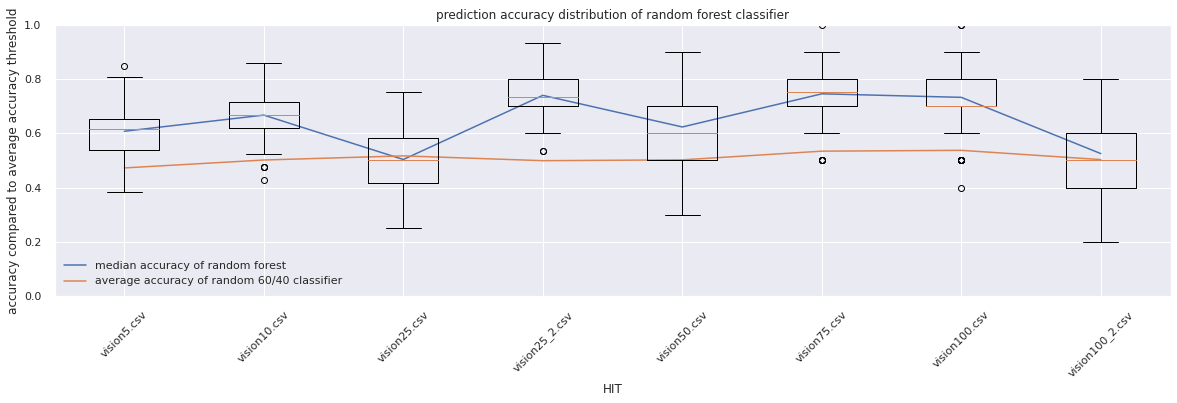

In [ ]:
plt.figure()
plt.title("prediction accuracy distribution of random forest classifier")
plt.xlabel("HIT")
plt.ylabel("accuracy compared to average accuracy threshold")
plt.ylim([0,1])

plt.plot(list(range(1,file_size+1)),e)
plt.plot(list(range(1,file_size+1)),b)
plt.legend(["median accuracy of random forest","average accuracy of random 60/40 classifier"])
plt.boxplot(prediction_accuracy_vision_forest_average)

plt.xticks(list(range(1,file_size+1)), vision_files, rotation=45)
plt.show()

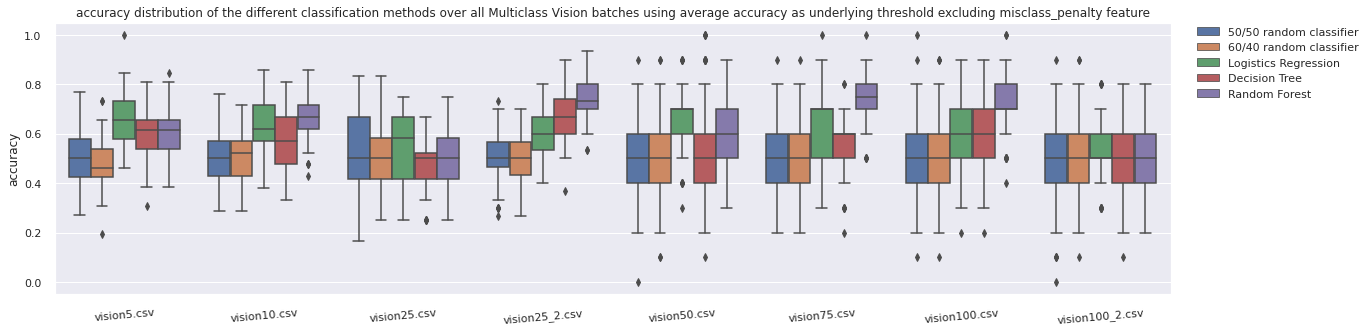

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(44)
# DATAFRAMES WITH TRIAL COLUMN ASSIGNED

box = []

for i in range(np.size(vision_files)):
  data = [prediction_accuracy_vision_random_average[i],prediction_accuracy_vision_random_ratio_average[i],prediction_accuracy_vision_logistics_average[i],prediction_accuracy_vision_tree_average[i],prediction_accuracy_vision_forest_average[i]]
  data = np.array(data) .T.tolist()
  box.append(pd.DataFrame(data, columns=["50/50 random classifier","60/40 random classifier","Logistics Regression","Decision Tree","Random Forest"]).assign(Trial=i))
  #box2.append(pd.DataFrame(prediction_accuracy_vision_tree_average[i], columns=[vision_files[i]]).assign(Trial=i))


cdf = pd.concat(box)                           # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Trial'], var_name=['Method'])      # MELT

sns.set(rc={"figure.figsize":(20, 5)}) 
ax = sns.boxplot(x="Trial", y="value", hue="Method", data=mdf)

plt.title("accuracy distribution of the different classification methods over all Multiclass Vision batches using average accuracy as underlying threshold excluding misclass_penalty feature")
plt.ylabel("accuracy")
plt.xlabel("")
plt.xticks(list(range(file_size)), vision_files, rotation=5)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.show()

'''
for i in range(np.size(vision_files)):
  ax = sns.boxplot(data=box[i])  # RUN PLOT   
  plt.show()
'''
plt.clf()
plt.close()

##### Median Threshold

###### Random Classifier

In [ ]:
prediction_accuracy_vision_random_median = []
prediction_accuracy_vision_random_ratio_median = []
for i in range(np.size(vision_files)):
  pred_acc = []
  pred_acc_ratio = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_vision_median[2*i+1][j], vision_random_classification_median[ITERATION*i+j]))
    
    pred_acc_ratio.append(metrics.accuracy_score(Y_vision_median[2*i+1][j], vision_random_ratio_classification_median[ITERATION*i+j]))
    

  prediction_accuracy_vision_random_median.append(pred_acc)
  prediction_accuracy_vision_random_ratio_median.append(pred_acc_ratio)

a,b = [],[]
for j in range(np.size(vision_files)):
  a.append(np.average(prediction_accuracy_vision_random_median[j]))
  b.append(np.average(prediction_accuracy_vision_random_ratio_median[j]))

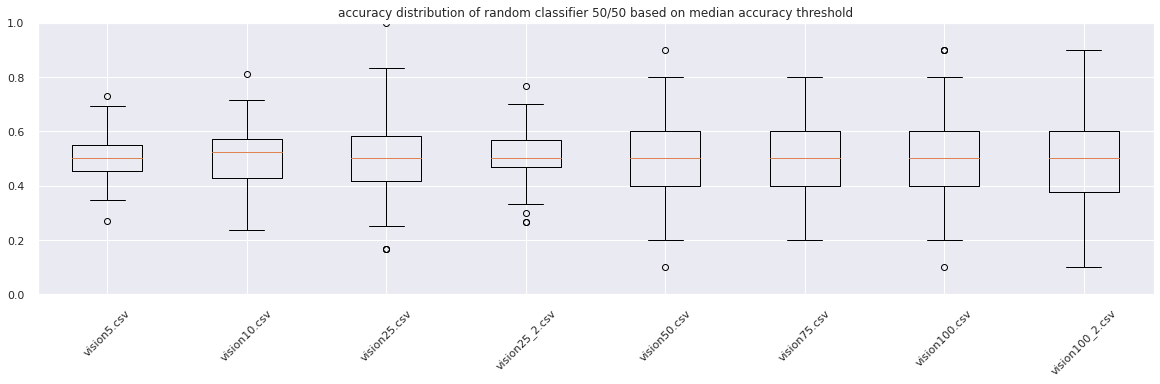

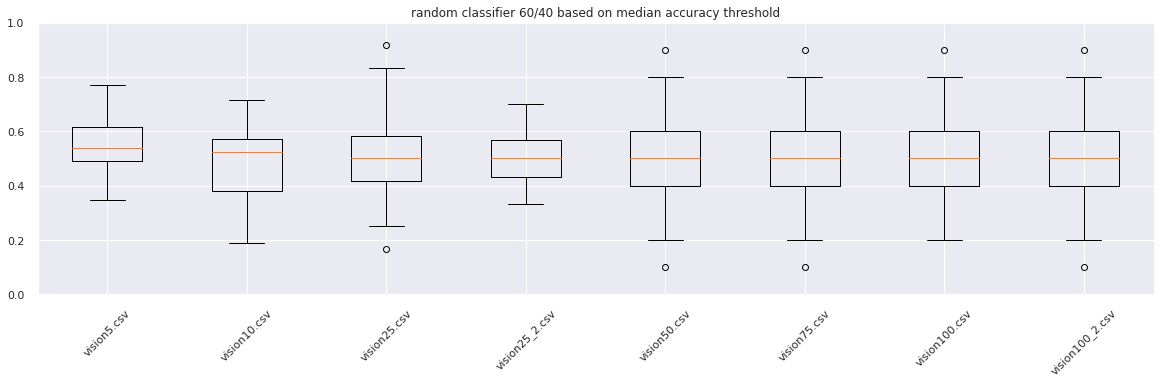

In [ ]:
plt.figure()
plt.title("accuracy distribution of random classifier 50/50 based on median accuracy threshold")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_vision_random_median)
plt.xticks(list(range(1,file_size+1)), vision_files, rotation=45)
plt.show()
plt.figure()
plt.title("random classifier 60/40 based on median accuracy threshold")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_vision_random_ratio_median)
plt.xticks(list(range(1,file_size+1)), vision_files, rotation=45)

plt.show()

###### Logistics Regression

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_vision_logistics_median = []
for i in range(np.size(vision_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_vision_median[2*i+1][j], prediction_vision_logistics_median[ITERATION*i+j]))

  prediction_accuracy_vision_logistics_median.append(pred_acc)

c = []
for j in range(np.size(vision_files)):
  c.append(np.average(prediction_accuracy_vision_logistics_median[j]))

<Figure size 1440x360 with 0 Axes>

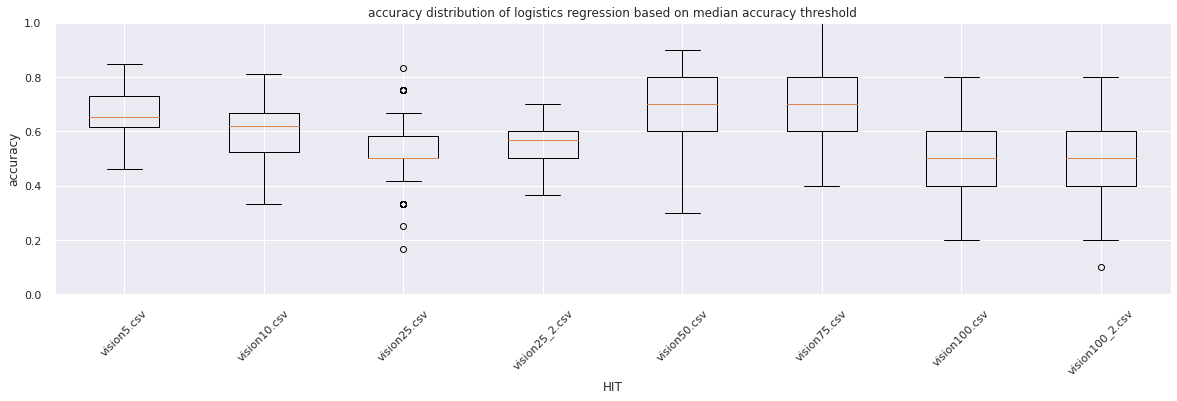

<Figure size 1440x360 with 0 Axes>

In [ ]:
plt.boxplot(prediction_accuracy_vision_logistics_median)
plt.ylim([0,1])
plt.xticks(list(range(1,file_size+1)), vision_files, rotation=45)
plt.title("accuracy distribution of logistics regression based on median accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.figure()

###### Decision Trees

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_vision_tree_median = []
for i in range(np.size(vision_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_vision_median[2*i+1][j], prediction_vision_tree_median[ITERATION*i+j]))

  prediction_accuracy_vision_tree_median.append(pred_acc)

d = []
for j in range(np.size(vision_files)):
  d.append(np.median(prediction_accuracy_vision_tree_median[j]))

(0.0, 1.0)

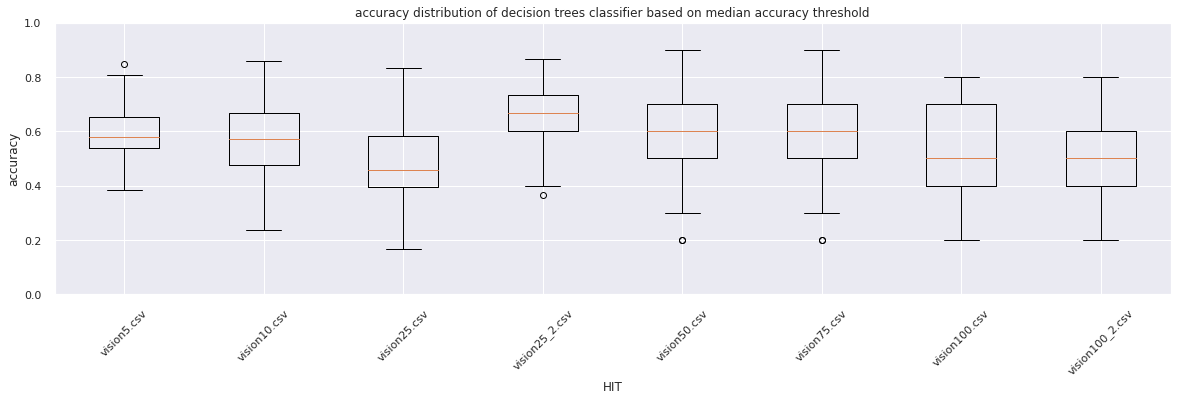

In [ ]:
plt.figure()
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_vision_tree_median)
plt.xticks(list(range(1,file_size+1)), vision_files, rotation=45)
plt.title("accuracy distribution of decision trees classifier based on median accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.ylim([0,1])

###### Random Forest

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_vision_forest_median = []
for i in range(np.size(vision_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_vision_median[2*i+1][j], prediction_vision_forest_median[ITERATION*i+j]))

  prediction_accuracy_vision_forest_median.append(pred_acc)

e = []
for j in range(np.size(vision_files)):
  e.append(np.median(prediction_accuracy_vision_forest_median[j]))

<Figure size 1440x360 with 0 Axes>

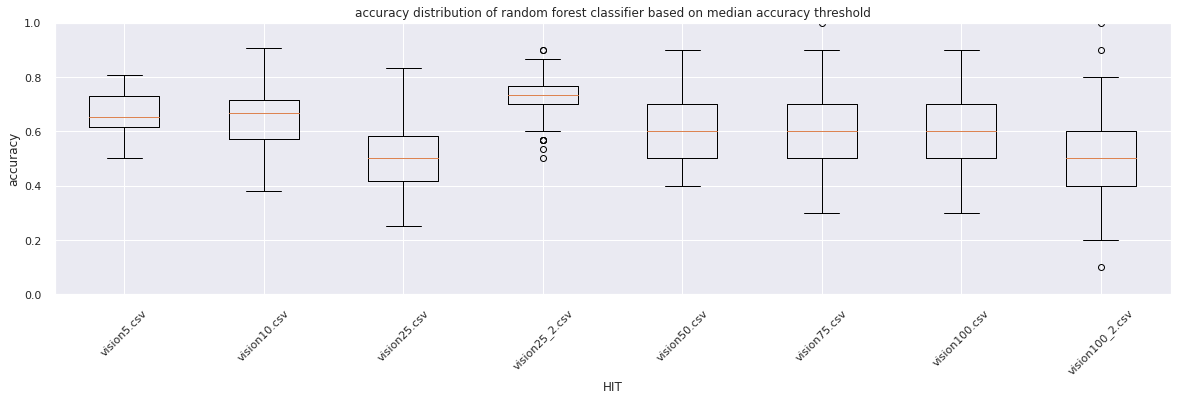

<Figure size 1440x360 with 0 Axes>

In [ ]:
plt.boxplot(prediction_accuracy_vision_forest_median)
plt.ylim([0,1])
plt.xticks(list(range(1,file_size+1)), vision_files, rotation=45)
plt.title("accuracy distribution of random forest classifier based on median accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.figure()

###### General

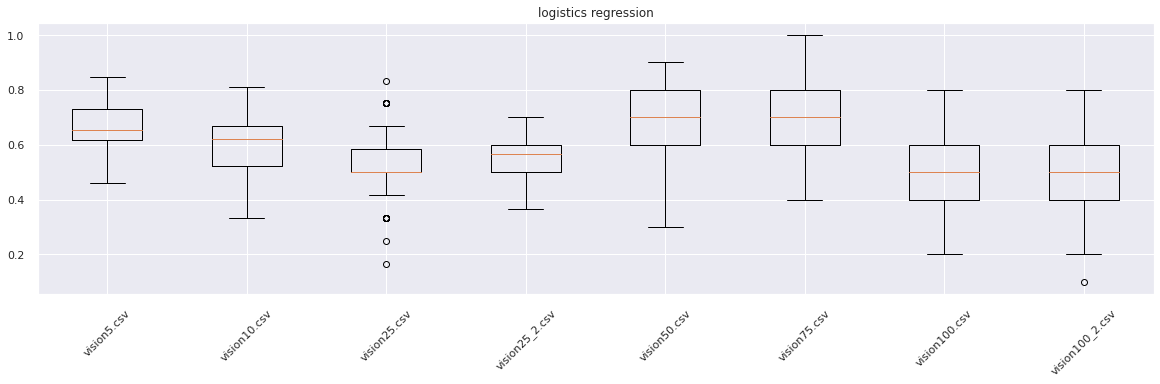

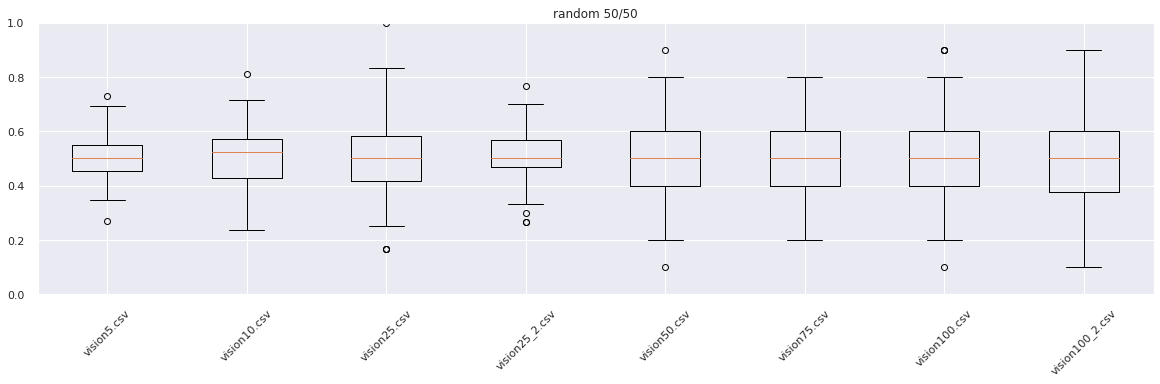

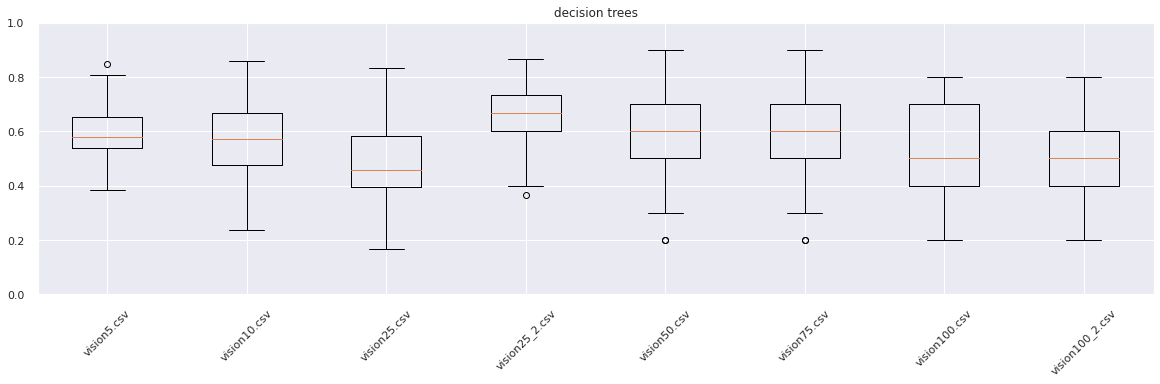

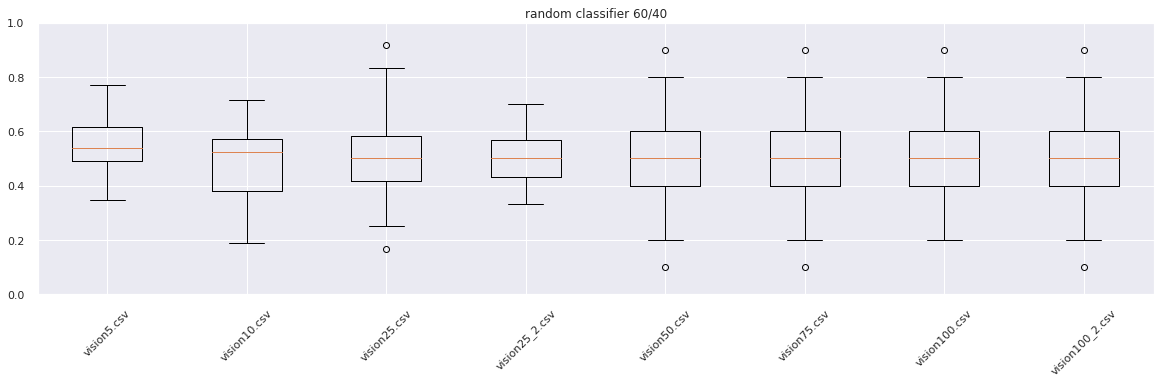

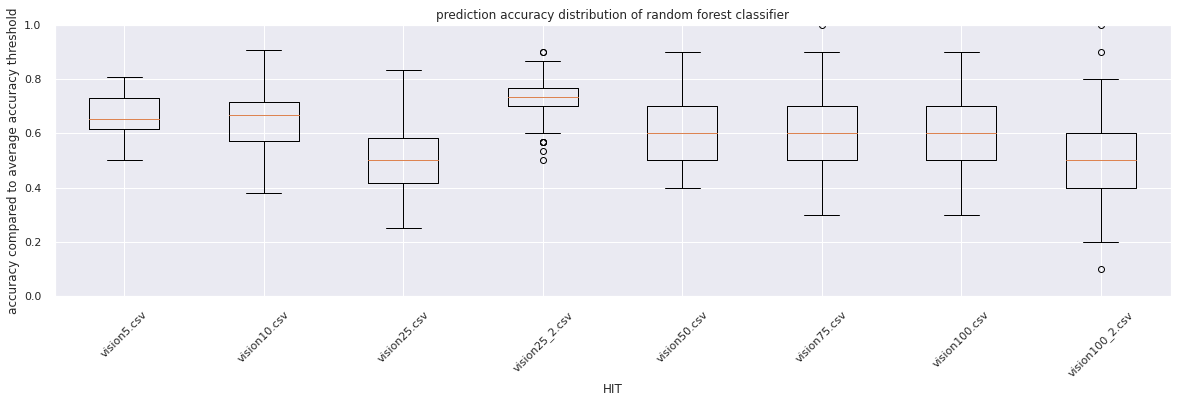

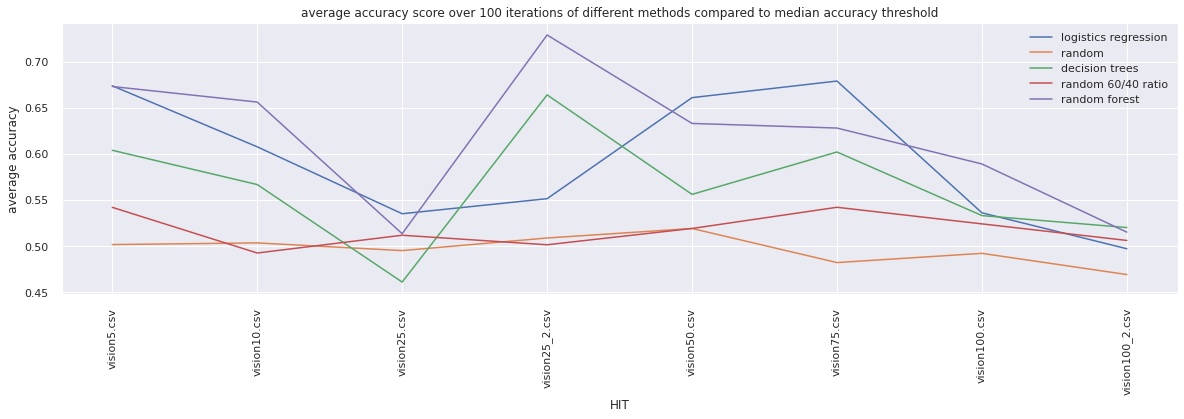

In [ ]:
plt.figure()
plt.title("logistics regression")
plt.boxplot(prediction_accuracy_vision_logistics_median)
plt.xticks(list(range(1,file_size+1)), vision_files, rotation=45)

plt.figure()
plt.ylim([0,1])
plt.title("random 50/50")
plt.boxplot(prediction_accuracy_vision_random_median)
plt.xticks(list(range(1,file_size+1)), vision_files, rotation=45)

plt.figure()
plt.ylim([0,1])
plt.title("decision trees")
plt.boxplot(prediction_accuracy_vision_tree_median)
plt.xticks(list(range(1,file_size+1)), vision_files, rotation=45)
plt.ylim([0,1])

plt.figure()
plt.title("random classifier 60/40")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_vision_random_ratio_median)
plt.xticks(list(range(1,file_size+1)), vision_files, rotation=45)
plt.show()

plt.figure()
plt.title("prediction accuracy distribution of random forest classifier")
plt.xlabel("HIT")
plt.ylabel("accuracy compared to average accuracy threshold")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_vision_forest_median)
plt.xticks(list(range(1,file_size+1)), vision_files, rotation=45)

plt.show()


plt.figure()
plt.title("average accuracy score over " + str(ITERATION) + " iterations of different methods compared to median accuracy threshold")
plt.xlabel('HIT')
plt.xticks(rotation=90)
plt.ylabel('average accuracy')
#plt.ylim([0.4,0.8])
a,b,c,d,e = [],[],[],[],[]

for i in range(np.size(vision_files)):
  a.append(np.average(prediction_accuracy_vision_logistics_median[i]))
  b.append(np.average(prediction_accuracy_vision_random_median[i]))
  c.append(np.average(prediction_accuracy_vision_tree_median[i]))
  d.append(np.average(prediction_accuracy_vision_random_ratio_median[i]))
  e.append(np.average(prediction_accuracy_vision_forest_median[i]))


plt.plot(vision_files,a)
plt.plot(vision_files,b)
plt.plot(vision_files,c)
plt.plot(vision_files,d)
plt.plot(vision_files,e)

leg = ["logistics regression","random","decision trees","random 60/40 ratio", "random forest"]
plt.legend(leg)
plt.show()



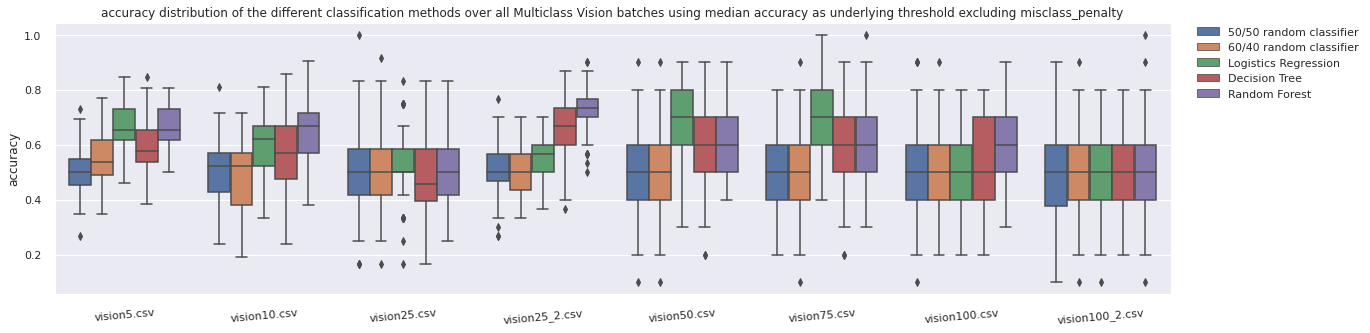

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(44)
# DATAFRAMES WITH TRIAL COLUMN ASSIGNED

box = []

for i in range(np.size(vision_files)):
  data = [prediction_accuracy_vision_random_median[i],prediction_accuracy_vision_random_ratio_median[i],prediction_accuracy_vision_logistics_median[i],prediction_accuracy_vision_tree_median[i],prediction_accuracy_vision_forest_median[i]]
  data = np.array(data) .T.tolist()
  box.append(pd.DataFrame(data, columns=["50/50 random classifier","60/40 random classifier","Logistics Regression","Decision Tree","Random Forest"]).assign(Trial=i))
  #box2.append(pd.DataFrame(prediction_accuracy_vision_tree_average[i], columns=[vision_files[i]]).assign(Trial=i))


cdf = pd.concat(box)                           # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Trial'], var_name=['Method'])      # MELT

sns.set(rc={"figure.figsize":(20, 5)}) 
ax = sns.boxplot(x="Trial", y="value", hue="Method", data=mdf)

plt.title("accuracy distribution of the different classification methods over all Multiclass Vision batches using median accuracy as underlying threshold excluding misclass_penalty")
plt.ylabel("accuracy")
plt.xlabel("")
plt.xticks(list(range(file_size)), vision_files, rotation=5)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.show()

'''
for i in range(np.size(vision_files)):
  ax = sns.boxplot(data=box[i])  # RUN PLOT   
  plt.show()
'''
plt.clf()
plt.close()

##### Fixed Threshold

###### Random Classifier

In [ ]:
prediction_accuracy_vision_random_fixed = []
prediction_accuracy_vision_random_ratio_fixed = []
for i in range(np.size(vision_files)):
  pred_acc = []
  pred_acc_ratio = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_vision_fixed[2*i+1][j], vision_random_classification_fixed[ITERATION*i+j]))
    
    pred_acc_ratio.append(metrics.accuracy_score(Y_vision_fixed[2*i+1][j], vision_random_ratio_classification_fixed[ITERATION*i+j]))
    

  prediction_accuracy_vision_random_fixed.append(pred_acc)
  prediction_accuracy_vision_random_ratio_fixed.append(pred_acc_ratio)

a,b = [],[]
for j in range(np.size(vision_files)):
  a.append(np.average(prediction_accuracy_vision_random_average[j]))
  b.append(np.average(prediction_accuracy_vision_random_ratio_average[j]))

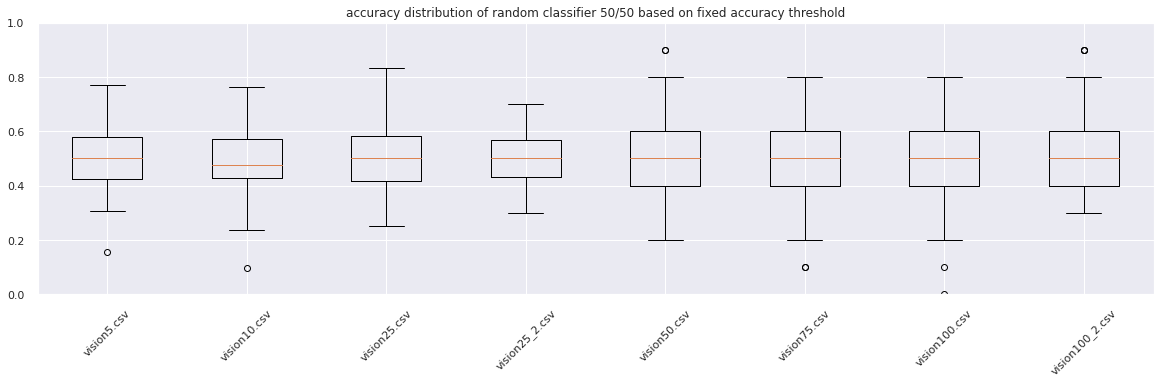

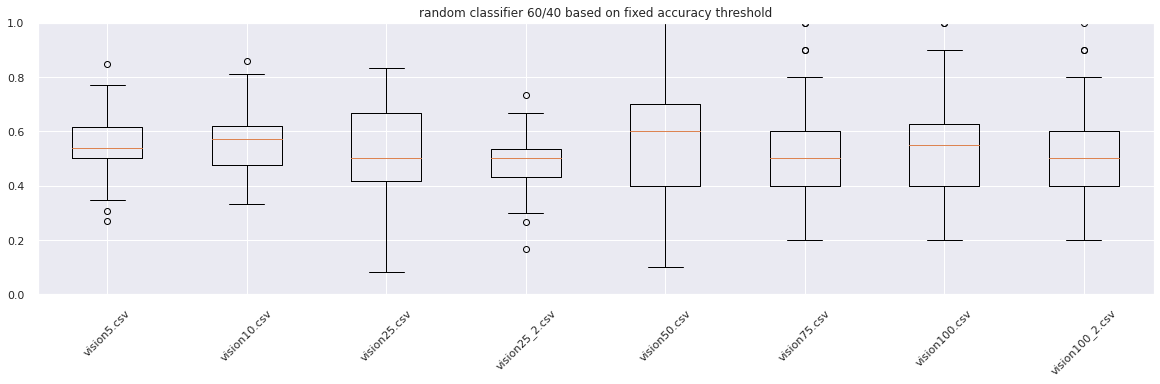

In [ ]:
plt.figure()
plt.title("accuracy distribution of random classifier 50/50 based on fixed accuracy threshold")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_vision_random_fixed)
plt.xticks(list(range(1,file_size+1)), vision_files, rotation=45)
plt.show()
plt.figure()
plt.title("random classifier 60/40 based on fixed accuracy threshold")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_vision_random_ratio_fixed)
plt.xticks(list(range(1,file_size+1)), vision_files, rotation=45)

plt.show()

###### Logistics Regression

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_vision_logistics_fixed = []
for i in range(np.size(vision_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_vision_fixed[2*i+1][j], prediction_vision_logistics_fixed[ITERATION*i+j]))

  prediction_accuracy_vision_logistics_fixed.append(pred_acc)

c = []
for j in range(np.size(vision_files)):
  c.append(np.average(prediction_accuracy_vision_logistics_fixed[j]))

<Figure size 1440x360 with 0 Axes>

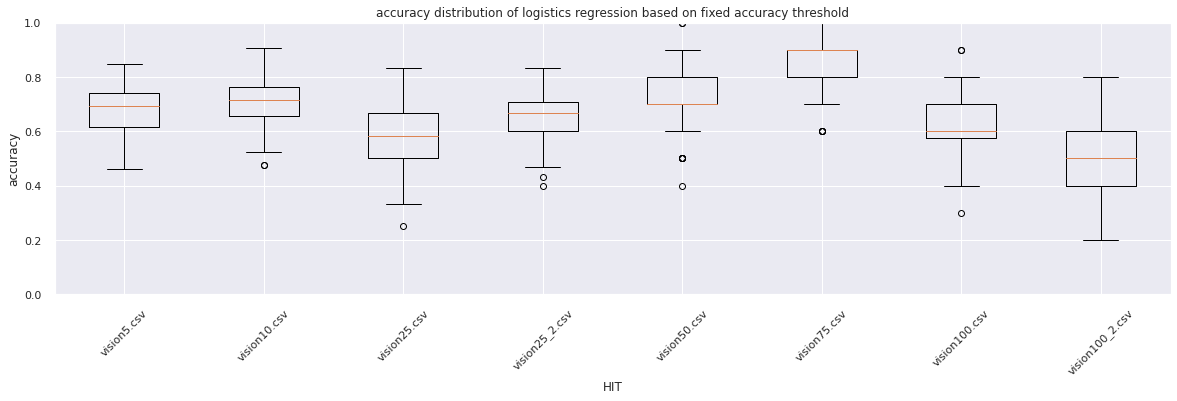

<Figure size 1440x360 with 0 Axes>

In [ ]:
plt.boxplot(prediction_accuracy_vision_logistics_fixed)
plt.ylim([0,1])
plt.xticks(list(range(1,file_size+1)), vision_files, rotation=45)
plt.title("accuracy distribution of logistics regression based on fixed accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.figure()

###### Decision Trees

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_vision_tree_fixed = []
for i in range(np.size(vision_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_vision_fixed[2*i+1][j], prediction_vision_tree_fixed[ITERATION*i+j]))

  prediction_accuracy_vision_tree_fixed.append(pred_acc)

d = []
for j in range(np.size(vision_files)):
  d.append(np.average(prediction_accuracy_vision_tree_fixed[j]))

(0.0, 1.0)

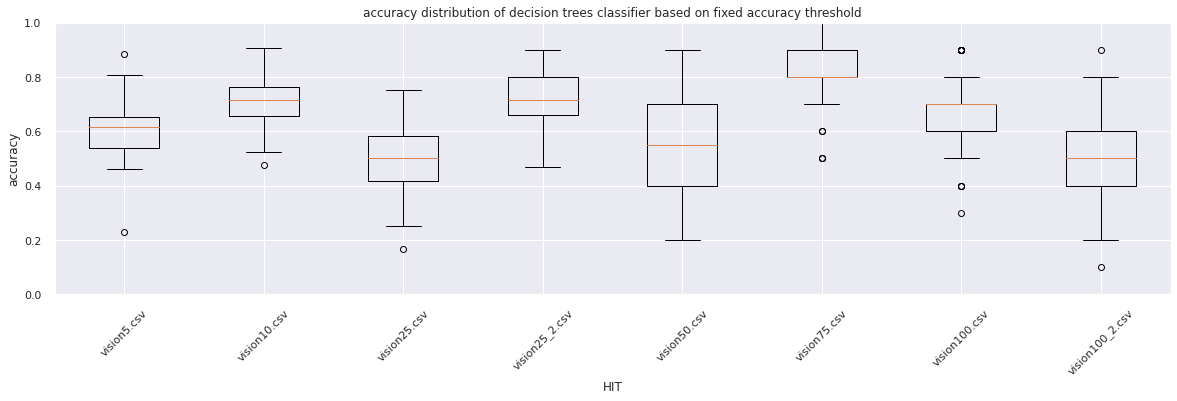

In [ ]:
plt.figure()
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_vision_tree_fixed)
plt.xticks(list(range(1,file_size+1)), vision_files, rotation=45)
plt.title("accuracy distribution of decision trees classifier based on fixed accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.ylim([0,1])

###### Random Forest

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_vision_forest_fixed = []
for i in range(np.size(vision_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_vision_fixed[2*i+1][j], prediction_vision_forest_fixed[ITERATION*i+j]))

  prediction_accuracy_vision_forest_fixed.append(pred_acc)

e = []
for j in range(np.size(vision_files)):
  e.append(np.average(prediction_accuracy_vision_forest_fixed[j]))

<Figure size 1440x360 with 0 Axes>

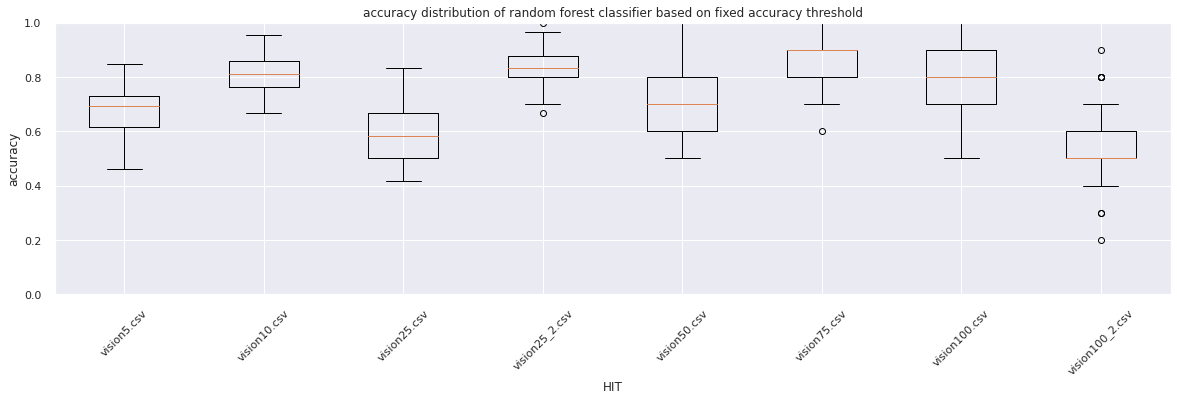

<Figure size 1440x360 with 0 Axes>

In [ ]:
plt.boxplot(prediction_accuracy_vision_forest_fixed)
plt.ylim([0,1])
plt.xticks(list(range(1,file_size+1)), vision_files, rotation=45)
plt.title("accuracy distribution of random forest classifier based on fixed accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.figure()

###### General

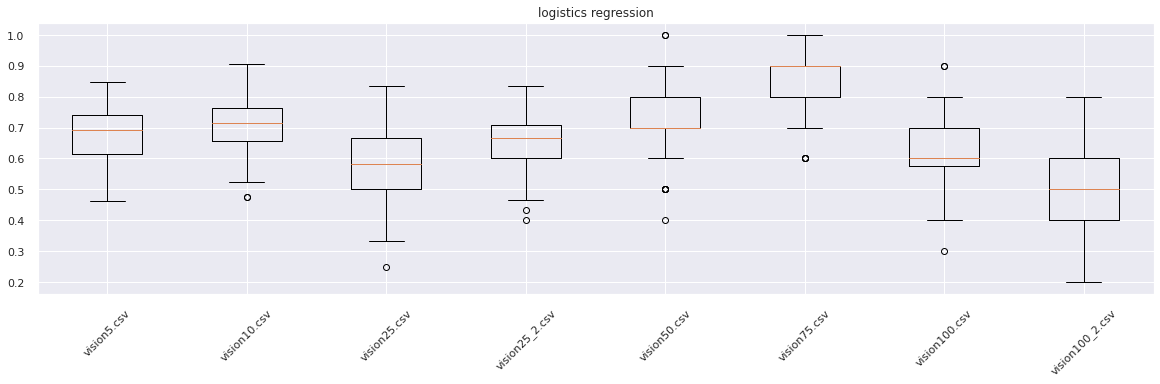

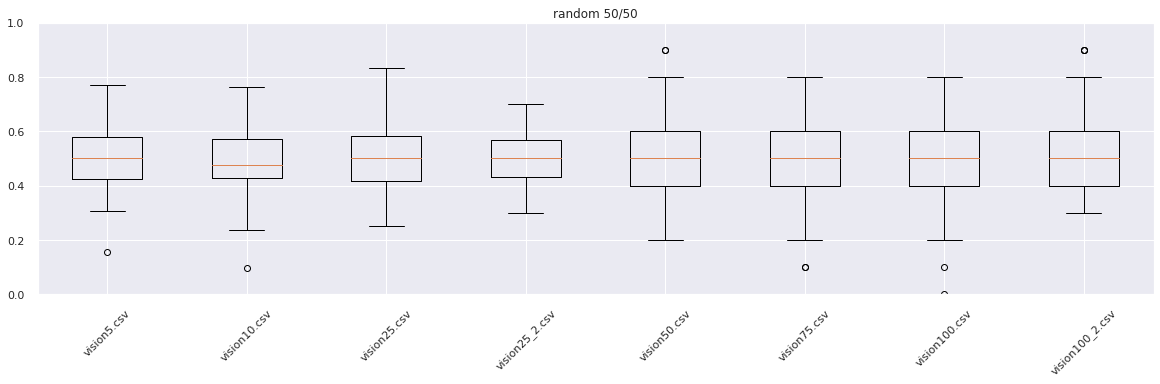

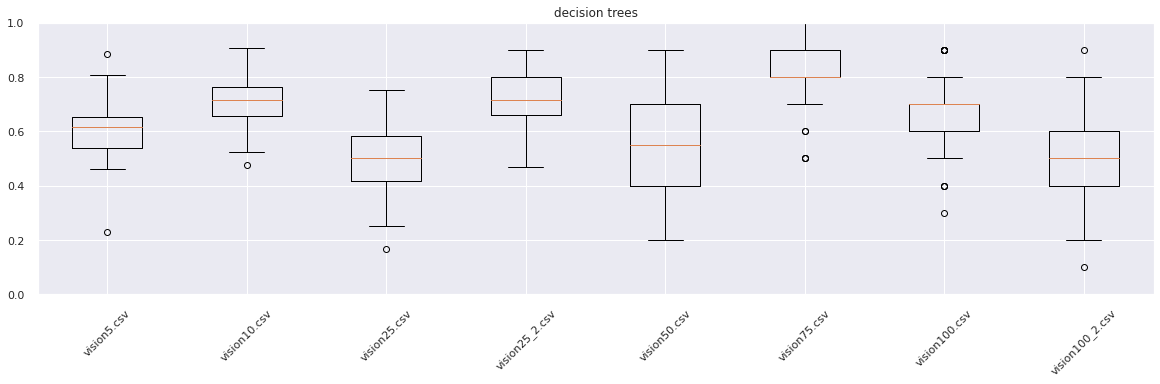

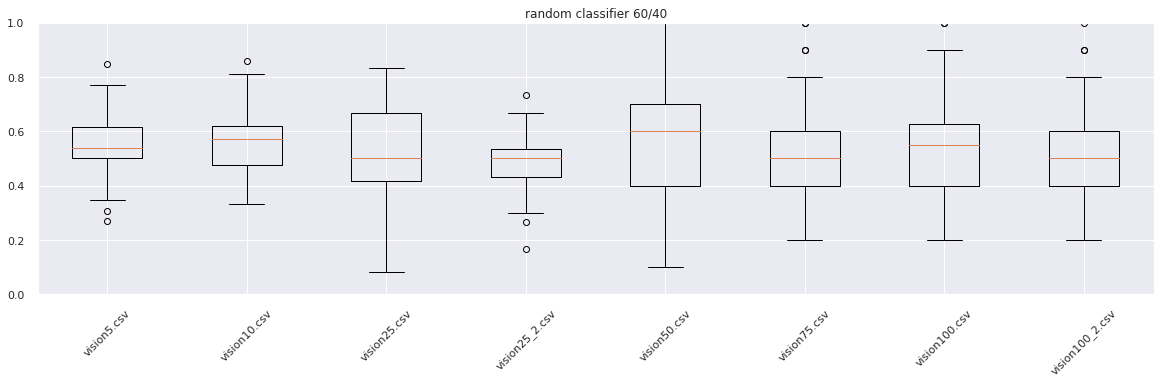

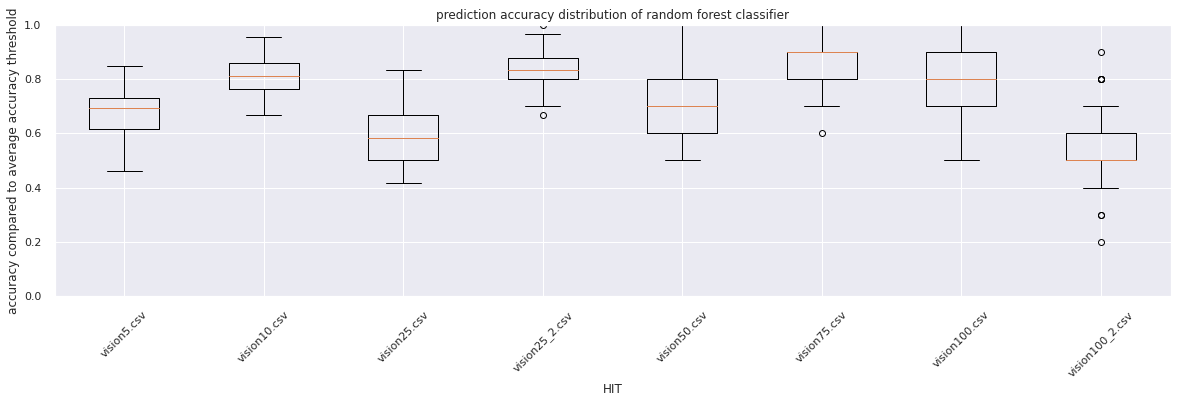

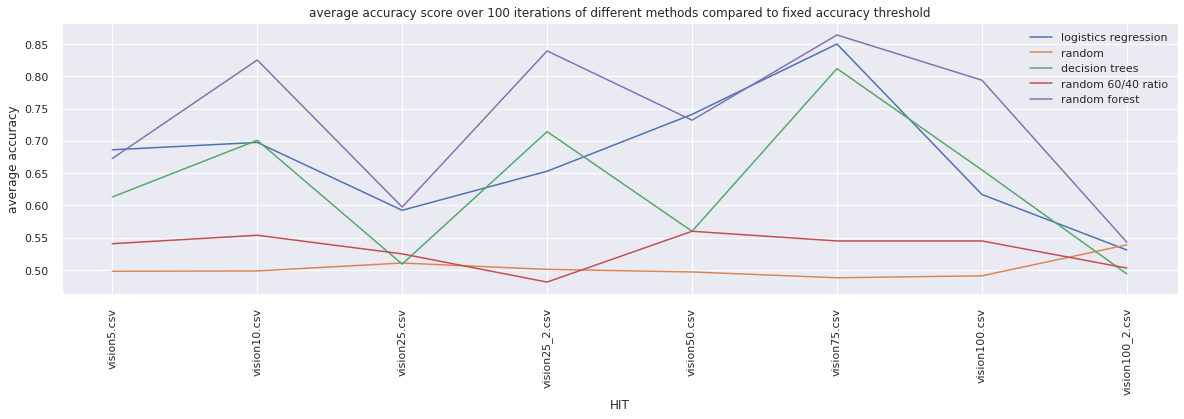

In [ ]:
plt.figure()
plt.title("logistics regression")
plt.boxplot(prediction_accuracy_vision_logistics_fixed)
plt.xticks(list(range(1,file_size+1)), vision_files, rotation=45)

plt.figure()
plt.ylim([0,1])
plt.title("random 50/50")
plt.boxplot(prediction_accuracy_vision_random_fixed)
plt.xticks(list(range(1,file_size+1)), vision_files, rotation=45)

plt.figure()
plt.ylim([0,1])
plt.title("decision trees")
plt.boxplot(prediction_accuracy_vision_tree_fixed)
plt.xticks(list(range(1,file_size+1)), vision_files, rotation=45)
plt.ylim([0,1])

plt.figure()
plt.title("random classifier 60/40")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_vision_random_ratio_fixed)
plt.xticks(list(range(1,file_size+1)), vision_files, rotation=45)
plt.show()

plt.figure()
plt.title("prediction accuracy distribution of random forest classifier")
plt.xlabel("HIT")
plt.ylabel("accuracy compared to average accuracy threshold")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_vision_forest_fixed)
plt.xticks(list(range(1,file_size+1)), vision_files, rotation=45)

plt.show()


plt.figure()
plt.title("average accuracy score over " + str(ITERATION) + " iterations of different methods compared to fixed accuracy threshold")
plt.xlabel('HIT')
plt.xticks(rotation=90)
plt.ylabel('average accuracy')
#plt.ylim([0.4,0.8])
a,b,c,d,e = [],[],[],[],[]

for i in range(file_size):
  a.append(np.average(prediction_accuracy_vision_logistics_fixed[i]))
  b.append(np.average(prediction_accuracy_vision_random_fixed[i]))
  c.append(np.average(prediction_accuracy_vision_tree_fixed[i]))
  d.append(np.average(prediction_accuracy_vision_random_ratio_fixed[i]))
  e.append(np.average(prediction_accuracy_vision_forest_fixed[i]))


plt.plot(vision_files,a)
plt.plot(vision_files,b)
plt.plot(vision_files,c)
plt.plot(vision_files,d)
plt.plot(vision_files,e)

leg = ["logistics regression","random","decision trees","random 60/40 ratio", "random forest"]
plt.legend(leg)
plt.show()



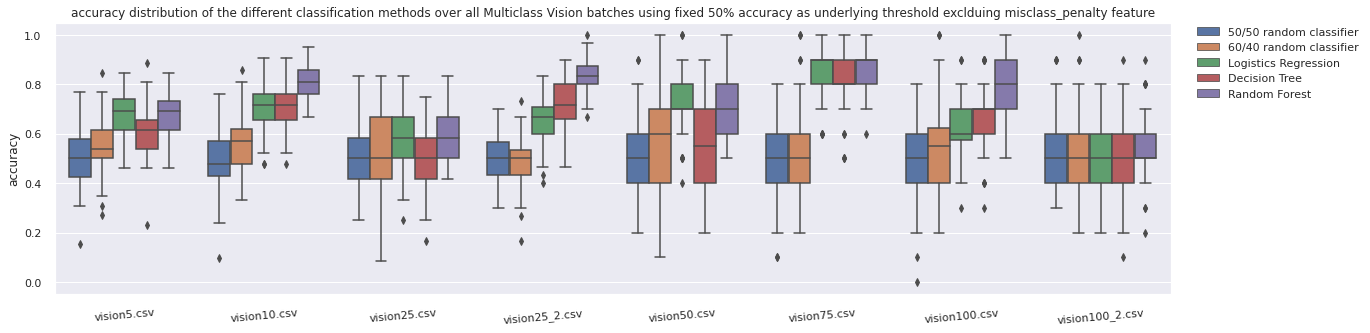

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(44)
# DATAFRAMES WITH TRIAL COLUMN ASSIGNED

box = []

for i in range(np.size(vision_files)):
  data = [prediction_accuracy_vision_random_fixed[i],prediction_accuracy_vision_random_ratio_fixed[i],prediction_accuracy_vision_logistics_fixed[i],prediction_accuracy_vision_tree_fixed[i],prediction_accuracy_vision_forest_fixed[i]]
  data = np.array(data) .T.tolist()
  box.append(pd.DataFrame(data, columns=["50/50 random classifier","60/40 random classifier","Logistics Regression","Decision Tree","Random Forest"]).assign(Trial=i))
  #box2.append(pd.DataFrame(prediction_accuracy_vision_tree_average[i], columns=[vision_files[i]]).assign(Trial=i))


cdf = pd.concat(box)                           # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Trial'], var_name=['Method'])      # MELT

sns.set(rc={"figure.figsize":(20, 5)}) 
ax = sns.boxplot(x="Trial", y="value", hue="Method", data=mdf)

plt.title("accuracy distribution of the different classification methods over all Multiclass Vision batches using fixed 50% accuracy as underlying threshold exclduing misclass_penalty feature")
plt.ylabel("accuracy")
plt.xlabel("")
plt.xticks(list(range(file_size)), vision_files, rotation=5)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.show()

'''
for i in range(np.size(vision_files)):
  ax = sns.boxplot(data=box[i])  # RUN PLOT   
  plt.show()
'''
plt.clf()
plt.close()

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_vision_forest_median = []
for i in range(np.size(vision_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_vision_median[2*i+1][j], prediction_vision_forest_median[ITERATION*i+j]))

  prediction_accuracy_vision_forest_median.append(pred_acc)

e = []
for j in range(np.size(vision_files)):
  e.append(np.median(prediction_accuracy_vision_forest_median[j]))

In [ ]:
plt.boxplot(prediction_accuracy_vision_forest_median)
plt.ylim([0,1])
plt.xticks(list(range(1,file_size+1)), vision_files, rotation=45)
plt.title("accuracy distribution of random forest classifier based on median accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.figure()

#### Multiclass NLP

In [ ]:
file_size = np.size(nlp_files)

##### Average Threshold

###### Random Classifier

In [ ]:
prediction_accuracy_nlp_random_average = []
prediction_accuracy_nlp_random_ratio_average = []
for i in range(np.size(nlp_files)):
  pred_acc = []
  pred_acc_ratio = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_nlp_average[2*i+1][j], nlp_random_classification_average[ITERATION*i+j]))
    
    pred_acc_ratio.append(metrics.accuracy_score(Y_nlp_average[2*i+1][j], nlp_random_ratio_classification_average[ITERATION*i+j]))
    

  prediction_accuracy_nlp_random_average.append(pred_acc)
  prediction_accuracy_nlp_random_ratio_average.append(pred_acc_ratio)

a,b = [],[]
for j in range(np.size(nlp_files)):
  a.append(np.average(prediction_accuracy_nlp_random_average[j]))
  b.append(np.average(prediction_accuracy_nlp_random_ratio_average[j]))

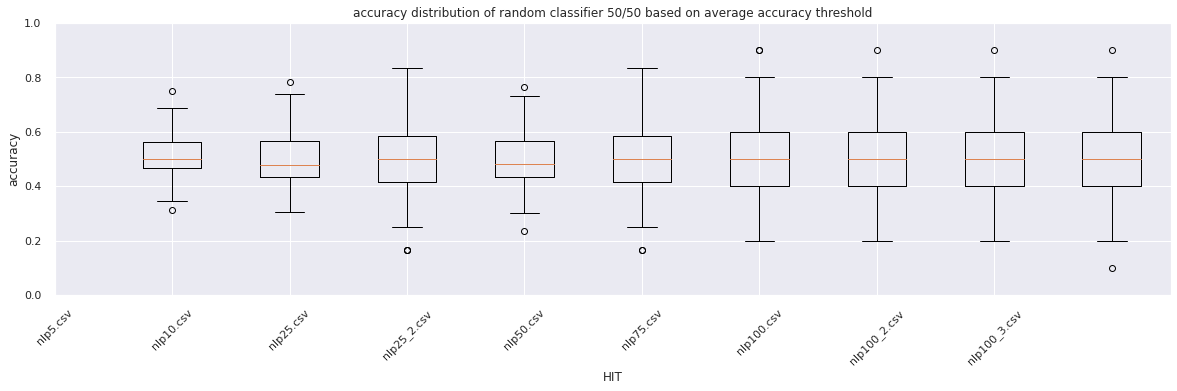

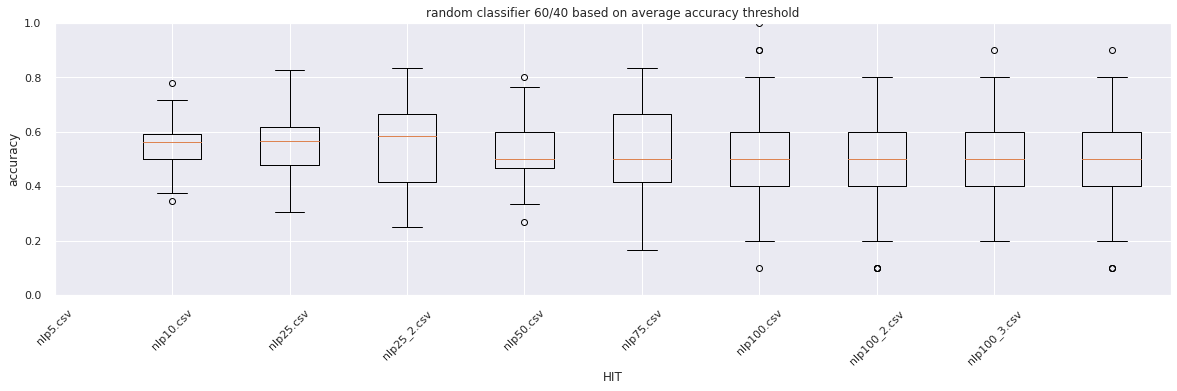

In [ ]:


plt.figure()
plt.title("accuracy distribution of random classifier 50/50 based on average accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_nlp_random_average)
plt.xticks(list(range(file_size)), nlp_files, rotation=45)
plt.show()
plt.figure()
plt.title("random classifier 60/40 based on average accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_nlp_random_ratio_average)
plt.xticks(list(range(file_size)), nlp_files, rotation=45)

plt.show()

###### Logistics Regression

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_nlp_logistics_average = []
for i in range(np.size(nlp_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_nlp_average[2*i+1][j], prediction_nlp_logistics_average[ITERATION*i+j]))

  prediction_accuracy_nlp_logistics_average.append(pred_acc)

c = []
for j in range(np.size(nlp_files)):
  c.append(np.average(prediction_accuracy_nlp_logistics_average[j]))

<Figure size 1440x360 with 0 Axes>

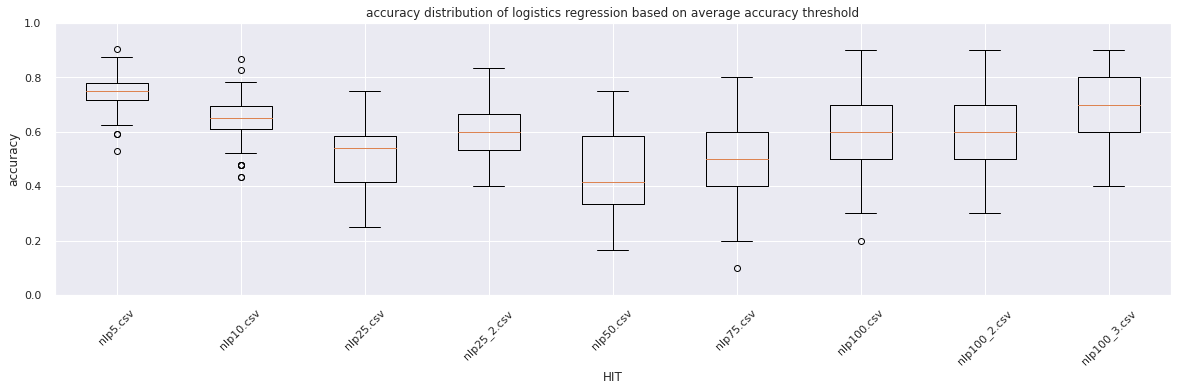

<Figure size 1440x360 with 0 Axes>

In [ ]:
plt.boxplot(prediction_accuracy_nlp_logistics_average)
plt.ylim([0,1])
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)
plt.title("accuracy distribution of logistics regression based on average accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.figure()

###### Decision Trees

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_nlp_tree_average = []
for i in range(np.size(nlp_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_nlp_average[2*i+1][j], prediction_nlp_tree_average[ITERATION*i+j]))

  prediction_accuracy_nlp_tree_average.append(pred_acc)

d = []
for j in range(np.size(nlp_files)):
  d.append(np.average(prediction_accuracy_nlp_tree_average[j]))

(0.0, 1.0)

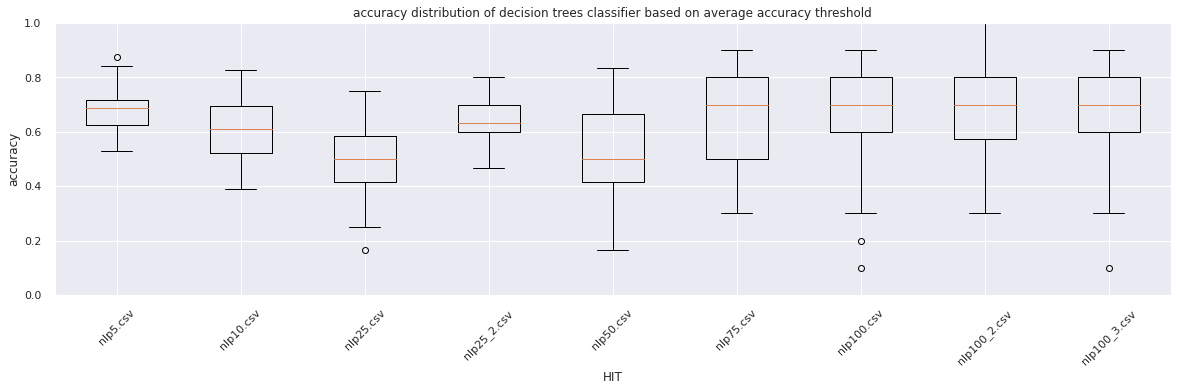

In [ ]:
plt.figure()
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_nlp_tree_average)
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)
plt.title("accuracy distribution of decision trees classifier based on average accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.ylim([0,1])

###### Random Forest

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_nlp_forest_average = []
for i in range(np.size(nlp_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_nlp_average[2*i+1][j], prediction_nlp_forest_average[ITERATION*i+j]))

  prediction_accuracy_nlp_forest_average.append(pred_acc)

e = []
for j in range(np.size(nlp_files)):
  e.append(np.average(prediction_accuracy_nlp_forest_average[j]))

<Figure size 1440x360 with 0 Axes>

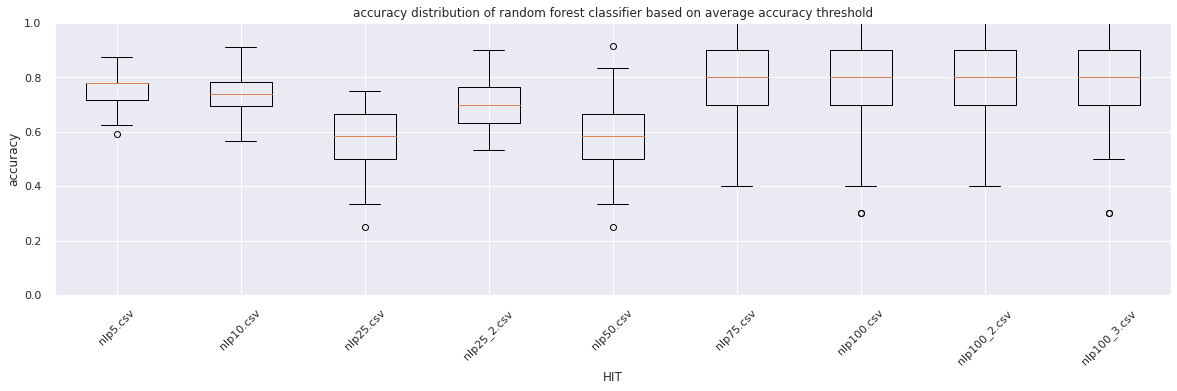

<Figure size 1440x360 with 0 Axes>

In [ ]:
plt.boxplot(prediction_accuracy_nlp_forest_average)
plt.ylim([0,1])
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)
plt.title("accuracy distribution of random forest classifier based on average accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.figure()

###### General

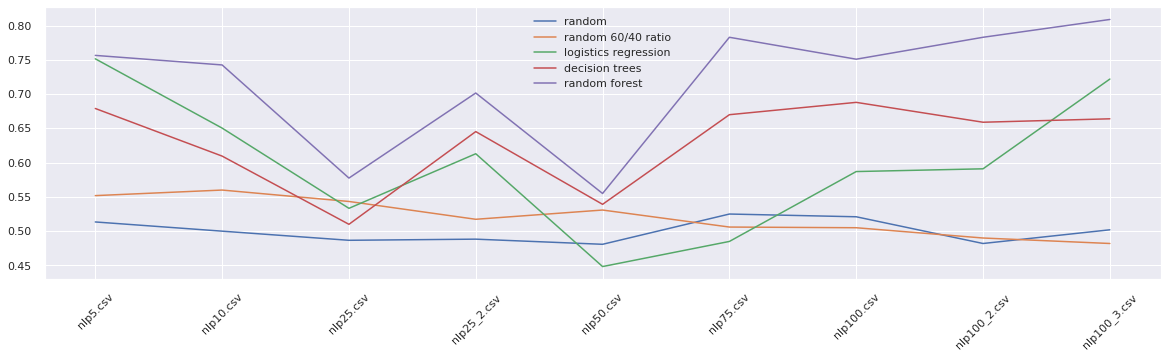

In [ ]:
plt.plot(nlp_files,a)
plt.plot(nlp_files,b)
plt.plot(nlp_files,c)
plt.plot(nlp_files,d)
plt.plot(nlp_files,e)

leg = ["random","random 60/40 ratio","logistics regression","decision trees", "random forest"]
plt.legend(leg)
plt.xticks(nlp_files, rotation=45)
plt.show()



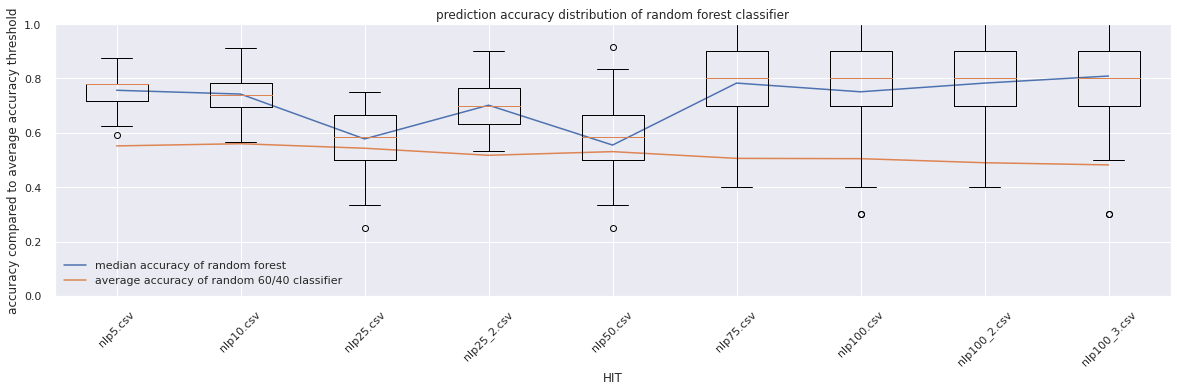

In [ ]:
plt.figure()
plt.title("prediction accuracy distribution of random forest classifier")
plt.xlabel("HIT")
plt.ylabel("accuracy compared to average accuracy threshold")
plt.ylim([0,1])

plt.plot(list(range(1,file_size+1)),e)
plt.plot(list(range(1,file_size+1)),b)
plt.legend(["median accuracy of random forest","average accuracy of random 60/40 classifier"])
plt.boxplot(prediction_accuracy_nlp_forest_average)

plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)
plt.show()

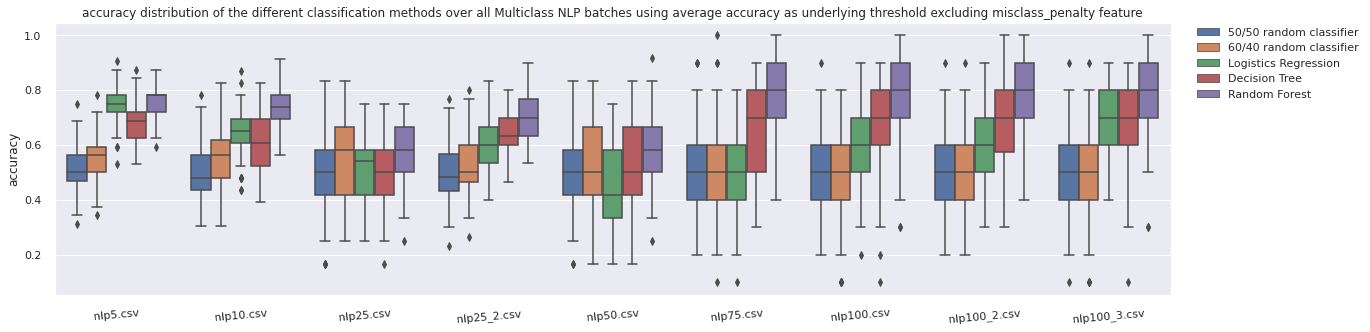

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(44)
# DATAFRAMES WITH TRIAL COLUMN ASSIGNED

box = []

for i in range(np.size(nlp_files)):
  data = [prediction_accuracy_nlp_random_average[i],prediction_accuracy_nlp_random_ratio_average[i],prediction_accuracy_nlp_logistics_average[i],prediction_accuracy_nlp_tree_average[i],prediction_accuracy_nlp_forest_average[i]]
  data = np.array(data) .T.tolist()
  box.append(pd.DataFrame(data, columns=["50/50 random classifier","60/40 random classifier","Logistics Regression","Decision Tree","Random Forest"]).assign(Trial=i))
  #box2.append(pd.DataFrame(prediction_accuracy_nlp_tree_average[i], columns=[nlp_files[i]]).assign(Trial=i))


cdf = pd.concat(box)                           # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Trial'], var_name=['Method'])      # MELT

sns.set(rc={"figure.figsize":(20, 5)}) 
ax = sns.boxplot(x="Trial", y="value", hue="Method", data=mdf)

plt.title("accuracy distribution of the different classification methods over all Multiclass NLP batches using average accuracy as underlying threshold excluding misclass_penalty feature")
plt.ylabel("accuracy")
plt.xlabel("")
plt.xticks(list(range(file_size)), nlp_files, rotation=5)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.show()

'''
for i in range(np.size(nlp_files)):
  ax = sns.boxplot(data=box[i])  # RUN PLOT   
  plt.show()
'''
plt.clf()
plt.close()

##### Median Threshold

###### Random Classifier

In [ ]:
prediction_accuracy_nlp_random_median = []
prediction_accuracy_nlp_random_ratio_median = []
for i in range(np.size(nlp_files)):
  pred_acc = []
  pred_acc_ratio = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_nlp_median[2*i+1][j], nlp_random_classification_median[ITERATION*i+j]))
    
    pred_acc_ratio.append(metrics.accuracy_score(Y_nlp_median[2*i+1][j], nlp_random_ratio_classification_median[ITERATION*i+j]))
    

  prediction_accuracy_nlp_random_median.append(pred_acc)
  prediction_accuracy_nlp_random_ratio_median.append(pred_acc_ratio)

a,b = [],[]
for j in range(np.size(nlp_files)):
  a.append(np.average(prediction_accuracy_nlp_random_median[j]))
  b.append(np.average(prediction_accuracy_nlp_random_ratio_median[j]))

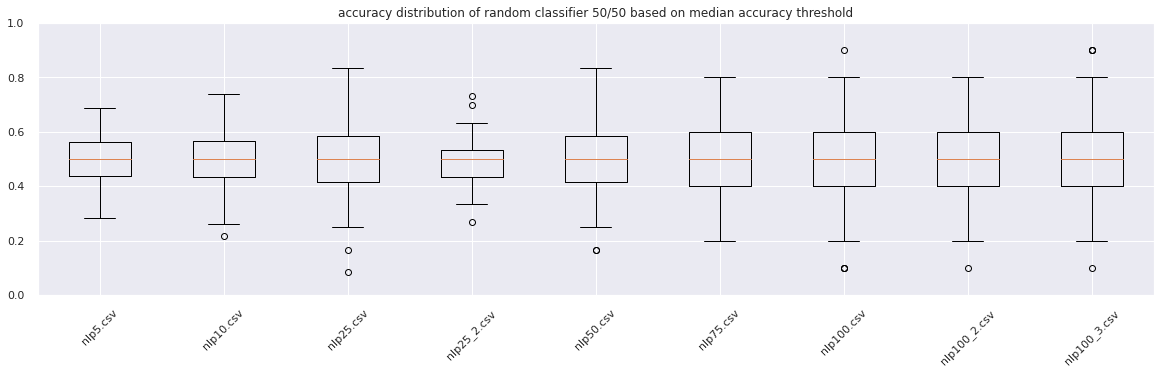

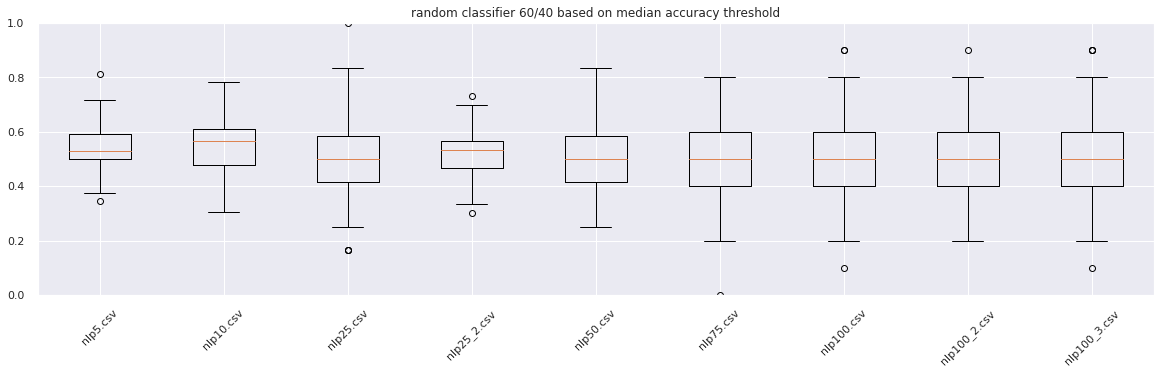

In [ ]:
plt.figure()
plt.title("accuracy distribution of random classifier 50/50 based on median accuracy threshold")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_nlp_random_median)
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)
plt.show()
plt.figure()
plt.title("random classifier 60/40 based on median accuracy threshold")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_nlp_random_ratio_median)
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)

plt.show()

###### Logistics Regression

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_nlp_logistics_median = []
for i in range(np.size(nlp_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_nlp_median[2*i+1][j], prediction_nlp_logistics_median[ITERATION*i+j]))

  prediction_accuracy_nlp_logistics_median.append(pred_acc)

c = []
for j in range(np.size(nlp_files)):
  c.append(np.average(prediction_accuracy_nlp_logistics_median[j]))

<Figure size 1440x360 with 0 Axes>

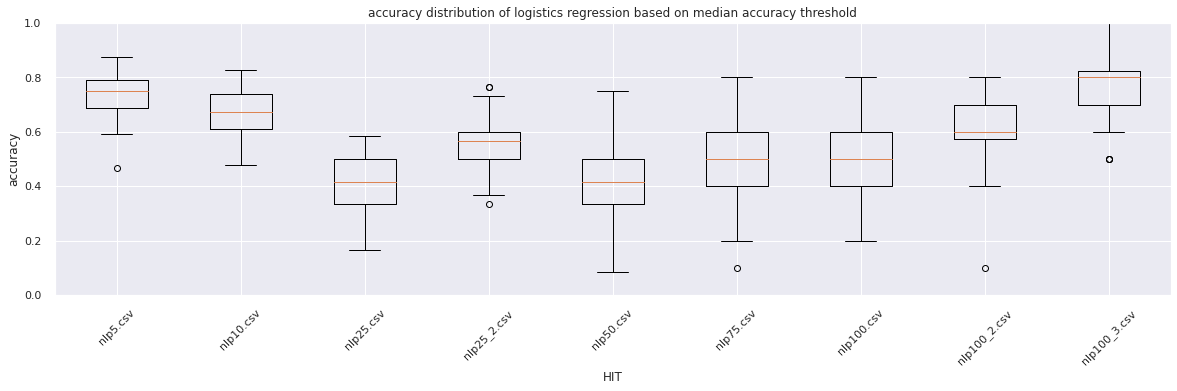

<Figure size 1440x360 with 0 Axes>

In [ ]:
plt.boxplot(prediction_accuracy_nlp_logistics_median)
plt.ylim([0,1])
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)
plt.title("accuracy distribution of logistics regression based on median accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.figure()

###### Decision Trees

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_nlp_tree_median = []
for i in range(np.size(nlp_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_nlp_median[2*i+1][j], prediction_nlp_tree_median[ITERATION*i+j]))

  prediction_accuracy_nlp_tree_median.append(pred_acc)

d = []
for j in range(np.size(nlp_files)):
  d.append(np.median(prediction_accuracy_nlp_tree_median[j]))

(0.0, 1.0)

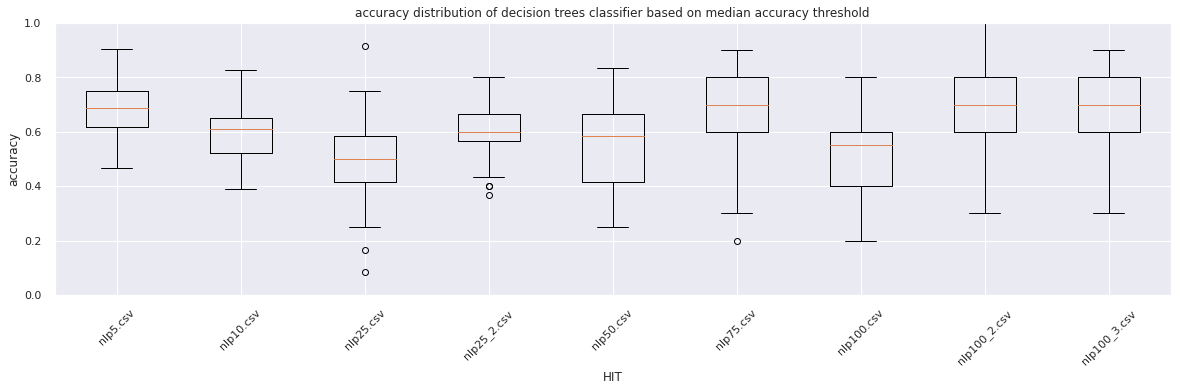

In [ ]:
plt.figure()
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_nlp_tree_median)
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)
plt.title("accuracy distribution of decision trees classifier based on median accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.ylim([0,1])

###### Random Forest

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_nlp_forest_median = []
for i in range(np.size(nlp_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_nlp_median[2*i+1][j], prediction_nlp_forest_median[ITERATION*i+j]))

  prediction_accuracy_nlp_forest_median.append(pred_acc)

e = []
for j in range(np.size(nlp_files)):
  e.append(np.median(prediction_accuracy_nlp_forest_median[j]))

<Figure size 1440x360 with 0 Axes>

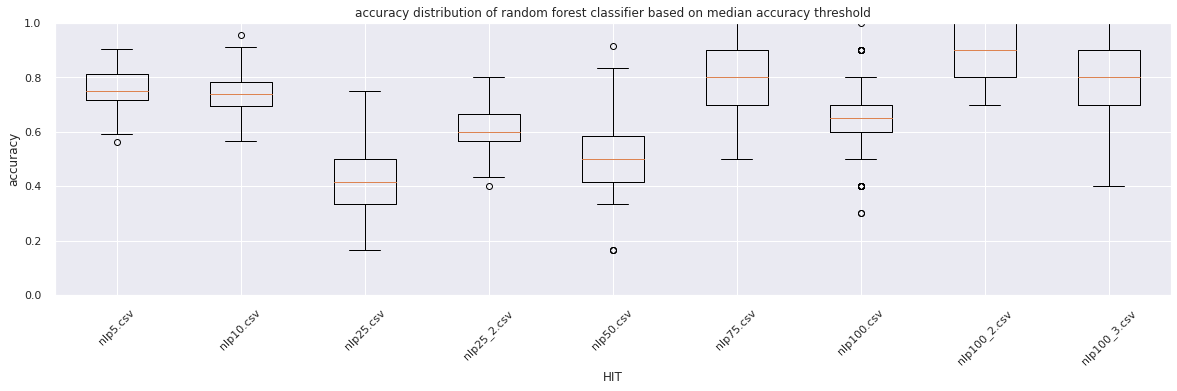

<Figure size 1440x360 with 0 Axes>

In [ ]:
plt.boxplot(prediction_accuracy_nlp_forest_median)
plt.ylim([0,1])
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)
plt.title("accuracy distribution of random forest classifier based on median accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.figure()

###### General

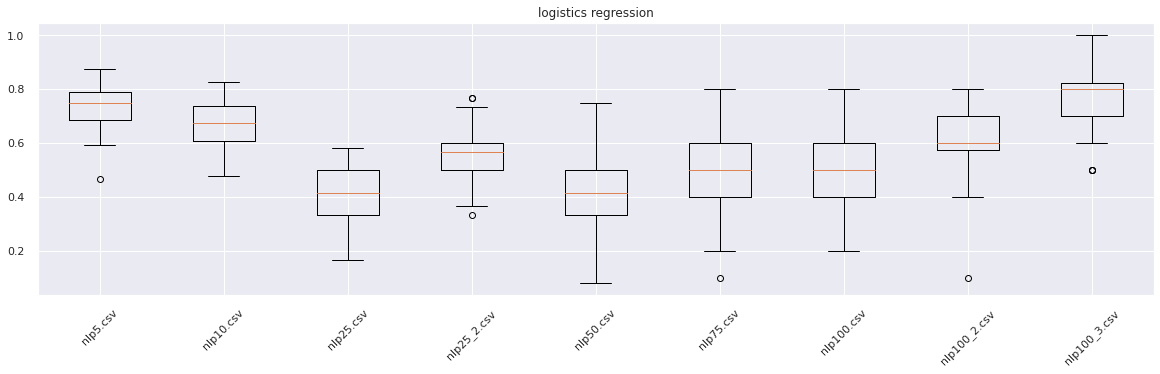

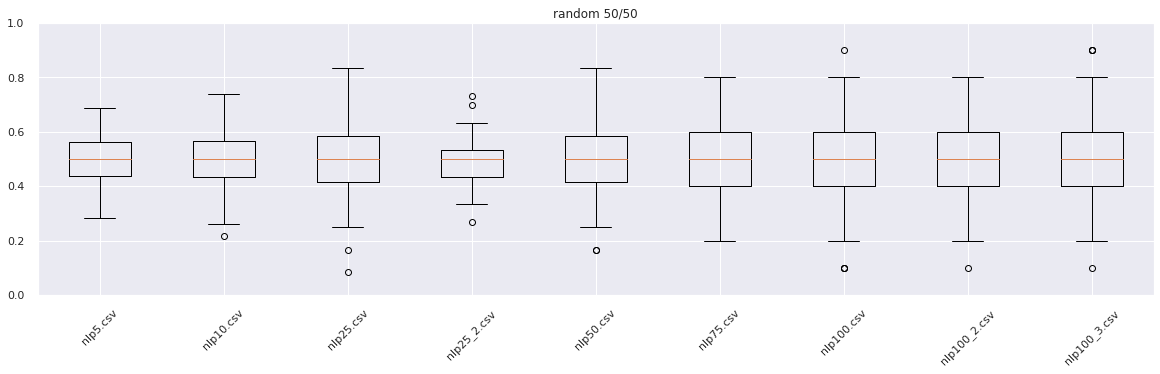

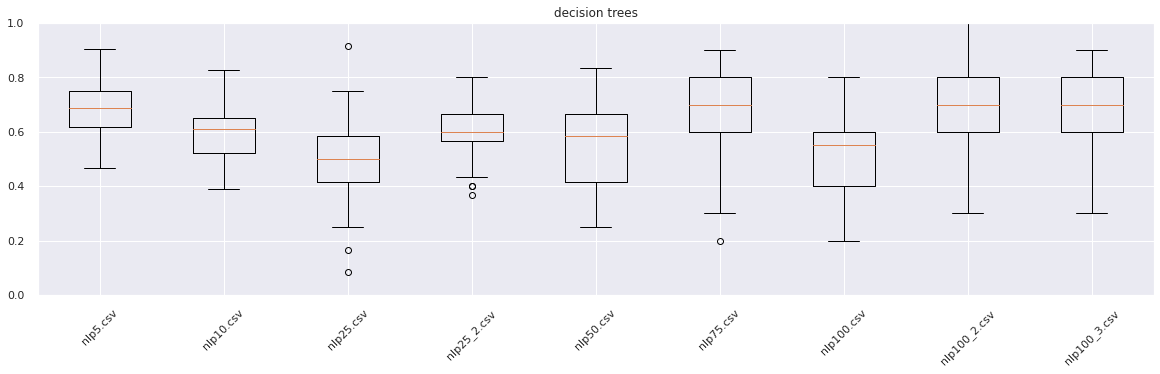

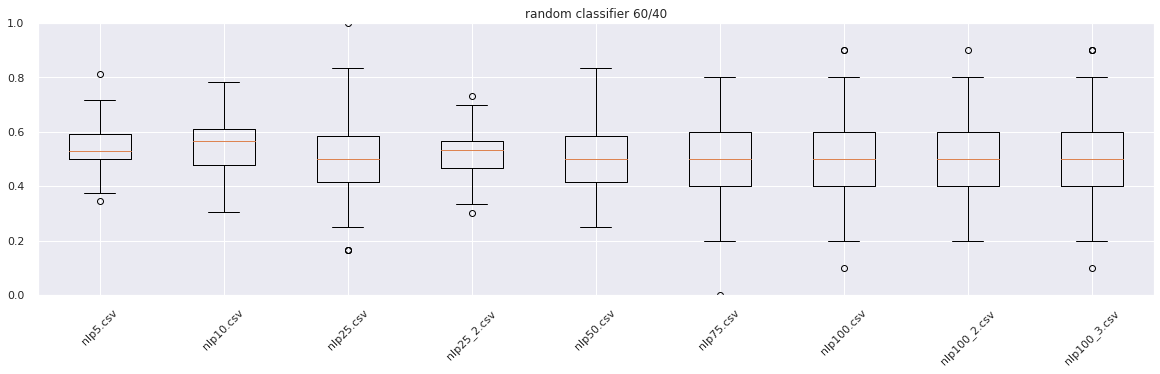

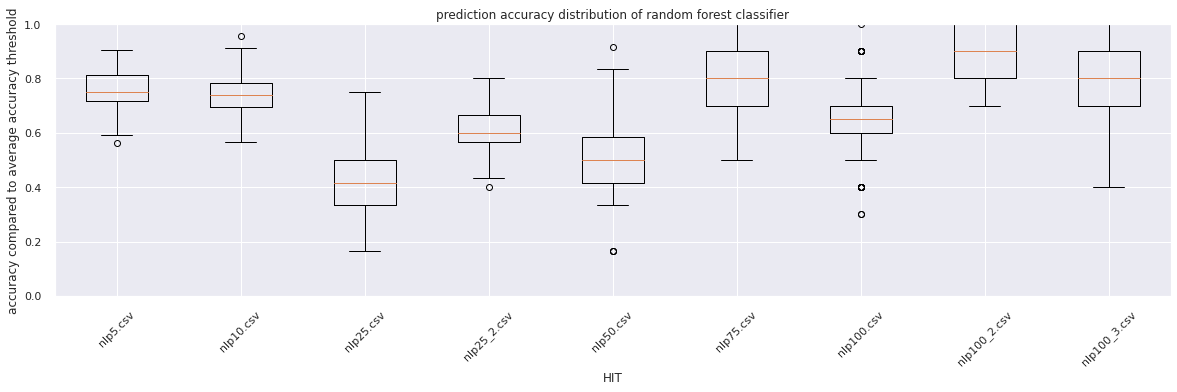

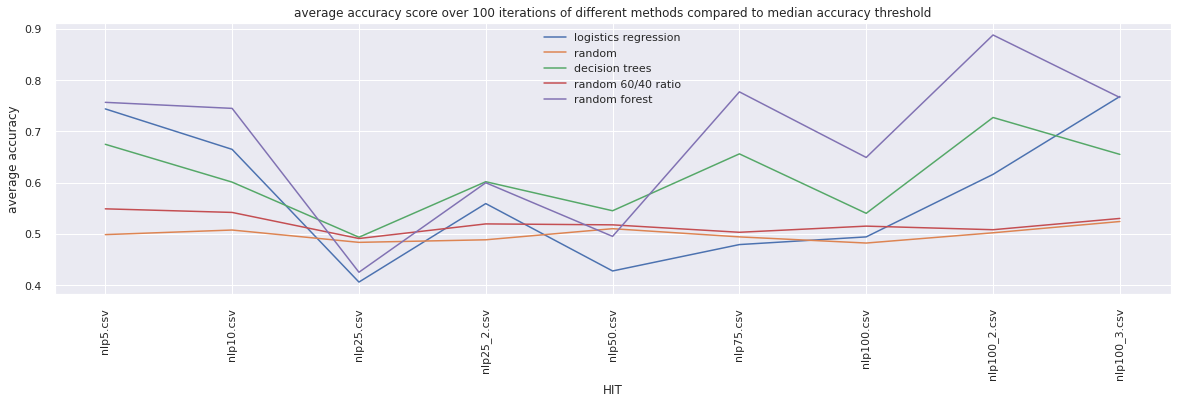

In [ ]:
plt.figure()
plt.title("logistics regression")
plt.boxplot(prediction_accuracy_nlp_logistics_median)
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)

plt.figure()
plt.ylim([0,1])
plt.title("random 50/50")
plt.boxplot(prediction_accuracy_nlp_random_median)
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)

plt.figure()
plt.ylim([0,1])
plt.title("decision trees")
plt.boxplot(prediction_accuracy_nlp_tree_median)
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)
plt.ylim([0,1])

plt.figure()
plt.title("random classifier 60/40")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_nlp_random_ratio_median)
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)
plt.show()

plt.figure()
plt.title("prediction accuracy distribution of random forest classifier")
plt.xlabel("HIT")
plt.ylabel("accuracy compared to average accuracy threshold")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_nlp_forest_median)
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)

plt.show()


plt.figure()
plt.title("average accuracy score over " + str(ITERATION) + " iterations of different methods compared to median accuracy threshold")
plt.xlabel('HIT')
plt.xticks(rotation=90)
plt.ylabel('average accuracy')
#plt.ylim([0.4,0.8])
a,b,c,d,e = [],[],[],[],[]

for i in range(file_size):
  a.append(np.average(prediction_accuracy_nlp_logistics_median[i]))
  b.append(np.average(prediction_accuracy_nlp_random_median[i]))
  c.append(np.average(prediction_accuracy_nlp_tree_median[i]))
  d.append(np.average(prediction_accuracy_nlp_random_ratio_median[i]))
  e.append(np.average(prediction_accuracy_nlp_forest_median[i]))


plt.plot(nlp_files,a)
plt.plot(nlp_files,b)
plt.plot(nlp_files,c)
plt.plot(nlp_files,d)
plt.plot(nlp_files,e)

leg = ["logistics regression","random","decision trees","random 60/40 ratio", "random forest"]
plt.legend(leg)
plt.show()



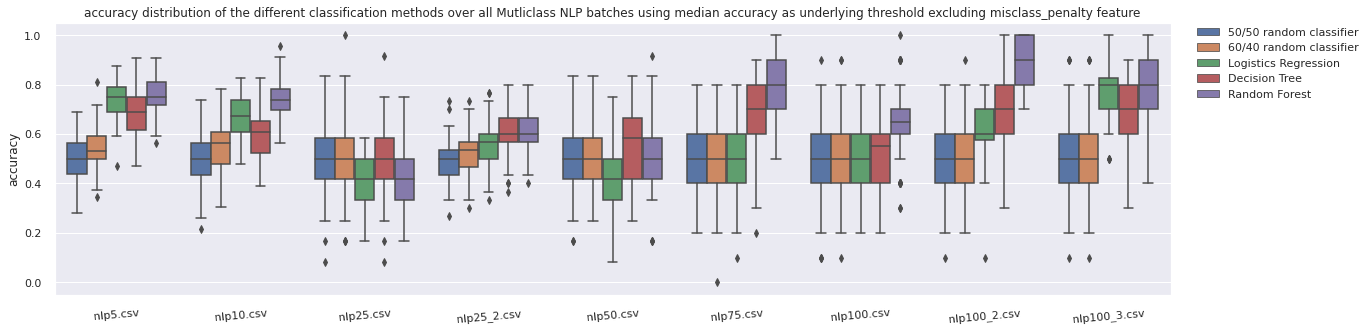

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(44)
# DATAFRAMES WITH TRIAL COLUMN ASSIGNED

box = []

for i in range(np.size(nlp_files)):
  data = [prediction_accuracy_nlp_random_median[i],prediction_accuracy_nlp_random_ratio_median[i],prediction_accuracy_nlp_logistics_median[i],prediction_accuracy_nlp_tree_median[i],prediction_accuracy_nlp_forest_median[i]]
  data = np.array(data) .T.tolist()
  box.append(pd.DataFrame(data, columns=["50/50 random classifier","60/40 random classifier","Logistics Regression","Decision Tree","Random Forest"]).assign(Trial=i))
  #box2.append(pd.DataFrame(prediction_accuracy_nlp_tree_average[i], columns=[nlp_files[i]]).assign(Trial=i))


cdf = pd.concat(box)                           # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Trial'], var_name=['Method'])      # MELT

sns.set(rc={"figure.figsize":(20, 5)}) 
ax = sns.boxplot(x="Trial", y="value", hue="Method", data=mdf)

plt.title("accuracy distribution of the different classification methods over all Mutliclass NLP batches using median accuracy as underlying threshold excluding misclass_penalty feature")
plt.ylabel("accuracy")
plt.xlabel("")
plt.xticks(list(range(file_size)), nlp_files, rotation=5)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.show()

'''
for i in range(np.size(nlp_files)):
  ax = sns.boxplot(data=box[i])  # RUN PLOT   
  plt.show()
'''
plt.clf()
plt.close()

##### Fixed Threshold

###### Random Classifier

In [ ]:
prediction_accuracy_nlp_random_fixed = []
prediction_accuracy_nlp_random_ratio_fixed = []
for i in range(np.size(nlp_files)):
  pred_acc = []
  pred_acc_ratio = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_nlp_fixed[2*i+1][j], nlp_random_classification_fixed[ITERATION*i+j]))
    
    pred_acc_ratio.append(metrics.accuracy_score(Y_nlp_fixed[2*i+1][j], nlp_random_ratio_classification_fixed[ITERATION*i+j]))
    

  prediction_accuracy_nlp_random_fixed.append(pred_acc)
  prediction_accuracy_nlp_random_ratio_fixed.append(pred_acc_ratio)

a,b = [],[]
for j in range(np.size(nlp_files)):
  a.append(np.average(prediction_accuracy_nlp_random_average[j]))
  b.append(np.average(prediction_accuracy_nlp_random_ratio_average[j]))

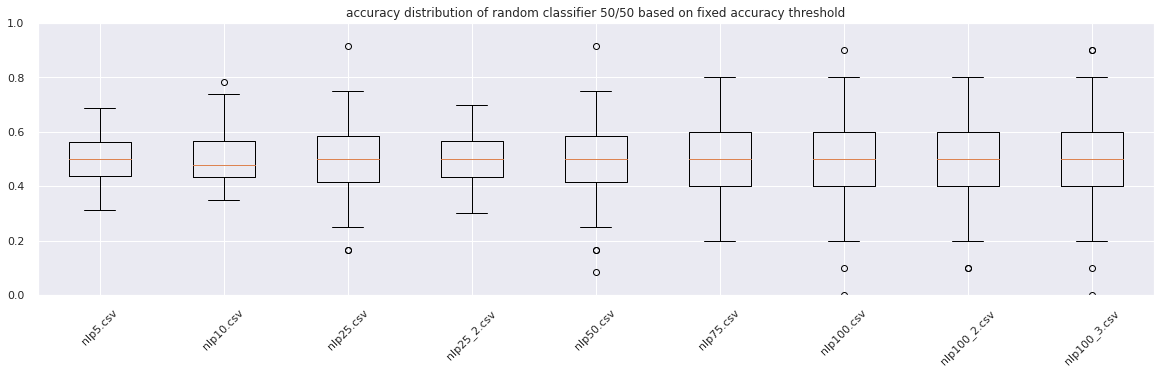

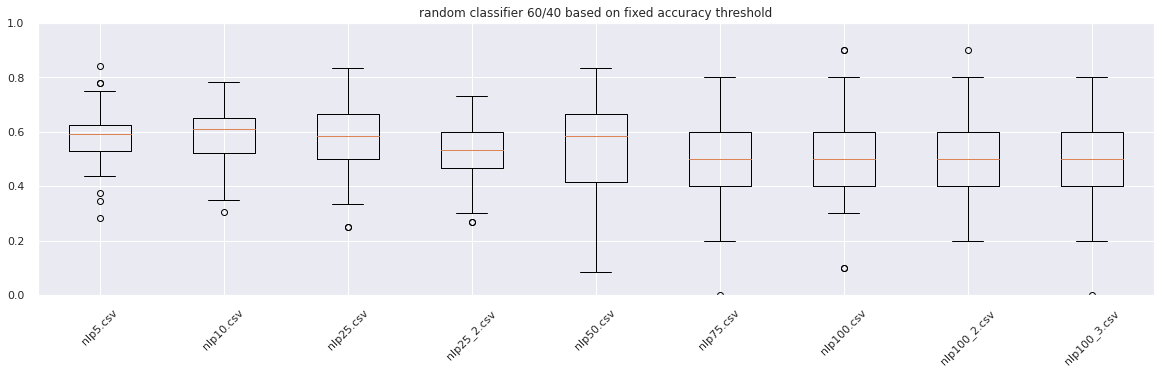

In [ ]:
plt.figure()
plt.title("accuracy distribution of random classifier 50/50 based on fixed accuracy threshold")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_nlp_random_fixed)
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)
plt.show()
plt.figure()
plt.title("random classifier 60/40 based on fixed accuracy threshold")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_nlp_random_ratio_fixed)
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)

plt.show()

###### Logistics Regression

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_nlp_logistics_fixed = []
for i in range(np.size(nlp_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_nlp_fixed[2*i+1][j], prediction_nlp_logistics_fixed[ITERATION*i+j]))

  prediction_accuracy_nlp_logistics_fixed.append(pred_acc)

c = []
for j in range(np.size(nlp_files)):
  c.append(np.average(prediction_accuracy_nlp_logistics_fixed[j]))

<Figure size 1440x360 with 0 Axes>

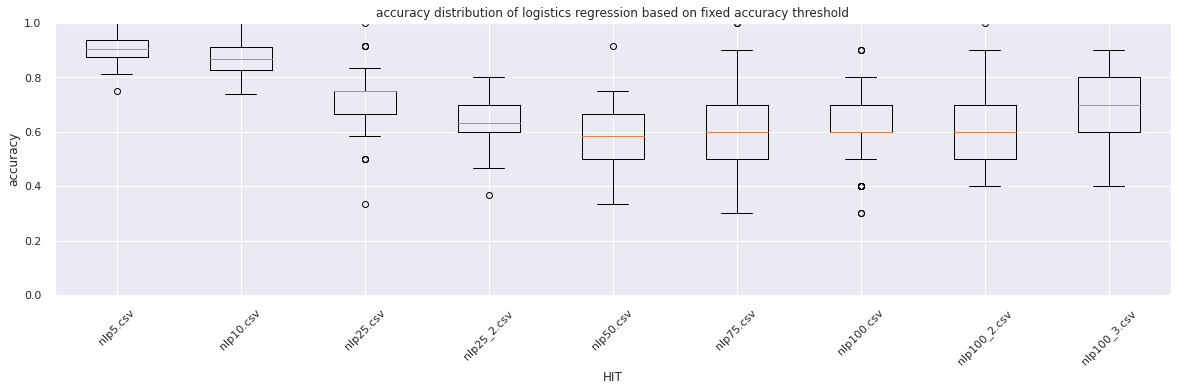

<Figure size 1440x360 with 0 Axes>

In [ ]:
plt.boxplot(prediction_accuracy_nlp_logistics_fixed)
plt.ylim([0,1])
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)
plt.title("accuracy distribution of logistics regression based on fixed accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.figure()

###### Decision Trees

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_nlp_tree_fixed = []
for i in range(np.size(nlp_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_nlp_fixed[2*i+1][j], prediction_nlp_tree_fixed[ITERATION*i+j]))

  prediction_accuracy_nlp_tree_fixed.append(pred_acc)

d = []
for j in range(np.size(nlp_files)):
  d.append(np.average(prediction_accuracy_nlp_tree_fixed[j]))

(0.0, 1.0)

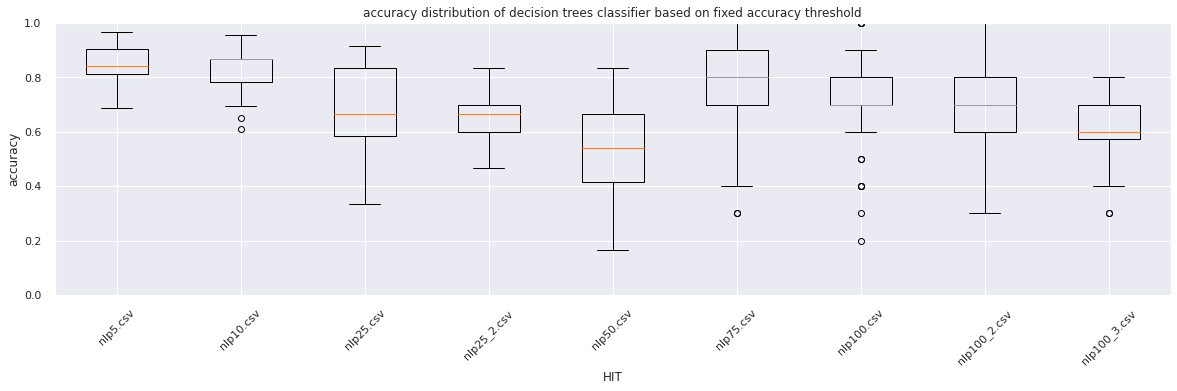

In [ ]:
plt.figure()
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_nlp_tree_fixed)
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)
plt.title("accuracy distribution of decision trees classifier based on fixed accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.ylim([0,1])

###### Random Forest

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_nlp_forest_fixed = []
for i in range(np.size(nlp_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_nlp_fixed[2*i+1][j], prediction_nlp_forest_fixed[ITERATION*i+j]))

  prediction_accuracy_nlp_forest_fixed.append(pred_acc)

e = []
for j in range(np.size(nlp_files)):
  e.append(np.average(prediction_accuracy_nlp_forest_fixed[j]))

<Figure size 1440x360 with 0 Axes>

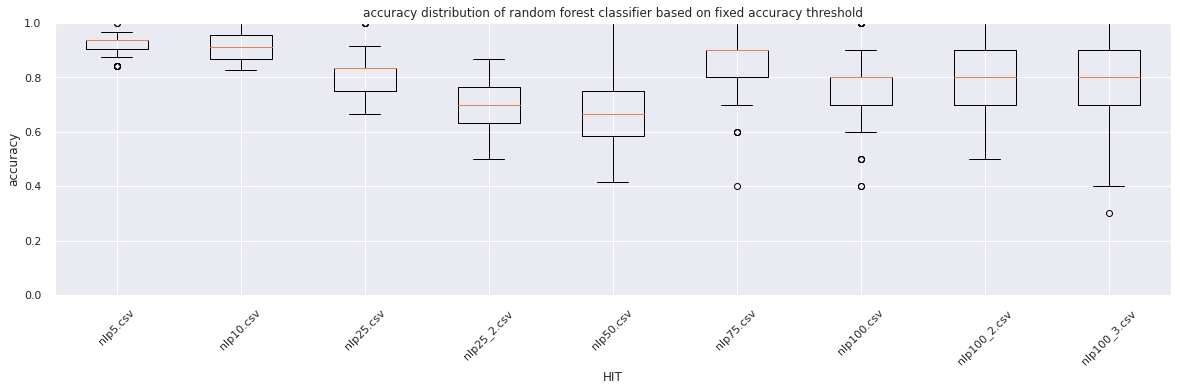

<Figure size 1440x360 with 0 Axes>

In [ ]:
plt.boxplot(prediction_accuracy_nlp_forest_fixed)
plt.ylim([0,1])
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)
plt.title("accuracy distribution of random forest classifier based on fixed accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.figure()

###### General

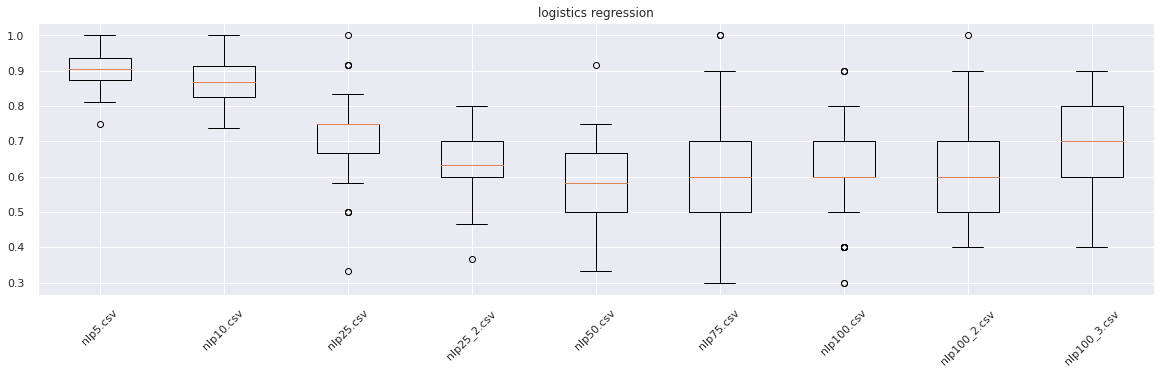

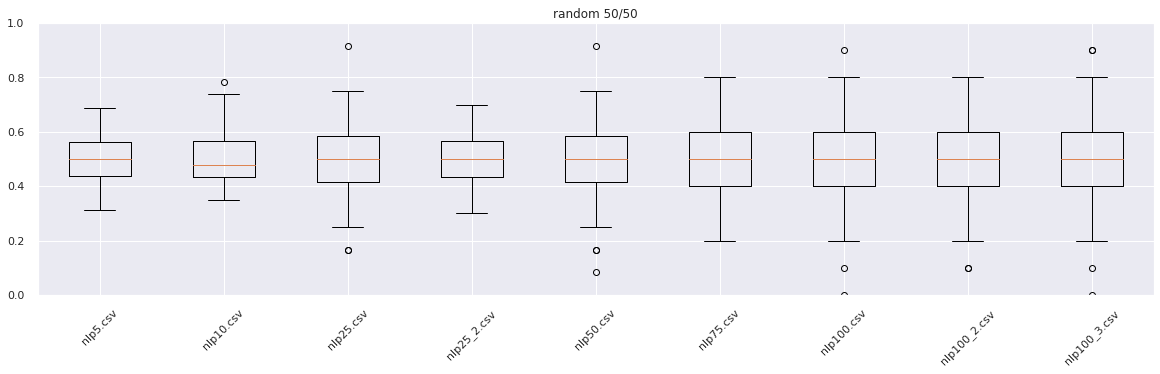

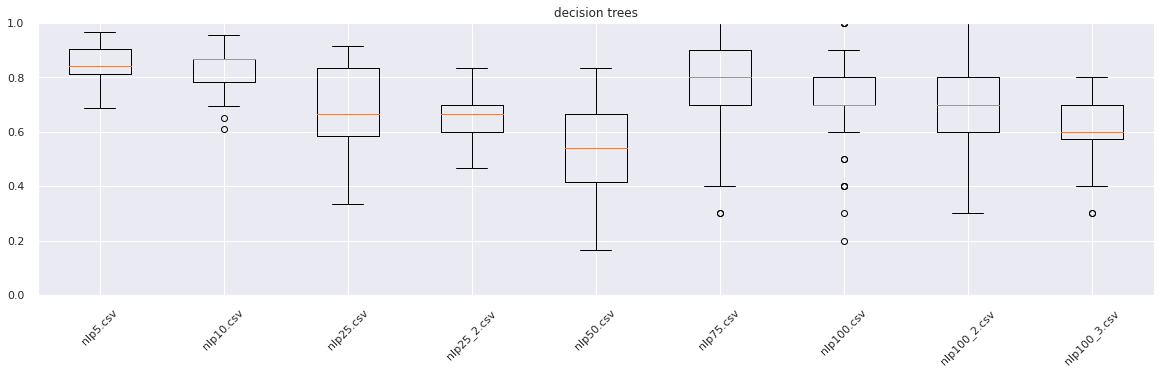

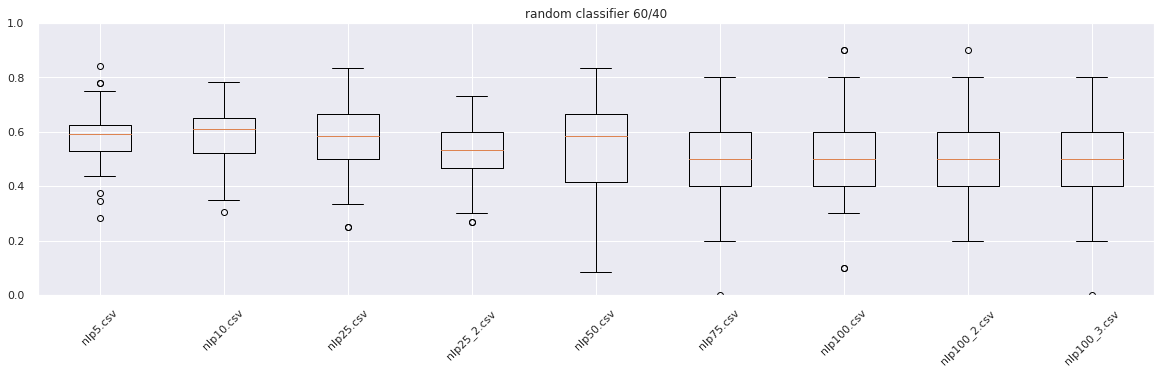

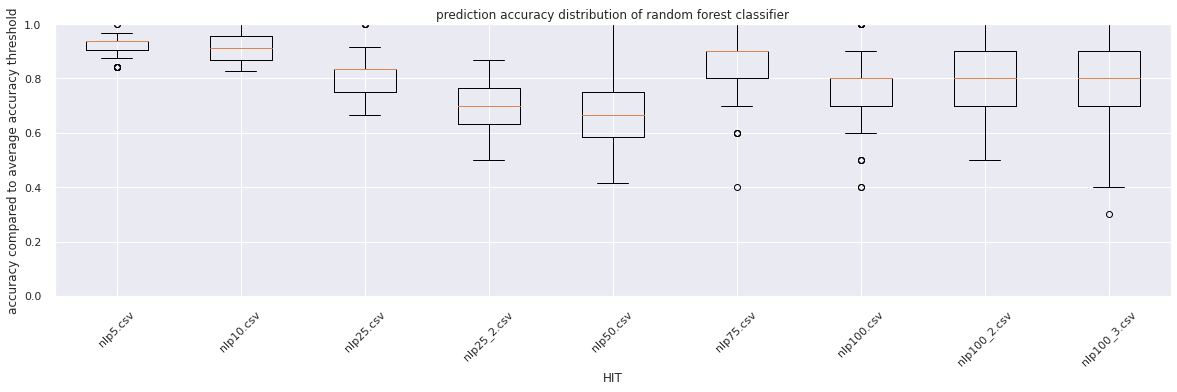

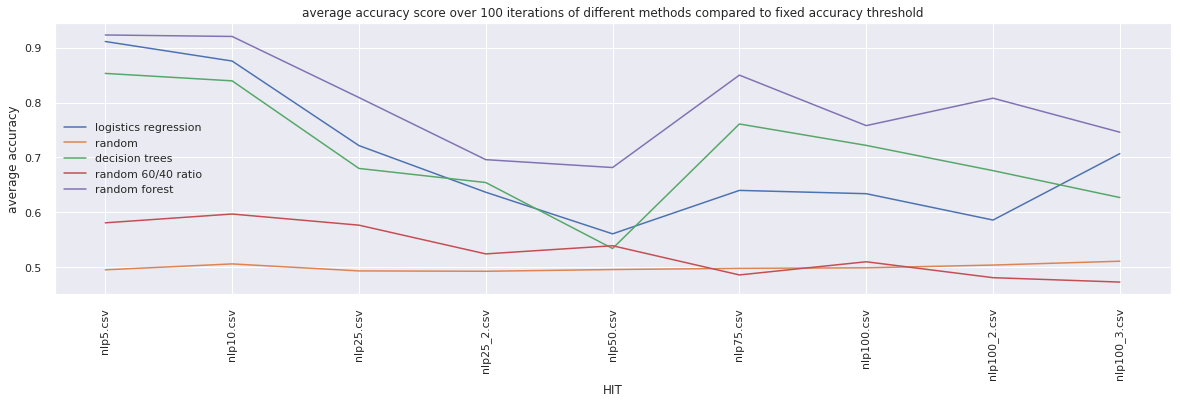

In [ ]:
plt.figure()
plt.title("logistics regression")
plt.boxplot(prediction_accuracy_nlp_logistics_fixed)
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)

plt.figure()
plt.ylim([0,1])
plt.title("random 50/50")
plt.boxplot(prediction_accuracy_nlp_random_fixed)
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)

plt.figure()
plt.ylim([0,1])
plt.title("decision trees")
plt.boxplot(prediction_accuracy_nlp_tree_fixed)
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)
plt.ylim([0,1])

plt.figure()
plt.title("random classifier 60/40")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_nlp_random_ratio_fixed)
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)
plt.show()

plt.figure()
plt.title("prediction accuracy distribution of random forest classifier")
plt.xlabel("HIT")
plt.ylabel("accuracy compared to average accuracy threshold")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_nlp_forest_fixed)
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)

plt.show()


plt.figure()
plt.title("average accuracy score over " + str(ITERATION) + " iterations of different methods compared to fixed accuracy threshold")
plt.xlabel('HIT')
plt.xticks(rotation=90)
plt.ylabel('average accuracy')
#plt.ylim([0.4,0.8])
a,b,c,d,e = [],[],[],[],[]

for i in range(file_size):
  a.append(np.average(prediction_accuracy_nlp_logistics_fixed[i]))
  b.append(np.average(prediction_accuracy_nlp_random_fixed[i]))
  c.append(np.average(prediction_accuracy_nlp_tree_fixed[i]))
  d.append(np.average(prediction_accuracy_nlp_random_ratio_fixed[i]))
  e.append(np.average(prediction_accuracy_nlp_forest_fixed[i]))


plt.plot(nlp_files,a)
plt.plot(nlp_files,b)
plt.plot(nlp_files,c)
plt.plot(nlp_files,d)
plt.plot(nlp_files,e)

leg = ["logistics regression","random","decision trees","random 60/40 ratio", "random forest"]
plt.legend(leg)
plt.show()



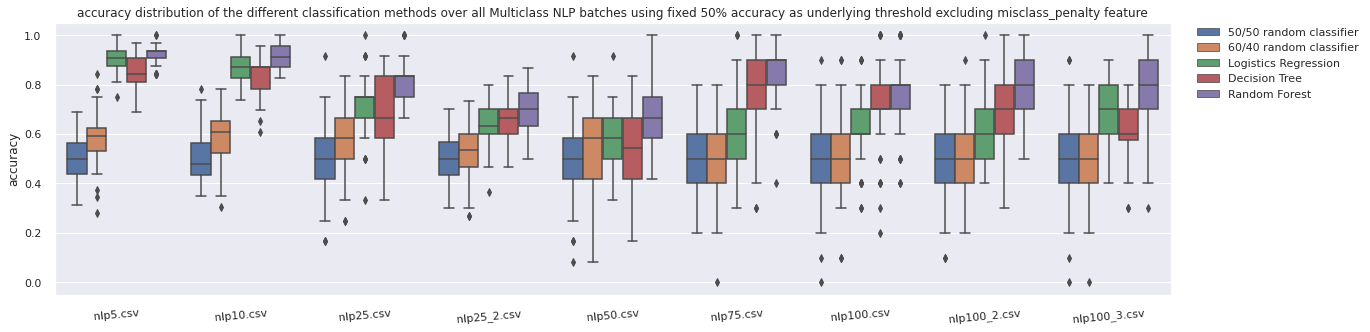

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(44)
# DATAFRAMES WITH TRIAL COLUMN ASSIGNED

box = []

for i in range(file_size):
  data = [prediction_accuracy_nlp_random_fixed[i],prediction_accuracy_nlp_random_ratio_fixed[i],prediction_accuracy_nlp_logistics_fixed[i],prediction_accuracy_nlp_tree_fixed[i],prediction_accuracy_nlp_forest_fixed[i]]
  data = np.array(data) .T.tolist()
  box.append(pd.DataFrame(data, columns=["50/50 random classifier","60/40 random classifier","Logistics Regression","Decision Tree","Random Forest"]).assign(Trial=i))
  #box2.append(pd.DataFrame(prediction_accuracy_nlp_tree_average[i], columns=[nlp_files[i]]).assign(Trial=i))


cdf = pd.concat(box)                           # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Trial'], var_name=['Method'])      # MELT

sns.set(rc={"figure.figsize":(20, 5)}) 
ax = sns.boxplot(x="Trial", y="value", hue="Method", data=mdf)

plt.title("accuracy distribution of the different classification methods over all Multiclass NLP batches using fixed 50% accuracy as underlying threshold excluding misclass_penalty feature")
plt.ylabel("accuracy")
plt.xlabel("")
plt.xticks(list(range(file_size)), nlp_files, rotation=5)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.show()

'''
for i in range(np.size(nlp_files)):
  ax = sns.boxplot(data=box[i])  # RUN PLOT   
  plt.show()
'''
plt.clf()
plt.close()

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_nlp_forest_median = []
for i in range(np.size(nlp_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_nlp_median[2*i+1][j], prediction_nlp_forest_median[ITERATION*i+j]))

  prediction_accuracy_nlp_forest_median.append(pred_acc)

e = []
for j in range(np.size(nlp_files)):
  e.append(np.median(prediction_accuracy_nlp_forest_median[j]))

<Figure size 1440x360 with 0 Axes>

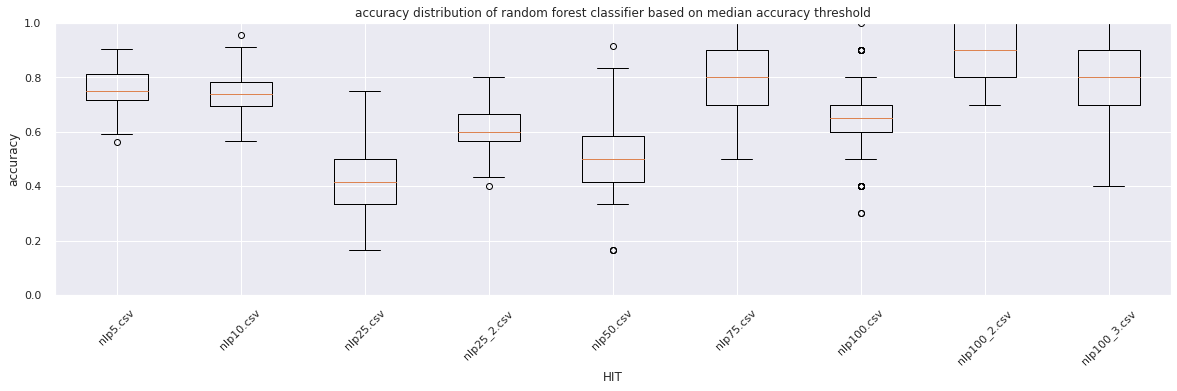

<Figure size 1440x360 with 0 Axes>

In [ ]:
plt.boxplot(prediction_accuracy_nlp_forest_median)
plt.ylim([0,1])
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)
plt.title("accuracy distribution of random forest classifier based on median accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.figure()

##### Misclass Penalty Threshold

###### Random Classifier

In [ ]:
prediction_accuracy_nlp_random_median_penalty = []
prediction_accuracy_nlp_random_ratio_median_penalty = []
for i in range(np.size(nlp_files)):
  pred_acc = []
  pred_acc_ratio = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_nlp_median_penalty[2*i+1][j], nlp_random_classification_median_penalty[ITERATION*i+j]))
    
    pred_acc_ratio.append(metrics.accuracy_score(Y_nlp_median_penalty[2*i+1][j], nlp_random_ratio_classification_median_penalty[ITERATION*i+j]))
    

  prediction_accuracy_nlp_random_median_penalty.append(pred_acc)
  prediction_accuracy_nlp_random_ratio_median_penalty.append(pred_acc_ratio)

a,b = [],[]
for j in range(np.size(nlp_files)):
  a.append(np.average(prediction_accuracy_nlp_random_average[j]))
  b.append(np.average(prediction_accuracy_nlp_random_ratio_average[j]))

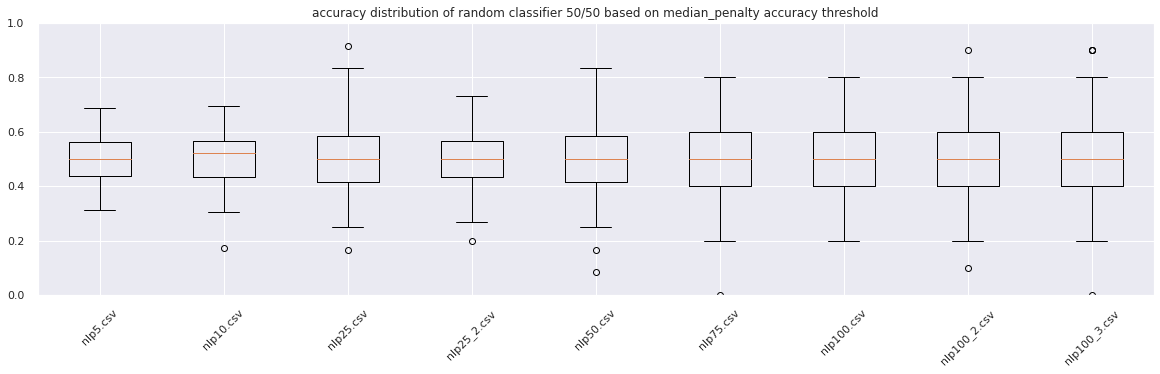

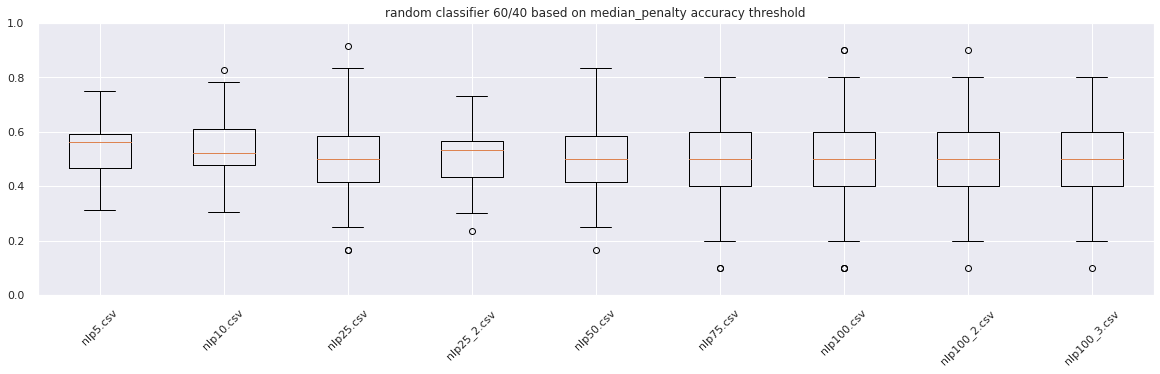

In [ ]:
plt.figure()
plt.title("accuracy distribution of random classifier 50/50 based on median_penalty accuracy threshold")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_nlp_random_median_penalty)
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)
plt.show()
plt.figure()
plt.title("random classifier 60/40 based on median_penalty accuracy threshold")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_nlp_random_ratio_median_penalty)
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)

plt.show()

###### Logistics Regression

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_nlp_logistics_median_penalty = []
for i in range(np.size(nlp_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_nlp_median_penalty[2*i+1][j], prediction_nlp_logistics_median_penalty[ITERATION*i+j]))

  prediction_accuracy_nlp_logistics_median_penalty.append(pred_acc)

c = []
for j in range(np.size(nlp_files)):
  c.append(np.average(prediction_accuracy_nlp_logistics_median_penalty[j]))

<Figure size 1440x360 with 0 Axes>

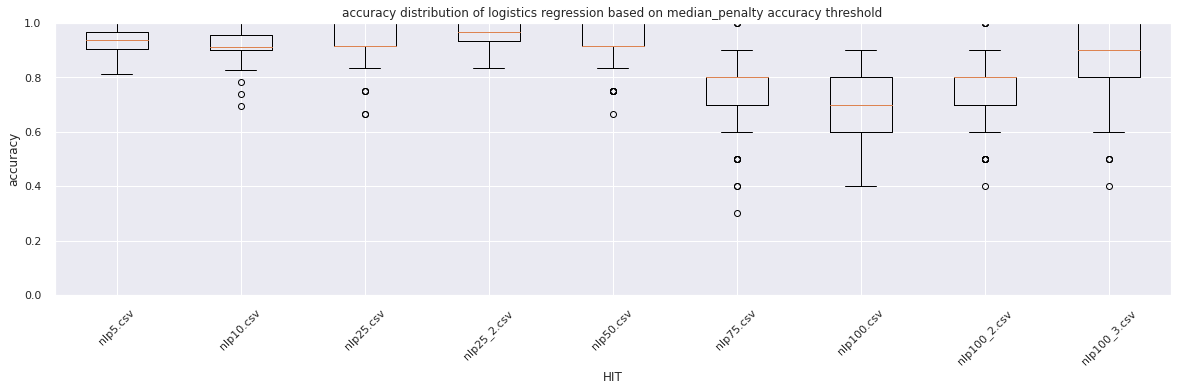

<Figure size 1440x360 with 0 Axes>

In [ ]:
plt.boxplot(prediction_accuracy_nlp_logistics_median_penalty)
plt.ylim([0,1])
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)
plt.title("accuracy distribution of logistics regression based on median_penalty accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.figure()

###### Decision Trees

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_nlp_tree_median_penalty = []
for i in range(np.size(nlp_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_nlp_median_penalty[2*i+1][j], prediction_nlp_tree_median_penalty[ITERATION*i+j]))

  prediction_accuracy_nlp_tree_median_penalty.append(pred_acc)

d = []
for j in range(np.size(nlp_files)):
  d.append(np.average(prediction_accuracy_nlp_tree_median_penalty[j]))

(0.0, 1.0)

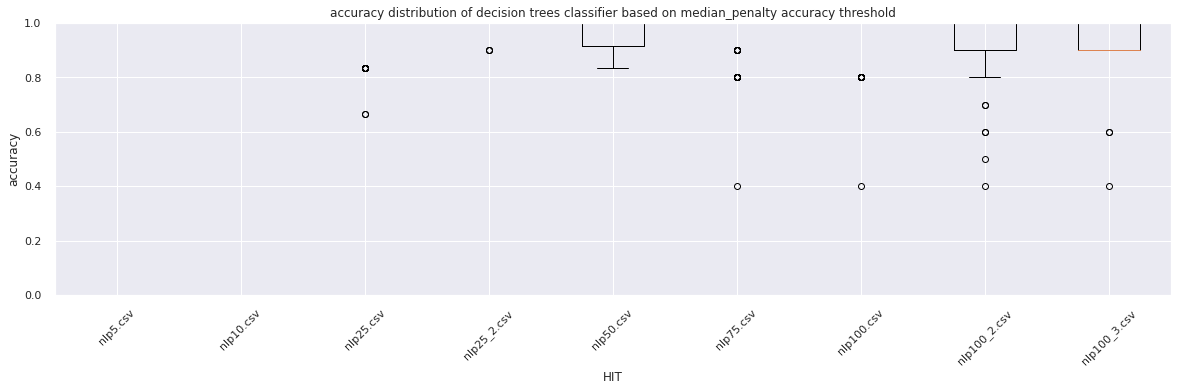

In [ ]:
plt.figure()
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_nlp_tree_median_penalty)
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)
plt.title("accuracy distribution of decision trees classifier based on median_penalty accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.ylim([0,1])

###### Random Forest

In [ ]:
import matplotlib.pyplot as plt

prediction_accuracy_nlp_forest_median_penalty = []
for i in range(np.size(nlp_files)):
  pred_acc = []
  for j in range(ITERATION):
    pred_acc.append(metrics.accuracy_score(Y_nlp_median_penalty[2*i+1][j], prediction_nlp_forest_median_penalty[ITERATION*i+j]))

  prediction_accuracy_nlp_forest_median_penalty.append(pred_acc)

e = []
for j in range(np.size(nlp_files)):
  e.append(np.average(prediction_accuracy_nlp_forest_median_penalty[j]))

<Figure size 1440x360 with 0 Axes>

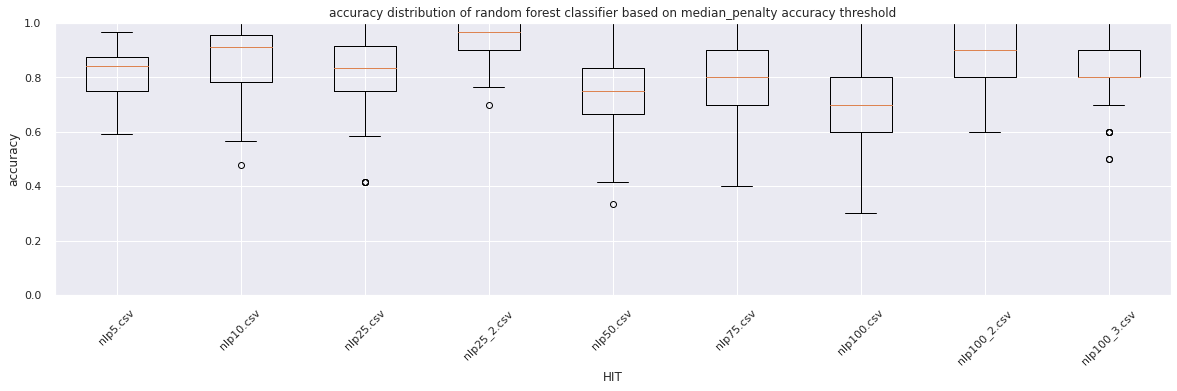

<Figure size 1440x360 with 0 Axes>

In [ ]:
plt.boxplot(prediction_accuracy_nlp_forest_median_penalty)
plt.ylim([0,1])
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)
plt.title("accuracy distribution of random forest classifier based on median_penalty accuracy threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.figure()

###### General

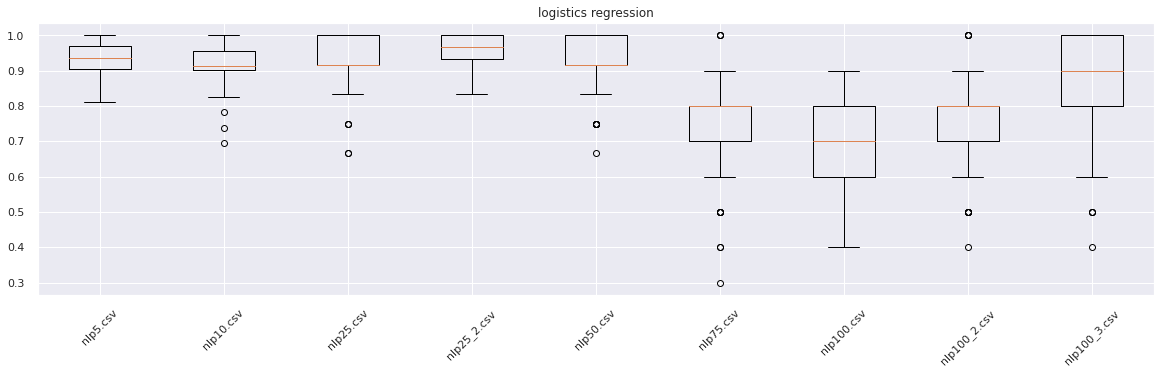

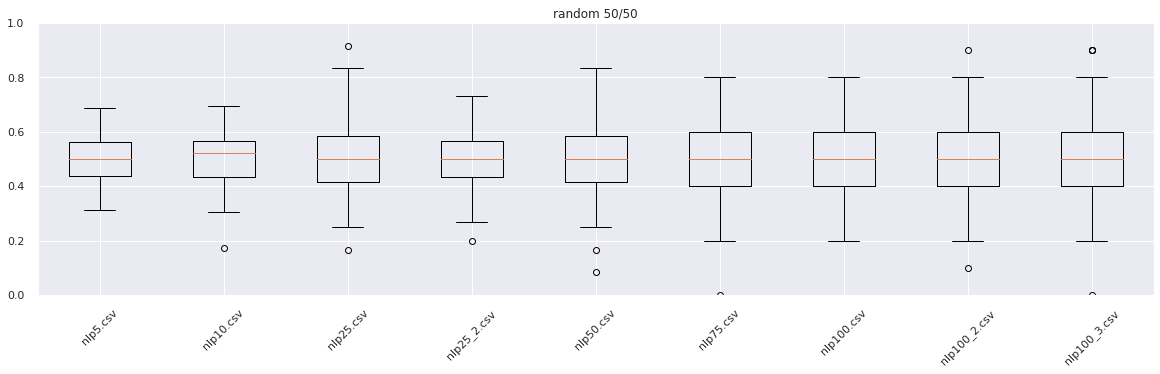

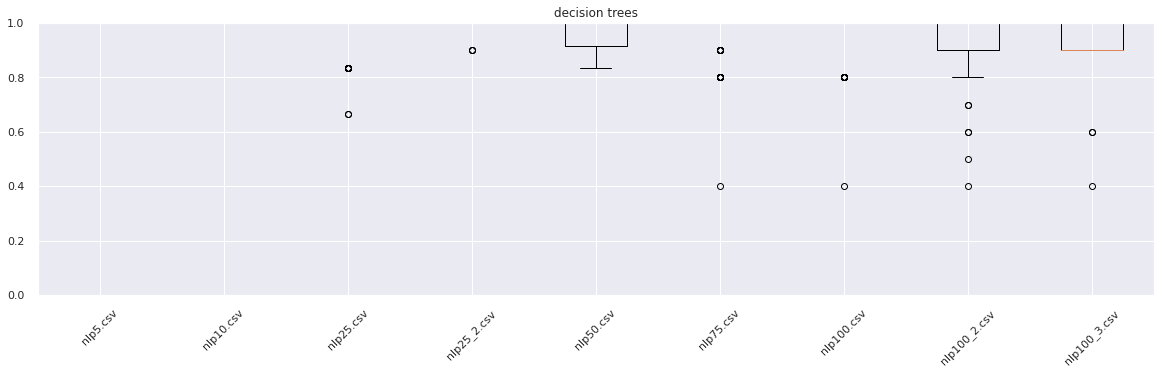

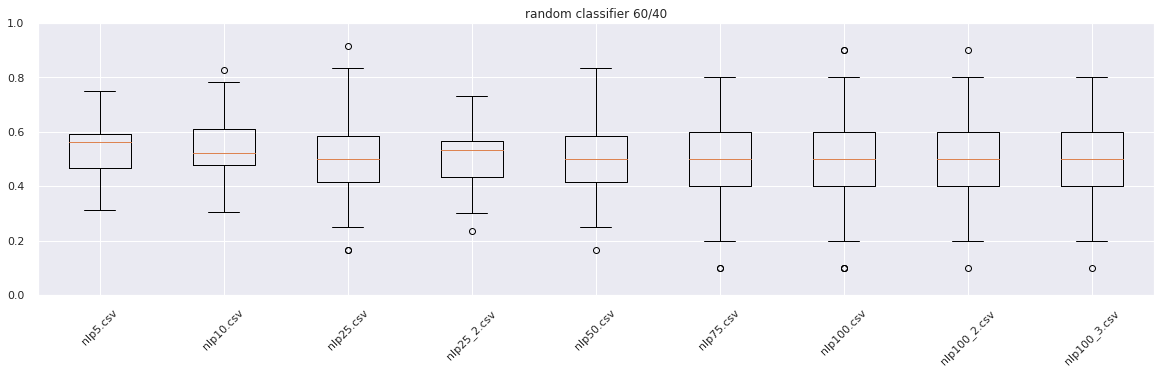

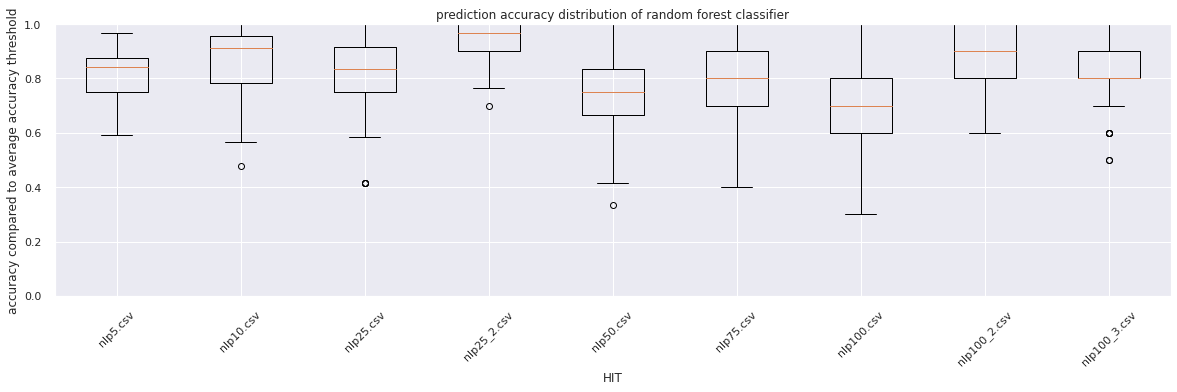

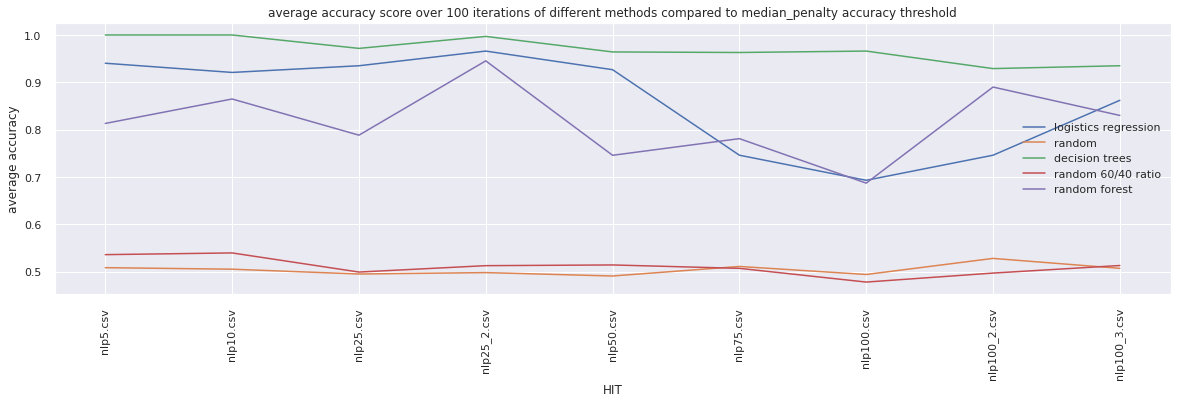

In [ ]:
plt.figure()
plt.title("logistics regression")
plt.boxplot(prediction_accuracy_nlp_logistics_median_penalty)
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)

plt.figure()
plt.ylim([0,1])
plt.title("random 50/50")
plt.boxplot(prediction_accuracy_nlp_random_median_penalty)
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)

plt.figure()
plt.ylim([0,1])
plt.title("decision trees")
plt.boxplot(prediction_accuracy_nlp_tree_median_penalty)
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)
plt.ylim([0,1])

plt.figure()
plt.title("random classifier 60/40")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_nlp_random_ratio_median_penalty)
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)
plt.show()

plt.figure()
plt.title("prediction accuracy distribution of random forest classifier")
plt.xlabel("HIT")
plt.ylabel("accuracy compared to average accuracy threshold")
plt.ylim([0,1])
plt.boxplot(prediction_accuracy_nlp_forest_median_penalty)
plt.xticks(list(range(1,file_size+1)), nlp_files, rotation=45)

plt.show()


plt.figure()
plt.title("average accuracy score over " + str(ITERATION) + " iterations of different methods compared to median_penalty accuracy threshold")
plt.xlabel('HIT')
plt.xticks(rotation=90)
plt.ylabel('average accuracy')
#plt.ylim([0.4,0.8])
a,b,c,d,e = [],[],[],[],[]

for i in range(file_size):
  a.append(np.average(prediction_accuracy_nlp_logistics_median_penalty[i]))
  b.append(np.average(prediction_accuracy_nlp_random_median_penalty[i]))
  c.append(np.average(prediction_accuracy_nlp_tree_median_penalty[i]))
  d.append(np.average(prediction_accuracy_nlp_random_ratio_median_penalty[i]))
  e.append(np.average(prediction_accuracy_nlp_forest_median_penalty[i]))


plt.plot(nlp_files,a)
plt.plot(nlp_files,b)
plt.plot(nlp_files,c)
plt.plot(nlp_files,d)
plt.plot(nlp_files,e)

leg = ["logistics regression","random","decision trees","random 60/40 ratio", "random forest"]
plt.legend(leg)
plt.show()



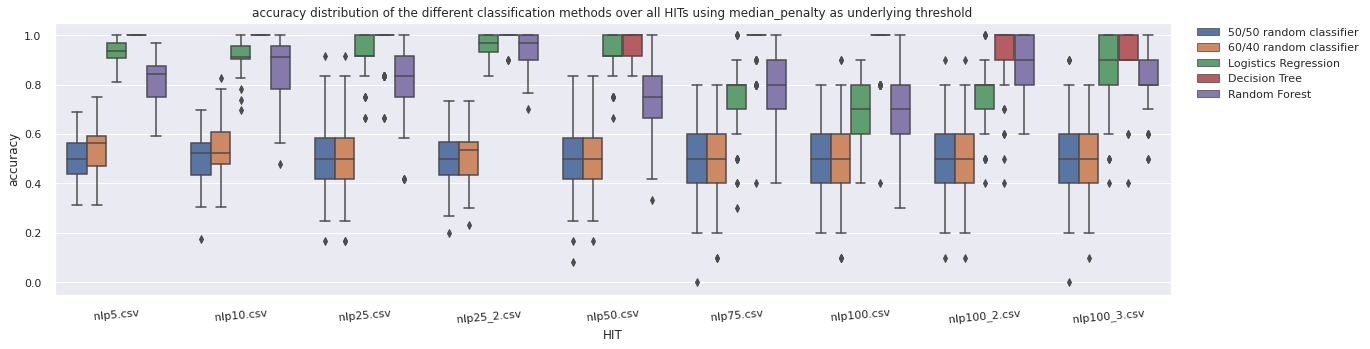

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(44)
# DATAFRAMES WITH TRIAL COLUMN ASSIGNED

box = []

for i in range(np.size(nlp_files)):
  data = [prediction_accuracy_nlp_random_median_penalty[i],prediction_accuracy_nlp_random_ratio_median_penalty[i],prediction_accuracy_nlp_logistics_median_penalty[i],prediction_accuracy_nlp_tree_median_penalty[i],prediction_accuracy_nlp_forest_median_penalty[i]]
  data = np.array(data) .T.tolist()
  box.append(pd.DataFrame(data, columns=["50/50 random classifier","60/40 random classifier","Logistics Regression","Decision Tree","Random Forest"]).assign(Trial=i))
  #box2.append(pd.DataFrame(prediction_accuracy_nlp_tree_average[i], columns=[nlp_files[i]]).assign(Trial=i))


cdf = pd.concat(box)                           # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Trial'], var_name=['Method'])      # MELT

sns.set(rc={"figure.figsize":(20, 5)}) 
ax = sns.boxplot(x="Trial", y="value", hue="Method", data=mdf)

plt.title("accuracy distribution of the different classification methods over all HITs using median_penalty as underlying threshold")
plt.ylabel("accuracy")
plt.xlabel("HIT")
plt.xticks(list(range(file_size)), nlp_files, rotation=5)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.show()

'''
for i in range(np.size(nlp_files)):
  ax = sns.boxplot(data=box[i])  # RUN PLOT   
  plt.show()
'''
plt.clf()
plt.close()